# CSE 510 - SPRING 2020 - FINAL PROJECT - MARL - CITY ON FIRE

UBName: asedimbi
UBID: 50315869
email: asedimbi@buffalo.edu

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import gym
import time
import random
from collections import deque
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten
from keras.optimizers import Adam, RMSprop, SGD

Using TensorFlow backend.


In [0]:
def new_act_net():
    model = Sequential()
    model.add(Dense(8, input_shape = (4,), activation = 'relu'))
    model.add(Dense(4, activation = 'relu'))
    model.add(Dense(4, activation = 'softmax'))
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer = Adam(), metrics = ['accuracy'])
    #model.summary()

    return model

In [0]:
net = new_act_net()
net.load_weights('/content/drive/My Drive/Colab Notebooks/New_Act_Policy_V3.h5')

In [0]:
def move_net():
    model = Sequential()
    model.add(Dense(4, input_shape = (4,), activation='tanh'))
    model.add(Dense(4, activation='linear'))
    model.compile(loss = 'mean_squared_error', optimizer = Adam(lr = 0.0005))
    
    return model

In [0]:
class fire():

    def __init__(self, global_counter, loc):
        self.ID = global_counter
        self.heat = 100.0
        self.loc = loc.copy()


In [0]:
class MsgBox():

    def __init__(self, loc, fire_ID):
        self.f_loc = loc.copy()
        self.need_help = True
        self.got_response = False
        self.fire_ID = fire_ID
        self.delete = False

In [0]:
def abs_dist(loc1, loc2):
    return abs(loc1[0] - loc2[0]) + abs(loc1[1] - loc2[1])

In [0]:
class City():

    def __init__(self, size=5, fires = 1):
        #Static values
        self.size = 20
        self.n_fires = fires
        self.max_timesteps = self.size*50

        #Dynamic Values
        self.timestep = 0
        self.fire_ID_counter = 1000
        self.fires = self.set_fires()
        self.agent_pos = [[0,0], [self.size, 0], [0, self.size], [self.size, self.size]]
        self.dones = [False]*fires
        self.messages = []
        

        #self.moves = {0 : "UP", 1 : "DOWN", 2 : "RIGHT", 3 : "LEFT"}
        #self.actions = {0: "MOVE",1: "WATER", 2:"CALL", 3:"DISENGAGE"} 
    
    def set_fires(self):
        fire_list, location = [], None
        for i in range(self.n_fires):
            location = np.random.randint(self.size/4, 3*self.size/4, size = (1,2))[0]
            fire_list.append(fire(self.fire_ID_counter, location))
            self.fire_ID_counter += 1

        return fire_list
    
    def check_fires(self):
        fires = self.fires[:]
        for fire in fires:
            if fire.heat <= 0:
                self.fires.remove(fire)
                print('Fire ID: '+str(fire.ID)+' goes POP')
        if len(self.fires)>0:
            return False
        else:
            return True
    
    def inc_fires(self):
        for f in self.fires:
            f.heat += np.random.choice([2.5,5])

    def print_fires(self):
        for f in self.fires:
            pass
            print(tuple(f.ID, f.loc, f.heat), end = ' ')
        print()


    def reset(self):

        #Reset the dynamic values
        self.timestep = 0
        self.fire_ID_counter = 1000
        self.fires = self.set_fires()
        self.agent_pos = [[0,0], [self.size, 0], [0, self.size], [self.size, self.size]]
        self.dones = [False]*len(self.fires)
        self.messages = []
    
    def render(self):
        grid = np.zeros((self.size+1, self.size+1))
        for f in self.fires:
            grid[f.loc[0], f.loc[1]] = 25
        c = 4
        for p in self.agent_pos:
            grid[tuple(p)] = 1+c
            c += 4
        plt.imshow(grid, cmap = 'Blues')
    
    def check_messages(self):
        #Remove responded messages
        copy_messages = self.messages[:]
        fire_IDs = [f.ID for f in self.fires]
        for m in copy_messages:
            if(m.delete == True):
                self.messages.remove(m)
        
        for m in copy_messages:
            if(m.fire_ID not in fire_IDs):
                #print('fire is already out---------', m.fire_ID)
                #print(len(copy_messages))
                #print(len(self.messages))
                self.messages.remove(m)
    
    def step(self, Agents, Actions):
        R_vec = [0,0,0,0]
        dones = [False]*len(self.fires)
        self.inc_fires()
        prev_pos = self.agent_pos.copy()

        self.check_messages()

        #update fire indices in messages:
        if len(self.messages) > 0:
            for msg in self.messages:
                pass
                #print('Msg: loc, no, resp, del ', msg.f_loc, msg.fire_ID, msg.got_response, msg.delete)

        for i in range(len(Agents)):
            if(Agents[i].active):
                got_target = False
                for fi in range(len(self.fires)):
                    if (self.fires[fi].ID == Agents[i].f_ID):
                        goal = self.fires[fi].loc.copy()
                        got_target = True
                        break
                if(not got_target):
                    Agents[i].choose_target(self)
                    #print('Here---------------------------------------------------')
                    goal = Agents[i].f_loc.copy()
                
                if not Agents[i].reached:
                    
                    if Actions[i] == 0:
                        Agents[i].pos[0] += 1
                    elif Actions[i] == 1:
                        Agents[i].pos[0] -= 1
                    elif Actions[i] == 2:
                        Agents[i].pos[1] += 1
                    elif Actions[i] == 3:
                        Agents[i].pos[1] -= 1
                    elif(Actions[i] == 4 or Actions[i] == 5):
                        R_vec[i] = -2

                    Agents[i].pos = np.clip(Agents[i].pos, 0, self.size).copy()
                    
                    if(abs_dist(Agents[i].pos, goal) == 0):
                        R_vec[i] = 2
                        Agents[i].reached = True
                        Agents[i].act_state[0] = 1
                        #print("Reached_"+str(i), end = ' ')
                    elif abs_dist(Agents[i].pos, goal) < abs_dist(prev_pos[i], goal):
                        R_vec[i] = 0.5
                    else:
                        R_vec[i] = -1
                else:
                    # If Agent has already reached the fire
                    # Know the fire index 'fi'

                    if(self.fires[fi].heat >= 150 and Agents[i].reached):
                        # A help has to be rasied
                        Agents[i].act_state[1] = 0
                        if(Actions[i] != 5):
                            #If not calling for help
                            if(Agents[i].act_state[2] == 0):
                                R_vec[i] = -2
                            elif(Agents[i].act_state[2] == 1):
                                if(Actions[i] == 4):
                                    R_vec[i] += 1
                                    self.fires[fi].heat -= 10.0
                                    #print(self.fires[fi].heat, Agents[i].f_ID, end = ' ')
                                    #print('-----------------------')

                        elif(Actions[i] == 5):
                            R_vec[i] += 5
                            #this action paralelly uses water jet too
                            self.fires[fi].heat -= 10.0
                            #Check if help is on the way
                            helper = False
                            m_raised = False
                            for q,m in enumerate(self.messages):
                                if (m.fire_ID == Agents[i].f_ID):
                                    if(m.got_response):
                                        Agents[i].act_state[2] = 1
                                        helper = True
                                        m.delete = True
                                        #print('Setting delete.. ',m.fire_ID, m.f_loc)
                                    else:
                                        #print('No response to fire ID ', Agents[i].f_ID)
                                        m_raised = True
                            if((not helper) and (not m_raised)):
                                #raise a help call
                                self.messages.append(MsgBox(loc = Agents[i].f_loc, fire_ID = Agents[i].f_ID))

                    else:
                        Agents[i].act_state[1] = 1
                        if(Actions[i] != 4):
                            #if calling for unnecessary help or moving away
                            R_vec[i] = -2
                        elif(Actions[i] == 4):
                            R_vec[i] += 1
                            self.fires[fi].heat -= 10.0
                            #print(self.fires[fi].heat, Agents[i].f_ID, end = ' ')
                            #print('-----------------------')
                
                if(abs_dist(Agents[i].pos, goal) == 0):
                    if(not Agents[i].reached):
                        Agents[i].reached = True
                        Agents[i].act_state[0] = 1
                        #print("Reached_"+str(i), end = ' ')

        for j,f in enumerate(self.fires):
            if(f.heat <= 0):
                #print('----Solved_'+str(f.ID)+'----', end = ' ')
                dones[j] = True
                R_vec = [x+10 for x in R_vec]
                for i in range(len(Agents)):
                    if Agents[i].f_ID == f.ID:
                        Agents[i].act_state[3] = 1
                        Agents[i].agent_reset(Agents[i].pos)
                        Agents[i].active = True
            else:
                pass
        
        self.timestep += 1
        if self.timestep == self.max_timesteps:
            dones = [True]*len(self.fires)
            R_vec = [x-2 for x in R_vec]
        
        self.check_messages()
        
        #Read Messages and Responses:
        
        for j,msg in enumerate(self.messages):
            if(not msg.got_response):
                best_resp, resp, ag_no = None, None, None
                for k,a in enumerate(Agents):
                    if not a.engaged:
                        resp = abs_dist(msg.f_loc, a.pos)
                        if(best_resp == None):
                            best_resp = resp
                            ag_no = k
                        elif(best_resp > resp):
                            best_resp = resp
                            ag_no = k
                if(ag_no != None):
                    Agents[ag_no].agent_re_engage(msg.f_loc, msg.fire_ID)
                    self.messages[j].got_response = True
                    #print('Agent_'+str(ag_no)+' responding to fire numbered ', msg.fire_ID)


        self.agent_pos = [a.pos for a in Agents]

        state_dict = dict()
        state_dict['R_vec'] = R_vec

        return state_dict
        

In [0]:
def spawn_agents(e):
    fs = e.fires
    ags = []
    for i, p in enumerate(e.agent_pos):
        a = DQNAgent(env = e, pos = p.copy())
        a.agent_no = i+1
        a.act_net.load_weights('/content/drive/My Drive/Colab Notebooks/New_Act_Policy_V3.h5')
        ags.append(a)
    return ags

In [0]:
def activate_agents(e,Agents):
    
    for i,f in enumerate(e.fires):
        best_resp, resp, ag_no = None, None, None
        if(i>= len(Agents)):
            return Agents
        for k,a in enumerate(Agents):
            if not a.engaged:
                resp = abs_dist(a.pos, e.fires[i].loc)
                if(best_resp == None):
                    best_resp = resp
                    ag_no = k
                elif(best_resp > resp):
                    best_resp = resp
                    ag_no = k
            else:
                continue
        Agents[ag_no].active = True
        Agents[ag_no].f_ID = f.ID
        Agents[ag_no].engaged = True
        Agents[ag_no].f_loc = e.fires[i].loc
        #print('Agent_'+str(ag_no)+' on to fire_'+ str(Agents[ag_no].f_ID ))
    
    return Agents

In [0]:
class DQNAgent():

    def __init__(self, env=City(), eps = 1.0, eps_decay = 0.995, alpha = 0.0005, gamma = 0.99,pos = [0,0], n_batch = 9, m=100000):
        self.agent_no = -1
        self.capacity = 200.0
        self.n_actions = 4
        self.n_moves = 4
        self.eps, self.eps_decay, self.alpha, self.gamma = eps, eps_decay, alpha, gamma
        self.batch_size = n_batch
        self.pos = pos.copy()
        self.base_loc = pos.copy()
        self.act_net = new_act_net()
        self.act_target = new_act_net()
        self.move_net = move_net()
        self.move_target = move_net()
        self.act_buffer = deque(maxlen=m)
        self.move_buffer = deque(maxlen=m)
        self.f_ID = None
        self.f_loc = None
        self.active = False
        self.engaged = False
        self.reached = False
        self.f_done = False
        self.act_state = [0,1,0,0]
        self.curr_state = []
        self.next_state = []
        self.next_act_state = []
        self.OBS = []
        self.M_OBS = []
        #Not reached, Has capacity, No helper, Fire is not off
    
    def agent_reset(self, p):
        self.capacity = 200.0
        self.pos = p.copy()
        self.f_ID = None
        self.f_loc = None
        self.active = False
        self.engaged = False
        self.reahced = False
        self.f_done = False
        self.act_state = [0,1,0,0]
    
    def agent_re_engage(self, f_loc, f_ID):
        self.f_ID = f_ID
        self.f_loc = f_loc.copy()
        self.active = True
        self.engaged = True
        self.reached = False
        self.f_done = False
        self.act_state = [0,1,0,0]
    
    def choose_target(self, env):
        self.active = True
        self.engaged = True
        self.f_done = False
        self.reached = False
        self.f_ID = env.fires[0].ID
        self.f_loc = env.fires[0].loc.copy()
        self.act_state = [0,1,0,0]
        d = abs_dist(self.pos, self.f_loc)
        for f in env.fires[1:]:
            d_new = abs_dist(self.pos, f.loc)
            if(d_new < d):
                d = d_new
                self.f_ID = f.ID
                self.f_loc = f.loc.copy()
        
        #print('Agent: '+str(self.agent_no)+' chose fire ID '+ str(self.f_ID))

    def save_exp(self):
        self.OBS[1] -= 3
        self.act_buffer.append(self.OBS)
        
    def save_move_exp(self):
        self.move_buffer.append(self.M_OBS)
    
    def policy_move(self):
        if np.random.uniform() < self.eps:
            return np.random.choice(self.n_moves)
        return np.argmax(self.move_net.predict(A.curr_state.reshape(1,4)))

    def policy_act(self):
        Act_State = np.array(self.act_state).reshape(1,4)
        if np.random.uniform() < self.eps:
            A =  np.random.choice(self.n_actions)
        else:
            A = np.argmax(self.act_net.predict(Act_State))
        
        if(A == 0):
            #return self.policy_move()
            return self.policy_Hmove()
        else:
            return A+3

    def policy_Hmove(self):
        state = self.curr_state
        x = state[0] - state[2]
        y = state[1] - state[3]
        if(abs(x)>=abs(y)):
            if x<0:
                return 0
            else:
                return 1
        else:
            if y<0:
                return 2
            else:
                return 3
    
    def fit_act_net(self, OBS):
        n = self.batch_size
        batch = []
        if(len(self.act_buffer)<self.batch_size):
            return
        batch = random.sample(self.act_buffer, self.batch_size)
        batch = np.array(batch).reshape(n,5)
        S = np.array([x[0] for x in batch[:,0]])
        NS = np.array([x[0] for x in batch[:,3]])
        A, R, D = batch[:,1], batch[:,2], batch[:,4]

        T =  np.amax(self.act_target.predict(S), axis = 1)
        Q_future = self.gamma*np.amax((self.act_target.predict(NS)), axis = 1)
        
        for i in np.where(D==True)[0]:
            T[i] += R[i]
        for i in np.where(D==False)[0]:
            T[i] += R[i] + Q_future[i]
        
        self.act_net.fit(S,T,epochs=1,verbose = 0)
        

    def fit_move_net(self, OBS):
        n = self.batch_size
        batch = []
        if(len(self.move_buffer)<self.batch_size):
            return
        batch = random.sample(self.move_buffer, self.batch_size)
        batch = np.array(batch).reshape(n,5)
        S = np.array([x[0] for x in batch[:,0]])
        NS = np.array([x[0] for x in batch[:,3]])
        A, R, D = batch[:,1], batch[:,2], batch[:,4]
        
        T =  self.move_target.predict(S)
        Q_future = self.gamma*np.amax((self.move_target.predict(NS)), axis = 1)
        
        for i in np.where(D==True)[0]:
            T[i][A[i]] += R[i]
        for i in np.where(D==False)[0]:
            T[i][A[i]] += R[i] + Q_future[i]

        self.move_net.fit(S,T,epochs=1,verbose = 0)



Episode: 1 

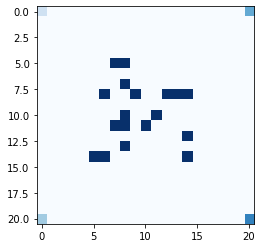

Act_State 1 : [0, 1, 0, 0] Action:  0 1002
Act_State 2 : [0, 1, 0, 0] Action:  1 1000
Act_State 3 : [0, 1, 0, 0] Action:  3 1003
Act_State 4 : [0, 1, 0, 0] Action:  3 1001


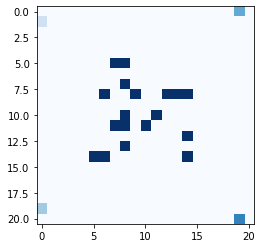

Act_State 1 : [0, 1, 0, 0] Action:  0 1002
Act_State 2 : [0, 1, 0, 0] Action:  2 1000
Act_State 3 : [0, 1, 0, 0] Action:  3 1003
Act_State 4 : [0, 1, 0, 0] Action:  3 1001


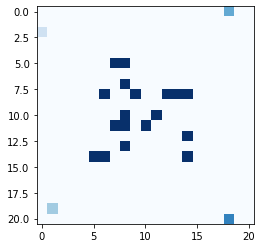

Act_State 1 : [0, 1, 0, 0] Action:  0 1002
Act_State 2 : [0, 1, 0, 0] Action:  1 1000
Act_State 3 : [0, 1, 0, 0] Action:  0 1003
Act_State 4 : [0, 1, 0, 0] Action:  3 1001


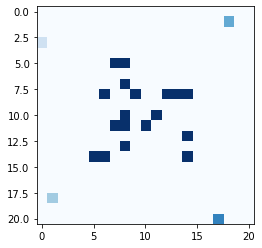

Act_State 1 : [0, 1, 0, 0] Action:  0 1002
Act_State 2 : [0, 1, 0, 0] Action:  2 1000
Act_State 3 : [0, 1, 0, 0] Action:  3 1003
Act_State 4 : [0, 1, 0, 0] Action:  3 1001


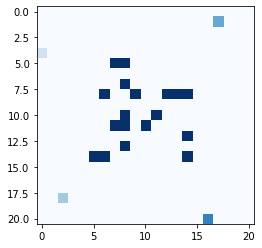

Act_State 1 : [0, 1, 0, 0] Action:  0 1002
Act_State 2 : [0, 1, 0, 0] Action:  1 1000
Act_State 3 : [0, 1, 0, 0] Action:  0 1003
Act_State 4 : [0, 1, 0, 0] Action:  3 1001


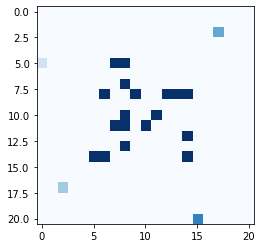

Act_State 1 : [0, 1, 0, 0] Action:  2 1002
Act_State 2 : [0, 1, 0, 0] Action:  2 1000
Act_State 3 : [0, 1, 0, 0] Action:  3 1003
Act_State 4 : [0, 1, 0, 0] Action:  1 1001


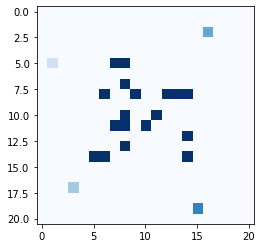

Act_State 1 : [0, 1, 0, 0] Action:  0 1002
Act_State 2 : [0, 1, 0, 0] Action:  1 1000
Act_State 3 : [0, 1, 0, 0] Action:  0 1003
Act_State 4 : [0, 1, 0, 0] Action:  3 1001


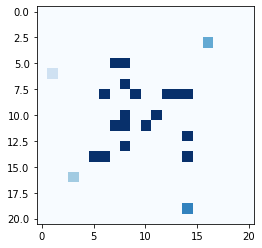

Act_State 1 : [0, 1, 0, 0] Action:  2 1002
Act_State 2 : [0, 1, 0, 0] Action:  2 1000
Act_State 3 : [0, 1, 0, 0] Action:  3 1003
Act_State 4 : [0, 1, 0, 0] Action:  1 1001


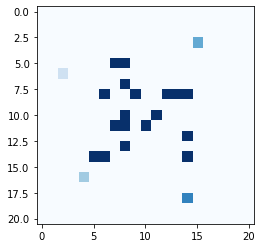

Act_State 1 : [0, 1, 0, 0] Action:  0 1002
Act_State 2 : [0, 1, 0, 0] Action:  1 1000
Act_State 3 : [0, 1, 0, 0] Action:  0 1003
Act_State 4 : [0, 1, 0, 0] Action:  3 1001


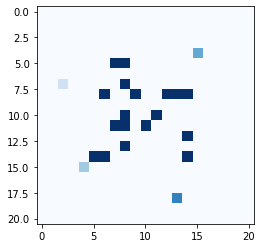

Act_State 1 : [0, 1, 0, 0] Action:  2 1002
Act_State 2 : [0, 1, 0, 0] Action:  2 1000
Act_State 3 : [0, 1, 0, 0] Action:  3 1003
Act_State 4 : [0, 1, 0, 0] Action:  1 1001


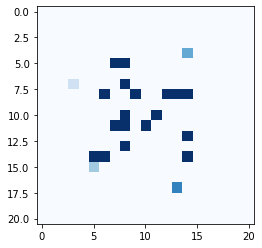

Act_State 1 : [0, 1, 0, 0] Action:  0 1002
Act_State 2 : [0, 1, 0, 0] Action:  1 1000
Act_State 3 : [0, 1, 0, 0] Action:  0 1003
Act_State 4 : [0, 1, 0, 0] Action:  3 1001


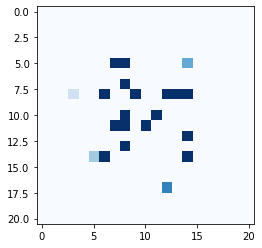

Act_State 1 : [0, 1, 0, 0] Action:  2 1002
Act_State 2 : [0, 1, 0, 0] Action:  2 1000
Act_State 3 : [0, 1, 0, 0] Action:  3 1003
Act_State 4 : [0, 1, 0, 0] Action:  1 1001


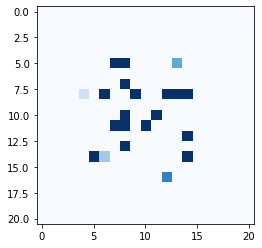

Act_State 1 : [0, 1, 0, 0] Action:  0 1002
Act_State 2 : [1, 1, 0, 0] Action:  4 1000
Act_State 3 : [0, 1, 0, 0] Action:  0 1003
Act_State 4 : [0, 1, 0, 0] Action:  3 1001


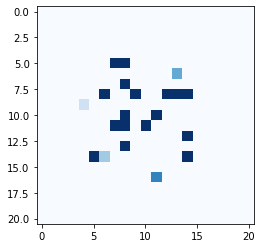

Act_State 1 : [0, 1, 0, 0] Action:  2 1002
Act_State 2 : [1, 0, 0, 0] Action:  5 1000
Act_State 3 : [0, 1, 0, 0] Action:  3 1003
Act_State 4 : [0, 1, 0, 0] Action:  1 1001


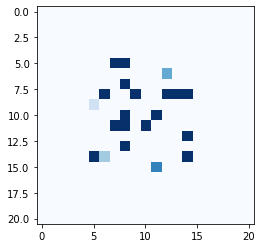

Act_State 1 : [0, 1, 0, 0] Action:  0 1002
Act_State 2 : [1, 0, 0, 0] Action:  5 1000
Act_State 3 : [0, 1, 0, 0] Action:  0 1003
Act_State 4 : [0, 1, 0, 0] Action:  3 1001


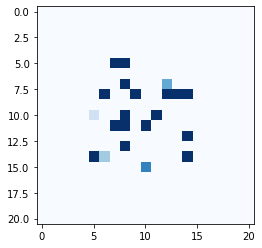

Act_State 1 : [0, 1, 0, 0] Action:  2 1002
Act_State 2 : [1, 1, 0, 0] Action:  4 1000
Act_State 3 : [0, 1, 0, 0] Action:  3 1003
Act_State 4 : [0, 1, 0, 0] Action:  1 1001


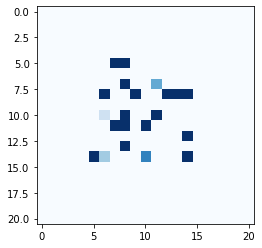

Act_State 1 : [0, 1, 0, 0] Action:  0 1002
Act_State 2 : [1, 0, 0, 0] Action:  5 1000
Act_State 3 : [0, 1, 0, 0] Action:  0 1003
Act_State 4 : [0, 1, 0, 0] Action:  3 1001


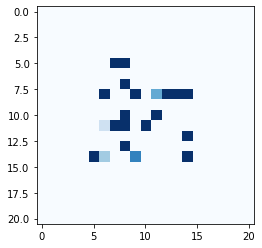

Act_State 1 : [0, 1, 0, 0] Action:  2 1002
Act_State 2 : [1, 0, 0, 0] Action:  5 1000
Act_State 3 : [0, 1, 0, 0] Action:  3 1003
Act_State 4 : [0, 1, 0, 0] Action:  1 1001


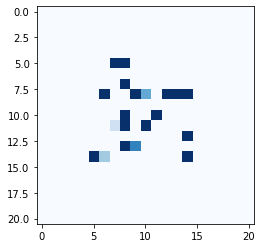

Act_State 1 : [1, 1, 0, 0] Action:  4 1002
Act_State 2 : [1, 1, 0, 0] Action:  4 1000
Act_State 3 : [0, 1, 0, 0] Action:  0 1003
Act_State 4 : [0, 1, 0, 0] Action:  3 1001


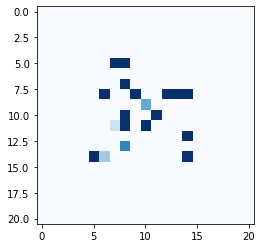

Act_State 1 : [1, 0, 0, 0] Action:  5 1002
Act_State 2 : [1, 0, 0, 0] Action:  5 1000
Act_State 3 : [0, 1, 0, 0] Action:  3 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1001


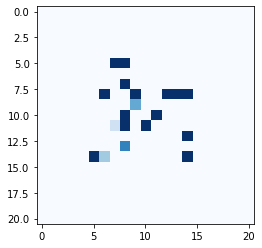

Act_State 1 : [1, 0, 0, 0] Action:  5 1002
Act_State 2 : [1, 0, 0, 0] Action:  5 1000
Act_State 3 : [0, 1, 0, 0] Action:  0 1003
Act_State 4 : [1, 0, 0, 0] Action:  5 1001


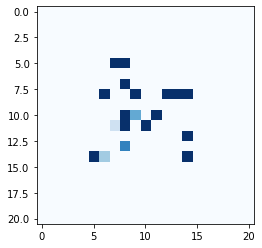

Act_State 1 : [1, 0, 0, 0] Action:  5 1002
Act_State 2 : [1, 0, 0, 0] Action:  5 1000
Act_State 3 : [0, 1, 0, 0] Action:  3 1003
Act_State 4 : [1, 0, 0, 0] Action:  5 1001


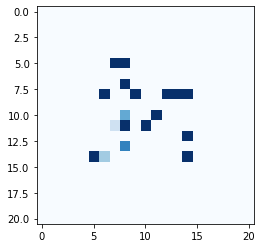

Act_State 1 : [1, 0, 0, 0] Action:  5 1002
Act_State 2 : [1, 1, 0, 0] Action:  4 1000
Act_State 3 : [0, 1, 0, 0] Action:  0 1003
Act_State 4 : [1, 0, 0, 0] Action:  5 1001


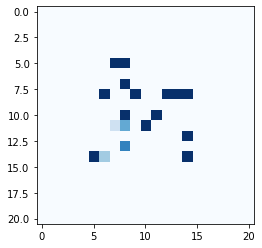

Act_State 1 : [1, 0, 0, 0] Action:  5 1002
Act_State 2 : [1, 0, 0, 0] Action:  5 1000
Act_State 3 : [0, 1, 0, 0] Action:  3 1003
Act_State 4 : [1, 0, 0, 0] Action:  5 1001


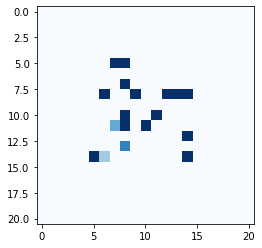

Act_State 1 : [1, 0, 0, 0] Action:  5 1002
Act_State 2 : [1, 0, 0, 0] Action:  5 1000
Act_State 3 : [1, 1, 0, 0] Action:  4 1003
Act_State 4 : [1, 0, 0, 0] Action:  5 1001


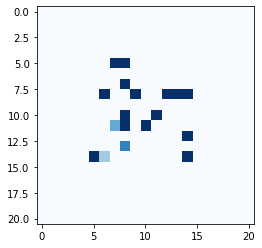

Act_State 1 : [1, 1, 0, 0] Action:  4 1002
Act_State 2 : [1, 0, 0, 0] Action:  5 1000
Act_State 3 : [1, 0, 0, 0] Action:  5 1003
Act_State 4 : [1, 0, 0, 0] Action:  5 1001


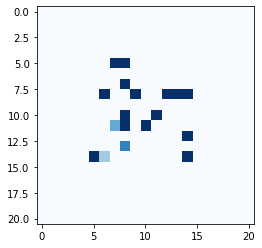

Act_State 1 : [1, 0, 0, 0] Action:  5 1002
Act_State 2 : [1, 1, 0, 0] Action:  4 1000
Act_State 3 : [1, 0, 0, 0] Action:  5 1003
Act_State 4 : [1, 0, 0, 0] Action:  5 1001


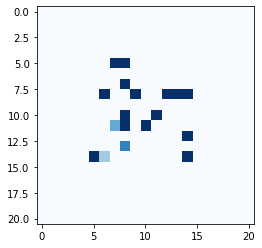

Act_State 1 : [1, 0, 0, 0] Action:  5 1002
Act_State 2 : [1, 1, 0, 0] Action:  4 1000
Act_State 3 : [1, 0, 0, 0] Action:  5 1003
Act_State 4 : [1, 0, 0, 0] Action:  5 1001


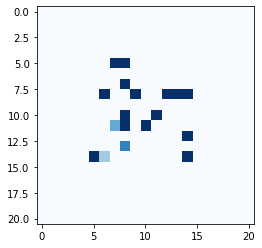

Act_State 1 : [1, 1, 0, 0] Action:  4 1002
Act_State 2 : [1, 1, 0, 0] Action:  4 1000
Act_State 3 : [1, 0, 0, 0] Action:  5 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1001


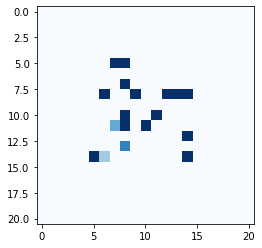

Act_State 1 : [1, 0, 0, 0] Action:  5 1002
Act_State 2 : [1, 1, 0, 0] Action:  4 1000
Act_State 3 : [1, 0, 0, 0] Action:  5 1003
Act_State 4 : [1, 0, 0, 0] Action:  5 1001


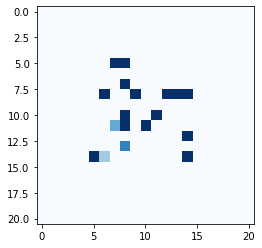

Act_State 1 : [1, 0, 0, 0] Action:  5 1002
Act_State 2 : [1, 1, 0, 0] Action:  4 1000
Act_State 3 : [1, 0, 0, 0] Action:  5 1003
Act_State 4 : [1, 0, 0, 0] Action:  5 1001


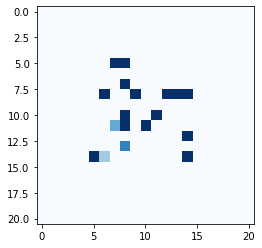

Act_State 1 : [1, 1, 0, 0] Action:  4 1002
Act_State 2 : [1, 1, 0, 0] Action:  4 1000
Act_State 3 : [1, 0, 0, 0] Action:  5 1003
Act_State 4 : [1, 0, 0, 0] Action:  5 1001


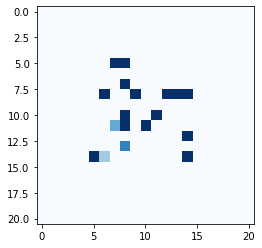

Act_State 1 : [1, 0, 0, 0] Action:  5 1002
Act_State 2 : [1, 1, 0, 0] Action:  4 1000
Act_State 3 : [1, 0, 0, 0] Action:  5 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1001


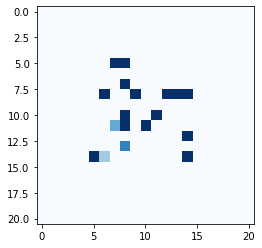

Act_State 1 : [1, 0, 0, 0] Action:  5 1002
Act_State 2 : [1, 1, 0, 0] Action:  4 1000
Act_State 3 : [1, 1, 0, 0] Action:  4 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1001


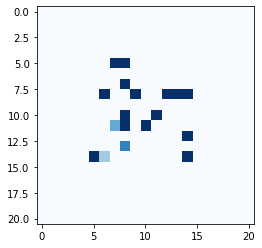

Act_State 1 : [1, 1, 0, 0] Action:  4 1002
Act_State 2 : [1, 1, 0, 0] Action:  4 1000
Act_State 3 : [1, 0, 0, 0] Action:  5 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1001


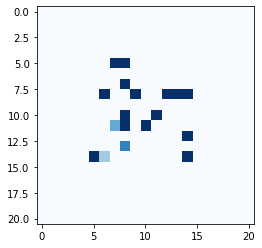

Act_State 1 : [1, 0, 0, 0] Action:  5 1002
Act_State 2 : [1, 1, 0, 0] Action:  4 1000
Act_State 3 : [1, 0, 0, 0] Action:  5 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1001


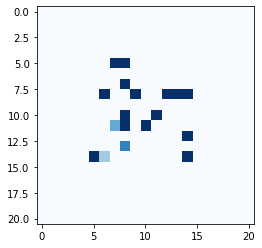

Act_State 1 : [1, 0, 0, 0] Action:  5 1002
Act_State 2 : [1, 1, 0, 0] Action:  4 1000
Act_State 3 : [1, 1, 0, 0] Action:  4 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1001


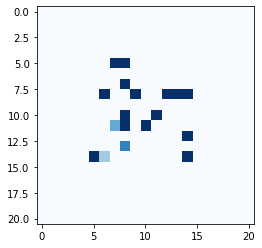

Act_State 1 : [1, 1, 0, 0] Action:  4 1002
Act_State 2 : [1, 1, 0, 0] Action:  4 1000
Act_State 3 : [1, 0, 0, 0] Action:  5 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1001


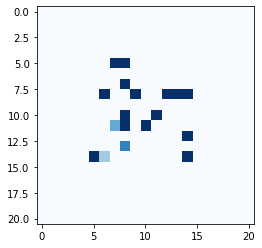

Act_State 1 : [1, 0, 0, 0] Action:  5 1002
Act_State 2 : [1, 1, 0, 0] Action:  4 1000
Act_State 3 : [1, 0, 0, 0] Action:  5 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1001


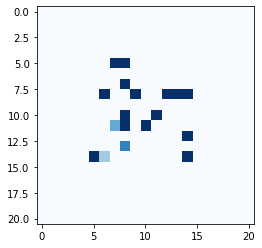

Act_State 1 : [1, 0, 0, 0] Action:  5 1002
Act_State 2 : [1, 1, 0, 0] Action:  4 1000
Act_State 3 : [1, 1, 0, 0] Action:  4 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1001


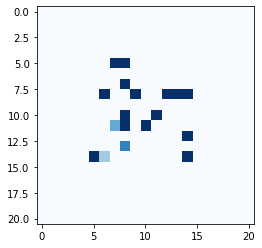

Act_State 1 : [1, 0, 0, 0] Action:  5 1002
Act_State 2 : [1, 1, 0, 0] Action:  4 1000
Act_State 3 : [1, 0, 0, 0] Action:  5 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1001


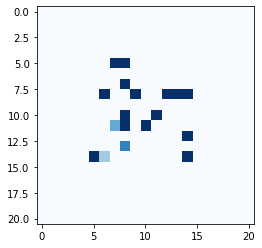

Act_State 1 : [1, 1, 0, 0] Action:  4 1002
Act_State 2 : [1, 1, 0, 0] Action:  4 1000
Act_State 3 : [1, 0, 0, 0] Action:  5 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1001


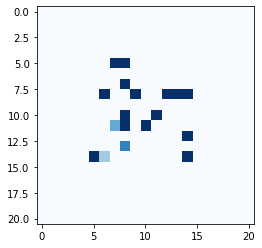

Act_State 1 : [1, 1, 0, 0] Action:  4 1002
Act_State 2 : [1, 1, 0, 0] Action:  4 1000
Act_State 3 : [1, 1, 0, 0] Action:  4 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1001


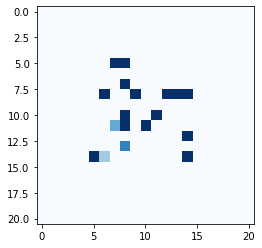

Act_State 1 : [1, 1, 0, 0] Action:  4 1002
Act_State 2 : [1, 1, 0, 0] Action:  4 1000
Act_State 3 : [1, 0, 0, 0] Action:  5 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1001


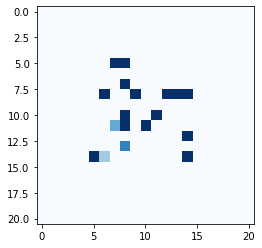

Act_State 1 : [1, 1, 0, 0] Action:  4 1002
Act_State 2 : [1, 1, 0, 0] Action:  4 1000
Act_State 3 : [1, 0, 0, 0] Action:  5 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1001


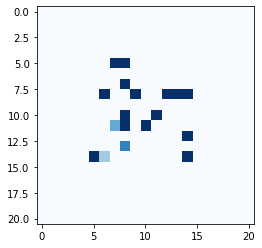

Act_State 1 : [1, 1, 0, 0] Action:  4 1002
Act_State 2 : [1, 1, 0, 0] Action:  4 1000
Act_State 3 : [1, 1, 0, 0] Action:  4 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1001


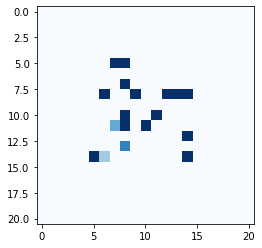

Act_State 1 : [1, 1, 0, 0] Action:  4 1002
Act_State 2 : [1, 1, 0, 0] Action:  4 1000
Act_State 3 : [1, 0, 0, 0] Action:  5 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1001


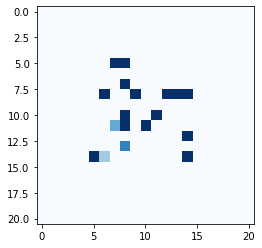

Act_State 1 : [1, 1, 0, 0] Action:  4 1002
Act_State 2 : [1, 1, 0, 0] Action:  4 1000
Act_State 3 : [1, 0, 0, 0] Action:  5 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1001


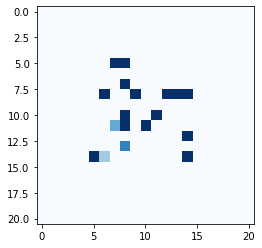

Act_State 1 : [1, 1, 0, 0] Action:  4 1002
Act_State 2 : [1, 1, 0, 0] Action:  4 1000
Act_State 3 : [1, 1, 0, 0] Action:  4 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1001


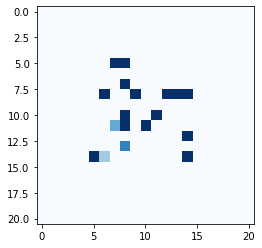

Act_State 1 : [1, 1, 0, 0] Action:  4 1002
Act_State 2 : [1, 1, 0, 0] Action:  4 1000
Act_State 3 : [1, 0, 0, 0] Action:  5 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1001


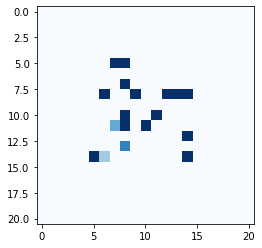

Act_State 1 : [1, 1, 0, 0] Action:  4 1002
Act_State 2 : [1, 1, 0, 0] Action:  4 1000
Act_State 3 : [1, 0, 0, 0] Action:  5 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1001
Fire ID: 1000 goes POP


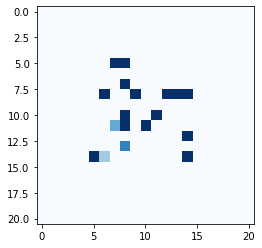

Act_State 1 : [1, 1, 0, 0] Action:  4 1002
Act_State 2 : [0, 1, 0, 0] Action:  1 1000
Act_State 3 : [1, 0, 0, 0] Action:  5 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1001


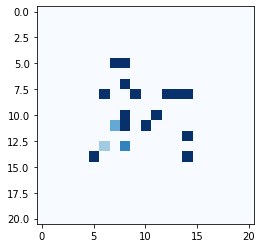

Act_State 1 : [1, 1, 0, 0] Action:  4 1002
Act_State 2 : [0, 1, 0, 0] Action:  0 1011
Act_State 3 : [1, 1, 0, 0] Action:  4 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1001


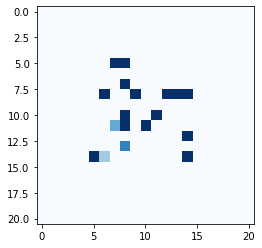

Act_State 1 : [1, 1, 0, 0] Action:  4 1002
Act_State 2 : [0, 1, 0, 0] Action:  3 1011
Act_State 3 : [1, 1, 0, 0] Action:  4 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1001
Fire ID: 1001 goes POP


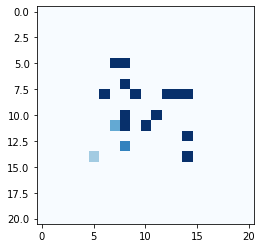

Act_State 1 : [1, 1, 0, 0] Action:  4 1002
Act_State 2 : [1, 1, 0, 0] Action:  4 1011
Act_State 3 : [1, 1, 0, 0] Action:  4 1003
Act_State 4 : [0, 1, 0, 0] Action:  1 1002


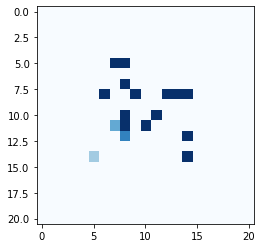

Act_State 1 : [1, 1, 0, 0] Action:  4 1002
Act_State 2 : [1, 0, 0, 0] Action:  5 1011
Act_State 3 : [1, 1, 0, 0] Action:  4 1003
Act_State 4 : [0, 1, 0, 0] Action:  1 1002


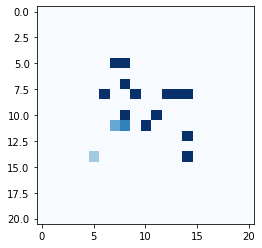

Act_State 1 : [1, 1, 0, 0] Action:  4 1002
Act_State 2 : [1, 0, 0, 0] Action:  5 1011
Act_State 3 : [1, 1, 0, 0] Action:  4 1003
Act_State 4 : [0, 1, 0, 0] Action:  3 1002


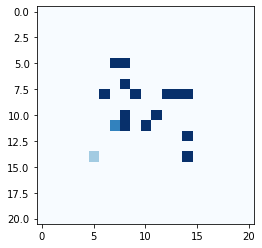

Act_State 1 : [1, 1, 0, 0] Action:  4 1002
Act_State 2 : [1, 0, 0, 0] Action:  5 1011
Act_State 3 : [1, 1, 0, 0] Action:  4 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1002


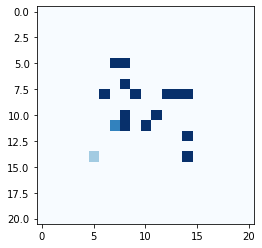

Act_State 1 : [1, 1, 0, 0] Action:  4 1002
Act_State 2 : [1, 0, 0, 0] Action:  5 1011
Act_State 3 : [1, 1, 0, 0] Action:  4 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1002


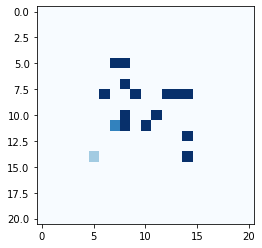

Act_State 1 : [1, 1, 0, 0] Action:  4 1002
Act_State 2 : [1, 0, 0, 0] Action:  5 1011
Act_State 3 : [1, 1, 0, 0] Action:  4 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1002
Fire ID: 1002 goes POP


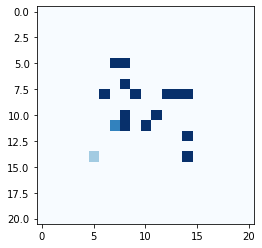

Act_State 1 : [0, 1, 0, 0] Action:  1 1003
Act_State 2 : [1, 0, 0, 0] Action:  5 1011
Act_State 3 : [1, 1, 0, 0] Action:  4 1003
Act_State 4 : [0, 1, 0, 0] Action:  0 1011


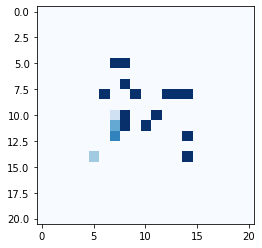

Act_State 1 : [0, 1, 0, 0] Action:  0 1003
Act_State 2 : [1, 0, 1, 0] Action:  4 1011
Act_State 3 : [1, 1, 0, 0] Action:  4 1003
Act_State 4 : [0, 1, 0, 0] Action:  0 1011


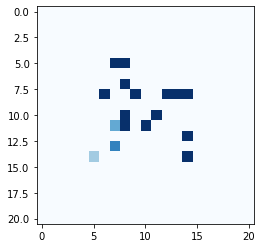

Act_State 1 : [1, 1, 0, 0] Action:  4 1003
Act_State 2 : [1, 0, 1, 0] Action:  4 1011
Act_State 3 : [1, 1, 0, 0] Action:  4 1003
Act_State 4 : [0, 1, 0, 0] Action:  3 1011


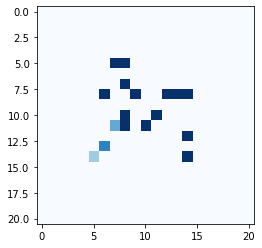

Act_State 1 : [1, 1, 0, 0] Action:  4 1003
Act_State 2 : [1, 0, 1, 0] Action:  4 1011
Act_State 3 : [1, 1, 0, 0] Action:  4 1003
Act_State 4 : [0, 1, 0, 0] Action:  0 1011


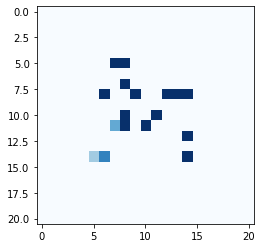

Act_State 1 : [1, 1, 0, 0] Action:  4 1003
Act_State 2 : [1, 0, 1, 0] Action:  4 1011
Act_State 3 : [1, 1, 0, 0] Action:  4 1003
Act_State 4 : [0, 1, 0, 0] Action:  3 1011


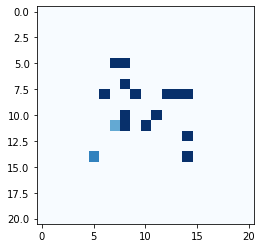

Act_State 1 : [1, 1, 0, 0] Action:  4 1003
Act_State 2 : [1, 0, 1, 0] Action:  4 1011
Act_State 3 : [1, 1, 0, 0] Action:  4 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1011


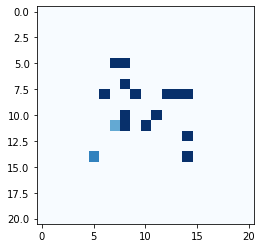

Act_State 1 : [1, 1, 0, 0] Action:  4 1003
Act_State 2 : [1, 0, 1, 0] Action:  4 1011
Act_State 3 : [1, 1, 0, 0] Action:  4 1003
Act_State 4 : [1, 0, 0, 0] Action:  5 1011
Fire ID: 1003 goes POP


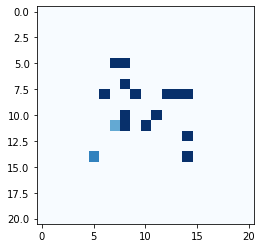

Act_State 1 : [0, 1, 0, 0] Action:  0 1011
Act_State 2 : [1, 0, 1, 0] Action:  4 1011
Act_State 3 : [0, 1, 0, 0] Action:  2 1008
Act_State 4 : [1, 0, 0, 0] Action:  5 1011


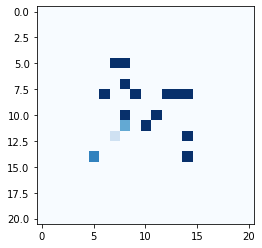

Act_State 1 : [0, 1, 0, 0] Action:  0 1011
Act_State 2 : [1, 0, 1, 0] Action:  4 1011
Act_State 3 : [1, 1, 0, 0] Action:  4 1008
Act_State 4 : [1, 0, 1, 0] Action:  4 1011


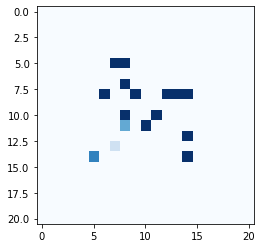

Act_State 1 : [0, 1, 0, 0] Action:  3 1011
Act_State 2 : [1, 0, 1, 0] Action:  4 1011
Act_State 3 : [1, 0, 0, 0] Action:  5 1008
Act_State 4 : [1, 0, 1, 0] Action:  4 1011


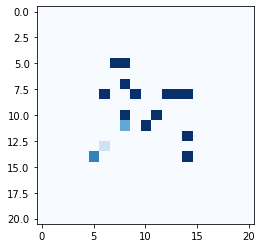

Act_State 1 : [0, 1, 0, 0] Action:  0 1011
Act_State 2 : [1, 0, 1, 0] Action:  4 1011
Act_State 3 : [1, 0, 0, 0] Action:  5 1008
Act_State 4 : [1, 0, 1, 0] Action:  4 1011


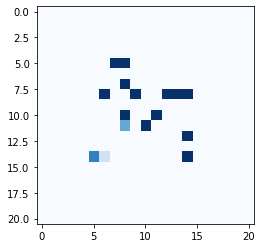

Act_State 1 : [0, 1, 0, 0] Action:  3 1011
Act_State 2 : [1, 0, 1, 0] Action:  4 1011
Act_State 3 : [1, 0, 0, 0] Action:  5 1008
Act_State 4 : [1, 0, 1, 0] Action:  4 1011


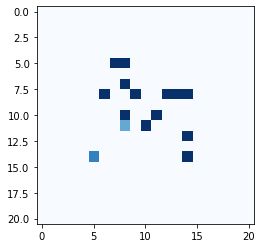

Act_State 1 : [1, 1, 0, 0] Action:  4 1011
Act_State 2 : [1, 0, 1, 0] Action:  4 1011
Act_State 3 : [1, 0, 0, 0] Action:  5 1008
Act_State 4 : [1, 0, 1, 0] Action:  4 1011


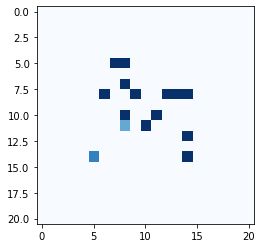

Act_State 1 : [1, 0, 0, 0] Action:  5 1011
Act_State 2 : [1, 0, 1, 0] Action:  4 1011
Act_State 3 : [1, 0, 0, 0] Action:  5 1008
Act_State 4 : [1, 1, 1, 0] Action:  4 1011


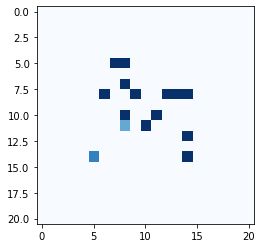

Act_State 1 : [1, 1, 0, 0] Action:  4 1011
Act_State 2 : [1, 1, 1, 0] Action:  4 1011
Act_State 3 : [1, 0, 0, 0] Action:  5 1008
Act_State 4 : [1, 1, 1, 0] Action:  4 1011


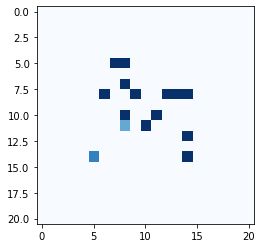

Act_State 1 : [1, 1, 0, 0] Action:  4 1011
Act_State 2 : [1, 1, 1, 0] Action:  4 1011
Act_State 3 : [1, 0, 0, 0] Action:  5 1008
Act_State 4 : [1, 1, 1, 0] Action:  4 1011


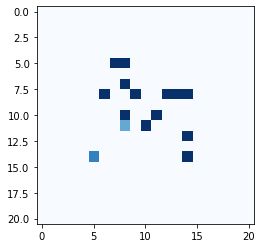

Act_State 1 : [1, 1, 0, 0] Action:  4 1011
Act_State 2 : [1, 1, 1, 0] Action:  4 1011
Act_State 3 : [1, 0, 0, 0] Action:  5 1008
Act_State 4 : [1, 1, 1, 0] Action:  4 1011


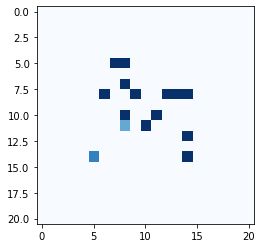

Act_State 1 : [1, 1, 0, 0] Action:  4 1011
Act_State 2 : [1, 1, 1, 0] Action:  4 1011
Act_State 3 : [1, 0, 0, 0] Action:  5 1008
Act_State 4 : [1, 1, 1, 0] Action:  4 1011


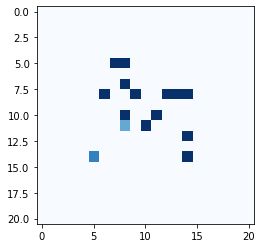

Act_State 1 : [1, 1, 0, 0] Action:  4 1011
Act_State 2 : [1, 1, 1, 0] Action:  4 1011
Act_State 3 : [1, 0, 0, 0] Action:  5 1008
Act_State 4 : [1, 1, 1, 0] Action:  4 1011
Fire ID: 1011 goes POP


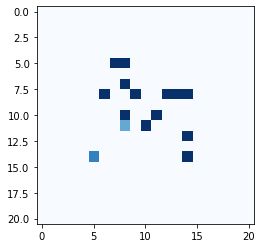

Act_State 1 : [0, 1, 0, 0] Action:  1 1008
Act_State 2 : [0, 1, 0, 0] Action:  1 1008
Act_State 3 : [1, 0, 0, 0] Action:  5 1008
Act_State 4 : [0, 1, 0, 0] Action:  1 1008


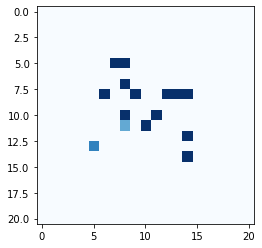

Act_State 1 : [0, 1, 0, 0] Action:  2 1008
Act_State 2 : [0, 1, 0, 0] Action:  2 1008
Act_State 3 : [1, 0, 1, 0] Action:  4 1008
Act_State 4 : [0, 1, 0, 0] Action:  2 1008


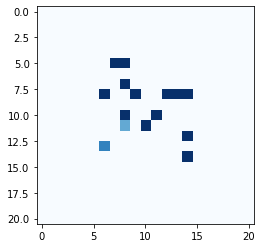

Act_State 1 : [0, 1, 0, 0] Action:  1 1008
Act_State 2 : [0, 1, 0, 0] Action:  1 1008
Act_State 3 : [1, 0, 1, 0] Action:  4 1008
Act_State 4 : [0, 1, 0, 0] Action:  1 1008


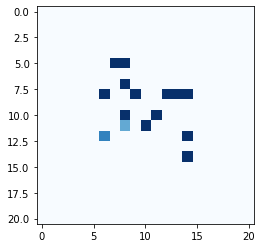

Act_State 1 : [0, 1, 0, 0] Action:  2 1008
Act_State 2 : [0, 1, 0, 0] Action:  2 1008
Act_State 3 : [1, 0, 1, 0] Action:  4 1008
Act_State 4 : [0, 1, 0, 0] Action:  2 1008


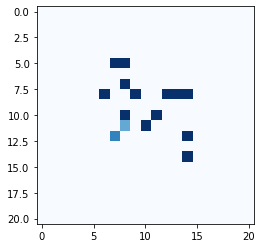

Act_State 1 : [0, 1, 0, 0] Action:  1 1008
Act_State 2 : [0, 1, 0, 0] Action:  1 1008
Act_State 3 : [1, 0, 1, 0] Action:  4 1008
Act_State 4 : [0, 1, 0, 0] Action:  1 1008


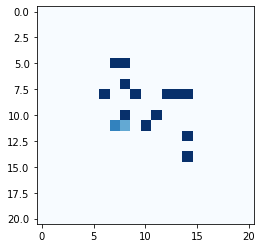

Act_State 1 : [0, 1, 0, 0] Action:  2 1008
Act_State 2 : [0, 1, 0, 0] Action:  2 1008
Act_State 3 : [1, 0, 1, 0] Action:  4 1008
Act_State 4 : [0, 1, 0, 0] Action:  2 1008


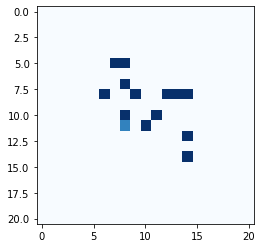

Act_State 1 : [1, 1, 0, 0] Action:  4 1008
Act_State 2 : [1, 1, 0, 0] Action:  4 1008
Act_State 3 : [1, 0, 1, 0] Action:  4 1008
Act_State 4 : [1, 1, 0, 0] Action:  4 1008


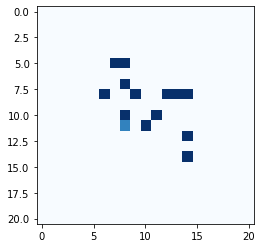

Act_State 1 : [1, 0, 0, 0] Action:  5 1008
Act_State 2 : [1, 0, 0, 0] Action:  5 1008
Act_State 3 : [1, 0, 1, 0] Action:  4 1008
Act_State 4 : [1, 0, 0, 0] Action:  5 1008


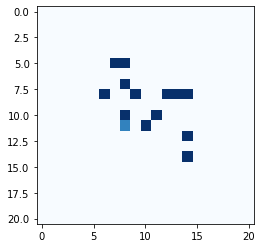

Act_State 1 : [1, 0, 0, 0] Action:  5 1008
Act_State 2 : [1, 0, 0, 0] Action:  5 1008
Act_State 3 : [1, 0, 1, 0] Action:  4 1008
Act_State 4 : [1, 0, 0, 0] Action:  5 1008


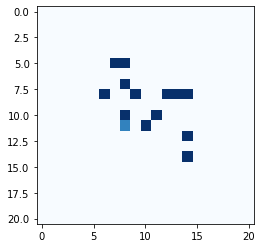

Act_State 1 : [1, 0, 0, 0] Action:  5 1008
Act_State 2 : [1, 0, 0, 0] Action:  5 1008
Act_State 3 : [1, 0, 1, 0] Action:  4 1008
Act_State 4 : [1, 0, 0, 0] Action:  5 1008


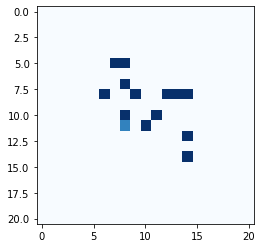

Act_State 1 : [1, 0, 0, 0] Action:  5 1008
Act_State 2 : [1, 0, 0, 0] Action:  5 1008
Act_State 3 : [1, 0, 1, 0] Action:  4 1008
Act_State 4 : [1, 0, 0, 0] Action:  5 1008


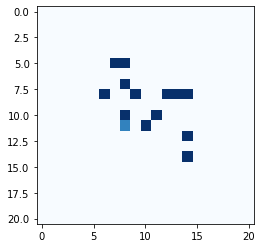

Act_State 1 : [1, 0, 0, 0] Action:  5 1008
Act_State 2 : [1, 1, 0, 0] Action:  4 1008
Act_State 3 : [1, 1, 1, 0] Action:  4 1008
Act_State 4 : [1, 1, 0, 0] Action:  4 1008


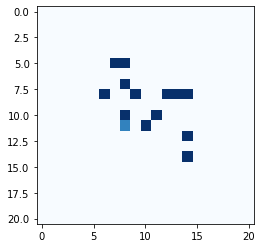

Act_State 1 : [1, 1, 0, 0] Action:  4 1008
Act_State 2 : [1, 1, 0, 0] Action:  4 1008
Act_State 3 : [1, 1, 1, 0] Action:  4 1008
Act_State 4 : [1, 1, 0, 0] Action:  4 1008


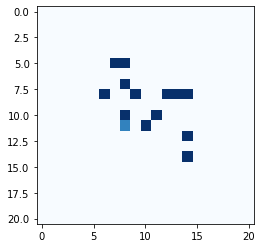

Act_State 1 : [1, 1, 0, 0] Action:  4 1008
Act_State 2 : [1, 1, 0, 0] Action:  4 1008
Act_State 3 : [1, 1, 1, 0] Action:  4 1008
Act_State 4 : [1, 1, 0, 0] Action:  4 1008


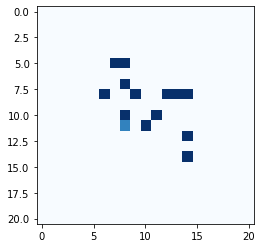

Act_State 1 : [1, 1, 0, 0] Action:  4 1008
Act_State 2 : [1, 1, 0, 0] Action:  4 1008
Act_State 3 : [1, 1, 1, 0] Action:  4 1008
Act_State 4 : [1, 1, 0, 0] Action:  4 1008


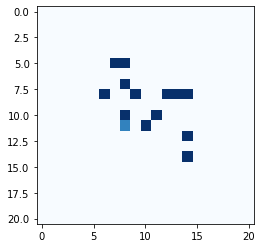

Act_State 1 : [1, 1, 0, 0] Action:  4 1008
Act_State 2 : [1, 1, 0, 0] Action:  4 1008
Act_State 3 : [1, 1, 1, 0] Action:  4 1008
Act_State 4 : [1, 1, 0, 0] Action:  4 1008
Fire ID: 1008 goes POP


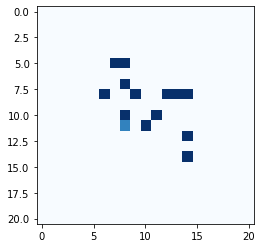

Act_State 1 : [0, 1, 0, 0] Action:  1 1008
Act_State 2 : [0, 1, 0, 0] Action:  1 1018
Act_State 3 : [0, 1, 0, 0] Action:  1 1018
Act_State 4 : [0, 1, 0, 0] Action:  1 1018


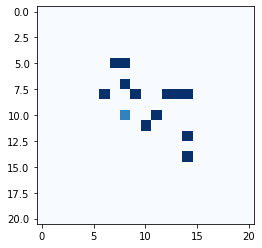

Act_State 1 : [1, 1, 0, 0] Action:  4 1018
Act_State 2 : [1, 1, 0, 0] Action:  4 1018
Act_State 3 : [1, 1, 0, 0] Action:  4 1018
Act_State 4 : [1, 1, 0, 0] Action:  4 1018


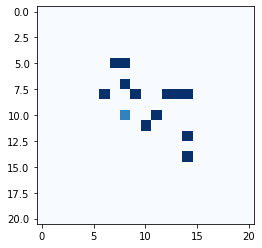

Act_State 1 : [1, 0, 0, 0] Action:  5 1018
Act_State 2 : [1, 0, 0, 0] Action:  5 1018
Act_State 3 : [1, 0, 0, 0] Action:  5 1018
Act_State 4 : [1, 0, 0, 0] Action:  5 1018


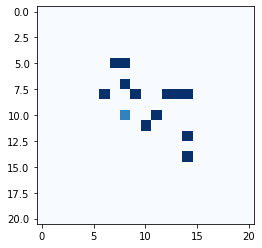

Act_State 1 : [1, 0, 0, 0] Action:  5 1018
Act_State 2 : [1, 0, 0, 0] Action:  5 1018
Act_State 3 : [1, 0, 0, 0] Action:  5 1018
Act_State 4 : [1, 0, 0, 0] Action:  5 1018


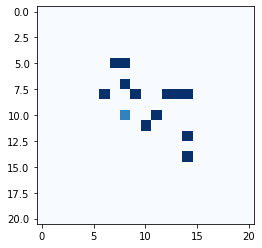

Act_State 1 : [1, 0, 0, 0] Action:  5 1018
Act_State 2 : [1, 0, 0, 0] Action:  5 1018
Act_State 3 : [1, 0, 0, 0] Action:  5 1018
Act_State 4 : [1, 0, 0, 0] Action:  5 1018


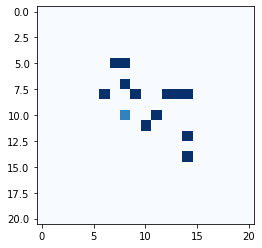

Act_State 1 : [1, 0, 0, 0] Action:  5 1018
Act_State 2 : [1, 0, 0, 0] Action:  5 1018
Act_State 3 : [1, 0, 0, 0] Action:  5 1018
Act_State 4 : [1, 0, 0, 0] Action:  5 1018


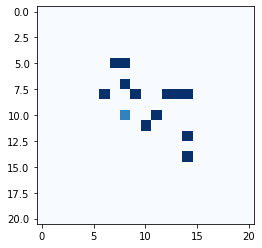

Act_State 1 : [1, 0, 0, 0] Action:  5 1018
Act_State 2 : [1, 0, 0, 0] Action:  5 1018
Act_State 3 : [1, 0, 0, 0] Action:  5 1018
Act_State 4 : [1, 0, 0, 0] Action:  5 1018


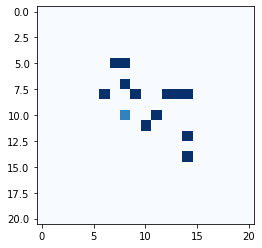

Act_State 1 : [1, 0, 0, 0] Action:  5 1018
Act_State 2 : [1, 0, 0, 0] Action:  5 1018
Act_State 3 : [1, 0, 0, 0] Action:  5 1018
Act_State 4 : [1, 0, 0, 0] Action:  5 1018


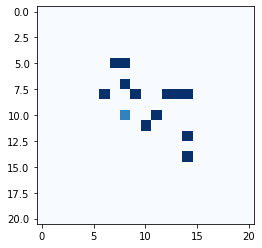

Act_State 1 : [1, 0, 0, 0] Action:  5 1018
Act_State 2 : [1, 0, 0, 0] Action:  5 1018
Act_State 3 : [1, 0, 0, 0] Action:  5 1018
Act_State 4 : [1, 0, 0, 0] Action:  5 1018


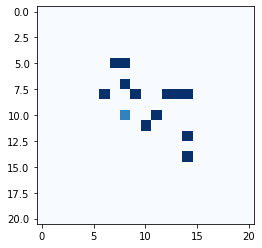

Act_State 1 : [1, 0, 0, 0] Action:  5 1018
Act_State 2 : [1, 0, 0, 0] Action:  5 1018
Act_State 3 : [1, 0, 0, 0] Action:  5 1018
Act_State 4 : [1, 0, 0, 0] Action:  5 1018


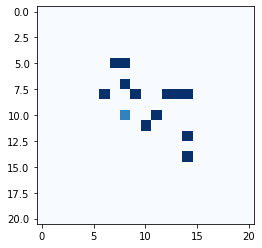

Act_State 1 : [1, 0, 0, 0] Action:  5 1018
Act_State 2 : [1, 0, 0, 0] Action:  5 1018
Act_State 3 : [1, 0, 0, 0] Action:  5 1018
Act_State 4 : [1, 0, 0, 0] Action:  5 1018


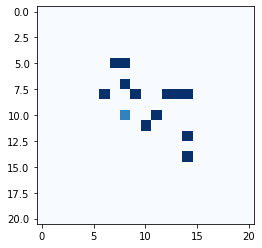

Act_State 1 : [1, 0, 0, 0] Action:  5 1018
Act_State 2 : [1, 0, 0, 0] Action:  5 1018
Act_State 3 : [1, 1, 0, 0] Action:  4 1018
Act_State 4 : [1, 1, 0, 0] Action:  4 1018


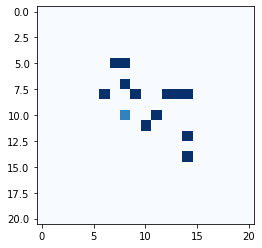

Act_State 1 : [1, 0, 0, 0] Action:  5 1018
Act_State 2 : [1, 1, 0, 0] Action:  4 1018
Act_State 3 : [1, 1, 0, 0] Action:  4 1018
Act_State 4 : [1, 1, 0, 0] Action:  4 1018


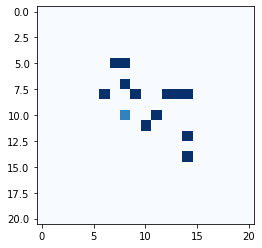

Act_State 1 : [1, 1, 0, 0] Action:  4 1018
Act_State 2 : [1, 1, 0, 0] Action:  4 1018
Act_State 3 : [1, 1, 0, 0] Action:  4 1018
Act_State 4 : [1, 1, 0, 0] Action:  4 1018


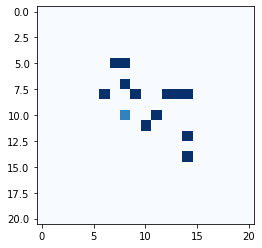

Act_State 1 : [1, 1, 0, 0] Action:  4 1018
Act_State 2 : [1, 1, 0, 0] Action:  4 1018
Act_State 3 : [1, 1, 0, 0] Action:  4 1018
Act_State 4 : [1, 1, 0, 0] Action:  4 1018


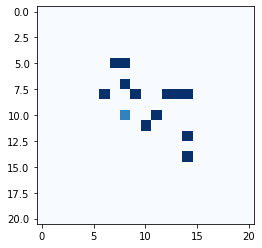

Act_State 1 : [1, 1, 0, 0] Action:  4 1018
Act_State 2 : [1, 1, 0, 0] Action:  4 1018
Act_State 3 : [1, 1, 0, 0] Action:  4 1018
Act_State 4 : [1, 1, 0, 0] Action:  4 1018
Fire ID: 1018 goes POP


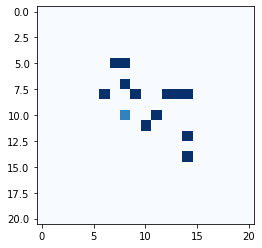

Act_State 1 : [0, 1, 0, 0] Action:  1 1018
Act_State 2 : [0, 1, 0, 0] Action:  1 1004
Act_State 3 : [0, 1, 0, 0] Action:  1 1004
Act_State 4 : [0, 1, 0, 0] Action:  1 1004


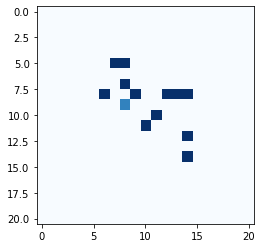

Act_State 1 : [0, 1, 0, 0] Action:  1 1004
Act_State 2 : [0, 1, 0, 0] Action:  1 1004
Act_State 3 : [0, 1, 0, 0] Action:  1 1004
Act_State 4 : [0, 1, 0, 0] Action:  1 1004


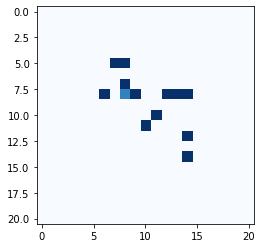

Act_State 1 : [0, 1, 0, 0] Action:  1 1004
Act_State 2 : [0, 1, 0, 0] Action:  1 1004
Act_State 3 : [0, 1, 0, 0] Action:  1 1004
Act_State 4 : [0, 1, 0, 0] Action:  1 1004


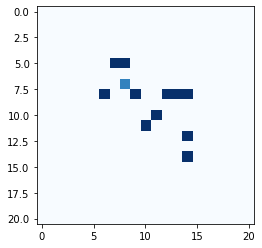

Act_State 1 : [1, 1, 0, 0] Action:  4 1004
Act_State 2 : [1, 1, 0, 0] Action:  4 1004
Act_State 3 : [1, 1, 0, 0] Action:  4 1004
Act_State 4 : [1, 1, 0, 0] Action:  4 1004


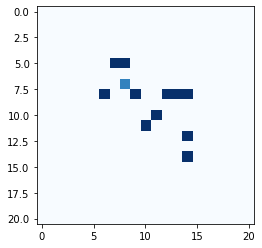

Act_State 1 : [1, 0, 0, 0] Action:  5 1004
Act_State 2 : [1, 0, 0, 0] Action:  5 1004
Act_State 3 : [1, 0, 0, 0] Action:  5 1004
Act_State 4 : [1, 0, 0, 0] Action:  5 1004


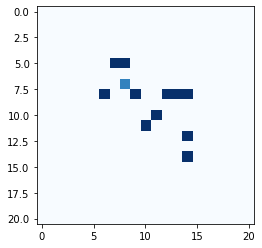

Act_State 1 : [1, 0, 0, 0] Action:  5 1004
Act_State 2 : [1, 0, 0, 0] Action:  5 1004
Act_State 3 : [1, 0, 0, 0] Action:  5 1004
Act_State 4 : [1, 0, 0, 0] Action:  5 1004


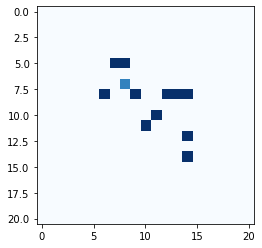

Act_State 1 : [1, 0, 0, 0] Action:  5 1004
Act_State 2 : [1, 0, 0, 0] Action:  5 1004
Act_State 3 : [1, 0, 0, 0] Action:  5 1004
Act_State 4 : [1, 0, 0, 0] Action:  5 1004


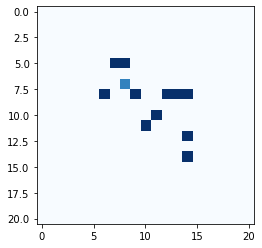

Act_State 1 : [1, 0, 0, 0] Action:  5 1004
Act_State 2 : [1, 0, 0, 0] Action:  5 1004
Act_State 3 : [1, 0, 0, 0] Action:  5 1004
Act_State 4 : [1, 0, 0, 0] Action:  5 1004


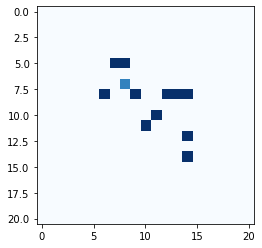

Act_State 1 : [1, 0, 0, 0] Action:  5 1004
Act_State 2 : [1, 0, 0, 0] Action:  5 1004
Act_State 3 : [1, 0, 0, 0] Action:  5 1004
Act_State 4 : [1, 0, 0, 0] Action:  5 1004


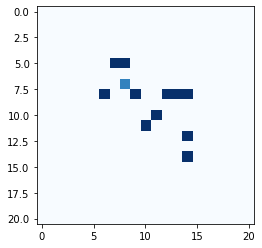

Act_State 1 : [1, 0, 0, 0] Action:  5 1004
Act_State 2 : [1, 0, 0, 0] Action:  5 1004
Act_State 3 : [1, 0, 0, 0] Action:  5 1004
Act_State 4 : [1, 0, 0, 0] Action:  5 1004


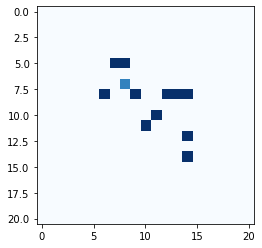

Act_State 1 : [1, 0, 0, 0] Action:  5 1004
Act_State 2 : [1, 0, 0, 0] Action:  5 1004
Act_State 3 : [1, 0, 0, 0] Action:  5 1004
Act_State 4 : [1, 0, 0, 0] Action:  5 1004


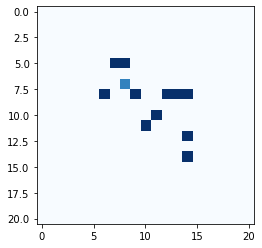

Act_State 1 : [1, 0, 0, 0] Action:  5 1004
Act_State 2 : [1, 0, 0, 0] Action:  5 1004
Act_State 3 : [1, 0, 0, 0] Action:  5 1004
Act_State 4 : [1, 0, 0, 0] Action:  5 1004


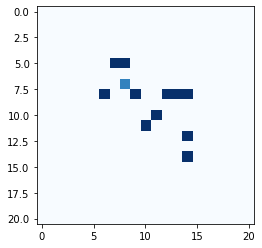

Act_State 1 : [1, 0, 0, 0] Action:  5 1004
Act_State 2 : [1, 0, 0, 0] Action:  5 1004
Act_State 3 : [1, 0, 0, 0] Action:  5 1004
Act_State 4 : [1, 0, 0, 0] Action:  5 1004


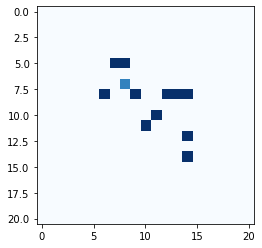

Act_State 1 : [1, 0, 0, 0] Action:  5 1004
Act_State 2 : [1, 0, 0, 0] Action:  5 1004
Act_State 3 : [1, 0, 0, 0] Action:  5 1004
Act_State 4 : [1, 0, 0, 0] Action:  5 1004


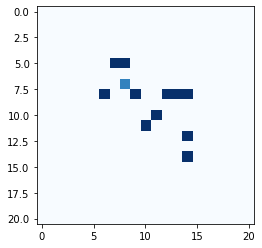

Act_State 1 : [1, 0, 0, 0] Action:  5 1004
Act_State 2 : [1, 0, 0, 0] Action:  5 1004
Act_State 3 : [1, 0, 0, 0] Action:  5 1004
Act_State 4 : [1, 0, 0, 0] Action:  5 1004


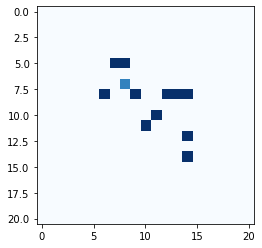

Act_State 1 : [1, 0, 0, 0] Action:  5 1004
Act_State 2 : [1, 0, 0, 0] Action:  5 1004
Act_State 3 : [1, 1, 0, 0] Action:  4 1004
Act_State 4 : [1, 1, 0, 0] Action:  4 1004


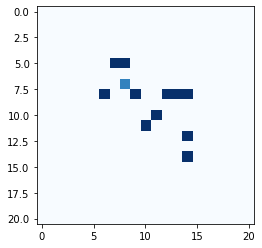

Act_State 1 : [1, 0, 0, 0] Action:  5 1004
Act_State 2 : [1, 1, 0, 0] Action:  4 1004
Act_State 3 : [1, 1, 0, 0] Action:  4 1004
Act_State 4 : [1, 1, 0, 0] Action:  4 1004


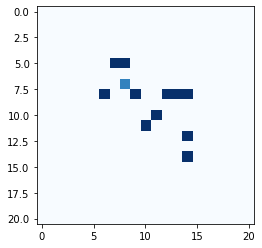

Act_State 1 : [1, 1, 0, 0] Action:  4 1004
Act_State 2 : [1, 1, 0, 0] Action:  4 1004
Act_State 3 : [1, 1, 0, 0] Action:  4 1004
Act_State 4 : [1, 1, 0, 0] Action:  4 1004


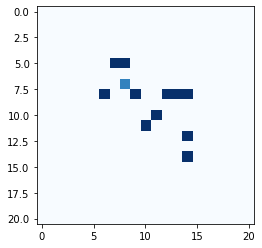

Act_State 1 : [1, 1, 0, 0] Action:  4 1004
Act_State 2 : [1, 1, 0, 0] Action:  4 1004
Act_State 3 : [1, 1, 0, 0] Action:  4 1004
Act_State 4 : [1, 1, 0, 0] Action:  4 1004


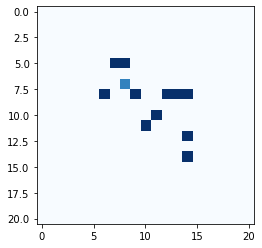

Act_State 1 : [1, 1, 0, 0] Action:  4 1004
Act_State 2 : [1, 1, 0, 0] Action:  4 1004
Act_State 3 : [1, 1, 0, 0] Action:  4 1004
Act_State 4 : [1, 1, 0, 0] Action:  4 1004
Fire ID: 1004 goes POP


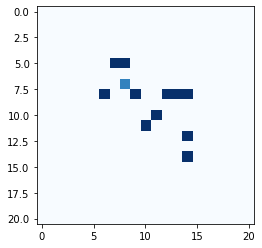

Act_State 1 : [0, 1, 0, 0] Action:  1 1004
Act_State 2 : [0, 1, 0, 0] Action:  0 1013
Act_State 3 : [0, 1, 0, 0] Action:  0 1013
Act_State 4 : [0, 1, 0, 0] Action:  0 1013


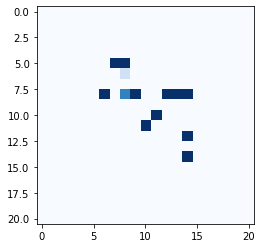

Act_State 1 : [0, 1, 0, 0] Action:  0 1013
Act_State 2 : [0, 1, 0, 0] Action:  2 1013
Act_State 3 : [0, 1, 0, 0] Action:  2 1013
Act_State 4 : [0, 1, 0, 0] Action:  2 1013


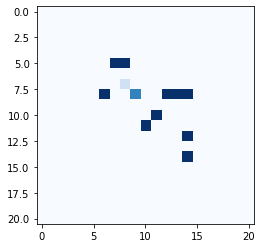

Act_State 1 : [0, 1, 0, 0] Action:  0 1013
Act_State 2 : [1, 1, 0, 0] Action:  4 1013
Act_State 3 : [1, 1, 0, 0] Action:  4 1013
Act_State 4 : [1, 1, 0, 0] Action:  4 1013


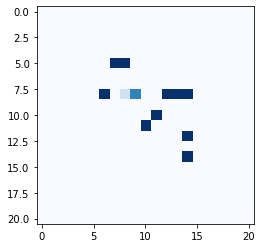

Act_State 1 : [0, 1, 0, 0] Action:  2 1013
Act_State 2 : [1, 0, 0, 0] Action:  5 1013
Act_State 3 : [1, 0, 0, 0] Action:  5 1013
Act_State 4 : [1, 0, 0, 0] Action:  5 1013


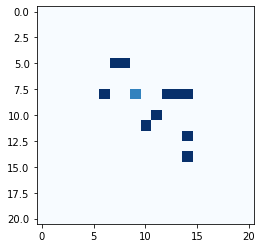

Act_State 1 : [1, 1, 0, 0] Action:  4 1013
Act_State 2 : [1, 0, 0, 0] Action:  5 1013
Act_State 3 : [1, 0, 0, 0] Action:  5 1013
Act_State 4 : [1, 0, 0, 0] Action:  5 1013


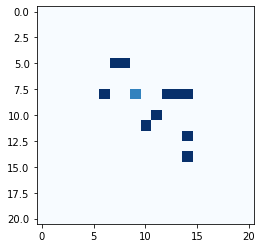

Act_State 1 : [1, 0, 0, 0] Action:  5 1013
Act_State 2 : [1, 0, 0, 0] Action:  5 1013
Act_State 3 : [1, 0, 0, 0] Action:  5 1013
Act_State 4 : [1, 0, 0, 0] Action:  5 1013


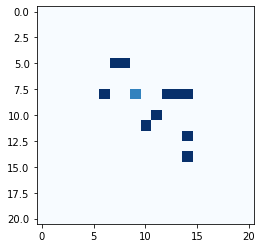

Act_State 1 : [1, 0, 0, 0] Action:  5 1013
Act_State 2 : [1, 0, 0, 0] Action:  5 1013
Act_State 3 : [1, 0, 0, 0] Action:  5 1013
Act_State 4 : [1, 0, 0, 0] Action:  5 1013


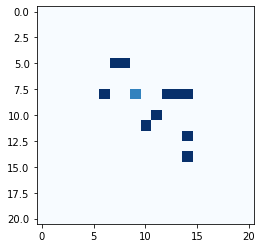

Act_State 1 : [1, 0, 0, 0] Action:  5 1013
Act_State 2 : [1, 0, 0, 0] Action:  5 1013
Act_State 3 : [1, 0, 0, 0] Action:  5 1013
Act_State 4 : [1, 0, 0, 0] Action:  5 1013


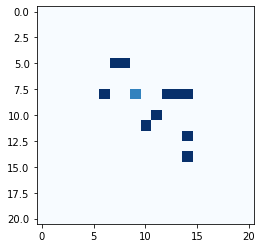

Act_State 1 : [1, 0, 0, 0] Action:  5 1013
Act_State 2 : [1, 0, 0, 0] Action:  5 1013
Act_State 3 : [1, 0, 0, 0] Action:  5 1013
Act_State 4 : [1, 0, 0, 0] Action:  5 1013


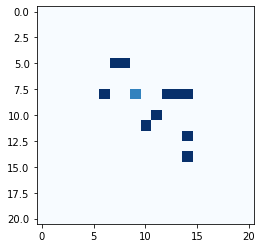

Act_State 1 : [1, 0, 0, 0] Action:  5 1013
Act_State 2 : [1, 0, 0, 0] Action:  5 1013
Act_State 3 : [1, 0, 0, 0] Action:  5 1013
Act_State 4 : [1, 0, 0, 0] Action:  5 1013


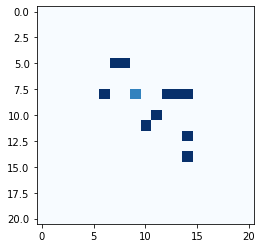

Act_State 1 : [1, 0, 0, 0] Action:  5 1013
Act_State 2 : [1, 0, 0, 0] Action:  5 1013
Act_State 3 : [1, 0, 0, 0] Action:  5 1013
Act_State 4 : [1, 0, 0, 0] Action:  5 1013


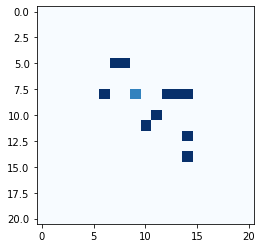

Act_State 1 : [1, 0, 0, 0] Action:  5 1013
Act_State 2 : [1, 0, 0, 0] Action:  5 1013
Act_State 3 : [1, 0, 0, 0] Action:  5 1013
Act_State 4 : [1, 0, 0, 0] Action:  5 1013


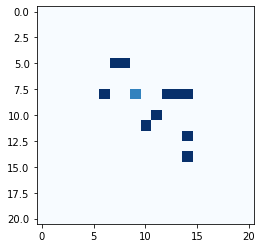

Act_State 1 : [1, 0, 0, 0] Action:  5 1013
Act_State 2 : [1, 0, 0, 0] Action:  5 1013
Act_State 3 : [1, 0, 0, 0] Action:  5 1013
Act_State 4 : [1, 0, 0, 0] Action:  5 1013


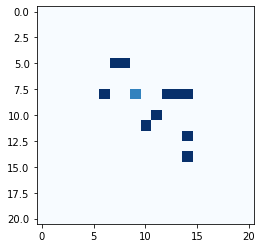

Act_State 1 : [1, 0, 0, 0] Action:  5 1013
Act_State 2 : [1, 0, 0, 0] Action:  5 1013
Act_State 3 : [1, 0, 0, 0] Action:  5 1013
Act_State 4 : [1, 0, 0, 0] Action:  5 1013


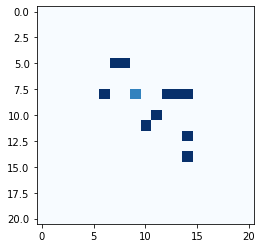

Act_State 1 : [1, 0, 0, 0] Action:  5 1013
Act_State 2 : [1, 0, 0, 0] Action:  5 1013
Act_State 3 : [1, 0, 0, 0] Action:  5 1013
Act_State 4 : [1, 0, 0, 0] Action:  5 1013


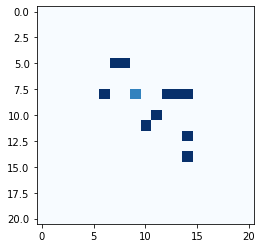

Act_State 1 : [1, 0, 0, 0] Action:  5 1013
Act_State 2 : [1, 0, 0, 0] Action:  5 1013
Act_State 3 : [1, 0, 0, 0] Action:  5 1013
Act_State 4 : [1, 0, 0, 0] Action:  5 1013


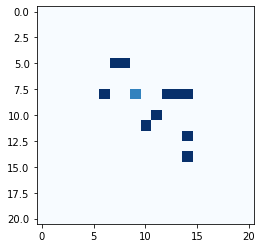

Act_State 1 : [1, 0, 0, 0] Action:  5 1013
Act_State 2 : [1, 0, 0, 0] Action:  5 1013
Act_State 3 : [1, 0, 0, 0] Action:  5 1013
Act_State 4 : [1, 0, 0, 0] Action:  5 1013


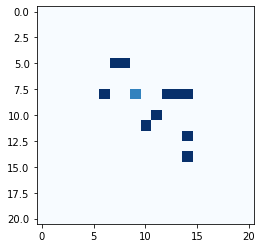

Act_State 1 : [1, 1, 0, 0] Action:  4 1013
Act_State 2 : [1, 1, 0, 0] Action:  4 1013
Act_State 3 : [1, 1, 0, 0] Action:  4 1013
Act_State 4 : [1, 1, 0, 0] Action:  4 1013


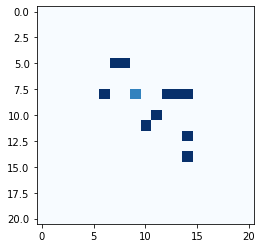

Act_State 1 : [1, 0, 0, 0] Action:  5 1013
Act_State 2 : [1, 0, 0, 0] Action:  5 1013
Act_State 3 : [1, 0, 0, 0] Action:  5 1013
Act_State 4 : [1, 0, 0, 0] Action:  5 1013


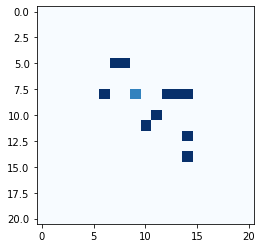

Act_State 1 : [1, 0, 0, 0] Action:  5 1013
Act_State 2 : [1, 1, 0, 0] Action:  4 1013
Act_State 3 : [1, 1, 0, 0] Action:  4 1013
Act_State 4 : [1, 1, 0, 0] Action:  4 1013


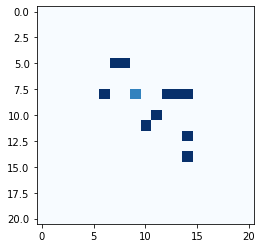

Act_State 1 : [1, 1, 0, 0] Action:  4 1013
Act_State 2 : [1, 1, 0, 0] Action:  4 1013
Act_State 3 : [1, 1, 0, 0] Action:  4 1013
Act_State 4 : [1, 1, 0, 0] Action:  4 1013


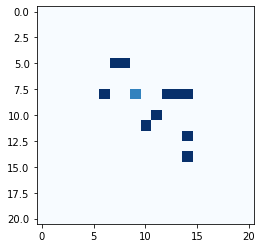

Act_State 1 : [1, 1, 0, 0] Action:  4 1013
Act_State 2 : [1, 1, 0, 0] Action:  4 1013
Act_State 3 : [1, 1, 0, 0] Action:  4 1013
Act_State 4 : [1, 1, 0, 0] Action:  4 1013


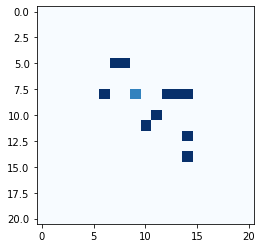

Act_State 1 : [1, 1, 0, 0] Action:  4 1013
Act_State 2 : [1, 1, 0, 0] Action:  4 1013
Act_State 3 : [1, 1, 0, 0] Action:  4 1013
Act_State 4 : [1, 1, 0, 0] Action:  4 1013


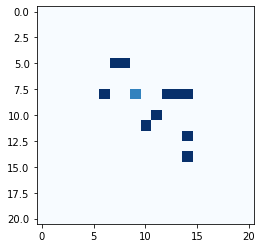

Act_State 1 : [1, 1, 0, 0] Action:  4 1013
Act_State 2 : [1, 1, 0, 0] Action:  4 1013
Act_State 3 : [1, 1, 0, 0] Action:  4 1013
Act_State 4 : [1, 1, 0, 0] Action:  4 1013
Fire ID: 1013 goes POP


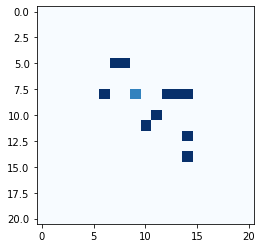

Act_State 1 : [0, 1, 0, 0] Action:  1 1013
Act_State 2 : [0, 1, 0, 0] Action:  3 1009
Act_State 3 : [0, 1, 0, 0] Action:  3 1009
Act_State 4 : [0, 1, 0, 0] Action:  3 1009


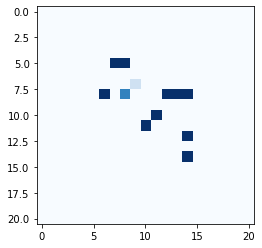

Act_State 1 : [0, 1, 0, 0] Action:  3 1009
Act_State 2 : [0, 1, 0, 0] Action:  3 1009
Act_State 3 : [0, 1, 0, 0] Action:  3 1009
Act_State 4 : [0, 1, 0, 0] Action:  3 1009


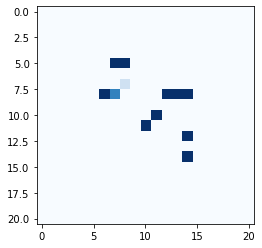

Act_State 1 : [0, 1, 0, 0] Action:  3 1009
Act_State 2 : [0, 1, 0, 0] Action:  3 1009
Act_State 3 : [0, 1, 0, 0] Action:  3 1009
Act_State 4 : [0, 1, 0, 0] Action:  3 1009


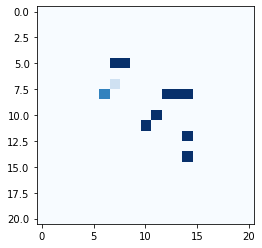

Act_State 1 : [0, 1, 0, 0] Action:  0 1009
Act_State 2 : [1, 1, 0, 0] Action:  4 1009
Act_State 3 : [1, 1, 0, 0] Action:  4 1009
Act_State 4 : [1, 1, 0, 0] Action:  4 1009


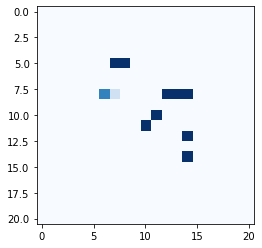

Act_State 1 : [0, 1, 0, 0] Action:  3 1009
Act_State 2 : [1, 0, 0, 0] Action:  5 1009
Act_State 3 : [1, 0, 0, 0] Action:  5 1009
Act_State 4 : [1, 0, 0, 0] Action:  5 1009


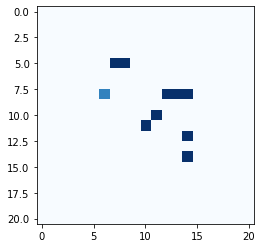

Act_State 1 : [1, 1, 0, 0] Action:  4 1009
Act_State 2 : [1, 0, 0, 0] Action:  5 1009
Act_State 3 : [1, 0, 0, 0] Action:  5 1009
Act_State 4 : [1, 0, 0, 0] Action:  5 1009


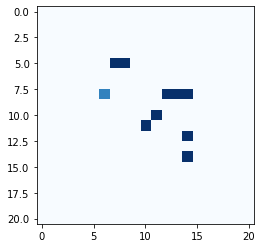

Act_State 1 : [1, 0, 0, 0] Action:  5 1009
Act_State 2 : [1, 0, 0, 0] Action:  5 1009
Act_State 3 : [1, 0, 0, 0] Action:  5 1009
Act_State 4 : [1, 0, 0, 0] Action:  5 1009


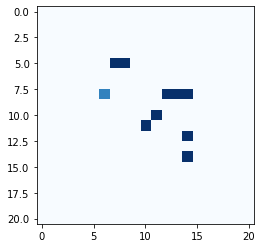

Act_State 1 : [1, 0, 0, 0] Action:  5 1009
Act_State 2 : [1, 0, 0, 0] Action:  5 1009
Act_State 3 : [1, 0, 0, 0] Action:  5 1009
Act_State 4 : [1, 0, 0, 0] Action:  5 1009


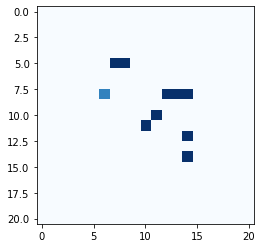

Act_State 1 : [1, 0, 0, 0] Action:  5 1009
Act_State 2 : [1, 0, 0, 0] Action:  5 1009
Act_State 3 : [1, 0, 0, 0] Action:  5 1009
Act_State 4 : [1, 0, 0, 0] Action:  5 1009


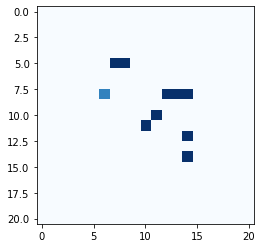

Act_State 1 : [1, 0, 0, 0] Action:  5 1009
Act_State 2 : [1, 0, 0, 0] Action:  5 1009
Act_State 3 : [1, 0, 0, 0] Action:  5 1009
Act_State 4 : [1, 0, 0, 0] Action:  5 1009


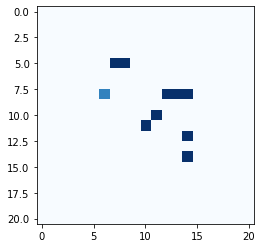

Act_State 1 : [1, 0, 0, 0] Action:  5 1009
Act_State 2 : [1, 0, 0, 0] Action:  5 1009
Act_State 3 : [1, 0, 0, 0] Action:  5 1009
Act_State 4 : [1, 0, 0, 0] Action:  5 1009


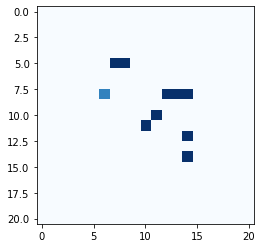

Act_State 1 : [1, 0, 0, 0] Action:  5 1009
Act_State 2 : [1, 0, 0, 0] Action:  5 1009
Act_State 3 : [1, 0, 0, 0] Action:  5 1009
Act_State 4 : [1, 0, 0, 0] Action:  5 1009


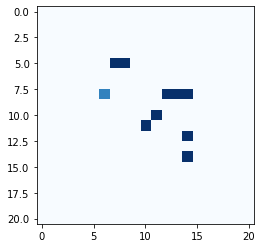

Act_State 1 : [1, 0, 0, 0] Action:  5 1009
Act_State 2 : [1, 0, 0, 0] Action:  5 1009
Act_State 3 : [1, 0, 0, 0] Action:  5 1009
Act_State 4 : [1, 0, 0, 0] Action:  5 1009


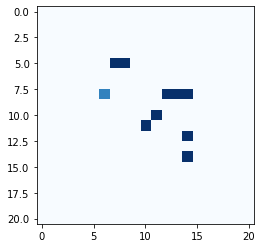

Act_State 1 : [1, 0, 0, 0] Action:  5 1009
Act_State 2 : [1, 0, 0, 0] Action:  5 1009
Act_State 3 : [1, 0, 0, 0] Action:  5 1009
Act_State 4 : [1, 0, 0, 0] Action:  5 1009


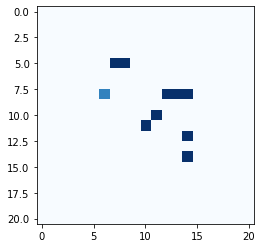

Act_State 1 : [1, 0, 0, 0] Action:  5 1009
Act_State 2 : [1, 0, 0, 0] Action:  5 1009
Act_State 3 : [1, 0, 0, 0] Action:  5 1009
Act_State 4 : [1, 0, 0, 0] Action:  5 1009


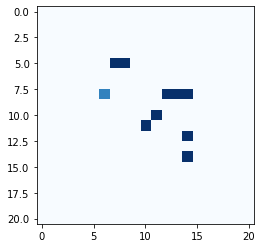

Act_State 1 : [1, 0, 0, 0] Action:  5 1009
Act_State 2 : [1, 0, 0, 0] Action:  5 1009
Act_State 3 : [1, 0, 0, 0] Action:  5 1009
Act_State 4 : [1, 0, 0, 0] Action:  5 1009


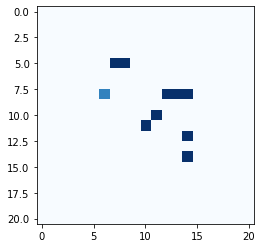

Act_State 1 : [1, 0, 0, 0] Action:  5 1009
Act_State 2 : [1, 0, 0, 0] Action:  5 1009
Act_State 3 : [1, 0, 0, 0] Action:  5 1009
Act_State 4 : [1, 0, 0, 0] Action:  5 1009


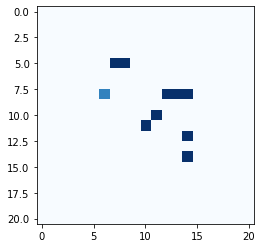

Act_State 1 : [1, 0, 0, 0] Action:  5 1009
Act_State 2 : [1, 0, 0, 0] Action:  5 1009
Act_State 3 : [1, 0, 0, 0] Action:  5 1009
Act_State 4 : [1, 0, 0, 0] Action:  5 1009


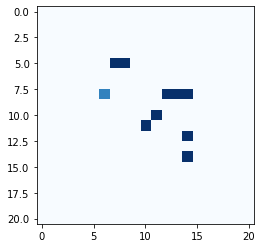

Act_State 1 : [1, 0, 0, 0] Action:  5 1009
Act_State 2 : [1, 0, 0, 0] Action:  5 1009
Act_State 3 : [1, 0, 0, 0] Action:  5 1009
Act_State 4 : [1, 0, 0, 0] Action:  5 1009


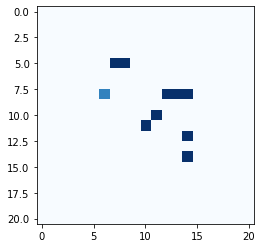

Act_State 1 : [1, 0, 0, 0] Action:  5 1009
Act_State 2 : [1, 0, 0, 0] Action:  5 1009
Act_State 3 : [1, 0, 0, 0] Action:  5 1009
Act_State 4 : [1, 0, 0, 0] Action:  5 1009


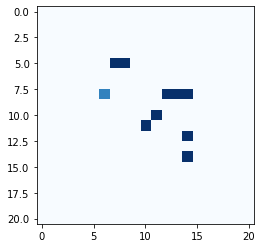

Act_State 1 : [1, 0, 0, 0] Action:  5 1009
Act_State 2 : [1, 0, 0, 0] Action:  5 1009
Act_State 3 : [1, 0, 0, 0] Action:  5 1009
Act_State 4 : [1, 1, 0, 0] Action:  4 1009


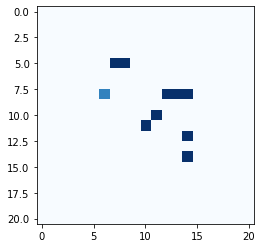

Act_State 1 : [1, 0, 0, 0] Action:  5 1009
Act_State 2 : [1, 1, 0, 0] Action:  4 1009
Act_State 3 : [1, 1, 0, 0] Action:  4 1009
Act_State 4 : [1, 1, 0, 0] Action:  4 1009


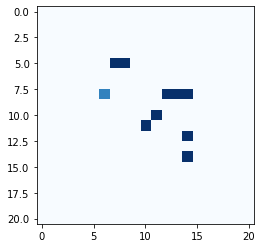

Act_State 1 : [1, 1, 0, 0] Action:  4 1009
Act_State 2 : [1, 1, 0, 0] Action:  4 1009
Act_State 3 : [1, 1, 0, 0] Action:  4 1009
Act_State 4 : [1, 1, 0, 0] Action:  4 1009


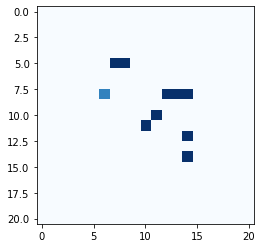

Act_State 1 : [1, 1, 0, 0] Action:  4 1009
Act_State 2 : [1, 1, 0, 0] Action:  4 1009
Act_State 3 : [1, 1, 0, 0] Action:  4 1009
Act_State 4 : [1, 1, 0, 0] Action:  4 1009


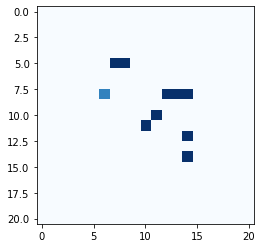

Act_State 1 : [1, 1, 0, 0] Action:  4 1009
Act_State 2 : [1, 1, 0, 0] Action:  4 1009
Act_State 3 : [1, 1, 0, 0] Action:  4 1009
Act_State 4 : [1, 1, 0, 0] Action:  4 1009
Fire ID: 1009 goes POP


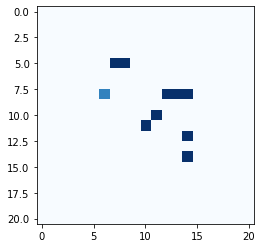

Act_State 1 : [0, 1, 0, 0] Action:  1 1009
Act_State 2 : [0, 1, 0, 0] Action:  1 1015
Act_State 3 : [0, 1, 0, 0] Action:  1 1015
Act_State 4 : [0, 1, 0, 0] Action:  1 1015


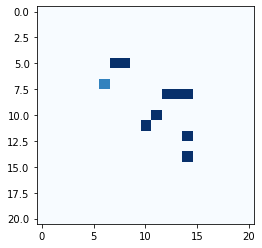

Act_State 1 : [0, 1, 0, 0] Action:  1 1015
Act_State 2 : [0, 1, 0, 0] Action:  1 1015
Act_State 3 : [0, 1, 0, 0] Action:  1 1015
Act_State 4 : [0, 1, 0, 0] Action:  1 1015


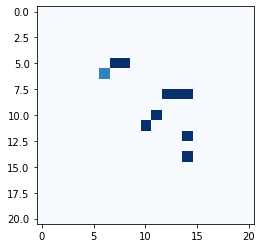

Act_State 1 : [0, 1, 0, 0] Action:  1 1015
Act_State 2 : [0, 1, 0, 0] Action:  1 1015
Act_State 3 : [0, 1, 0, 0] Action:  1 1015
Act_State 4 : [0, 1, 0, 0] Action:  1 1015


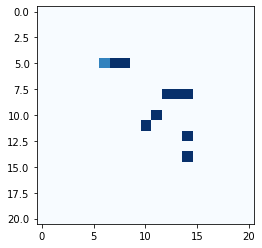

Act_State 1 : [0, 1, 0, 0] Action:  2 1015
Act_State 2 : [0, 1, 0, 0] Action:  2 1015
Act_State 3 : [0, 1, 0, 0] Action:  2 1015
Act_State 4 : [0, 1, 0, 0] Action:  2 1015


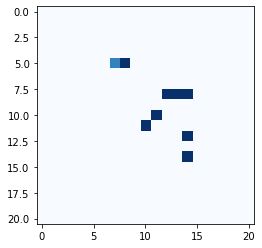

Act_State 1 : [1, 1, 0, 0] Action:  4 1015
Act_State 2 : [1, 1, 0, 0] Action:  4 1015
Act_State 3 : [1, 1, 0, 0] Action:  4 1015
Act_State 4 : [1, 1, 0, 0] Action:  4 1015


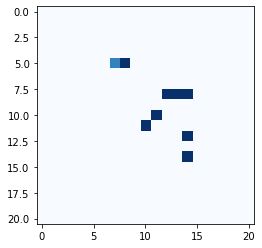

Act_State 1 : [1, 0, 0, 0] Action:  5 1015
Act_State 2 : [1, 0, 0, 0] Action:  5 1015
Act_State 3 : [1, 0, 0, 0] Action:  5 1015
Act_State 4 : [1, 0, 0, 0] Action:  5 1015


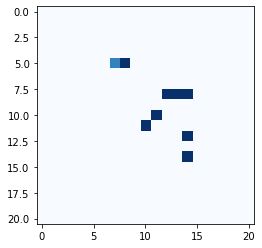

Act_State 1 : [1, 0, 0, 0] Action:  5 1015
Act_State 2 : [1, 0, 0, 0] Action:  5 1015
Act_State 3 : [1, 0, 0, 0] Action:  5 1015
Act_State 4 : [1, 0, 0, 0] Action:  5 1015


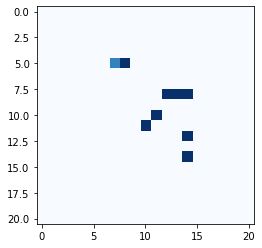

Act_State 1 : [1, 0, 0, 0] Action:  5 1015
Act_State 2 : [1, 0, 0, 0] Action:  5 1015
Act_State 3 : [1, 0, 0, 0] Action:  5 1015
Act_State 4 : [1, 0, 0, 0] Action:  5 1015


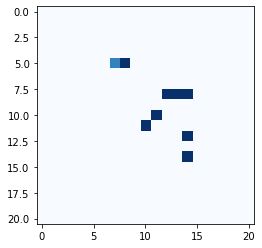

Act_State 1 : [1, 0, 0, 0] Action:  5 1015
Act_State 2 : [1, 0, 0, 0] Action:  5 1015
Act_State 3 : [1, 0, 0, 0] Action:  5 1015
Act_State 4 : [1, 0, 0, 0] Action:  5 1015


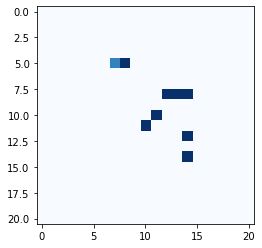

Act_State 1 : [1, 0, 0, 0] Action:  5 1015
Act_State 2 : [1, 0, 0, 0] Action:  5 1015
Act_State 3 : [1, 0, 0, 0] Action:  5 1015
Act_State 4 : [1, 0, 0, 0] Action:  5 1015


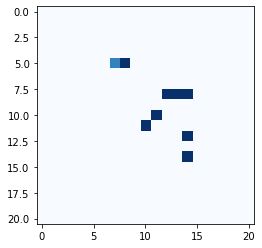

Act_State 1 : [1, 0, 0, 0] Action:  5 1015
Act_State 2 : [1, 0, 0, 0] Action:  5 1015
Act_State 3 : [1, 0, 0, 0] Action:  5 1015
Act_State 4 : [1, 0, 0, 0] Action:  5 1015


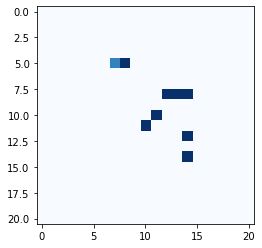

Act_State 1 : [1, 0, 0, 0] Action:  5 1015
Act_State 2 : [1, 0, 0, 0] Action:  5 1015
Act_State 3 : [1, 0, 0, 0] Action:  5 1015
Act_State 4 : [1, 0, 0, 0] Action:  5 1015


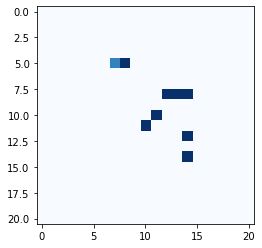

Act_State 1 : [1, 0, 0, 0] Action:  5 1015
Act_State 2 : [1, 0, 0, 0] Action:  5 1015
Act_State 3 : [1, 0, 0, 0] Action:  5 1015
Act_State 4 : [1, 0, 0, 0] Action:  5 1015


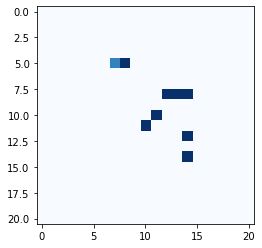

Act_State 1 : [1, 0, 0, 0] Action:  5 1015
Act_State 2 : [1, 0, 0, 0] Action:  5 1015
Act_State 3 : [1, 0, 0, 0] Action:  5 1015
Act_State 4 : [1, 0, 0, 0] Action:  5 1015


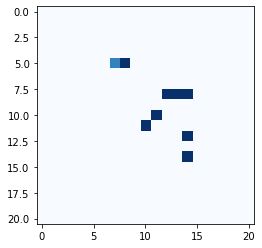

Act_State 1 : [1, 0, 0, 0] Action:  5 1015
Act_State 2 : [1, 0, 0, 0] Action:  5 1015
Act_State 3 : [1, 0, 0, 0] Action:  5 1015
Act_State 4 : [1, 0, 0, 0] Action:  5 1015


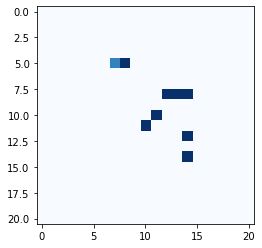

Act_State 1 : [1, 0, 0, 0] Action:  5 1015
Act_State 2 : [1, 0, 0, 0] Action:  5 1015
Act_State 3 : [1, 0, 0, 0] Action:  5 1015
Act_State 4 : [1, 0, 0, 0] Action:  5 1015


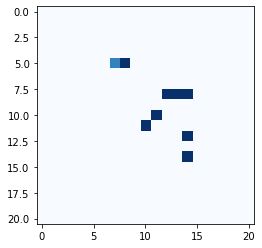

Act_State 1 : [1, 0, 0, 0] Action:  5 1015
Act_State 2 : [1, 0, 0, 0] Action:  5 1015
Act_State 3 : [1, 0, 0, 0] Action:  5 1015
Act_State 4 : [1, 0, 0, 0] Action:  5 1015


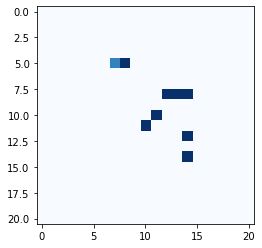

Act_State 1 : [1, 0, 0, 0] Action:  5 1015
Act_State 2 : [1, 0, 0, 0] Action:  5 1015
Act_State 3 : [1, 0, 0, 0] Action:  5 1015
Act_State 4 : [1, 0, 0, 0] Action:  5 1015


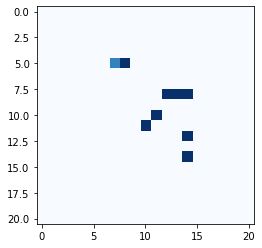

Act_State 1 : [1, 0, 0, 0] Action:  5 1015
Act_State 2 : [1, 0, 0, 0] Action:  5 1015
Act_State 3 : [1, 0, 0, 0] Action:  5 1015
Act_State 4 : [1, 0, 0, 0] Action:  5 1015


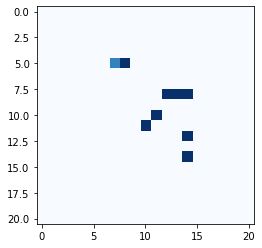

Act_State 1 : [1, 0, 0, 0] Action:  5 1015
Act_State 2 : [1, 0, 0, 0] Action:  5 1015
Act_State 3 : [1, 0, 0, 0] Action:  5 1015
Act_State 4 : [1, 0, 0, 0] Action:  5 1015


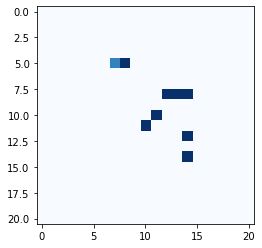

Act_State 1 : [1, 0, 0, 0] Action:  5 1015
Act_State 2 : [1, 0, 0, 0] Action:  5 1015
Act_State 3 : [1, 0, 0, 0] Action:  5 1015
Act_State 4 : [1, 0, 0, 0] Action:  5 1015


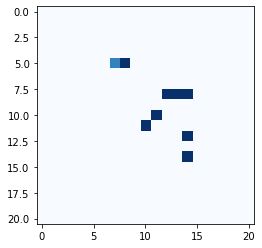

Act_State 1 : [1, 0, 0, 0] Action:  5 1015
Act_State 2 : [1, 0, 0, 0] Action:  5 1015
Act_State 3 : [1, 0, 0, 0] Action:  5 1015
Act_State 4 : [1, 0, 0, 0] Action:  5 1015


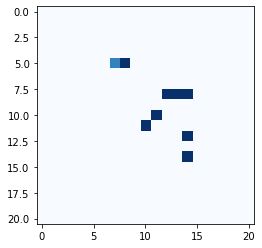

Act_State 1 : [1, 0, 0, 0] Action:  5 1015
Act_State 2 : [1, 0, 0, 0] Action:  5 1015
Act_State 3 : [1, 0, 0, 0] Action:  5 1015
Act_State 4 : [1, 0, 0, 0] Action:  5 1015


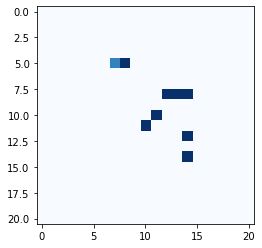

Act_State 1 : [1, 0, 0, 0] Action:  5 1015
Act_State 2 : [1, 0, 0, 0] Action:  5 1015
Act_State 3 : [1, 0, 0, 0] Action:  5 1015
Act_State 4 : [1, 1, 0, 0] Action:  4 1015


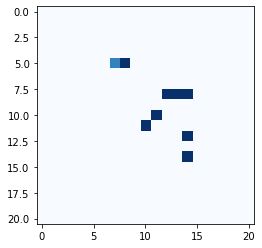

Act_State 1 : [1, 1, 0, 0] Action:  4 1015
Act_State 2 : [1, 1, 0, 0] Action:  4 1015
Act_State 3 : [1, 1, 0, 0] Action:  4 1015
Act_State 4 : [1, 1, 0, 0] Action:  4 1015


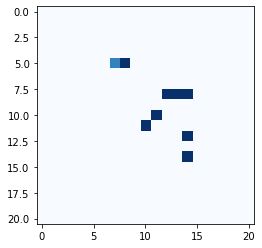

Act_State 1 : [1, 1, 0, 0] Action:  4 1015
Act_State 2 : [1, 1, 0, 0] Action:  4 1015
Act_State 3 : [1, 1, 0, 0] Action:  4 1015
Act_State 4 : [1, 1, 0, 0] Action:  4 1015


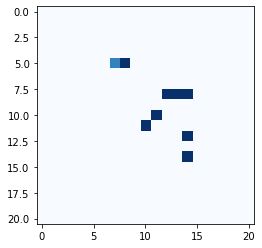

Act_State 1 : [1, 1, 0, 0] Action:  4 1015
Act_State 2 : [1, 1, 0, 0] Action:  4 1015
Act_State 3 : [1, 1, 0, 0] Action:  4 1015
Act_State 4 : [1, 1, 0, 0] Action:  4 1015


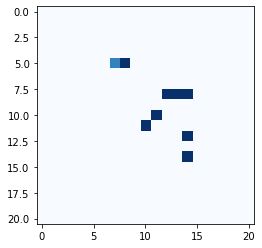

Act_State 1 : [1, 1, 0, 0] Action:  4 1015
Act_State 2 : [1, 1, 0, 0] Action:  4 1015
Act_State 3 : [1, 1, 0, 0] Action:  4 1015
Act_State 4 : [1, 1, 0, 0] Action:  4 1015
Fire ID: 1015 goes POP


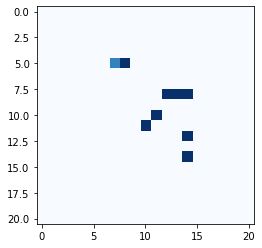

Act_State 1 : [0, 1, 0, 0] Action:  1 1015
Act_State 2 : [0, 1, 0, 0] Action:  2 1017
Act_State 3 : [0, 1, 0, 0] Action:  2 1017
Act_State 4 : [0, 1, 0, 0] Action:  2 1017


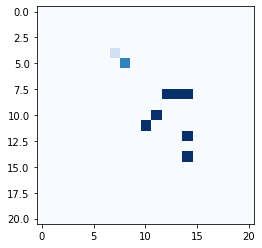

Act_State 1 : [0, 1, 0, 0] Action:  0 1017
Act_State 2 : [1, 1, 0, 0] Action:  4 1017
Act_State 3 : [1, 1, 0, 0] Action:  4 1017
Act_State 4 : [1, 1, 0, 0] Action:  4 1017


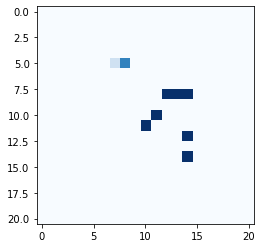

Act_State 1 : [0, 1, 0, 0] Action:  2 1017
Act_State 2 : [1, 0, 0, 0] Action:  5 1017
Act_State 3 : [1, 0, 0, 0] Action:  5 1017
Act_State 4 : [1, 0, 0, 0] Action:  5 1017


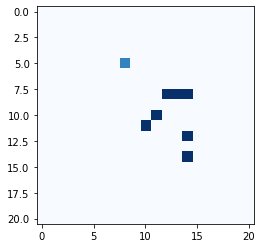

Act_State 1 : [1, 1, 0, 0] Action:  4 1017
Act_State 2 : [1, 0, 0, 0] Action:  5 1017
Act_State 3 : [1, 0, 0, 0] Action:  5 1017
Act_State 4 : [1, 0, 0, 0] Action:  5 1017


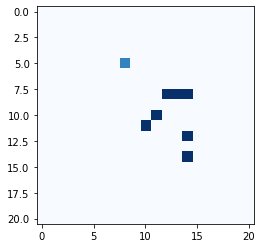

Act_State 1 : [1, 0, 0, 0] Action:  5 1017
Act_State 2 : [1, 0, 0, 0] Action:  5 1017
Act_State 3 : [1, 0, 0, 0] Action:  5 1017
Act_State 4 : [1, 0, 0, 0] Action:  5 1017


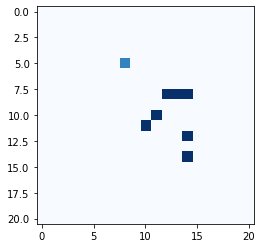

Act_State 1 : [1, 0, 0, 0] Action:  5 1017
Act_State 2 : [1, 0, 0, 0] Action:  5 1017
Act_State 3 : [1, 0, 0, 0] Action:  5 1017
Act_State 4 : [1, 0, 0, 0] Action:  5 1017


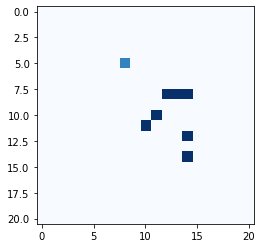

Act_State 1 : [1, 0, 0, 0] Action:  5 1017
Act_State 2 : [1, 0, 0, 0] Action:  5 1017
Act_State 3 : [1, 0, 0, 0] Action:  5 1017
Act_State 4 : [1, 0, 0, 0] Action:  5 1017


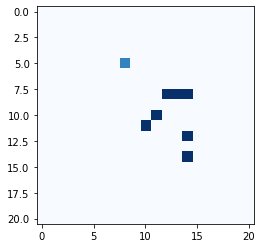

Act_State 1 : [1, 0, 0, 0] Action:  5 1017
Act_State 2 : [1, 0, 0, 0] Action:  5 1017
Act_State 3 : [1, 0, 0, 0] Action:  5 1017
Act_State 4 : [1, 0, 0, 0] Action:  5 1017


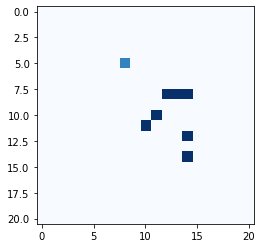

Act_State 1 : [1, 0, 0, 0] Action:  5 1017
Act_State 2 : [1, 0, 0, 0] Action:  5 1017
Act_State 3 : [1, 0, 0, 0] Action:  5 1017
Act_State 4 : [1, 0, 0, 0] Action:  5 1017


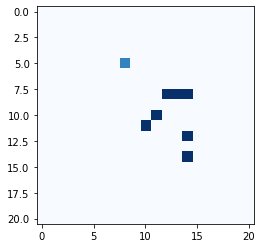

Act_State 1 : [1, 0, 0, 0] Action:  5 1017
Act_State 2 : [1, 0, 0, 0] Action:  5 1017
Act_State 3 : [1, 0, 0, 0] Action:  5 1017
Act_State 4 : [1, 0, 0, 0] Action:  5 1017


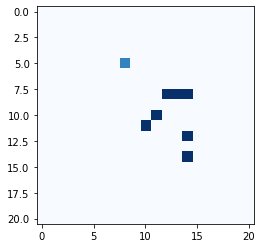

Act_State 1 : [1, 0, 0, 0] Action:  5 1017
Act_State 2 : [1, 0, 0, 0] Action:  5 1017
Act_State 3 : [1, 0, 0, 0] Action:  5 1017
Act_State 4 : [1, 0, 0, 0] Action:  5 1017


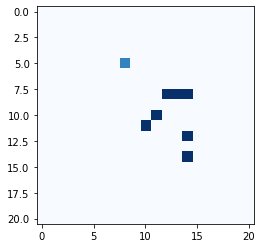

Act_State 1 : [1, 0, 0, 0] Action:  5 1017
Act_State 2 : [1, 0, 0, 0] Action:  5 1017
Act_State 3 : [1, 0, 0, 0] Action:  5 1017
Act_State 4 : [1, 0, 0, 0] Action:  5 1017


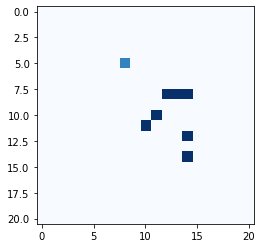

Act_State 1 : [1, 0, 0, 0] Action:  5 1017
Act_State 2 : [1, 0, 0, 0] Action:  5 1017
Act_State 3 : [1, 0, 0, 0] Action:  5 1017
Act_State 4 : [1, 0, 0, 0] Action:  5 1017


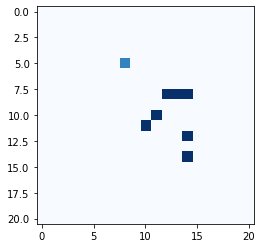

Act_State 1 : [1, 0, 0, 0] Action:  5 1017
Act_State 2 : [1, 0, 0, 0] Action:  5 1017
Act_State 3 : [1, 0, 0, 0] Action:  5 1017
Act_State 4 : [1, 0, 0, 0] Action:  5 1017


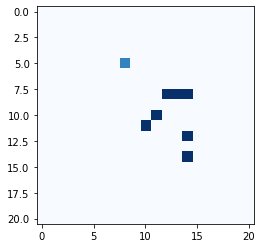

Act_State 1 : [1, 0, 0, 0] Action:  5 1017
Act_State 2 : [1, 0, 0, 0] Action:  5 1017
Act_State 3 : [1, 0, 0, 0] Action:  5 1017
Act_State 4 : [1, 0, 0, 0] Action:  5 1017


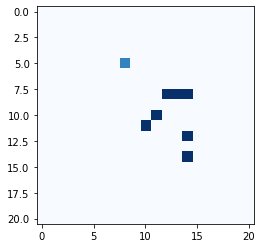

Act_State 1 : [1, 0, 0, 0] Action:  5 1017
Act_State 2 : [1, 0, 0, 0] Action:  5 1017
Act_State 3 : [1, 0, 0, 0] Action:  5 1017
Act_State 4 : [1, 0, 0, 0] Action:  5 1017


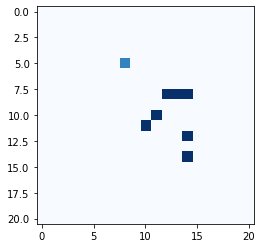

Act_State 1 : [1, 0, 0, 0] Action:  5 1017
Act_State 2 : [1, 0, 0, 0] Action:  5 1017
Act_State 3 : [1, 0, 0, 0] Action:  5 1017
Act_State 4 : [1, 0, 0, 0] Action:  5 1017


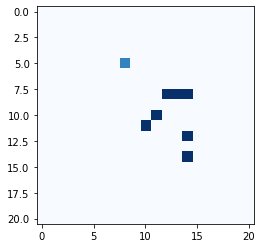

Act_State 1 : [1, 0, 0, 0] Action:  5 1017
Act_State 2 : [1, 0, 0, 0] Action:  5 1017
Act_State 3 : [1, 0, 0, 0] Action:  5 1017
Act_State 4 : [1, 0, 0, 0] Action:  5 1017


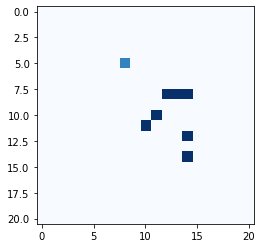

Act_State 1 : [1, 0, 0, 0] Action:  5 1017
Act_State 2 : [1, 0, 0, 0] Action:  5 1017
Act_State 3 : [1, 0, 0, 0] Action:  5 1017
Act_State 4 : [1, 0, 0, 0] Action:  5 1017


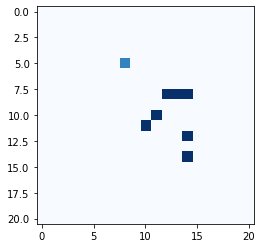

Act_State 1 : [1, 0, 0, 0] Action:  5 1017
Act_State 2 : [1, 0, 0, 0] Action:  5 1017
Act_State 3 : [1, 0, 0, 0] Action:  5 1017
Act_State 4 : [1, 0, 0, 0] Action:  5 1017


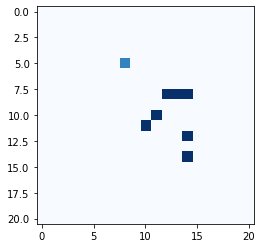

Act_State 1 : [1, 0, 0, 0] Action:  5 1017
Act_State 2 : [1, 0, 0, 0] Action:  5 1017
Act_State 3 : [1, 0, 0, 0] Action:  5 1017
Act_State 4 : [1, 0, 0, 0] Action:  5 1017


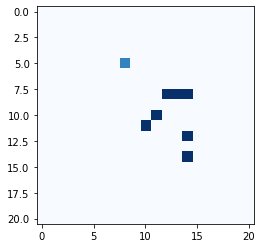

Act_State 1 : [1, 0, 0, 0] Action:  5 1017
Act_State 2 : [1, 0, 0, 0] Action:  5 1017
Act_State 3 : [1, 0, 0, 0] Action:  5 1017
Act_State 4 : [1, 0, 0, 0] Action:  5 1017


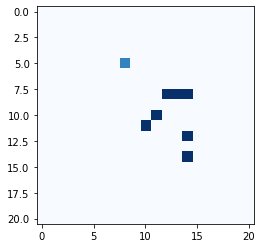

Act_State 1 : [1, 0, 0, 0] Action:  5 1017
Act_State 2 : [1, 0, 0, 0] Action:  5 1017
Act_State 3 : [1, 0, 0, 0] Action:  5 1017
Act_State 4 : [1, 0, 0, 0] Action:  5 1017


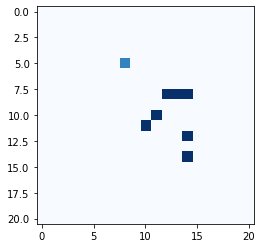

Act_State 1 : [1, 0, 0, 0] Action:  5 1017
Act_State 2 : [1, 0, 0, 0] Action:  5 1017
Act_State 3 : [1, 0, 0, 0] Action:  5 1017
Act_State 4 : [1, 0, 0, 0] Action:  5 1017


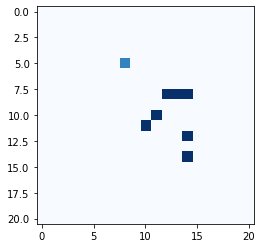

Act_State 1 : [1, 0, 0, 0] Action:  5 1017
Act_State 2 : [1, 0, 0, 0] Action:  5 1017
Act_State 3 : [1, 0, 0, 0] Action:  5 1017
Act_State 4 : [1, 0, 0, 0] Action:  5 1017


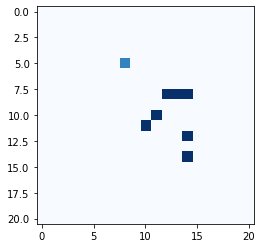

Act_State 1 : [1, 0, 0, 0] Action:  5 1017
Act_State 2 : [1, 1, 0, 0] Action:  4 1017
Act_State 3 : [1, 1, 0, 0] Action:  4 1017
Act_State 4 : [1, 1, 0, 0] Action:  4 1017


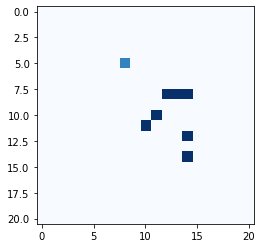

Act_State 1 : [1, 1, 0, 0] Action:  4 1017
Act_State 2 : [1, 1, 0, 0] Action:  4 1017
Act_State 3 : [1, 1, 0, 0] Action:  4 1017
Act_State 4 : [1, 1, 0, 0] Action:  4 1017


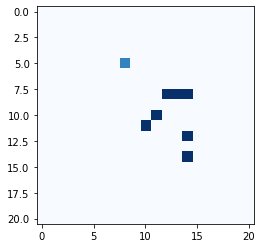

Act_State 1 : [1, 1, 0, 0] Action:  4 1017
Act_State 2 : [1, 1, 0, 0] Action:  4 1017
Act_State 3 : [1, 1, 0, 0] Action:  4 1017
Act_State 4 : [1, 1, 0, 0] Action:  4 1017


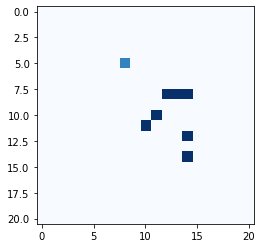

Act_State 1 : [1, 1, 0, 0] Action:  4 1017
Act_State 2 : [1, 1, 0, 0] Action:  4 1017
Act_State 3 : [1, 1, 0, 0] Action:  4 1017
Act_State 4 : [1, 1, 0, 0] Action:  4 1017


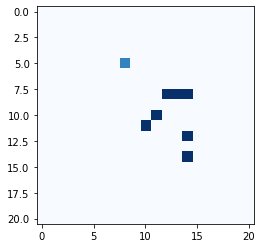

Act_State 1 : [1, 1, 0, 0] Action:  4 1017
Act_State 2 : [1, 1, 0, 0] Action:  4 1017
Act_State 3 : [1, 1, 0, 0] Action:  4 1017
Act_State 4 : [1, 1, 0, 0] Action:  4 1017
Fire ID: 1017 goes POP


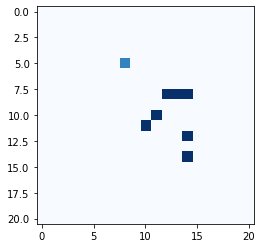

Act_State 1 : [0, 1, 0, 0] Action:  1 1017
Act_State 2 : [0, 1, 0, 0] Action:  2 1014
Act_State 3 : [0, 1, 0, 0] Action:  2 1014
Act_State 4 : [0, 1, 0, 0] Action:  2 1014


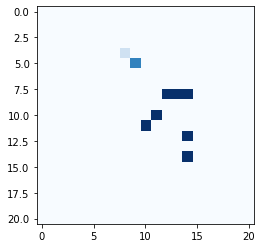

Act_State 1 : [0, 1, 0, 0] Action:  0 1014
Act_State 2 : [0, 1, 0, 0] Action:  0 1014
Act_State 3 : [0, 1, 0, 0] Action:  0 1014
Act_State 4 : [0, 1, 0, 0] Action:  0 1014


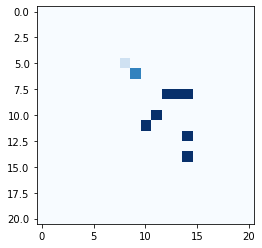

Act_State 1 : [0, 1, 0, 0] Action:  2 1014
Act_State 2 : [0, 1, 0, 0] Action:  2 1014
Act_State 3 : [0, 1, 0, 0] Action:  2 1014
Act_State 4 : [0, 1, 0, 0] Action:  2 1014


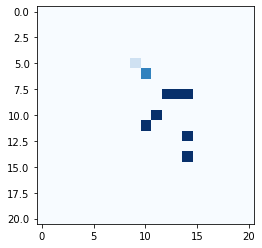

Act_State 1 : [0, 1, 0, 0] Action:  0 1014
Act_State 2 : [0, 1, 0, 0] Action:  0 1014
Act_State 3 : [0, 1, 0, 0] Action:  0 1014
Act_State 4 : [0, 1, 0, 0] Action:  0 1014


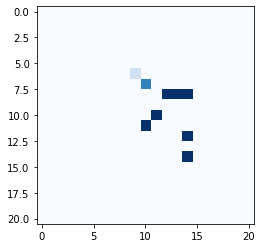

Act_State 1 : [0, 1, 0, 0] Action:  2 1014
Act_State 2 : [0, 1, 0, 0] Action:  2 1014
Act_State 3 : [0, 1, 0, 0] Action:  2 1014
Act_State 4 : [0, 1, 0, 0] Action:  2 1014


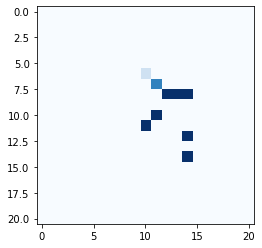

Act_State 1 : [0, 1, 0, 0] Action:  0 1014
Act_State 2 : [0, 1, 0, 0] Action:  0 1014
Act_State 3 : [0, 1, 0, 0] Action:  0 1014
Act_State 4 : [0, 1, 0, 0] Action:  0 1014


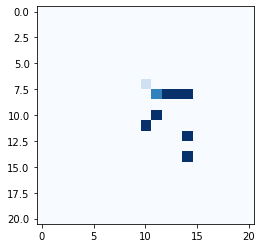

Act_State 1 : [0, 1, 0, 0] Action:  2 1014
Act_State 2 : [0, 1, 0, 0] Action:  2 1014
Act_State 3 : [0, 1, 0, 0] Action:  2 1014
Act_State 4 : [0, 1, 0, 0] Action:  2 1014


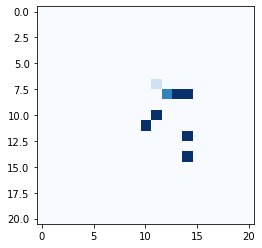

Act_State 1 : [0, 1, 0, 0] Action:  0 1014
Act_State 2 : [1, 1, 0, 0] Action:  4 1014
Act_State 3 : [1, 1, 0, 0] Action:  4 1014
Act_State 4 : [1, 1, 0, 0] Action:  4 1014


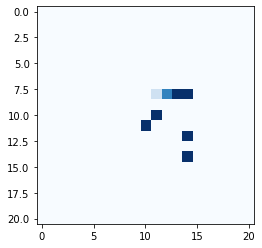

Act_State 1 : [0, 1, 0, 0] Action:  2 1014
Act_State 2 : [1, 0, 0, 0] Action:  5 1014
Act_State 3 : [1, 0, 0, 0] Action:  5 1014
Act_State 4 : [1, 0, 0, 0] Action:  5 1014


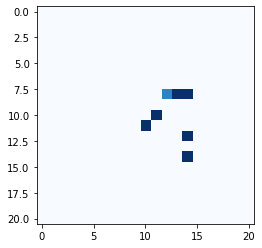

Act_State 1 : [1, 1, 0, 0] Action:  4 1014
Act_State 2 : [1, 0, 0, 0] Action:  5 1014
Act_State 3 : [1, 0, 0, 0] Action:  5 1014
Act_State 4 : [1, 0, 0, 0] Action:  5 1014


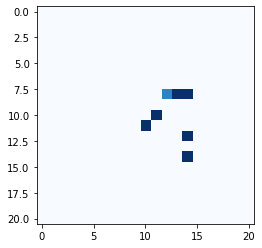

Act_State 1 : [1, 0, 0, 0] Action:  5 1014
Act_State 2 : [1, 0, 0, 0] Action:  5 1014
Act_State 3 : [1, 0, 0, 0] Action:  5 1014
Act_State 4 : [1, 0, 0, 0] Action:  5 1014


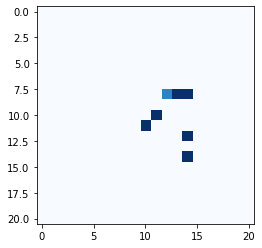

Act_State 1 : [1, 0, 0, 0] Action:  5 1014
Act_State 2 : [1, 0, 0, 0] Action:  5 1014
Act_State 3 : [1, 0, 0, 0] Action:  5 1014
Act_State 4 : [1, 0, 0, 0] Action:  5 1014


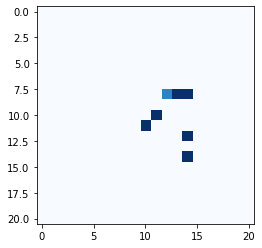

Act_State 1 : [1, 0, 0, 0] Action:  5 1014
Act_State 2 : [1, 0, 0, 0] Action:  5 1014
Act_State 3 : [1, 0, 0, 0] Action:  5 1014
Act_State 4 : [1, 0, 0, 0] Action:  5 1014


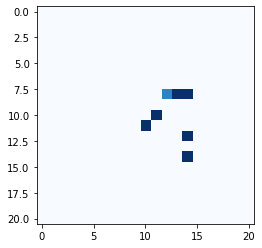

Act_State 1 : [1, 0, 0, 0] Action:  5 1014
Act_State 2 : [1, 0, 0, 0] Action:  5 1014
Act_State 3 : [1, 0, 0, 0] Action:  5 1014
Act_State 4 : [1, 0, 0, 0] Action:  5 1014


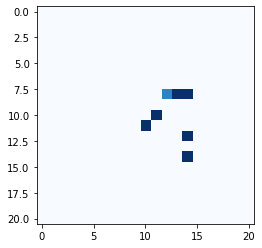

Act_State 1 : [1, 0, 0, 0] Action:  5 1014
Act_State 2 : [1, 0, 0, 0] Action:  5 1014
Act_State 3 : [1, 0, 0, 0] Action:  5 1014
Act_State 4 : [1, 0, 0, 0] Action:  5 1014


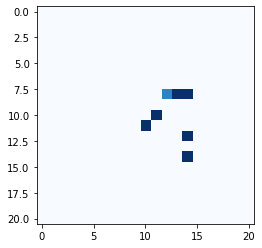

Act_State 1 : [1, 0, 0, 0] Action:  5 1014
Act_State 2 : [1, 0, 0, 0] Action:  5 1014
Act_State 3 : [1, 0, 0, 0] Action:  5 1014
Act_State 4 : [1, 0, 0, 0] Action:  5 1014


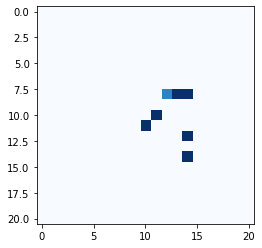

Act_State 1 : [1, 0, 0, 0] Action:  5 1014
Act_State 2 : [1, 0, 0, 0] Action:  5 1014
Act_State 3 : [1, 0, 0, 0] Action:  5 1014
Act_State 4 : [1, 0, 0, 0] Action:  5 1014


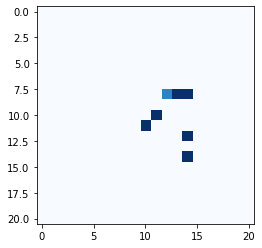

Act_State 1 : [1, 0, 0, 0] Action:  5 1014
Act_State 2 : [1, 0, 0, 0] Action:  5 1014
Act_State 3 : [1, 0, 0, 0] Action:  5 1014
Act_State 4 : [1, 0, 0, 0] Action:  5 1014


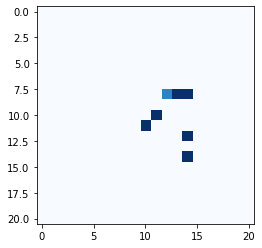

Act_State 1 : [1, 0, 0, 0] Action:  5 1014
Act_State 2 : [1, 0, 0, 0] Action:  5 1014
Act_State 3 : [1, 0, 0, 0] Action:  5 1014
Act_State 4 : [1, 0, 0, 0] Action:  5 1014


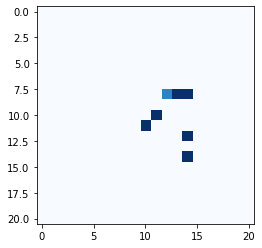

Act_State 1 : [1, 0, 0, 0] Action:  5 1014
Act_State 2 : [1, 0, 0, 0] Action:  5 1014
Act_State 3 : [1, 0, 0, 0] Action:  5 1014
Act_State 4 : [1, 0, 0, 0] Action:  5 1014


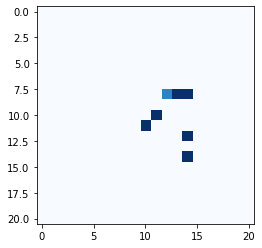

Act_State 1 : [1, 0, 0, 0] Action:  5 1014
Act_State 2 : [1, 0, 0, 0] Action:  5 1014
Act_State 3 : [1, 0, 0, 0] Action:  5 1014
Act_State 4 : [1, 0, 0, 0] Action:  5 1014


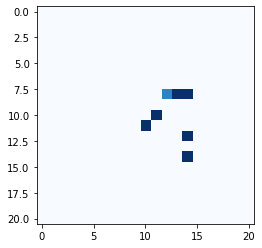

Act_State 1 : [1, 0, 0, 0] Action:  5 1014
Act_State 2 : [1, 0, 0, 0] Action:  5 1014
Act_State 3 : [1, 0, 0, 0] Action:  5 1014
Act_State 4 : [1, 0, 0, 0] Action:  5 1014


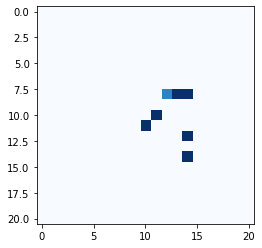

Act_State 1 : [1, 0, 0, 0] Action:  5 1014
Act_State 2 : [1, 0, 0, 0] Action:  5 1014
Act_State 3 : [1, 0, 0, 0] Action:  5 1014
Act_State 4 : [1, 0, 0, 0] Action:  5 1014


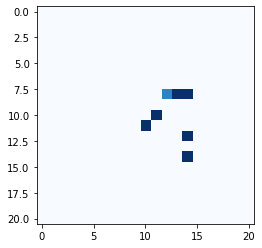

Act_State 1 : [1, 0, 0, 0] Action:  5 1014
Act_State 2 : [1, 0, 0, 0] Action:  5 1014
Act_State 3 : [1, 0, 0, 0] Action:  5 1014
Act_State 4 : [1, 0, 0, 0] Action:  5 1014


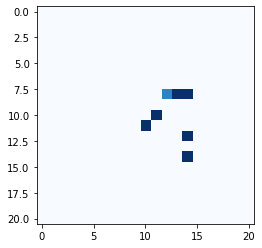

Act_State 1 : [1, 0, 0, 0] Action:  5 1014
Act_State 2 : [1, 0, 0, 0] Action:  5 1014
Act_State 3 : [1, 0, 0, 0] Action:  5 1014
Act_State 4 : [1, 0, 0, 0] Action:  5 1014


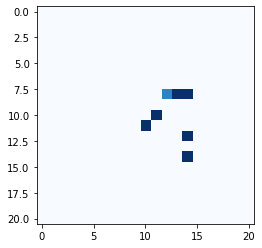

Act_State 1 : [1, 0, 0, 0] Action:  5 1014
Act_State 2 : [1, 0, 0, 0] Action:  5 1014
Act_State 3 : [1, 0, 0, 0] Action:  5 1014
Act_State 4 : [1, 0, 0, 0] Action:  5 1014


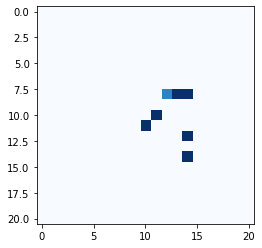

Act_State 1 : [1, 0, 0, 0] Action:  5 1014
Act_State 2 : [1, 0, 0, 0] Action:  5 1014
Act_State 3 : [1, 0, 0, 0] Action:  5 1014
Act_State 4 : [1, 0, 0, 0] Action:  5 1014


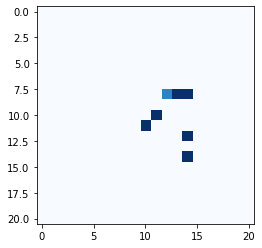

Act_State 1 : [1, 0, 0, 0] Action:  5 1014
Act_State 2 : [1, 0, 0, 0] Action:  5 1014
Act_State 3 : [1, 0, 0, 0] Action:  5 1014
Act_State 4 : [1, 0, 0, 0] Action:  5 1014


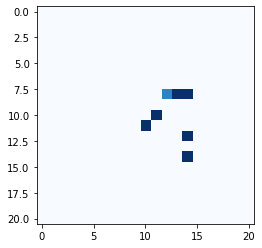

Act_State 1 : [1, 0, 0, 0] Action:  5 1014
Act_State 2 : [1, 0, 0, 0] Action:  5 1014
Act_State 3 : [1, 0, 0, 0] Action:  5 1014
Act_State 4 : [1, 0, 0, 0] Action:  5 1014


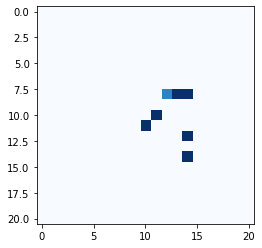

Act_State 1 : [1, 0, 0, 0] Action:  5 1014
Act_State 2 : [1, 0, 0, 0] Action:  5 1014
Act_State 3 : [1, 0, 0, 0] Action:  5 1014
Act_State 4 : [1, 0, 0, 0] Action:  5 1014


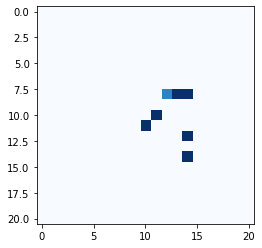

Act_State 1 : [1, 0, 0, 0] Action:  5 1014
Act_State 2 : [1, 0, 0, 0] Action:  5 1014
Act_State 3 : [1, 0, 0, 0] Action:  5 1014
Act_State 4 : [1, 0, 0, 0] Action:  5 1014


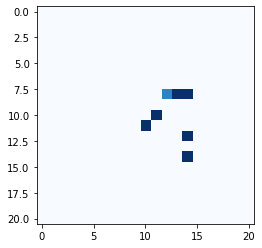

Act_State 1 : [1, 0, 0, 0] Action:  5 1014
Act_State 2 : [1, 0, 0, 0] Action:  5 1014
Act_State 3 : [1, 0, 0, 0] Action:  5 1014
Act_State 4 : [1, 0, 0, 0] Action:  5 1014


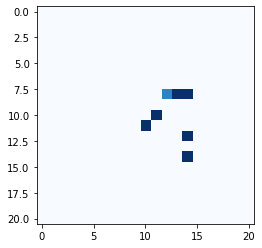

Act_State 1 : [1, 0, 0, 0] Action:  5 1014
Act_State 2 : [1, 0, 0, 0] Action:  5 1014
Act_State 3 : [1, 0, 0, 0] Action:  5 1014
Act_State 4 : [1, 0, 0, 0] Action:  5 1014


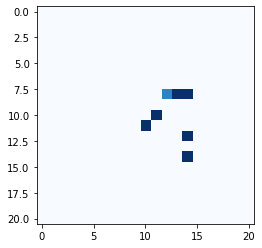

Act_State 1 : [1, 0, 0, 0] Action:  5 1014
Act_State 2 : [1, 0, 0, 0] Action:  5 1014
Act_State 3 : [1, 0, 0, 0] Action:  5 1014
Act_State 4 : [1, 0, 0, 0] Action:  5 1014


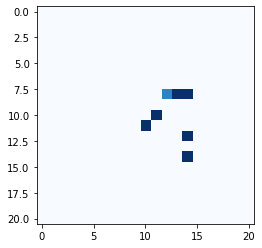

Act_State 1 : [1, 1, 0, 0] Action:  4 1014
Act_State 2 : [1, 1, 0, 0] Action:  4 1014
Act_State 3 : [1, 1, 0, 0] Action:  4 1014
Act_State 4 : [1, 1, 0, 0] Action:  4 1014


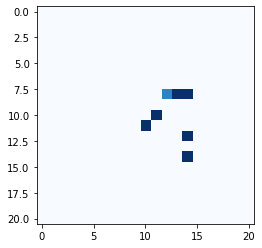

Act_State 1 : [1, 0, 0, 0] Action:  5 1014
Act_State 2 : [1, 0, 0, 0] Action:  5 1014
Act_State 3 : [1, 0, 0, 0] Action:  5 1014
Act_State 4 : [1, 0, 0, 0] Action:  5 1014


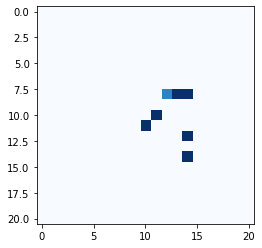

Act_State 1 : [1, 0, 0, 0] Action:  5 1014
Act_State 2 : [1, 1, 0, 0] Action:  4 1014
Act_State 3 : [1, 1, 0, 0] Action:  4 1014
Act_State 4 : [1, 1, 0, 0] Action:  4 1014


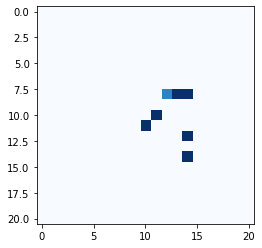

Act_State 1 : [1, 1, 0, 0] Action:  4 1014
Act_State 2 : [1, 1, 0, 0] Action:  4 1014
Act_State 3 : [1, 1, 0, 0] Action:  4 1014
Act_State 4 : [1, 1, 0, 0] Action:  4 1014


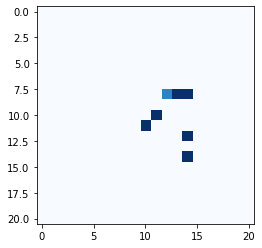

Act_State 1 : [1, 1, 0, 0] Action:  4 1014
Act_State 2 : [1, 1, 0, 0] Action:  4 1014
Act_State 3 : [1, 1, 0, 0] Action:  4 1014
Act_State 4 : [1, 1, 0, 0] Action:  4 1014


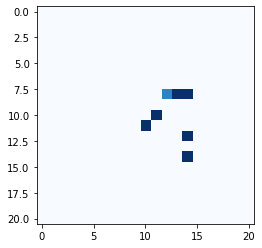

Act_State 1 : [1, 1, 0, 0] Action:  4 1014
Act_State 2 : [1, 1, 0, 0] Action:  4 1014
Act_State 3 : [1, 1, 0, 0] Action:  4 1014
Act_State 4 : [1, 1, 0, 0] Action:  4 1014


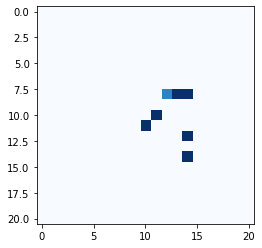

Act_State 1 : [1, 1, 0, 0] Action:  4 1014
Act_State 2 : [1, 1, 0, 0] Action:  4 1014
Act_State 3 : [1, 1, 0, 0] Action:  4 1014
Act_State 4 : [1, 1, 0, 0] Action:  4 1014
Fire ID: 1014 goes POP


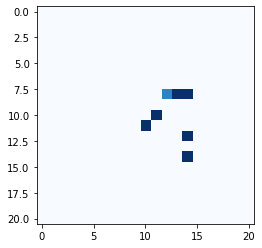

Act_State 1 : [0, 1, 0, 0] Action:  1 1014
Act_State 2 : [0, 1, 0, 0] Action:  2 1007
Act_State 3 : [0, 1, 0, 0] Action:  2 1007
Act_State 4 : [0, 1, 0, 0] Action:  2 1007


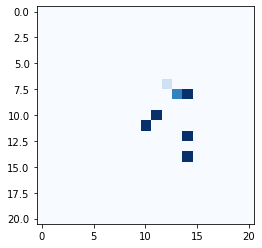

Act_State 1 : [0, 1, 0, 0] Action:  0 1007
Act_State 2 : [1, 1, 0, 0] Action:  4 1007
Act_State 3 : [1, 1, 0, 0] Action:  4 1007
Act_State 4 : [1, 1, 0, 0] Action:  4 1007


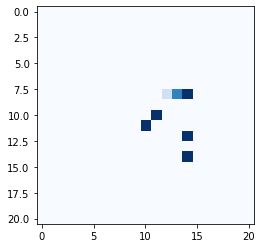

Act_State 1 : [0, 1, 0, 0] Action:  2 1007
Act_State 2 : [1, 0, 0, 0] Action:  5 1007
Act_State 3 : [1, 0, 0, 0] Action:  5 1007
Act_State 4 : [1, 0, 0, 0] Action:  5 1007


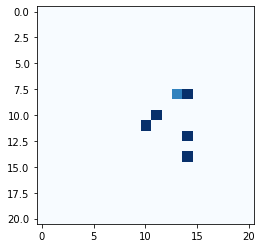

Act_State 1 : [1, 1, 0, 0] Action:  4 1007
Act_State 2 : [1, 0, 0, 0] Action:  5 1007
Act_State 3 : [1, 0, 0, 0] Action:  5 1007
Act_State 4 : [1, 0, 0, 0] Action:  5 1007


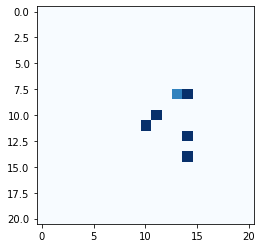

Act_State 1 : [1, 0, 0, 0] Action:  5 1007
Act_State 2 : [1, 0, 0, 0] Action:  5 1007
Act_State 3 : [1, 0, 0, 0] Action:  5 1007
Act_State 4 : [1, 0, 0, 0] Action:  5 1007


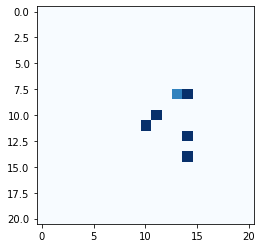

Act_State 1 : [1, 0, 0, 0] Action:  5 1007
Act_State 2 : [1, 0, 0, 0] Action:  5 1007
Act_State 3 : [1, 0, 0, 0] Action:  5 1007
Act_State 4 : [1, 0, 0, 0] Action:  5 1007


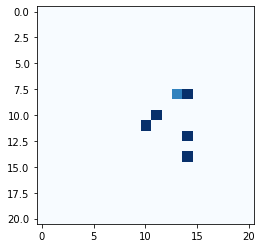

Act_State 1 : [1, 0, 0, 0] Action:  5 1007
Act_State 2 : [1, 0, 0, 0] Action:  5 1007
Act_State 3 : [1, 0, 0, 0] Action:  5 1007
Act_State 4 : [1, 0, 0, 0] Action:  5 1007


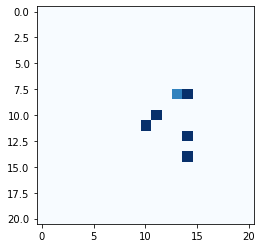

Act_State 1 : [1, 0, 0, 0] Action:  5 1007
Act_State 2 : [1, 0, 0, 0] Action:  5 1007
Act_State 3 : [1, 0, 0, 0] Action:  5 1007
Act_State 4 : [1, 0, 0, 0] Action:  5 1007


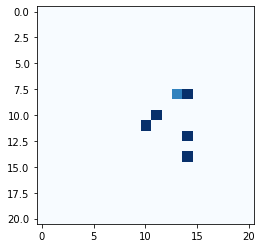

Act_State 1 : [1, 0, 0, 0] Action:  5 1007
Act_State 2 : [1, 0, 0, 0] Action:  5 1007
Act_State 3 : [1, 0, 0, 0] Action:  5 1007
Act_State 4 : [1, 0, 0, 0] Action:  5 1007


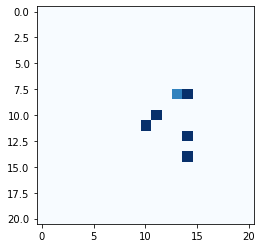

Act_State 1 : [1, 0, 0, 0] Action:  5 1007
Act_State 2 : [1, 0, 0, 0] Action:  5 1007
Act_State 3 : [1, 0, 0, 0] Action:  5 1007
Act_State 4 : [1, 0, 0, 0] Action:  5 1007


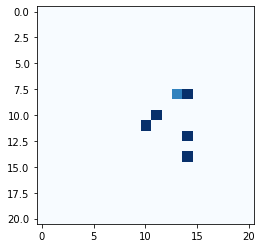

Act_State 1 : [1, 0, 0, 0] Action:  5 1007
Act_State 2 : [1, 0, 0, 0] Action:  5 1007
Act_State 3 : [1, 0, 0, 0] Action:  5 1007
Act_State 4 : [1, 0, 0, 0] Action:  5 1007


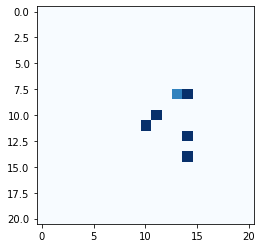

Act_State 1 : [1, 0, 0, 0] Action:  5 1007
Act_State 2 : [1, 0, 0, 0] Action:  5 1007
Act_State 3 : [1, 0, 0, 0] Action:  5 1007
Act_State 4 : [1, 0, 0, 0] Action:  5 1007


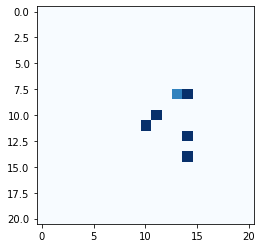

Act_State 1 : [1, 0, 0, 0] Action:  5 1007
Act_State 2 : [1, 0, 0, 0] Action:  5 1007
Act_State 3 : [1, 0, 0, 0] Action:  5 1007
Act_State 4 : [1, 0, 0, 0] Action:  5 1007


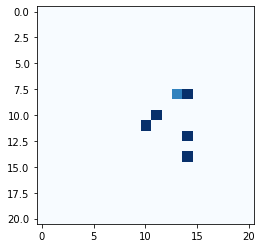

Act_State 1 : [1, 0, 0, 0] Action:  5 1007
Act_State 2 : [1, 0, 0, 0] Action:  5 1007
Act_State 3 : [1, 0, 0, 0] Action:  5 1007
Act_State 4 : [1, 0, 0, 0] Action:  5 1007


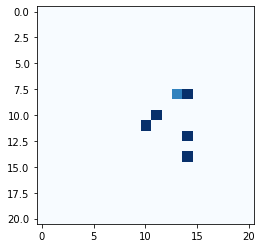

Act_State 1 : [1, 0, 0, 0] Action:  5 1007
Act_State 2 : [1, 0, 0, 0] Action:  5 1007
Act_State 3 : [1, 0, 0, 0] Action:  5 1007
Act_State 4 : [1, 0, 0, 0] Action:  5 1007


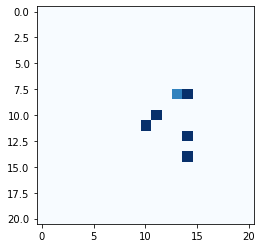

Act_State 1 : [1, 0, 0, 0] Action:  5 1007
Act_State 2 : [1, 0, 0, 0] Action:  5 1007
Act_State 3 : [1, 0, 0, 0] Action:  5 1007
Act_State 4 : [1, 0, 0, 0] Action:  5 1007


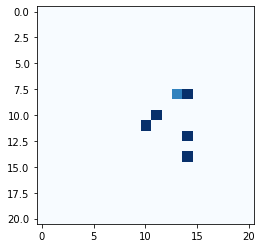

Act_State 1 : [1, 0, 0, 0] Action:  5 1007
Act_State 2 : [1, 0, 0, 0] Action:  5 1007
Act_State 3 : [1, 0, 0, 0] Action:  5 1007
Act_State 4 : [1, 0, 0, 0] Action:  5 1007


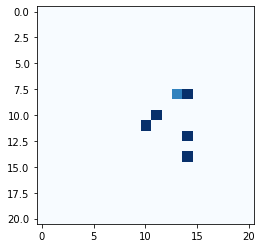

Act_State 1 : [1, 0, 0, 0] Action:  5 1007
Act_State 2 : [1, 0, 0, 0] Action:  5 1007
Act_State 3 : [1, 0, 0, 0] Action:  5 1007
Act_State 4 : [1, 0, 0, 0] Action:  5 1007


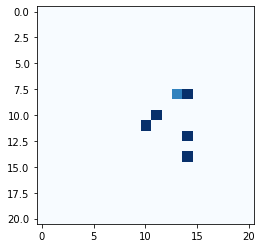

Act_State 1 : [1, 0, 0, 0] Action:  5 1007
Act_State 2 : [1, 0, 0, 0] Action:  5 1007
Act_State 3 : [1, 0, 0, 0] Action:  5 1007
Act_State 4 : [1, 0, 0, 0] Action:  5 1007


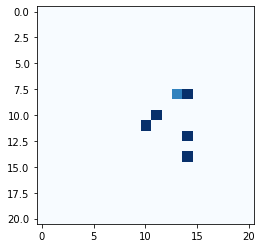

Act_State 1 : [1, 0, 0, 0] Action:  5 1007
Act_State 2 : [1, 0, 0, 0] Action:  5 1007
Act_State 3 : [1, 0, 0, 0] Action:  5 1007
Act_State 4 : [1, 0, 0, 0] Action:  5 1007


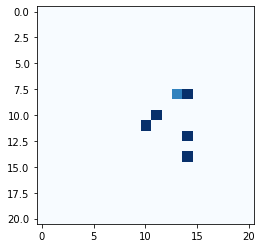

Act_State 1 : [1, 0, 0, 0] Action:  5 1007
Act_State 2 : [1, 0, 0, 0] Action:  5 1007
Act_State 3 : [1, 0, 0, 0] Action:  5 1007
Act_State 4 : [1, 0, 0, 0] Action:  5 1007


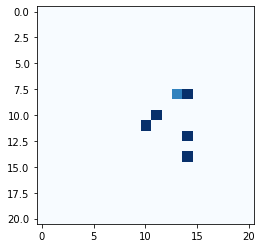

Act_State 1 : [1, 0, 0, 0] Action:  5 1007
Act_State 2 : [1, 0, 0, 0] Action:  5 1007
Act_State 3 : [1, 0, 0, 0] Action:  5 1007
Act_State 4 : [1, 0, 0, 0] Action:  5 1007


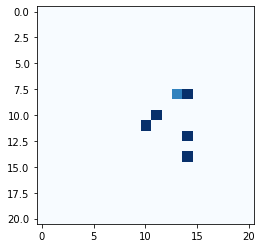

Act_State 1 : [1, 0, 0, 0] Action:  5 1007
Act_State 2 : [1, 0, 0, 0] Action:  5 1007
Act_State 3 : [1, 0, 0, 0] Action:  5 1007
Act_State 4 : [1, 0, 0, 0] Action:  5 1007


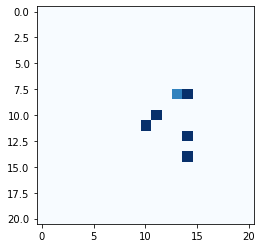

Act_State 1 : [1, 0, 0, 0] Action:  5 1007
Act_State 2 : [1, 0, 0, 0] Action:  5 1007
Act_State 3 : [1, 0, 0, 0] Action:  5 1007
Act_State 4 : [1, 0, 0, 0] Action:  5 1007


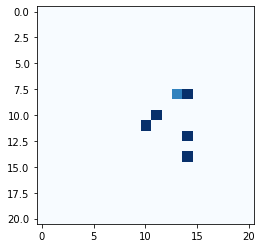

Act_State 1 : [1, 0, 0, 0] Action:  5 1007
Act_State 2 : [1, 0, 0, 0] Action:  5 1007
Act_State 3 : [1, 0, 0, 0] Action:  5 1007
Act_State 4 : [1, 0, 0, 0] Action:  5 1007


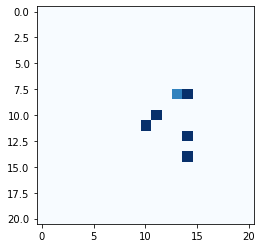

Act_State 1 : [1, 0, 0, 0] Action:  5 1007
Act_State 2 : [1, 0, 0, 0] Action:  5 1007
Act_State 3 : [1, 0, 0, 0] Action:  5 1007
Act_State 4 : [1, 0, 0, 0] Action:  5 1007


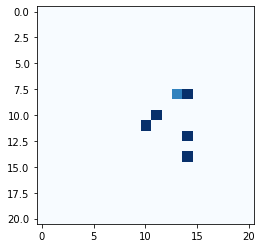

Act_State 1 : [1, 0, 0, 0] Action:  5 1007
Act_State 2 : [1, 0, 0, 0] Action:  5 1007
Act_State 3 : [1, 0, 0, 0] Action:  5 1007
Act_State 4 : [1, 0, 0, 0] Action:  5 1007


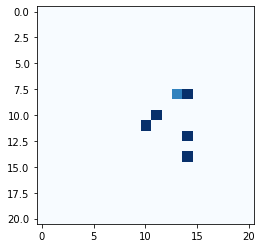

Act_State 1 : [1, 0, 0, 0] Action:  5 1007
Act_State 2 : [1, 0, 0, 0] Action:  5 1007
Act_State 3 : [1, 0, 0, 0] Action:  5 1007
Act_State 4 : [1, 0, 0, 0] Action:  5 1007


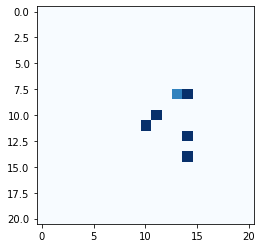

Act_State 1 : [1, 0, 0, 0] Action:  5 1007
Act_State 2 : [1, 0, 0, 0] Action:  5 1007
Act_State 3 : [1, 0, 0, 0] Action:  5 1007
Act_State 4 : [1, 0, 0, 0] Action:  5 1007


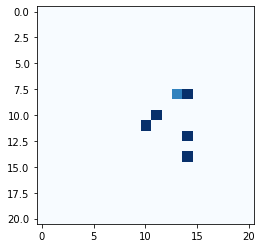

Act_State 1 : [1, 0, 0, 0] Action:  5 1007
Act_State 2 : [1, 0, 0, 0] Action:  5 1007
Act_State 3 : [1, 0, 0, 0] Action:  5 1007
Act_State 4 : [1, 0, 0, 0] Action:  5 1007


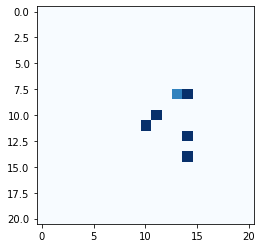

Act_State 1 : [1, 0, 0, 0] Action:  5 1007
Act_State 2 : [1, 0, 0, 0] Action:  5 1007
Act_State 3 : [1, 0, 0, 0] Action:  5 1007
Act_State 4 : [1, 0, 0, 0] Action:  5 1007


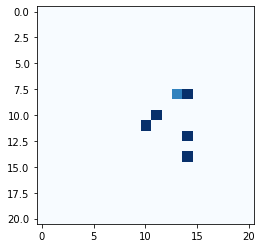

Act_State 1 : [1, 0, 0, 0] Action:  5 1007
Act_State 2 : [1, 1, 0, 0] Action:  4 1007
Act_State 3 : [1, 1, 0, 0] Action:  4 1007
Act_State 4 : [1, 1, 0, 0] Action:  4 1007


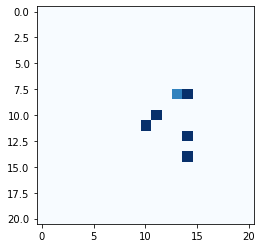

Act_State 1 : [1, 0, 0, 0] Action:  5 1007
Act_State 2 : [1, 1, 0, 0] Action:  4 1007
Act_State 3 : [1, 1, 0, 0] Action:  4 1007
Act_State 4 : [1, 1, 0, 0] Action:  4 1007


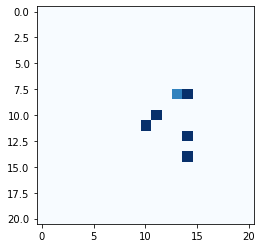

Act_State 1 : [1, 1, 0, 0] Action:  4 1007
Act_State 2 : [1, 1, 0, 0] Action:  4 1007
Act_State 3 : [1, 1, 0, 0] Action:  4 1007
Act_State 4 : [1, 1, 0, 0] Action:  4 1007


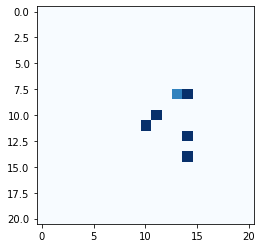

Act_State 1 : [1, 1, 0, 0] Action:  4 1007
Act_State 2 : [1, 1, 0, 0] Action:  4 1007
Act_State 3 : [1, 1, 0, 0] Action:  4 1007
Act_State 4 : [1, 1, 0, 0] Action:  4 1007


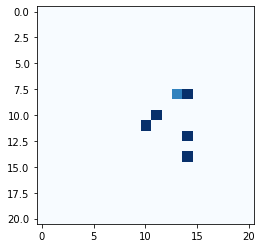

Act_State 1 : [1, 1, 0, 0] Action:  4 1007
Act_State 2 : [1, 1, 0, 0] Action:  4 1007
Act_State 3 : [1, 1, 0, 0] Action:  4 1007
Act_State 4 : [1, 1, 0, 0] Action:  4 1007
Fire ID: 1007 goes POP


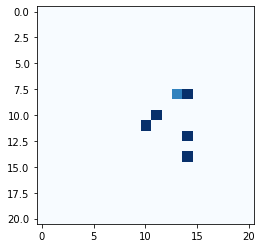

Act_State 1 : [0, 1, 0, 0] Action:  1 1007
Act_State 2 : [0, 1, 0, 0] Action:  2 1016
Act_State 3 : [0, 1, 0, 0] Action:  2 1016
Act_State 4 : [0, 1, 0, 0] Action:  2 1016


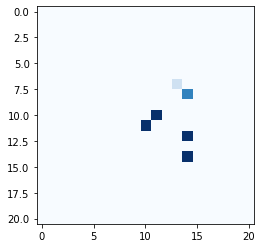

Act_State 1 : [0, 1, 0, 0] Action:  0 1016
Act_State 2 : [1, 1, 0, 0] Action:  4 1016
Act_State 3 : [1, 1, 0, 0] Action:  4 1016
Act_State 4 : [1, 1, 0, 0] Action:  4 1016


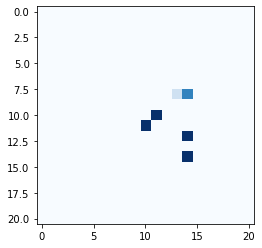

Act_State 1 : [0, 1, 0, 0] Action:  2 1016
Act_State 2 : [1, 0, 0, 0] Action:  5 1016
Act_State 3 : [1, 0, 0, 0] Action:  5 1016
Act_State 4 : [1, 0, 0, 0] Action:  5 1016


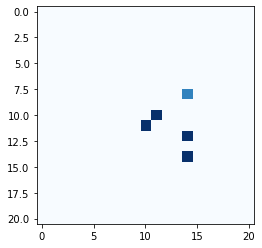

Act_State 1 : [1, 1, 0, 0] Action:  4 1016
Act_State 2 : [1, 0, 0, 0] Action:  5 1016
Act_State 3 : [1, 0, 0, 0] Action:  5 1016
Act_State 4 : [1, 0, 0, 0] Action:  5 1016


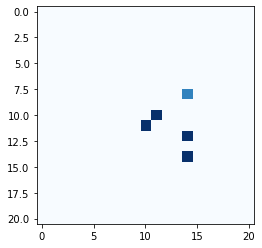

Act_State 1 : [1, 0, 0, 0] Action:  5 1016
Act_State 2 : [1, 0, 0, 0] Action:  5 1016
Act_State 3 : [1, 0, 0, 0] Action:  5 1016
Act_State 4 : [1, 0, 0, 0] Action:  5 1016


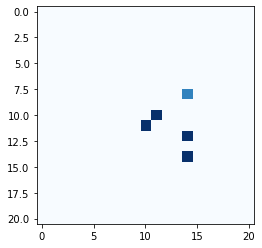

Act_State 1 : [1, 0, 0, 0] Action:  5 1016
Act_State 2 : [1, 0, 0, 0] Action:  5 1016
Act_State 3 : [1, 0, 0, 0] Action:  5 1016
Act_State 4 : [1, 0, 0, 0] Action:  5 1016


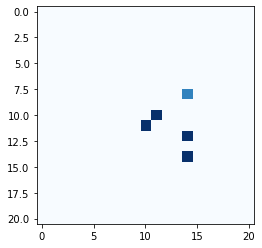

Act_State 1 : [1, 0, 0, 0] Action:  5 1016
Act_State 2 : [1, 0, 0, 0] Action:  5 1016
Act_State 3 : [1, 0, 0, 0] Action:  5 1016
Act_State 4 : [1, 0, 0, 0] Action:  5 1016


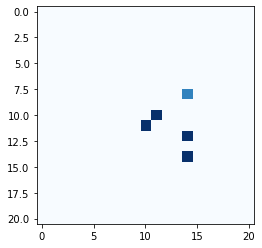

Act_State 1 : [1, 0, 0, 0] Action:  5 1016
Act_State 2 : [1, 0, 0, 0] Action:  5 1016
Act_State 3 : [1, 0, 0, 0] Action:  5 1016
Act_State 4 : [1, 0, 0, 0] Action:  5 1016


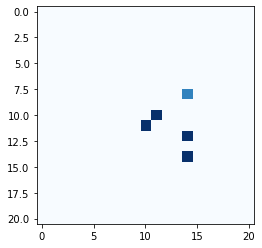

Act_State 1 : [1, 0, 0, 0] Action:  5 1016
Act_State 2 : [1, 0, 0, 0] Action:  5 1016
Act_State 3 : [1, 0, 0, 0] Action:  5 1016
Act_State 4 : [1, 0, 0, 0] Action:  5 1016


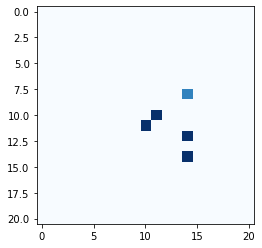

Act_State 1 : [1, 0, 0, 0] Action:  5 1016
Act_State 2 : [1, 0, 0, 0] Action:  5 1016
Act_State 3 : [1, 0, 0, 0] Action:  5 1016
Act_State 4 : [1, 0, 0, 0] Action:  5 1016


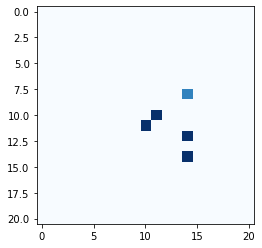

Act_State 1 : [1, 0, 0, 0] Action:  5 1016
Act_State 2 : [1, 0, 0, 0] Action:  5 1016
Act_State 3 : [1, 0, 0, 0] Action:  5 1016
Act_State 4 : [1, 0, 0, 0] Action:  5 1016


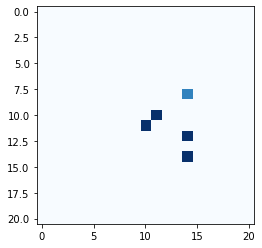

Act_State 1 : [1, 0, 0, 0] Action:  5 1016
Act_State 2 : [1, 0, 0, 0] Action:  5 1016
Act_State 3 : [1, 0, 0, 0] Action:  5 1016
Act_State 4 : [1, 0, 0, 0] Action:  5 1016


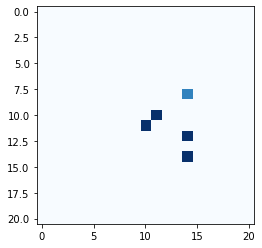

Act_State 1 : [1, 0, 0, 0] Action:  5 1016
Act_State 2 : [1, 0, 0, 0] Action:  5 1016
Act_State 3 : [1, 0, 0, 0] Action:  5 1016
Act_State 4 : [1, 0, 0, 0] Action:  5 1016


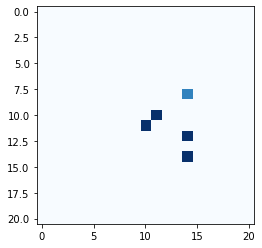

Act_State 1 : [1, 0, 0, 0] Action:  5 1016
Act_State 2 : [1, 0, 0, 0] Action:  5 1016
Act_State 3 : [1, 0, 0, 0] Action:  5 1016
Act_State 4 : [1, 0, 0, 0] Action:  5 1016


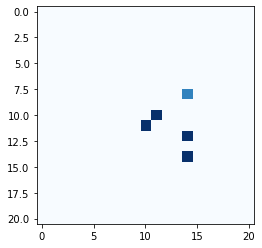

Act_State 1 : [1, 0, 0, 0] Action:  5 1016
Act_State 2 : [1, 0, 0, 0] Action:  5 1016
Act_State 3 : [1, 0, 0, 0] Action:  5 1016
Act_State 4 : [1, 0, 0, 0] Action:  5 1016


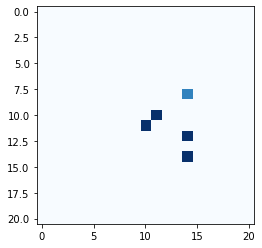

Act_State 1 : [1, 0, 0, 0] Action:  5 1016
Act_State 2 : [1, 0, 0, 0] Action:  5 1016
Act_State 3 : [1, 0, 0, 0] Action:  5 1016
Act_State 4 : [1, 0, 0, 0] Action:  5 1016


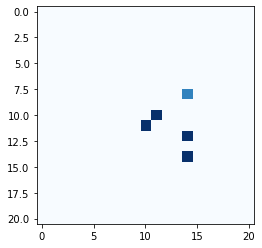

Act_State 1 : [1, 0, 0, 0] Action:  5 1016
Act_State 2 : [1, 0, 0, 0] Action:  5 1016
Act_State 3 : [1, 0, 0, 0] Action:  5 1016
Act_State 4 : [1, 0, 0, 0] Action:  5 1016


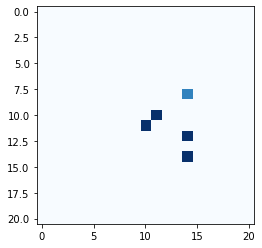

Act_State 1 : [1, 0, 0, 0] Action:  5 1016
Act_State 2 : [1, 0, 0, 0] Action:  5 1016
Act_State 3 : [1, 0, 0, 0] Action:  5 1016
Act_State 4 : [1, 0, 0, 0] Action:  5 1016


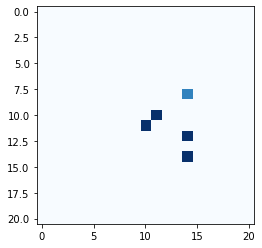

Act_State 1 : [1, 0, 0, 0] Action:  5 1016
Act_State 2 : [1, 0, 0, 0] Action:  5 1016
Act_State 3 : [1, 0, 0, 0] Action:  5 1016
Act_State 4 : [1, 0, 0, 0] Action:  5 1016


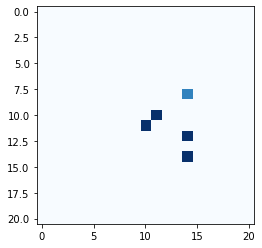

Act_State 1 : [1, 0, 0, 0] Action:  5 1016
Act_State 2 : [1, 0, 0, 0] Action:  5 1016
Act_State 3 : [1, 0, 0, 0] Action:  5 1016
Act_State 4 : [1, 0, 0, 0] Action:  5 1016


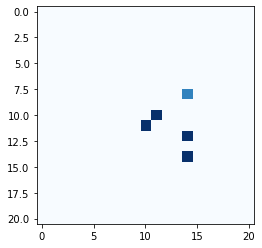

Act_State 1 : [1, 0, 0, 0] Action:  5 1016
Act_State 2 : [1, 0, 0, 0] Action:  5 1016
Act_State 3 : [1, 0, 0, 0] Action:  5 1016
Act_State 4 : [1, 0, 0, 0] Action:  5 1016


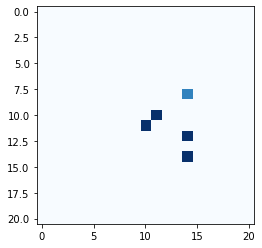

Act_State 1 : [1, 0, 0, 0] Action:  5 1016
Act_State 2 : [1, 0, 0, 0] Action:  5 1016
Act_State 3 : [1, 0, 0, 0] Action:  5 1016
Act_State 4 : [1, 0, 0, 0] Action:  5 1016


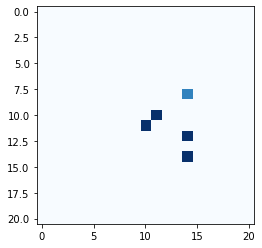

Act_State 1 : [1, 0, 0, 0] Action:  5 1016
Act_State 2 : [1, 0, 0, 0] Action:  5 1016
Act_State 3 : [1, 0, 0, 0] Action:  5 1016
Act_State 4 : [1, 0, 0, 0] Action:  5 1016


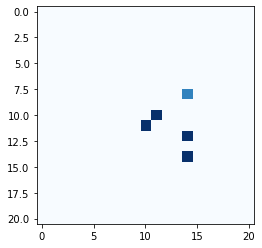

Act_State 1 : [1, 0, 0, 0] Action:  5 1016
Act_State 2 : [1, 0, 0, 0] Action:  5 1016
Act_State 3 : [1, 0, 0, 0] Action:  5 1016
Act_State 4 : [1, 0, 0, 0] Action:  5 1016


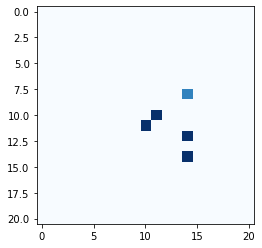

Act_State 1 : [1, 0, 0, 0] Action:  5 1016
Act_State 2 : [1, 0, 0, 0] Action:  5 1016
Act_State 3 : [1, 0, 0, 0] Action:  5 1016
Act_State 4 : [1, 0, 0, 0] Action:  5 1016


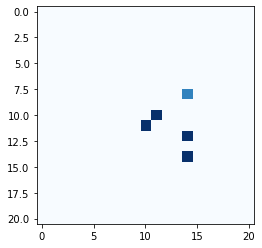

Act_State 1 : [1, 0, 0, 0] Action:  5 1016
Act_State 2 : [1, 0, 0, 0] Action:  5 1016
Act_State 3 : [1, 0, 0, 0] Action:  5 1016
Act_State 4 : [1, 0, 0, 0] Action:  5 1016


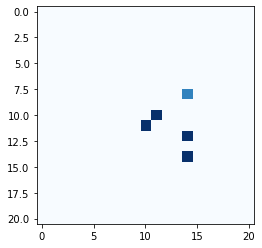

Act_State 1 : [1, 0, 0, 0] Action:  5 1016
Act_State 2 : [1, 0, 0, 0] Action:  5 1016
Act_State 3 : [1, 0, 0, 0] Action:  5 1016
Act_State 4 : [1, 0, 0, 0] Action:  5 1016


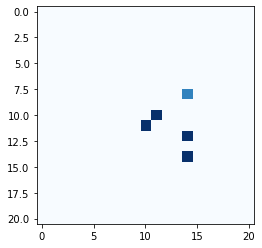

Act_State 1 : [1, 0, 0, 0] Action:  5 1016
Act_State 2 : [1, 0, 0, 0] Action:  5 1016
Act_State 3 : [1, 0, 0, 0] Action:  5 1016
Act_State 4 : [1, 0, 0, 0] Action:  5 1016


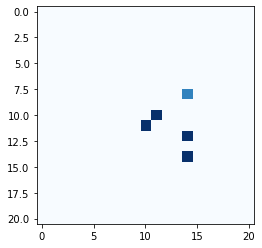

Act_State 1 : [1, 0, 0, 0] Action:  5 1016
Act_State 2 : [1, 0, 0, 0] Action:  5 1016
Act_State 3 : [1, 0, 0, 0] Action:  5 1016
Act_State 4 : [1, 0, 0, 0] Action:  5 1016


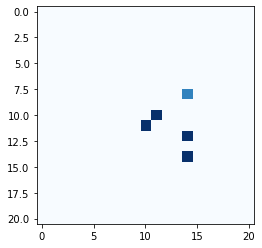

Act_State 1 : [1, 0, 0, 0] Action:  5 1016
Act_State 2 : [1, 0, 0, 0] Action:  5 1016
Act_State 3 : [1, 0, 0, 0] Action:  5 1016
Act_State 4 : [1, 0, 0, 0] Action:  5 1016


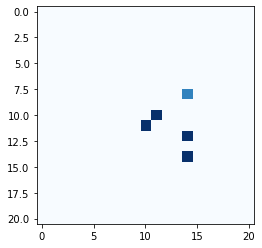

Act_State 1 : [1, 0, 0, 0] Action:  5 1016
Act_State 2 : [1, 0, 0, 0] Action:  5 1016
Act_State 3 : [1, 0, 0, 0] Action:  5 1016
Act_State 4 : [1, 0, 0, 0] Action:  5 1016


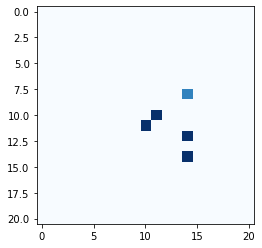

Act_State 1 : [1, 0, 0, 0] Action:  5 1016
Act_State 2 : [1, 0, 0, 0] Action:  5 1016
Act_State 3 : [1, 0, 0, 0] Action:  5 1016
Act_State 4 : [1, 0, 0, 0] Action:  5 1016


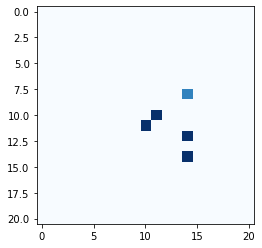

Act_State 1 : [1, 0, 0, 0] Action:  5 1016
Act_State 2 : [1, 0, 0, 0] Action:  5 1016
Act_State 3 : [1, 0, 0, 0] Action:  5 1016
Act_State 4 : [1, 0, 0, 0] Action:  5 1016


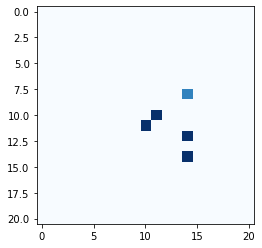

Act_State 1 : [1, 0, 0, 0] Action:  5 1016
Act_State 2 : [1, 0, 0, 0] Action:  5 1016
Act_State 3 : [1, 0, 0, 0] Action:  5 1016
Act_State 4 : [1, 0, 0, 0] Action:  5 1016


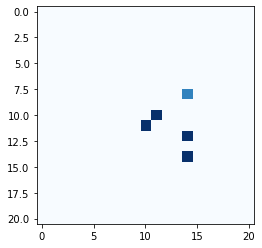

Act_State 1 : [1, 0, 0, 0] Action:  5 1016
Act_State 2 : [1, 0, 0, 0] Action:  5 1016
Act_State 3 : [1, 0, 0, 0] Action:  5 1016
Act_State 4 : [1, 0, 0, 0] Action:  5 1016


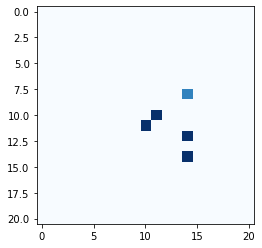

Act_State 1 : [1, 0, 0, 0] Action:  5 1016
Act_State 2 : [1, 1, 0, 0] Action:  4 1016
Act_State 3 : [1, 1, 0, 0] Action:  4 1016
Act_State 4 : [1, 1, 0, 0] Action:  4 1016


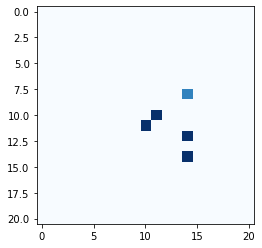

Act_State 1 : [1, 0, 0, 0] Action:  5 1016
Act_State 2 : [1, 1, 0, 0] Action:  4 1016
Act_State 3 : [1, 1, 0, 0] Action:  4 1016
Act_State 4 : [1, 1, 0, 0] Action:  4 1016


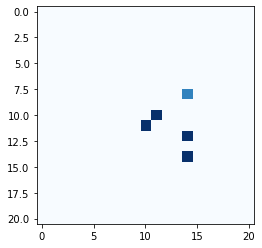

Act_State 1 : [1, 1, 0, 0] Action:  4 1016
Act_State 2 : [1, 1, 0, 0] Action:  4 1016
Act_State 3 : [1, 1, 0, 0] Action:  4 1016
Act_State 4 : [1, 1, 0, 0] Action:  4 1016


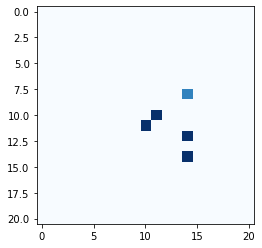

Act_State 1 : [1, 1, 0, 0] Action:  4 1016
Act_State 2 : [1, 1, 0, 0] Action:  4 1016
Act_State 3 : [1, 1, 0, 0] Action:  4 1016
Act_State 4 : [1, 1, 0, 0] Action:  4 1016


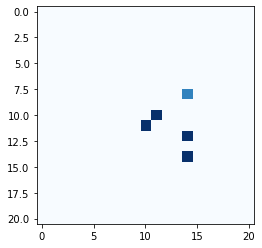

Act_State 1 : [1, 1, 0, 0] Action:  4 1016
Act_State 2 : [1, 1, 0, 0] Action:  4 1016
Act_State 3 : [1, 1, 0, 0] Action:  4 1016
Act_State 4 : [1, 1, 0, 0] Action:  4 1016
Fire ID: 1016 goes POP


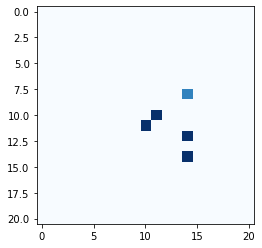

Act_State 1 : [0, 1, 0, 0] Action:  1 1016
Act_State 2 : [0, 1, 0, 0] Action:  0 1006
Act_State 3 : [0, 1, 0, 0] Action:  0 1006
Act_State 4 : [0, 1, 0, 0] Action:  0 1006


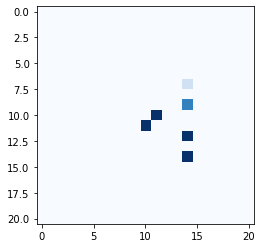

Act_State 1 : [0, 1, 0, 0] Action:  0 1006
Act_State 2 : [0, 1, 0, 0] Action:  0 1006
Act_State 3 : [0, 1, 0, 0] Action:  0 1006
Act_State 4 : [0, 1, 0, 0] Action:  0 1006


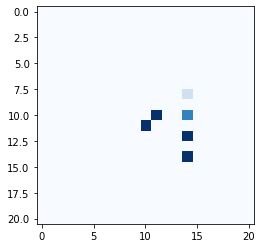

Act_State 1 : [0, 1, 0, 0] Action:  0 1006
Act_State 2 : [0, 1, 0, 0] Action:  0 1006
Act_State 3 : [0, 1, 0, 0] Action:  0 1006
Act_State 4 : [0, 1, 0, 0] Action:  0 1006


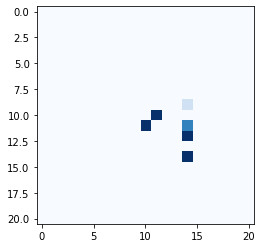

Act_State 1 : [0, 1, 0, 0] Action:  0 1006
Act_State 2 : [0, 1, 0, 0] Action:  0 1006
Act_State 3 : [0, 1, 0, 0] Action:  0 1006
Act_State 4 : [0, 1, 0, 0] Action:  0 1006


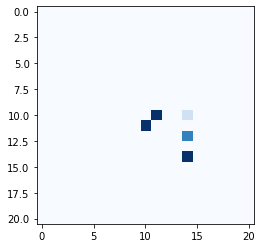

Act_State 1 : [0, 1, 0, 0] Action:  0 1006
Act_State 2 : [1, 1, 0, 0] Action:  4 1006
Act_State 3 : [1, 1, 0, 0] Action:  4 1006
Act_State 4 : [1, 1, 0, 0] Action:  4 1006


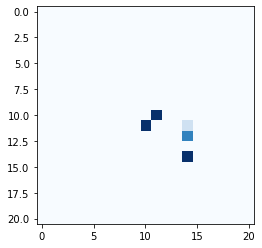

Act_State 1 : [0, 1, 0, 0] Action:  0 1006
Act_State 2 : [1, 0, 0, 0] Action:  5 1006
Act_State 3 : [1, 0, 0, 0] Action:  5 1006
Act_State 4 : [1, 0, 0, 0] Action:  5 1006


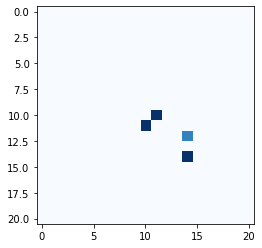

Act_State 1 : [1, 1, 0, 0] Action:  4 1006
Act_State 2 : [1, 0, 0, 0] Action:  5 1006
Act_State 3 : [1, 0, 0, 0] Action:  5 1006
Act_State 4 : [1, 0, 0, 0] Action:  5 1006


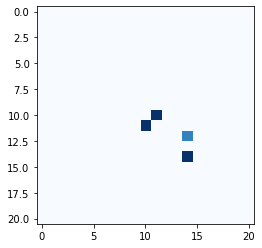

Act_State 1 : [1, 0, 0, 0] Action:  5 1006
Act_State 2 : [1, 0, 0, 0] Action:  5 1006
Act_State 3 : [1, 0, 0, 0] Action:  5 1006
Act_State 4 : [1, 0, 0, 0] Action:  5 1006


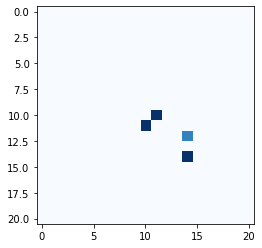

Act_State 1 : [1, 0, 0, 0] Action:  5 1006
Act_State 2 : [1, 0, 0, 0] Action:  5 1006
Act_State 3 : [1, 0, 0, 0] Action:  5 1006
Act_State 4 : [1, 0, 0, 0] Action:  5 1006


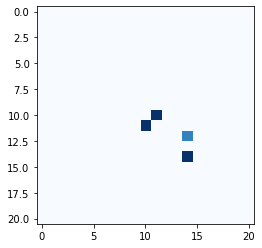

Act_State 1 : [1, 0, 0, 0] Action:  5 1006
Act_State 2 : [1, 0, 0, 0] Action:  5 1006
Act_State 3 : [1, 0, 0, 0] Action:  5 1006
Act_State 4 : [1, 0, 0, 0] Action:  5 1006


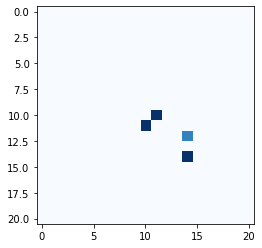

Act_State 1 : [1, 0, 0, 0] Action:  5 1006
Act_State 2 : [1, 0, 0, 0] Action:  5 1006
Act_State 3 : [1, 0, 0, 0] Action:  5 1006
Act_State 4 : [1, 0, 0, 0] Action:  5 1006


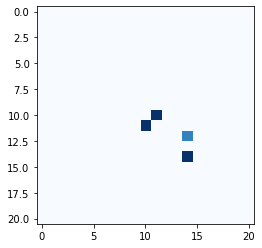

Act_State 1 : [1, 0, 0, 0] Action:  5 1006
Act_State 2 : [1, 0, 0, 0] Action:  5 1006
Act_State 3 : [1, 0, 0, 0] Action:  5 1006
Act_State 4 : [1, 0, 0, 0] Action:  5 1006


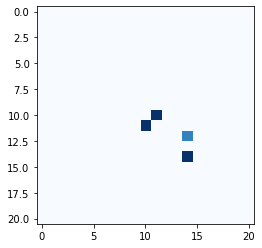

Act_State 1 : [1, 0, 0, 0] Action:  5 1006
Act_State 2 : [1, 0, 0, 0] Action:  5 1006
Act_State 3 : [1, 0, 0, 0] Action:  5 1006
Act_State 4 : [1, 0, 0, 0] Action:  5 1006


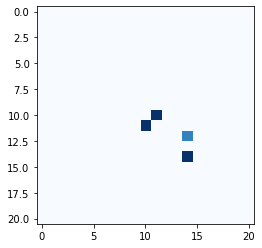

Act_State 1 : [1, 0, 0, 0] Action:  5 1006
Act_State 2 : [1, 0, 0, 0] Action:  5 1006
Act_State 3 : [1, 0, 0, 0] Action:  5 1006
Act_State 4 : [1, 0, 0, 0] Action:  5 1006


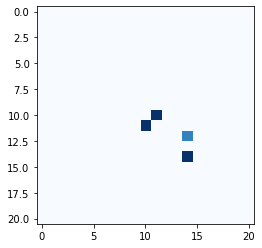

Act_State 1 : [1, 0, 0, 0] Action:  5 1006
Act_State 2 : [1, 0, 0, 0] Action:  5 1006
Act_State 3 : [1, 0, 0, 0] Action:  5 1006
Act_State 4 : [1, 0, 0, 0] Action:  5 1006


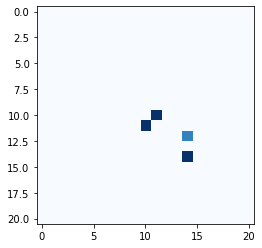

Act_State 1 : [1, 0, 0, 0] Action:  5 1006
Act_State 2 : [1, 0, 0, 0] Action:  5 1006
Act_State 3 : [1, 0, 0, 0] Action:  5 1006
Act_State 4 : [1, 0, 0, 0] Action:  5 1006


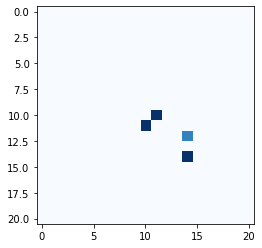

Act_State 1 : [1, 0, 0, 0] Action:  5 1006
Act_State 2 : [1, 0, 0, 0] Action:  5 1006
Act_State 3 : [1, 0, 0, 0] Action:  5 1006
Act_State 4 : [1, 0, 0, 0] Action:  5 1006


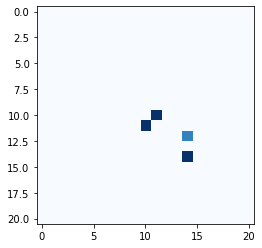

Act_State 1 : [1, 0, 0, 0] Action:  5 1006
Act_State 2 : [1, 0, 0, 0] Action:  5 1006
Act_State 3 : [1, 0, 0, 0] Action:  5 1006
Act_State 4 : [1, 0, 0, 0] Action:  5 1006


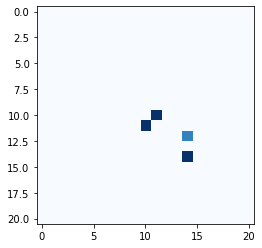

Act_State 1 : [1, 0, 0, 0] Action:  5 1006
Act_State 2 : [1, 0, 0, 0] Action:  5 1006
Act_State 3 : [1, 0, 0, 0] Action:  5 1006
Act_State 4 : [1, 0, 0, 0] Action:  5 1006


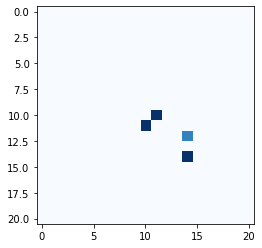

Act_State 1 : [1, 0, 0, 0] Action:  5 1006
Act_State 2 : [1, 0, 0, 0] Action:  5 1006
Act_State 3 : [1, 0, 0, 0] Action:  5 1006
Act_State 4 : [1, 0, 0, 0] Action:  5 1006


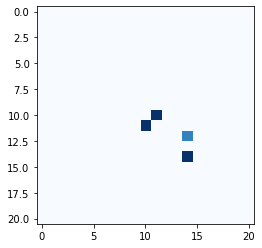

Act_State 1 : [1, 0, 0, 0] Action:  5 1006
Act_State 2 : [1, 0, 0, 0] Action:  5 1006
Act_State 3 : [1, 0, 0, 0] Action:  5 1006
Act_State 4 : [1, 0, 0, 0] Action:  5 1006


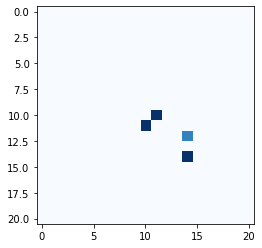

Act_State 1 : [1, 0, 0, 0] Action:  5 1006
Act_State 2 : [1, 0, 0, 0] Action:  5 1006
Act_State 3 : [1, 0, 0, 0] Action:  5 1006
Act_State 4 : [1, 0, 0, 0] Action:  5 1006


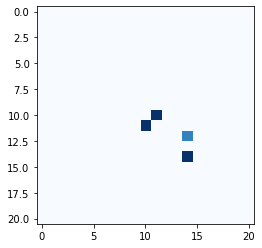

Act_State 1 : [1, 0, 0, 0] Action:  5 1006
Act_State 2 : [1, 0, 0, 0] Action:  5 1006
Act_State 3 : [1, 0, 0, 0] Action:  5 1006
Act_State 4 : [1, 0, 0, 0] Action:  5 1006


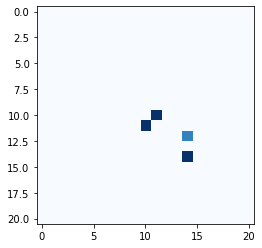

Act_State 1 : [1, 0, 0, 0] Action:  5 1006
Act_State 2 : [1, 0, 0, 0] Action:  5 1006
Act_State 3 : [1, 0, 0, 0] Action:  5 1006
Act_State 4 : [1, 0, 0, 0] Action:  5 1006


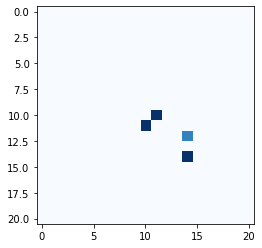

Act_State 1 : [1, 0, 0, 0] Action:  5 1006
Act_State 2 : [1, 0, 0, 0] Action:  5 1006
Act_State 3 : [1, 0, 0, 0] Action:  5 1006
Act_State 4 : [1, 0, 0, 0] Action:  5 1006


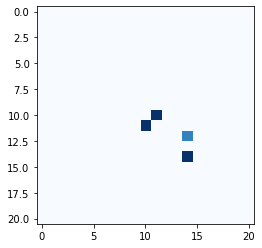

Act_State 1 : [1, 0, 0, 0] Action:  5 1006
Act_State 2 : [1, 0, 0, 0] Action:  5 1006
Act_State 3 : [1, 0, 0, 0] Action:  5 1006
Act_State 4 : [1, 0, 0, 0] Action:  5 1006


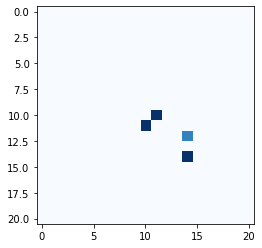

Act_State 1 : [1, 0, 0, 0] Action:  5 1006
Act_State 2 : [1, 0, 0, 0] Action:  5 1006
Act_State 3 : [1, 0, 0, 0] Action:  5 1006
Act_State 4 : [1, 0, 0, 0] Action:  5 1006


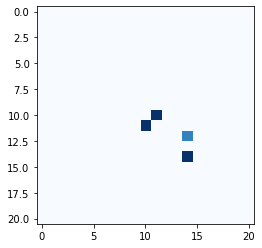

Act_State 1 : [1, 0, 0, 0] Action:  5 1006
Act_State 2 : [1, 0, 0, 0] Action:  5 1006
Act_State 3 : [1, 0, 0, 0] Action:  5 1006
Act_State 4 : [1, 0, 0, 0] Action:  5 1006


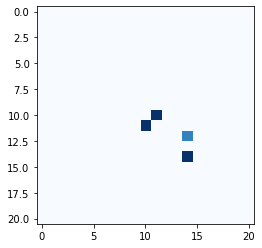

Act_State 1 : [1, 0, 0, 0] Action:  5 1006
Act_State 2 : [1, 0, 0, 0] Action:  5 1006
Act_State 3 : [1, 0, 0, 0] Action:  5 1006
Act_State 4 : [1, 0, 0, 0] Action:  5 1006


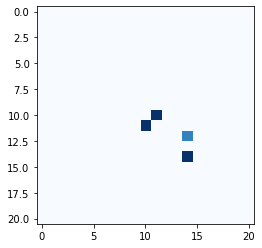

Act_State 1 : [1, 0, 0, 0] Action:  5 1006
Act_State 2 : [1, 0, 0, 0] Action:  5 1006
Act_State 3 : [1, 0, 0, 0] Action:  5 1006
Act_State 4 : [1, 0, 0, 0] Action:  5 1006


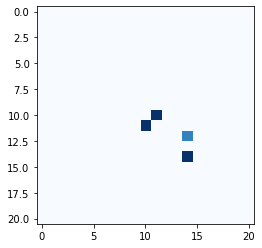

Act_State 1 : [1, 0, 0, 0] Action:  5 1006
Act_State 2 : [1, 0, 0, 0] Action:  5 1006
Act_State 3 : [1, 0, 0, 0] Action:  5 1006
Act_State 4 : [1, 0, 0, 0] Action:  5 1006


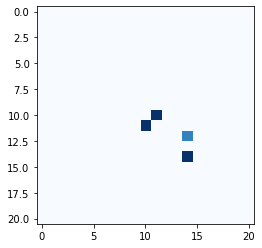

Act_State 1 : [1, 0, 0, 0] Action:  5 1006
Act_State 2 : [1, 0, 0, 0] Action:  5 1006
Act_State 3 : [1, 0, 0, 0] Action:  5 1006
Act_State 4 : [1, 0, 0, 0] Action:  5 1006


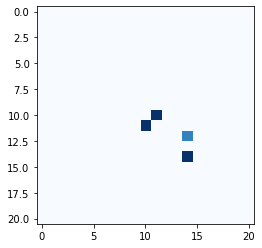

Act_State 1 : [1, 0, 0, 0] Action:  5 1006
Act_State 2 : [1, 0, 0, 0] Action:  5 1006
Act_State 3 : [1, 0, 0, 0] Action:  5 1006
Act_State 4 : [1, 0, 0, 0] Action:  5 1006


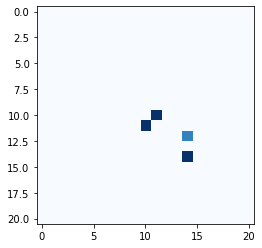

Act_State 1 : [1, 0, 0, 0] Action:  5 1006
Act_State 2 : [1, 0, 0, 0] Action:  5 1006
Act_State 3 : [1, 0, 0, 0] Action:  5 1006
Act_State 4 : [1, 0, 0, 0] Action:  5 1006


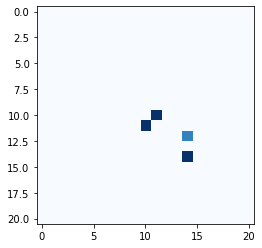

Act_State 1 : [1, 0, 0, 0] Action:  5 1006
Act_State 2 : [1, 0, 0, 0] Action:  5 1006
Act_State 3 : [1, 0, 0, 0] Action:  5 1006
Act_State 4 : [1, 0, 0, 0] Action:  5 1006


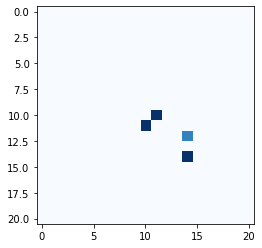

Act_State 1 : [1, 0, 0, 0] Action:  5 1006
Act_State 2 : [1, 0, 0, 0] Action:  5 1006
Act_State 3 : [1, 0, 0, 0] Action:  5 1006
Act_State 4 : [1, 0, 0, 0] Action:  5 1006


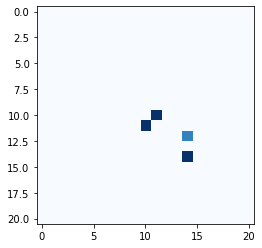

Act_State 1 : [1, 0, 0, 0] Action:  5 1006
Act_State 2 : [1, 0, 0, 0] Action:  5 1006
Act_State 3 : [1, 0, 0, 0] Action:  5 1006
Act_State 4 : [1, 0, 0, 0] Action:  5 1006


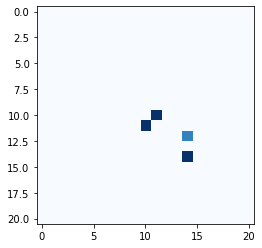

Act_State 1 : [1, 0, 0, 0] Action:  5 1006
Act_State 2 : [1, 0, 0, 0] Action:  5 1006
Act_State 3 : [1, 0, 0, 0] Action:  5 1006
Act_State 4 : [1, 0, 0, 0] Action:  5 1006


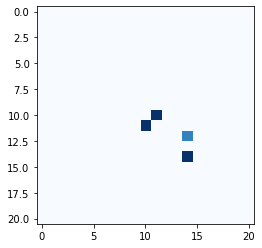

Act_State 1 : [1, 0, 0, 0] Action:  5 1006
Act_State 2 : [1, 0, 0, 0] Action:  5 1006
Act_State 3 : [1, 0, 0, 0] Action:  5 1006
Act_State 4 : [1, 0, 0, 0] Action:  5 1006


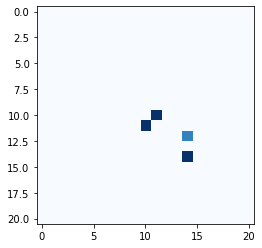

Act_State 1 : [1, 0, 0, 0] Action:  5 1006
Act_State 2 : [1, 0, 0, 0] Action:  5 1006
Act_State 3 : [1, 0, 0, 0] Action:  5 1006
Act_State 4 : [1, 0, 0, 0] Action:  5 1006


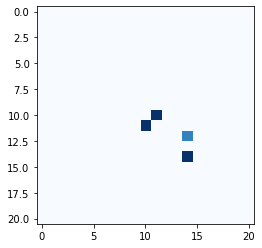

Act_State 1 : [1, 0, 0, 0] Action:  5 1006
Act_State 2 : [1, 0, 0, 0] Action:  5 1006
Act_State 3 : [1, 0, 0, 0] Action:  5 1006
Act_State 4 : [1, 0, 0, 0] Action:  5 1006


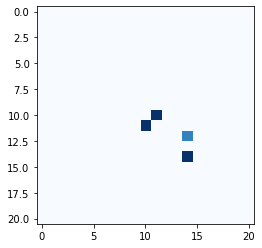

Act_State 1 : [1, 0, 0, 0] Action:  5 1006
Act_State 2 : [1, 0, 0, 0] Action:  5 1006
Act_State 3 : [1, 1, 0, 0] Action:  4 1006
Act_State 4 : [1, 1, 0, 0] Action:  4 1006


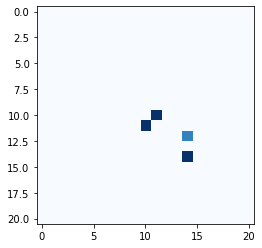

Act_State 1 : [1, 1, 0, 0] Action:  4 1006
Act_State 2 : [1, 1, 0, 0] Action:  4 1006
Act_State 3 : [1, 1, 0, 0] Action:  4 1006
Act_State 4 : [1, 1, 0, 0] Action:  4 1006


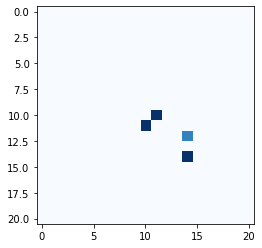

Act_State 1 : [1, 1, 0, 0] Action:  4 1006
Act_State 2 : [1, 1, 0, 0] Action:  4 1006
Act_State 3 : [1, 1, 0, 0] Action:  4 1006
Act_State 4 : [1, 1, 0, 0] Action:  4 1006


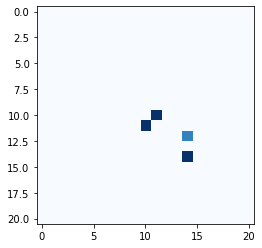

Act_State 1 : [1, 1, 0, 0] Action:  4 1006
Act_State 2 : [1, 1, 0, 0] Action:  4 1006
Act_State 3 : [1, 1, 0, 0] Action:  4 1006
Act_State 4 : [1, 1, 0, 0] Action:  4 1006


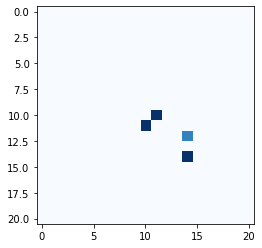

Act_State 1 : [1, 1, 0, 0] Action:  4 1006
Act_State 2 : [1, 1, 0, 0] Action:  4 1006
Act_State 3 : [1, 1, 0, 0] Action:  4 1006
Act_State 4 : [1, 1, 0, 0] Action:  4 1006
Fire ID: 1006 goes POP


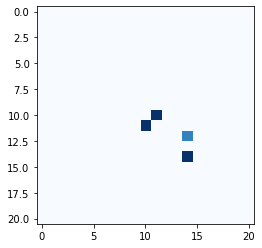

Act_State 1 : [0, 1, 0, 0] Action:  1 1006
Act_State 2 : [0, 1, 0, 0] Action:  0 1010
Act_State 3 : [0, 1, 0, 0] Action:  0 1010
Act_State 4 : [0, 1, 0, 0] Action:  0 1010


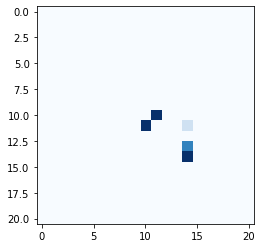

Act_State 1 : [0, 1, 0, 0] Action:  0 1010
Act_State 2 : [0, 1, 0, 0] Action:  0 1010
Act_State 3 : [0, 1, 0, 0] Action:  0 1010
Act_State 4 : [0, 1, 0, 0] Action:  0 1010


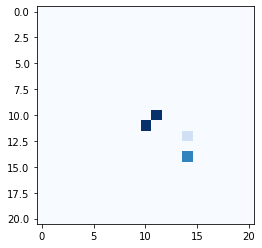

Act_State 1 : [0, 1, 0, 0] Action:  0 1010
Act_State 2 : [1, 1, 0, 0] Action:  4 1010
Act_State 3 : [1, 1, 0, 0] Action:  4 1010
Act_State 4 : [1, 1, 0, 0] Action:  4 1010


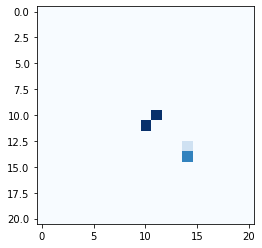

Act_State 1 : [0, 1, 0, 0] Action:  0 1010
Act_State 2 : [1, 0, 0, 0] Action:  5 1010
Act_State 3 : [1, 0, 0, 0] Action:  5 1010
Act_State 4 : [1, 0, 0, 0] Action:  5 1010


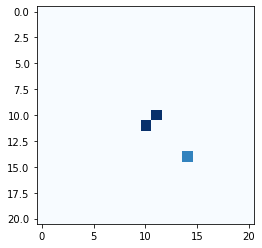

Act_State 1 : [1, 1, 0, 0] Action:  4 1010
Act_State 2 : [1, 0, 0, 0] Action:  5 1010
Act_State 3 : [1, 0, 0, 0] Action:  5 1010
Act_State 4 : [1, 0, 0, 0] Action:  5 1010


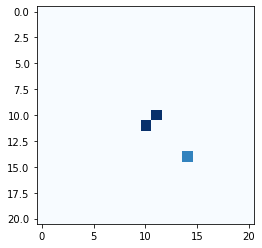

Act_State 1 : [1, 0, 0, 0] Action:  5 1010
Act_State 2 : [1, 0, 0, 0] Action:  5 1010
Act_State 3 : [1, 0, 0, 0] Action:  5 1010
Act_State 4 : [1, 0, 0, 0] Action:  5 1010


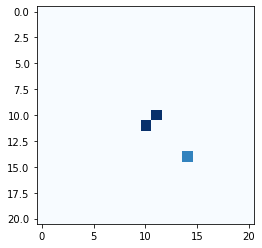

Act_State 1 : [1, 0, 0, 0] Action:  5 1010
Act_State 2 : [1, 0, 0, 0] Action:  5 1010
Act_State 3 : [1, 0, 0, 0] Action:  5 1010
Act_State 4 : [1, 0, 0, 0] Action:  5 1010


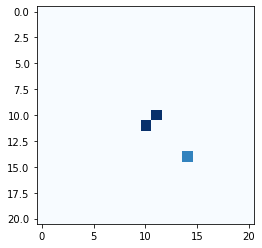

Act_State 1 : [1, 0, 0, 0] Action:  5 1010
Act_State 2 : [1, 0, 0, 0] Action:  5 1010
Act_State 3 : [1, 0, 0, 0] Action:  5 1010
Act_State 4 : [1, 0, 0, 0] Action:  5 1010


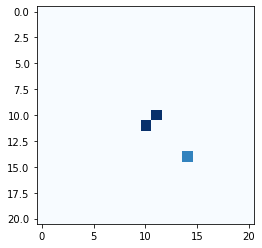

Act_State 1 : [1, 0, 0, 0] Action:  5 1010
Act_State 2 : [1, 0, 0, 0] Action:  5 1010
Act_State 3 : [1, 0, 0, 0] Action:  5 1010
Act_State 4 : [1, 0, 0, 0] Action:  5 1010


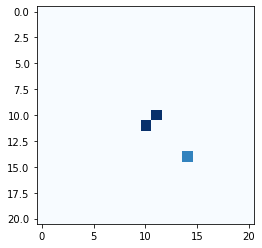

Act_State 1 : [1, 0, 0, 0] Action:  5 1010
Act_State 2 : [1, 0, 0, 0] Action:  5 1010
Act_State 3 : [1, 0, 0, 0] Action:  5 1010
Act_State 4 : [1, 0, 0, 0] Action:  5 1010


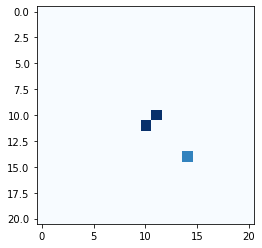

Act_State 1 : [1, 0, 0, 0] Action:  5 1010
Act_State 2 : [1, 0, 0, 0] Action:  5 1010
Act_State 3 : [1, 0, 0, 0] Action:  5 1010
Act_State 4 : [1, 0, 0, 0] Action:  5 1010


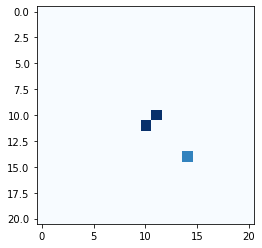

Act_State 1 : [1, 0, 0, 0] Action:  5 1010
Act_State 2 : [1, 0, 0, 0] Action:  5 1010
Act_State 3 : [1, 0, 0, 0] Action:  5 1010
Act_State 4 : [1, 0, 0, 0] Action:  5 1010


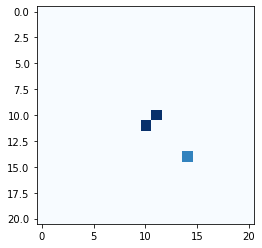

Act_State 1 : [1, 0, 0, 0] Action:  5 1010
Act_State 2 : [1, 0, 0, 0] Action:  5 1010
Act_State 3 : [1, 0, 0, 0] Action:  5 1010
Act_State 4 : [1, 0, 0, 0] Action:  5 1010


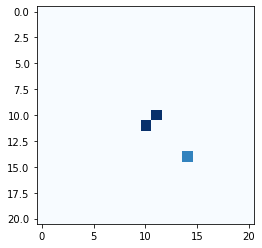

Act_State 1 : [1, 0, 0, 0] Action:  5 1010
Act_State 2 : [1, 0, 0, 0] Action:  5 1010
Act_State 3 : [1, 0, 0, 0] Action:  5 1010
Act_State 4 : [1, 0, 0, 0] Action:  5 1010


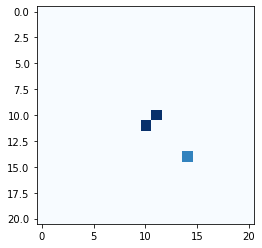

Act_State 1 : [1, 0, 0, 0] Action:  5 1010
Act_State 2 : [1, 0, 0, 0] Action:  5 1010
Act_State 3 : [1, 0, 0, 0] Action:  5 1010
Act_State 4 : [1, 0, 0, 0] Action:  5 1010


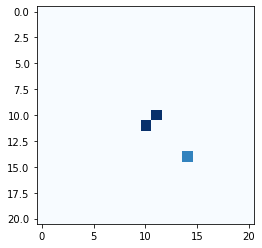

Act_State 1 : [1, 0, 0, 0] Action:  5 1010
Act_State 2 : [1, 0, 0, 0] Action:  5 1010
Act_State 3 : [1, 0, 0, 0] Action:  5 1010
Act_State 4 : [1, 0, 0, 0] Action:  5 1010


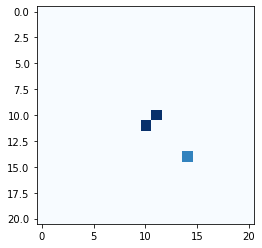

Act_State 1 : [1, 0, 0, 0] Action:  5 1010
Act_State 2 : [1, 0, 0, 0] Action:  5 1010
Act_State 3 : [1, 0, 0, 0] Action:  5 1010
Act_State 4 : [1, 0, 0, 0] Action:  5 1010


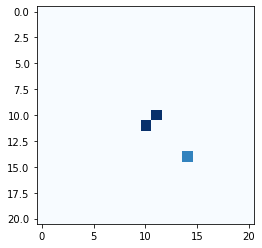

Act_State 1 : [1, 0, 0, 0] Action:  5 1010
Act_State 2 : [1, 0, 0, 0] Action:  5 1010
Act_State 3 : [1, 0, 0, 0] Action:  5 1010
Act_State 4 : [1, 0, 0, 0] Action:  5 1010


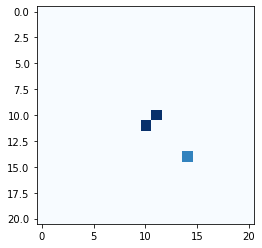

Act_State 1 : [1, 0, 0, 0] Action:  5 1010
Act_State 2 : [1, 0, 0, 0] Action:  5 1010
Act_State 3 : [1, 0, 0, 0] Action:  5 1010
Act_State 4 : [1, 0, 0, 0] Action:  5 1010


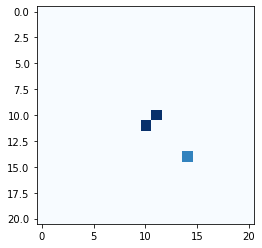

Act_State 1 : [1, 0, 0, 0] Action:  5 1010
Act_State 2 : [1, 0, 0, 0] Action:  5 1010
Act_State 3 : [1, 0, 0, 0] Action:  5 1010
Act_State 4 : [1, 0, 0, 0] Action:  5 1010


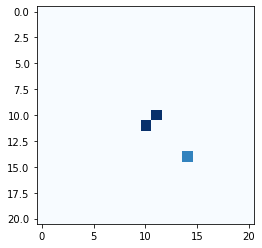

Act_State 1 : [1, 0, 0, 0] Action:  5 1010
Act_State 2 : [1, 0, 0, 0] Action:  5 1010
Act_State 3 : [1, 0, 0, 0] Action:  5 1010
Act_State 4 : [1, 0, 0, 0] Action:  5 1010


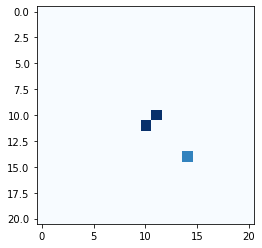

Act_State 1 : [1, 0, 0, 0] Action:  5 1010
Act_State 2 : [1, 0, 0, 0] Action:  5 1010
Act_State 3 : [1, 0, 0, 0] Action:  5 1010
Act_State 4 : [1, 0, 0, 0] Action:  5 1010


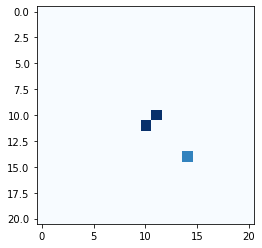

Act_State 1 : [1, 0, 0, 0] Action:  5 1010
Act_State 2 : [1, 0, 0, 0] Action:  5 1010
Act_State 3 : [1, 0, 0, 0] Action:  5 1010
Act_State 4 : [1, 0, 0, 0] Action:  5 1010


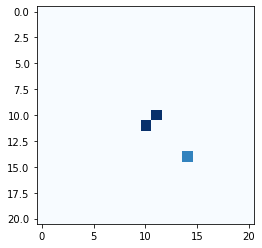

Act_State 1 : [1, 0, 0, 0] Action:  5 1010
Act_State 2 : [1, 0, 0, 0] Action:  5 1010
Act_State 3 : [1, 0, 0, 0] Action:  5 1010
Act_State 4 : [1, 0, 0, 0] Action:  5 1010


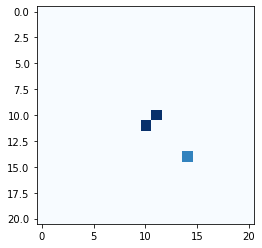

Act_State 1 : [1, 0, 0, 0] Action:  5 1010
Act_State 2 : [1, 0, 0, 0] Action:  5 1010
Act_State 3 : [1, 0, 0, 0] Action:  5 1010
Act_State 4 : [1, 0, 0, 0] Action:  5 1010


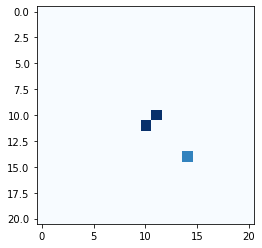

Act_State 1 : [1, 0, 0, 0] Action:  5 1010
Act_State 2 : [1, 0, 0, 0] Action:  5 1010
Act_State 3 : [1, 0, 0, 0] Action:  5 1010
Act_State 4 : [1, 0, 0, 0] Action:  5 1010


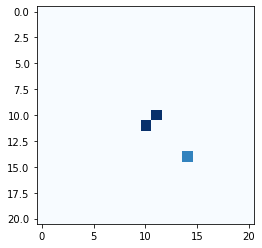

Act_State 1 : [1, 0, 0, 0] Action:  5 1010
Act_State 2 : [1, 0, 0, 0] Action:  5 1010
Act_State 3 : [1, 0, 0, 0] Action:  5 1010
Act_State 4 : [1, 0, 0, 0] Action:  5 1010


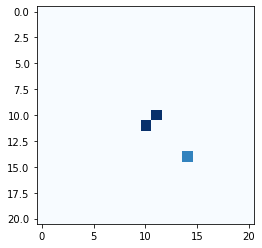

Act_State 1 : [1, 0, 0, 0] Action:  5 1010
Act_State 2 : [1, 0, 0, 0] Action:  5 1010
Act_State 3 : [1, 0, 0, 0] Action:  5 1010
Act_State 4 : [1, 0, 0, 0] Action:  5 1010


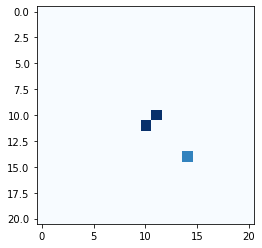

Act_State 1 : [1, 0, 0, 0] Action:  5 1010
Act_State 2 : [1, 0, 0, 0] Action:  5 1010
Act_State 3 : [1, 0, 0, 0] Action:  5 1010
Act_State 4 : [1, 0, 0, 0] Action:  5 1010


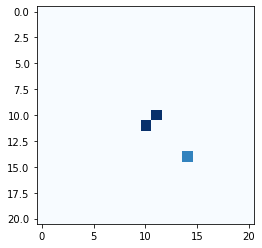

Act_State 1 : [1, 0, 0, 0] Action:  5 1010
Act_State 2 : [1, 0, 0, 0] Action:  5 1010
Act_State 3 : [1, 0, 0, 0] Action:  5 1010
Act_State 4 : [1, 0, 0, 0] Action:  5 1010


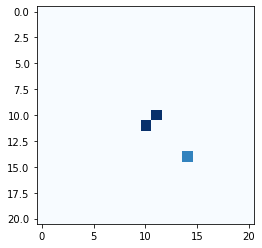

Act_State 1 : [1, 0, 0, 0] Action:  5 1010
Act_State 2 : [1, 0, 0, 0] Action:  5 1010
Act_State 3 : [1, 0, 0, 0] Action:  5 1010
Act_State 4 : [1, 0, 0, 0] Action:  5 1010


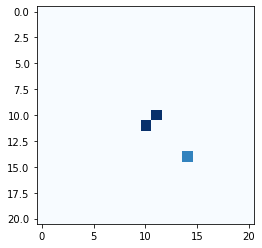

Act_State 1 : [1, 0, 0, 0] Action:  5 1010
Act_State 2 : [1, 0, 0, 0] Action:  5 1010
Act_State 3 : [1, 0, 0, 0] Action:  5 1010
Act_State 4 : [1, 0, 0, 0] Action:  5 1010


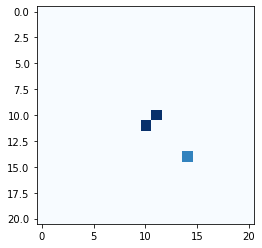

Act_State 1 : [1, 0, 0, 0] Action:  5 1010
Act_State 2 : [1, 0, 0, 0] Action:  5 1010
Act_State 3 : [1, 0, 0, 0] Action:  5 1010
Act_State 4 : [1, 0, 0, 0] Action:  5 1010


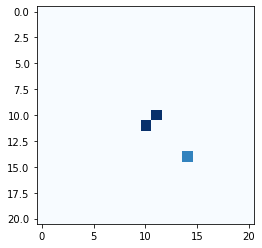

Act_State 1 : [1, 0, 0, 0] Action:  5 1010
Act_State 2 : [1, 0, 0, 0] Action:  5 1010
Act_State 3 : [1, 0, 0, 0] Action:  5 1010
Act_State 4 : [1, 0, 0, 0] Action:  5 1010


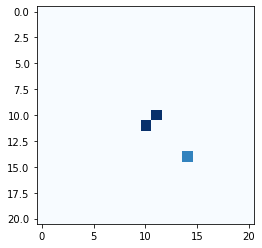

Act_State 1 : [1, 0, 0, 0] Action:  5 1010
Act_State 2 : [1, 0, 0, 0] Action:  5 1010
Act_State 3 : [1, 0, 0, 0] Action:  5 1010
Act_State 4 : [1, 0, 0, 0] Action:  5 1010


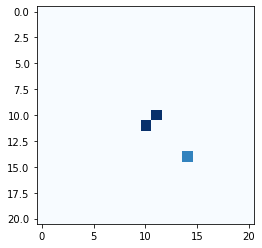

Act_State 1 : [1, 0, 0, 0] Action:  5 1010
Act_State 2 : [1, 0, 0, 0] Action:  5 1010
Act_State 3 : [1, 0, 0, 0] Action:  5 1010
Act_State 4 : [1, 0, 0, 0] Action:  5 1010


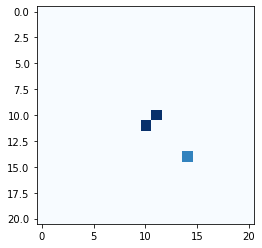

Act_State 1 : [1, 0, 0, 0] Action:  5 1010
Act_State 2 : [1, 0, 0, 0] Action:  5 1010
Act_State 3 : [1, 0, 0, 0] Action:  5 1010
Act_State 4 : [1, 0, 0, 0] Action:  5 1010


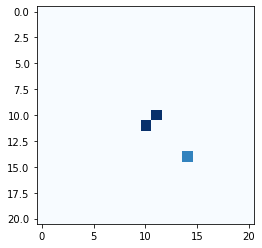

Act_State 1 : [1, 0, 0, 0] Action:  5 1010
Act_State 2 : [1, 0, 0, 0] Action:  5 1010
Act_State 3 : [1, 0, 0, 0] Action:  5 1010
Act_State 4 : [1, 0, 0, 0] Action:  5 1010


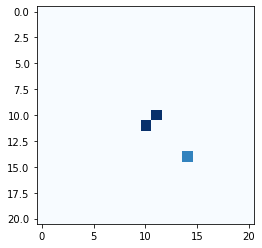

Act_State 1 : [1, 0, 0, 0] Action:  5 1010
Act_State 2 : [1, 0, 0, 0] Action:  5 1010
Act_State 3 : [1, 0, 0, 0] Action:  5 1010
Act_State 4 : [1, 0, 0, 0] Action:  5 1010


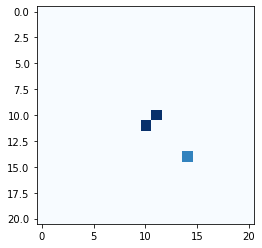

Act_State 1 : [1, 0, 0, 0] Action:  5 1010
Act_State 2 : [1, 0, 0, 0] Action:  5 1010
Act_State 3 : [1, 0, 0, 0] Action:  5 1010
Act_State 4 : [1, 0, 0, 0] Action:  5 1010


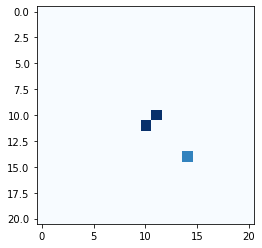

Act_State 1 : [1, 0, 0, 0] Action:  5 1010
Act_State 2 : [1, 0, 0, 0] Action:  5 1010
Act_State 3 : [1, 0, 0, 0] Action:  5 1010
Act_State 4 : [1, 0, 0, 0] Action:  5 1010


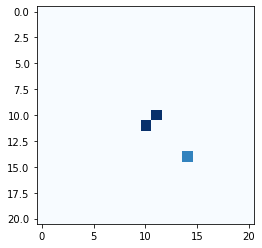

Act_State 1 : [1, 0, 0, 0] Action:  5 1010
Act_State 2 : [1, 0, 0, 0] Action:  5 1010
Act_State 3 : [1, 0, 0, 0] Action:  5 1010
Act_State 4 : [1, 0, 0, 0] Action:  5 1010


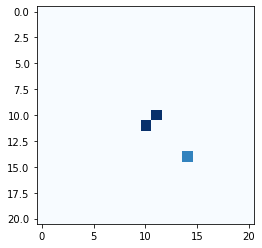

Act_State 1 : [1, 0, 0, 0] Action:  5 1010
Act_State 2 : [1, 0, 0, 0] Action:  5 1010
Act_State 3 : [1, 0, 0, 0] Action:  5 1010
Act_State 4 : [1, 0, 0, 0] Action:  5 1010


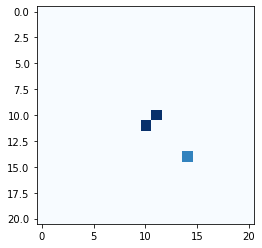

Act_State 1 : [1, 0, 0, 0] Action:  5 1010
Act_State 2 : [1, 0, 0, 0] Action:  5 1010
Act_State 3 : [1, 0, 0, 0] Action:  5 1010
Act_State 4 : [1, 0, 0, 0] Action:  5 1010


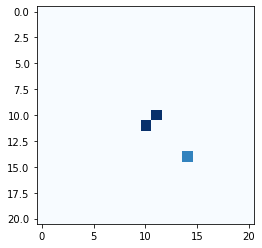

Act_State 1 : [1, 0, 0, 0] Action:  5 1010
Act_State 2 : [1, 0, 0, 0] Action:  5 1010
Act_State 3 : [1, 0, 0, 0] Action:  5 1010
Act_State 4 : [1, 0, 0, 0] Action:  5 1010


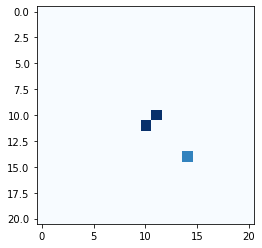

Act_State 1 : [1, 0, 0, 0] Action:  5 1010
Act_State 2 : [1, 1, 0, 0] Action:  4 1010
Act_State 3 : [1, 1, 0, 0] Action:  4 1010
Act_State 4 : [1, 1, 0, 0] Action:  4 1010


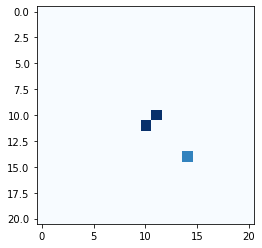

Act_State 1 : [1, 0, 0, 0] Action:  5 1010
Act_State 2 : [1, 1, 0, 0] Action:  4 1010
Act_State 3 : [1, 1, 0, 0] Action:  4 1010
Act_State 4 : [1, 1, 0, 0] Action:  4 1010


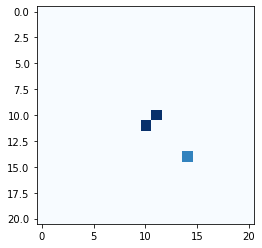

Act_State 1 : [1, 1, 0, 0] Action:  4 1010
Act_State 2 : [1, 1, 0, 0] Action:  4 1010
Act_State 3 : [1, 1, 0, 0] Action:  4 1010
Act_State 4 : [1, 1, 0, 0] Action:  4 1010


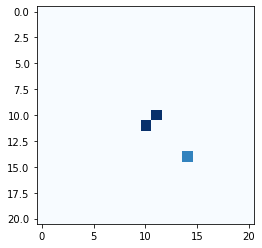

Act_State 1 : [1, 1, 0, 0] Action:  4 1010
Act_State 2 : [1, 1, 0, 0] Action:  4 1010
Act_State 3 : [1, 1, 0, 0] Action:  4 1010
Act_State 4 : [1, 1, 0, 0] Action:  4 1010


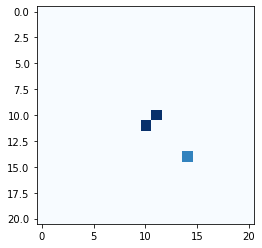

Act_State 1 : [1, 1, 0, 0] Action:  4 1010
Act_State 2 : [1, 1, 0, 0] Action:  4 1010
Act_State 3 : [1, 1, 0, 0] Action:  4 1010
Act_State 4 : [1, 1, 0, 0] Action:  4 1010
Fire ID: 1010 goes POP


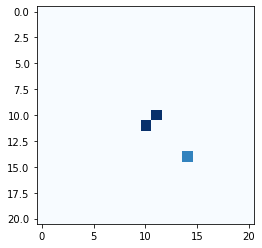

Act_State 1 : [0, 1, 0, 0] Action:  1 1010
Act_State 2 : [0, 1, 0, 0] Action:  1 1019
Act_State 3 : [0, 1, 0, 0] Action:  1 1019
Act_State 4 : [0, 1, 0, 0] Action:  1 1019


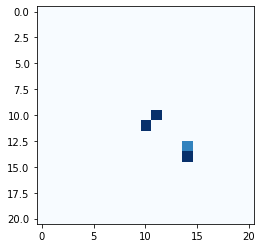

Act_State 1 : [0, 1, 0, 0] Action:  0 1019
Act_State 2 : [0, 1, 0, 0] Action:  0 1019
Act_State 3 : [0, 1, 0, 0] Action:  0 1019
Act_State 4 : [0, 1, 0, 0] Action:  0 1019


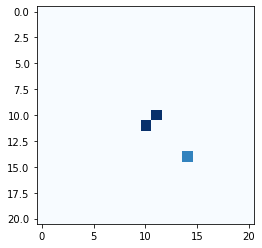

Act_State 1 : [1, 1, 0, 0] Action:  4 1019
Act_State 2 : [1, 1, 0, 0] Action:  4 1019
Act_State 3 : [1, 1, 0, 0] Action:  4 1019
Act_State 4 : [1, 1, 0, 0] Action:  4 1019


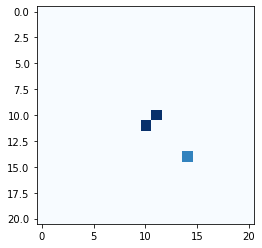

Act_State 1 : [1, 0, 0, 0] Action:  5 1019
Act_State 2 : [1, 0, 0, 0] Action:  5 1019
Act_State 3 : [1, 0, 0, 0] Action:  5 1019
Act_State 4 : [1, 0, 0, 0] Action:  5 1019


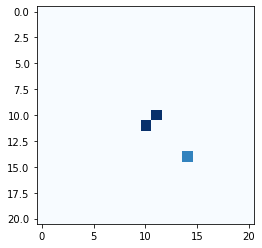

Act_State 1 : [1, 0, 0, 0] Action:  5 1019
Act_State 2 : [1, 0, 0, 0] Action:  5 1019
Act_State 3 : [1, 0, 0, 0] Action:  5 1019
Act_State 4 : [1, 0, 0, 0] Action:  5 1019


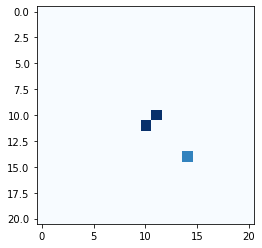

Act_State 1 : [1, 0, 0, 0] Action:  5 1019
Act_State 2 : [1, 0, 0, 0] Action:  5 1019
Act_State 3 : [1, 0, 0, 0] Action:  5 1019
Act_State 4 : [1, 0, 0, 0] Action:  5 1019


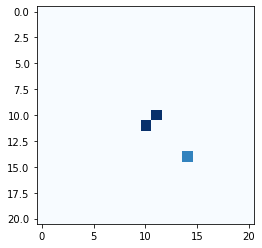

Act_State 1 : [1, 0, 0, 0] Action:  5 1019
Act_State 2 : [1, 0, 0, 0] Action:  5 1019
Act_State 3 : [1, 0, 0, 0] Action:  5 1019
Act_State 4 : [1, 0, 0, 0] Action:  5 1019


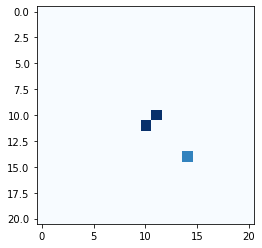

Act_State 1 : [1, 0, 0, 0] Action:  5 1019
Act_State 2 : [1, 0, 0, 0] Action:  5 1019
Act_State 3 : [1, 0, 0, 0] Action:  5 1019
Act_State 4 : [1, 0, 0, 0] Action:  5 1019


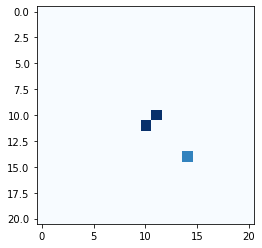

Act_State 1 : [1, 0, 0, 0] Action:  5 1019
Act_State 2 : [1, 0, 0, 0] Action:  5 1019
Act_State 3 : [1, 0, 0, 0] Action:  5 1019
Act_State 4 : [1, 0, 0, 0] Action:  5 1019


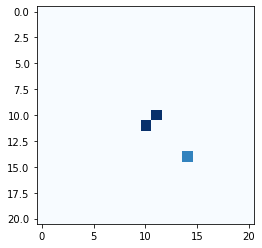

Act_State 1 : [1, 0, 0, 0] Action:  5 1019
Act_State 2 : [1, 0, 0, 0] Action:  5 1019
Act_State 3 : [1, 0, 0, 0] Action:  5 1019
Act_State 4 : [1, 0, 0, 0] Action:  5 1019


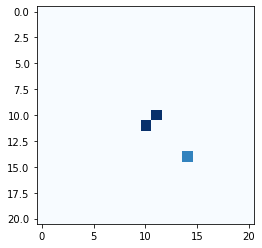

Act_State 1 : [1, 0, 0, 0] Action:  5 1019
Act_State 2 : [1, 0, 0, 0] Action:  5 1019
Act_State 3 : [1, 0, 0, 0] Action:  5 1019
Act_State 4 : [1, 0, 0, 0] Action:  5 1019


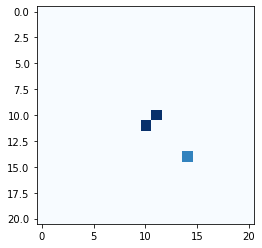

Act_State 1 : [1, 0, 0, 0] Action:  5 1019
Act_State 2 : [1, 0, 0, 0] Action:  5 1019
Act_State 3 : [1, 0, 0, 0] Action:  5 1019
Act_State 4 : [1, 0, 0, 0] Action:  5 1019


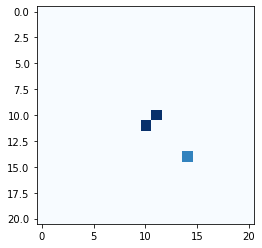

Act_State 1 : [1, 0, 0, 0] Action:  5 1019
Act_State 2 : [1, 0, 0, 0] Action:  5 1019
Act_State 3 : [1, 0, 0, 0] Action:  5 1019
Act_State 4 : [1, 0, 0, 0] Action:  5 1019


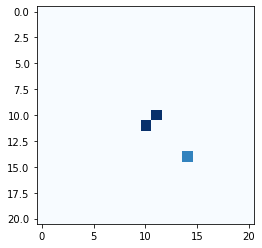

Act_State 1 : [1, 0, 0, 0] Action:  5 1019
Act_State 2 : [1, 0, 0, 0] Action:  5 1019
Act_State 3 : [1, 0, 0, 0] Action:  5 1019
Act_State 4 : [1, 0, 0, 0] Action:  5 1019


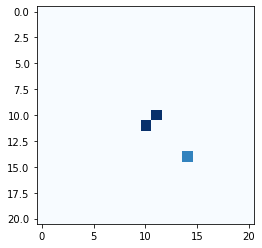

Act_State 1 : [1, 0, 0, 0] Action:  5 1019
Act_State 2 : [1, 0, 0, 0] Action:  5 1019
Act_State 3 : [1, 0, 0, 0] Action:  5 1019
Act_State 4 : [1, 0, 0, 0] Action:  5 1019


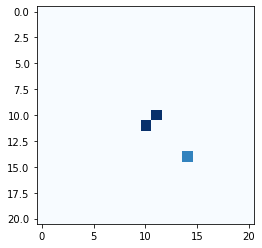

Act_State 1 : [1, 0, 0, 0] Action:  5 1019
Act_State 2 : [1, 0, 0, 0] Action:  5 1019
Act_State 3 : [1, 0, 0, 0] Action:  5 1019
Act_State 4 : [1, 0, 0, 0] Action:  5 1019


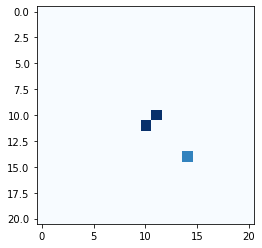

Act_State 1 : [1, 0, 0, 0] Action:  5 1019
Act_State 2 : [1, 0, 0, 0] Action:  5 1019
Act_State 3 : [1, 0, 0, 0] Action:  5 1019
Act_State 4 : [1, 0, 0, 0] Action:  5 1019


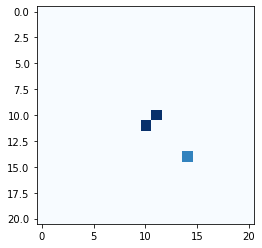

Act_State 1 : [1, 0, 0, 0] Action:  5 1019
Act_State 2 : [1, 0, 0, 0] Action:  5 1019
Act_State 3 : [1, 0, 0, 0] Action:  5 1019
Act_State 4 : [1, 0, 0, 0] Action:  5 1019


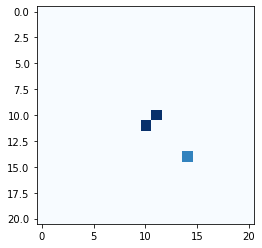

Act_State 1 : [1, 0, 0, 0] Action:  5 1019
Act_State 2 : [1, 0, 0, 0] Action:  5 1019
Act_State 3 : [1, 0, 0, 0] Action:  5 1019
Act_State 4 : [1, 0, 0, 0] Action:  5 1019


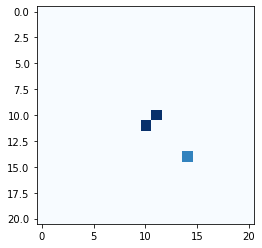

Act_State 1 : [1, 0, 0, 0] Action:  5 1019
Act_State 2 : [1, 0, 0, 0] Action:  5 1019
Act_State 3 : [1, 0, 0, 0] Action:  5 1019
Act_State 4 : [1, 0, 0, 0] Action:  5 1019


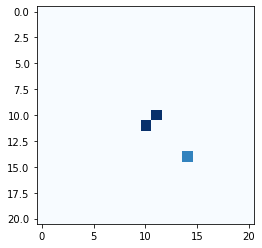

Act_State 1 : [1, 0, 0, 0] Action:  5 1019
Act_State 2 : [1, 0, 0, 0] Action:  5 1019
Act_State 3 : [1, 0, 0, 0] Action:  5 1019
Act_State 4 : [1, 0, 0, 0] Action:  5 1019


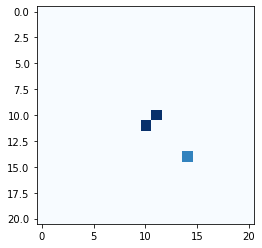

Act_State 1 : [1, 0, 0, 0] Action:  5 1019
Act_State 2 : [1, 0, 0, 0] Action:  5 1019
Act_State 3 : [1, 0, 0, 0] Action:  5 1019
Act_State 4 : [1, 0, 0, 0] Action:  5 1019


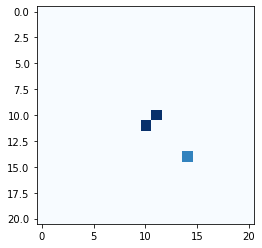

Act_State 1 : [1, 0, 0, 0] Action:  5 1019
Act_State 2 : [1, 0, 0, 0] Action:  5 1019
Act_State 3 : [1, 0, 0, 0] Action:  5 1019
Act_State 4 : [1, 0, 0, 0] Action:  5 1019


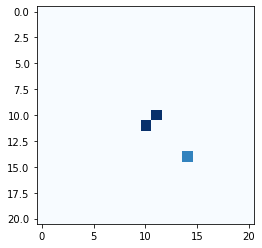

Act_State 1 : [1, 0, 0, 0] Action:  5 1019
Act_State 2 : [1, 0, 0, 0] Action:  5 1019
Act_State 3 : [1, 0, 0, 0] Action:  5 1019
Act_State 4 : [1, 0, 0, 0] Action:  5 1019


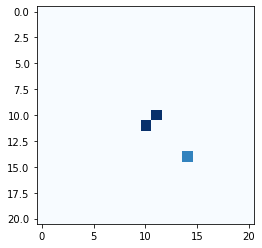

Act_State 1 : [1, 0, 0, 0] Action:  5 1019
Act_State 2 : [1, 0, 0, 0] Action:  5 1019
Act_State 3 : [1, 0, 0, 0] Action:  5 1019
Act_State 4 : [1, 0, 0, 0] Action:  5 1019


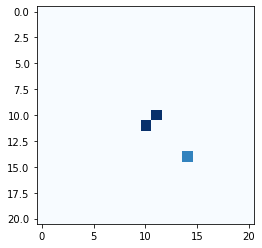

Act_State 1 : [1, 0, 0, 0] Action:  5 1019
Act_State 2 : [1, 0, 0, 0] Action:  5 1019
Act_State 3 : [1, 0, 0, 0] Action:  5 1019
Act_State 4 : [1, 0, 0, 0] Action:  5 1019


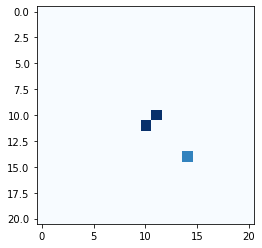

Act_State 1 : [1, 0, 0, 0] Action:  5 1019
Act_State 2 : [1, 0, 0, 0] Action:  5 1019
Act_State 3 : [1, 0, 0, 0] Action:  5 1019
Act_State 4 : [1, 0, 0, 0] Action:  5 1019


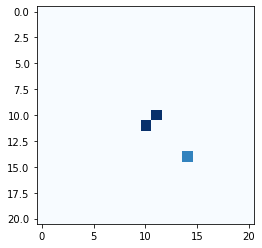

Act_State 1 : [1, 0, 0, 0] Action:  5 1019
Act_State 2 : [1, 0, 0, 0] Action:  5 1019
Act_State 3 : [1, 0, 0, 0] Action:  5 1019
Act_State 4 : [1, 0, 0, 0] Action:  5 1019


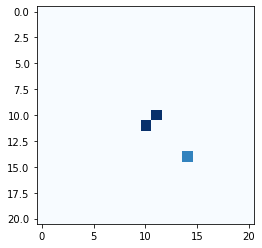

Act_State 1 : [1, 0, 0, 0] Action:  5 1019
Act_State 2 : [1, 0, 0, 0] Action:  5 1019
Act_State 3 : [1, 0, 0, 0] Action:  5 1019
Act_State 4 : [1, 0, 0, 0] Action:  5 1019


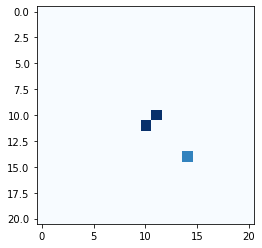

Act_State 1 : [1, 0, 0, 0] Action:  5 1019
Act_State 2 : [1, 0, 0, 0] Action:  5 1019
Act_State 3 : [1, 0, 0, 0] Action:  5 1019
Act_State 4 : [1, 0, 0, 0] Action:  5 1019


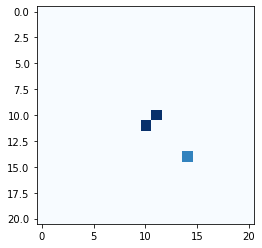

Act_State 1 : [1, 0, 0, 0] Action:  5 1019
Act_State 2 : [1, 0, 0, 0] Action:  5 1019
Act_State 3 : [1, 0, 0, 0] Action:  5 1019
Act_State 4 : [1, 0, 0, 0] Action:  5 1019


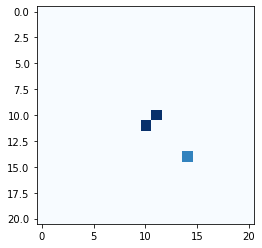

Act_State 1 : [1, 0, 0, 0] Action:  5 1019
Act_State 2 : [1, 0, 0, 0] Action:  5 1019
Act_State 3 : [1, 0, 0, 0] Action:  5 1019
Act_State 4 : [1, 0, 0, 0] Action:  5 1019


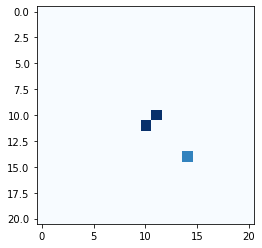

Act_State 1 : [1, 0, 0, 0] Action:  5 1019
Act_State 2 : [1, 0, 0, 0] Action:  5 1019
Act_State 3 : [1, 0, 0, 0] Action:  5 1019
Act_State 4 : [1, 0, 0, 0] Action:  5 1019


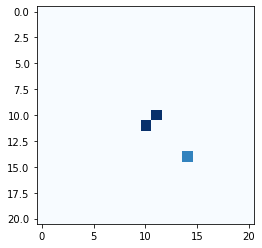

Act_State 1 : [1, 0, 0, 0] Action:  5 1019
Act_State 2 : [1, 0, 0, 0] Action:  5 1019
Act_State 3 : [1, 0, 0, 0] Action:  5 1019
Act_State 4 : [1, 0, 0, 0] Action:  5 1019


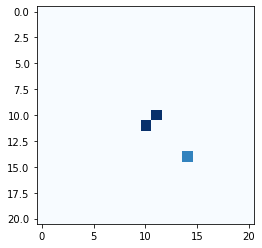

Act_State 1 : [1, 0, 0, 0] Action:  5 1019
Act_State 2 : [1, 0, 0, 0] Action:  5 1019
Act_State 3 : [1, 0, 0, 0] Action:  5 1019
Act_State 4 : [1, 0, 0, 0] Action:  5 1019


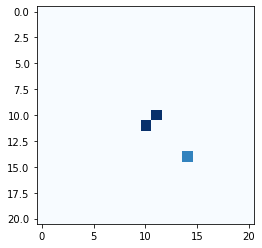

Act_State 1 : [1, 0, 0, 0] Action:  5 1019
Act_State 2 : [1, 0, 0, 0] Action:  5 1019
Act_State 3 : [1, 0, 0, 0] Action:  5 1019
Act_State 4 : [1, 0, 0, 0] Action:  5 1019


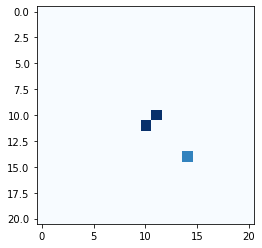

Act_State 1 : [1, 0, 0, 0] Action:  5 1019
Act_State 2 : [1, 0, 0, 0] Action:  5 1019
Act_State 3 : [1, 0, 0, 0] Action:  5 1019
Act_State 4 : [1, 0, 0, 0] Action:  5 1019


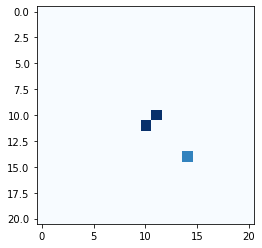

Act_State 1 : [1, 0, 0, 0] Action:  5 1019
Act_State 2 : [1, 0, 0, 0] Action:  5 1019
Act_State 3 : [1, 0, 0, 0] Action:  5 1019
Act_State 4 : [1, 0, 0, 0] Action:  5 1019


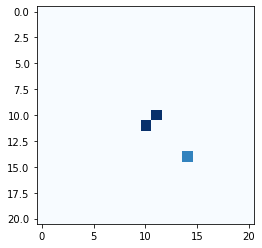

Act_State 1 : [1, 0, 0, 0] Action:  5 1019
Act_State 2 : [1, 0, 0, 0] Action:  5 1019
Act_State 3 : [1, 0, 0, 0] Action:  5 1019
Act_State 4 : [1, 0, 0, 0] Action:  5 1019


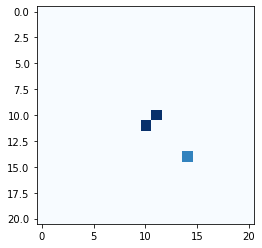

Act_State 1 : [1, 0, 0, 0] Action:  5 1019
Act_State 2 : [1, 0, 0, 0] Action:  5 1019
Act_State 3 : [1, 0, 0, 0] Action:  5 1019
Act_State 4 : [1, 0, 0, 0] Action:  5 1019


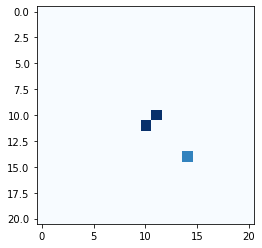

Act_State 1 : [1, 0, 0, 0] Action:  5 1019
Act_State 2 : [1, 0, 0, 0] Action:  5 1019
Act_State 3 : [1, 0, 0, 0] Action:  5 1019
Act_State 4 : [1, 0, 0, 0] Action:  5 1019


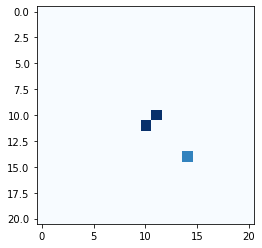

Act_State 1 : [1, 0, 0, 0] Action:  5 1019
Act_State 2 : [1, 0, 0, 0] Action:  5 1019
Act_State 3 : [1, 0, 0, 0] Action:  5 1019
Act_State 4 : [1, 0, 0, 0] Action:  5 1019


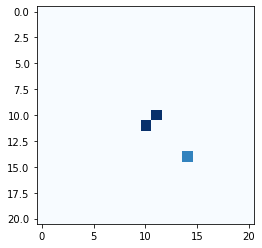

Act_State 1 : [1, 0, 0, 0] Action:  5 1019
Act_State 2 : [1, 0, 0, 0] Action:  5 1019
Act_State 3 : [1, 0, 0, 0] Action:  5 1019
Act_State 4 : [1, 0, 0, 0] Action:  5 1019


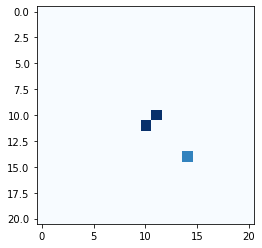

Act_State 1 : [1, 0, 0, 0] Action:  5 1019
Act_State 2 : [1, 0, 0, 0] Action:  5 1019
Act_State 3 : [1, 0, 0, 0] Action:  5 1019
Act_State 4 : [1, 0, 0, 0] Action:  5 1019


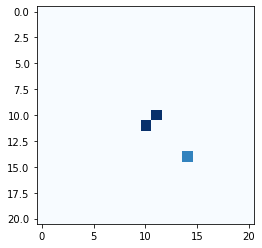

Act_State 1 : [1, 0, 0, 0] Action:  5 1019
Act_State 2 : [1, 0, 0, 0] Action:  5 1019
Act_State 3 : [1, 0, 0, 0] Action:  5 1019
Act_State 4 : [1, 0, 0, 0] Action:  5 1019


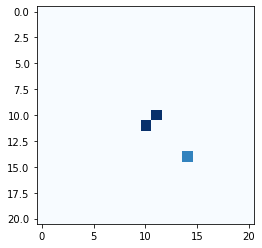

Act_State 1 : [1, 0, 0, 0] Action:  5 1019
Act_State 2 : [1, 0, 0, 0] Action:  5 1019
Act_State 3 : [1, 0, 0, 0] Action:  5 1019
Act_State 4 : [1, 0, 0, 0] Action:  5 1019


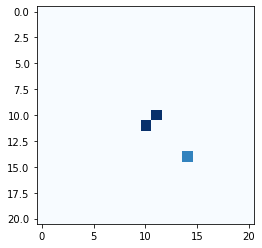

Act_State 1 : [1, 0, 0, 0] Action:  5 1019
Act_State 2 : [1, 0, 0, 0] Action:  5 1019
Act_State 3 : [1, 0, 0, 0] Action:  5 1019
Act_State 4 : [1, 0, 0, 0] Action:  5 1019


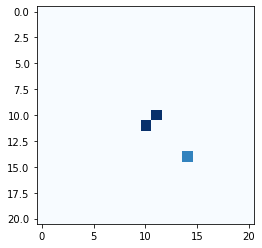

Act_State 1 : [1, 0, 0, 0] Action:  5 1019
Act_State 2 : [1, 0, 0, 0] Action:  5 1019
Act_State 3 : [1, 0, 0, 0] Action:  5 1019
Act_State 4 : [1, 0, 0, 0] Action:  5 1019


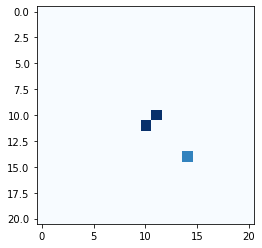

Act_State 1 : [1, 0, 0, 0] Action:  5 1019
Act_State 2 : [1, 0, 0, 0] Action:  5 1019
Act_State 3 : [1, 0, 0, 0] Action:  5 1019
Act_State 4 : [1, 1, 0, 0] Action:  4 1019


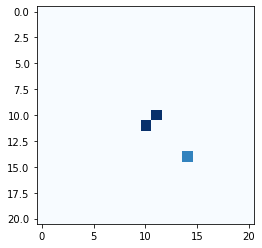

Act_State 1 : [1, 1, 0, 0] Action:  4 1019
Act_State 2 : [1, 1, 0, 0] Action:  4 1019
Act_State 3 : [1, 1, 0, 0] Action:  4 1019
Act_State 4 : [1, 1, 0, 0] Action:  4 1019


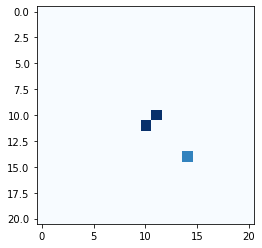

Act_State 1 : [1, 1, 0, 0] Action:  4 1019
Act_State 2 : [1, 1, 0, 0] Action:  4 1019
Act_State 3 : [1, 1, 0, 0] Action:  4 1019
Act_State 4 : [1, 1, 0, 0] Action:  4 1019


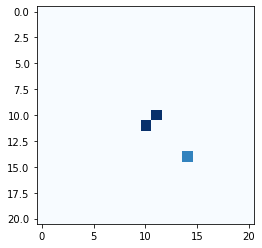

Act_State 1 : [1, 1, 0, 0] Action:  4 1019
Act_State 2 : [1, 1, 0, 0] Action:  4 1019
Act_State 3 : [1, 1, 0, 0] Action:  4 1019
Act_State 4 : [1, 1, 0, 0] Action:  4 1019


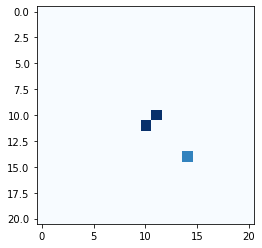

Act_State 1 : [1, 1, 0, 0] Action:  4 1019
Act_State 2 : [1, 1, 0, 0] Action:  4 1019
Act_State 3 : [1, 1, 0, 0] Action:  4 1019
Act_State 4 : [1, 1, 0, 0] Action:  4 1019
Fire ID: 1019 goes POP


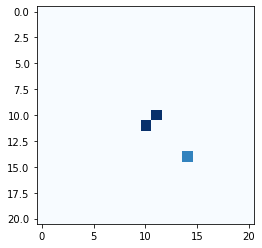

Act_State 1 : [0, 1, 0, 0] Action:  1 1019
Act_State 2 : [0, 1, 0, 0] Action:  3 1005
Act_State 3 : [0, 1, 0, 0] Action:  3 1005
Act_State 4 : [0, 1, 0, 0] Action:  3 1005


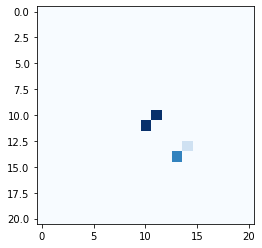

Act_State 1 : [0, 1, 0, 0] Action:  3 1005
Act_State 2 : [0, 1, 0, 0] Action:  1 1005
Act_State 3 : [0, 1, 0, 0] Action:  1 1005
Act_State 4 : [0, 1, 0, 0] Action:  1 1005


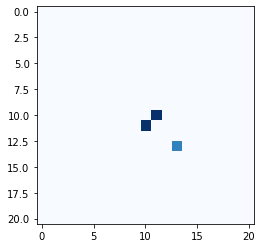

Act_State 1 : [0, 1, 0, 0] Action:  3 1005
Act_State 2 : [0, 1, 0, 0] Action:  3 1005
Act_State 3 : [0, 1, 0, 0] Action:  3 1005
Act_State 4 : [0, 1, 0, 0] Action:  3 1005


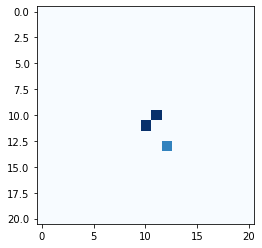

Act_State 1 : [0, 1, 0, 0] Action:  1 1005
Act_State 2 : [0, 1, 0, 0] Action:  1 1005
Act_State 3 : [0, 1, 0, 0] Action:  1 1005
Act_State 4 : [0, 1, 0, 0] Action:  1 1005


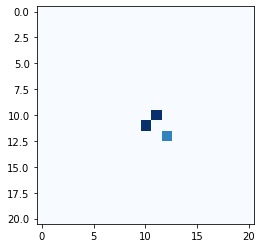

Act_State 1 : [0, 1, 0, 0] Action:  3 1005
Act_State 2 : [0, 1, 0, 0] Action:  3 1005
Act_State 3 : [0, 1, 0, 0] Action:  3 1005
Act_State 4 : [0, 1, 0, 0] Action:  3 1005


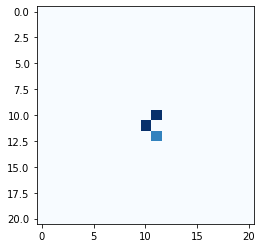

Act_State 1 : [0, 1, 0, 0] Action:  1 1005
Act_State 2 : [0, 1, 0, 0] Action:  1 1005
Act_State 3 : [0, 1, 0, 0] Action:  1 1005
Act_State 4 : [0, 1, 0, 0] Action:  1 1005


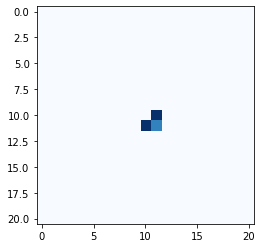

Act_State 1 : [0, 1, 0, 0] Action:  3 1005
Act_State 2 : [0, 1, 0, 0] Action:  3 1005
Act_State 3 : [0, 1, 0, 0] Action:  3 1005
Act_State 4 : [0, 1, 0, 0] Action:  3 1005


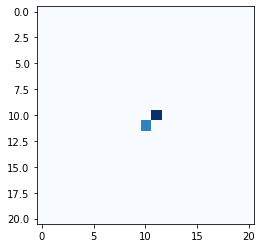

Act_State 1 : [1, 1, 0, 0] Action:  4 1005
Act_State 2 : [1, 1, 0, 0] Action:  4 1005
Act_State 3 : [1, 1, 0, 0] Action:  4 1005
Act_State 4 : [1, 1, 0, 0] Action:  4 1005


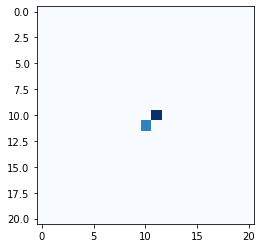

Act_State 1 : [1, 0, 0, 0] Action:  5 1005
Act_State 2 : [1, 0, 0, 0] Action:  5 1005
Act_State 3 : [1, 0, 0, 0] Action:  5 1005
Act_State 4 : [1, 0, 0, 0] Action:  5 1005


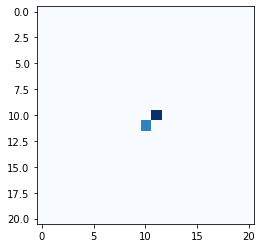

Act_State 1 : [1, 0, 0, 0] Action:  5 1005
Act_State 2 : [1, 0, 0, 0] Action:  5 1005
Act_State 3 : [1, 0, 0, 0] Action:  5 1005
Act_State 4 : [1, 0, 0, 0] Action:  5 1005


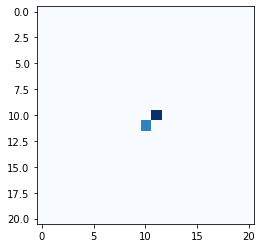

Act_State 1 : [1, 0, 0, 0] Action:  5 1005
Act_State 2 : [1, 0, 0, 0] Action:  5 1005
Act_State 3 : [1, 0, 0, 0] Action:  5 1005
Act_State 4 : [1, 0, 0, 0] Action:  5 1005


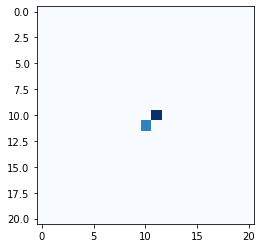

Act_State 1 : [1, 0, 0, 0] Action:  5 1005
Act_State 2 : [1, 0, 0, 0] Action:  5 1005
Act_State 3 : [1, 0, 0, 0] Action:  5 1005
Act_State 4 : [1, 0, 0, 0] Action:  5 1005


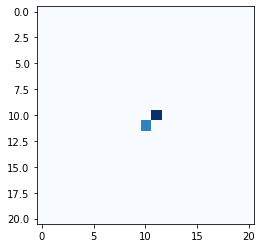

Act_State 1 : [1, 0, 0, 0] Action:  5 1005
Act_State 2 : [1, 0, 0, 0] Action:  5 1005
Act_State 3 : [1, 0, 0, 0] Action:  5 1005
Act_State 4 : [1, 0, 0, 0] Action:  5 1005


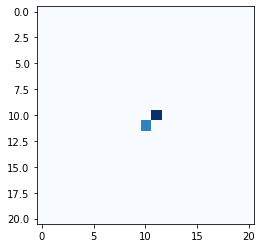

Act_State 1 : [1, 0, 0, 0] Action:  5 1005
Act_State 2 : [1, 0, 0, 0] Action:  5 1005
Act_State 3 : [1, 0, 0, 0] Action:  5 1005
Act_State 4 : [1, 0, 0, 0] Action:  5 1005


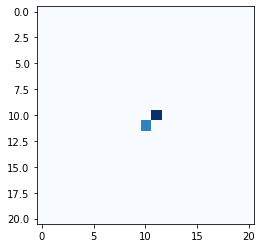

Act_State 1 : [1, 0, 0, 0] Action:  5 1005
Act_State 2 : [1, 0, 0, 0] Action:  5 1005
Act_State 3 : [1, 0, 0, 0] Action:  5 1005
Act_State 4 : [1, 0, 0, 0] Action:  5 1005


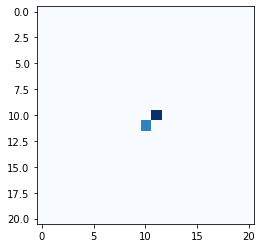

Act_State 1 : [1, 0, 0, 0] Action:  5 1005
Act_State 2 : [1, 0, 0, 0] Action:  5 1005
Act_State 3 : [1, 0, 0, 0] Action:  5 1005
Act_State 4 : [1, 0, 0, 0] Action:  5 1005


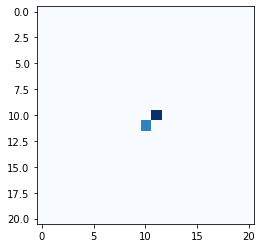

Act_State 1 : [1, 0, 0, 0] Action:  5 1005
Act_State 2 : [1, 0, 0, 0] Action:  5 1005
Act_State 3 : [1, 0, 0, 0] Action:  5 1005
Act_State 4 : [1, 0, 0, 0] Action:  5 1005


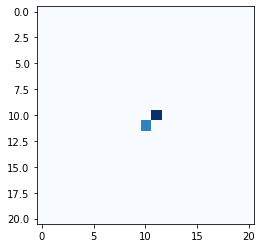

Act_State 1 : [1, 0, 0, 0] Action:  5 1005
Act_State 2 : [1, 0, 0, 0] Action:  5 1005
Act_State 3 : [1, 0, 0, 0] Action:  5 1005
Act_State 4 : [1, 0, 0, 0] Action:  5 1005


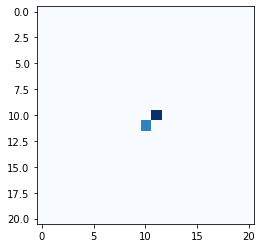

Act_State 1 : [1, 0, 0, 0] Action:  5 1005
Act_State 2 : [1, 0, 0, 0] Action:  5 1005
Act_State 3 : [1, 0, 0, 0] Action:  5 1005
Act_State 4 : [1, 0, 0, 0] Action:  5 1005


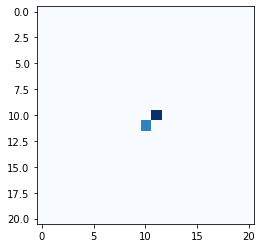

Act_State 1 : [1, 0, 0, 0] Action:  5 1005
Act_State 2 : [1, 0, 0, 0] Action:  5 1005
Act_State 3 : [1, 0, 0, 0] Action:  5 1005
Act_State 4 : [1, 0, 0, 0] Action:  5 1005


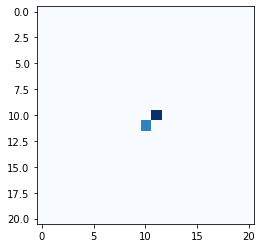

Act_State 1 : [1, 0, 0, 0] Action:  5 1005
Act_State 2 : [1, 0, 0, 0] Action:  5 1005
Act_State 3 : [1, 0, 0, 0] Action:  5 1005
Act_State 4 : [1, 0, 0, 0] Action:  5 1005


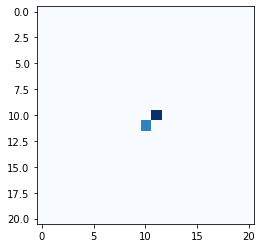

Act_State 1 : [1, 0, 0, 0] Action:  5 1005
Act_State 2 : [1, 0, 0, 0] Action:  5 1005
Act_State 3 : [1, 0, 0, 0] Action:  5 1005
Act_State 4 : [1, 0, 0, 0] Action:  5 1005


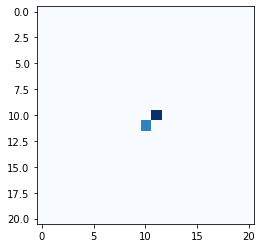

Act_State 1 : [1, 0, 0, 0] Action:  5 1005
Act_State 2 : [1, 0, 0, 0] Action:  5 1005
Act_State 3 : [1, 0, 0, 0] Action:  5 1005
Act_State 4 : [1, 0, 0, 0] Action:  5 1005


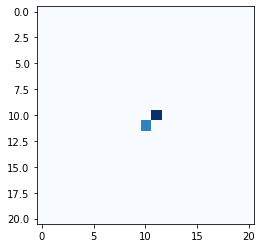

Act_State 1 : [1, 0, 0, 0] Action:  5 1005
Act_State 2 : [1, 0, 0, 0] Action:  5 1005
Act_State 3 : [1, 0, 0, 0] Action:  5 1005
Act_State 4 : [1, 0, 0, 0] Action:  5 1005


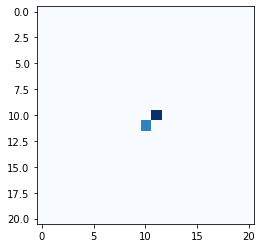

Act_State 1 : [1, 0, 0, 0] Action:  5 1005
Act_State 2 : [1, 0, 0, 0] Action:  5 1005
Act_State 3 : [1, 0, 0, 0] Action:  5 1005
Act_State 4 : [1, 0, 0, 0] Action:  5 1005


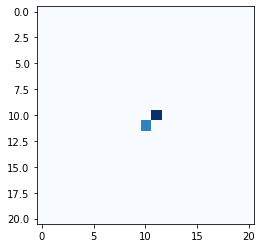

Act_State 1 : [1, 0, 0, 0] Action:  5 1005
Act_State 2 : [1, 0, 0, 0] Action:  5 1005
Act_State 3 : [1, 0, 0, 0] Action:  5 1005
Act_State 4 : [1, 0, 0, 0] Action:  5 1005


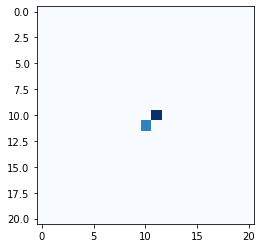

Act_State 1 : [1, 0, 0, 0] Action:  5 1005
Act_State 2 : [1, 0, 0, 0] Action:  5 1005
Act_State 3 : [1, 0, 0, 0] Action:  5 1005
Act_State 4 : [1, 0, 0, 0] Action:  5 1005


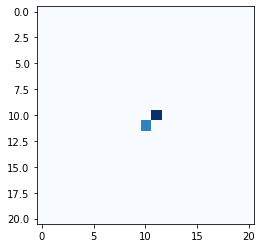

Act_State 1 : [1, 0, 0, 0] Action:  5 1005
Act_State 2 : [1, 0, 0, 0] Action:  5 1005
Act_State 3 : [1, 0, 0, 0] Action:  5 1005
Act_State 4 : [1, 0, 0, 0] Action:  5 1005


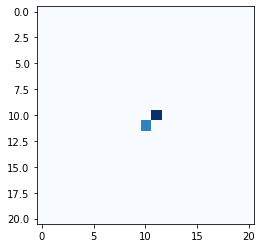

Act_State 1 : [1, 0, 0, 0] Action:  5 1005
Act_State 2 : [1, 0, 0, 0] Action:  5 1005
Act_State 3 : [1, 0, 0, 0] Action:  5 1005
Act_State 4 : [1, 0, 0, 0] Action:  5 1005


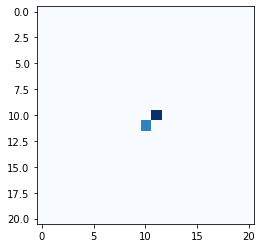

Act_State 1 : [1, 0, 0, 0] Action:  5 1005
Act_State 2 : [1, 0, 0, 0] Action:  5 1005
Act_State 3 : [1, 0, 0, 0] Action:  5 1005
Act_State 4 : [1, 0, 0, 0] Action:  5 1005


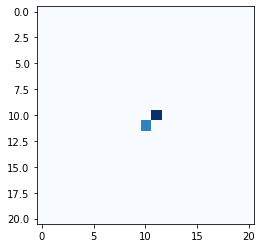

Act_State 1 : [1, 0, 0, 0] Action:  5 1005
Act_State 2 : [1, 0, 0, 0] Action:  5 1005
Act_State 3 : [1, 0, 0, 0] Action:  5 1005
Act_State 4 : [1, 0, 0, 0] Action:  5 1005


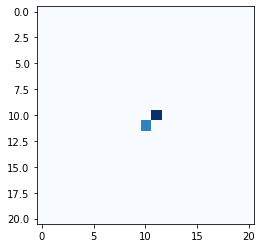

Act_State 1 : [1, 0, 0, 0] Action:  5 1005
Act_State 2 : [1, 0, 0, 0] Action:  5 1005
Act_State 3 : [1, 0, 0, 0] Action:  5 1005
Act_State 4 : [1, 0, 0, 0] Action:  5 1005


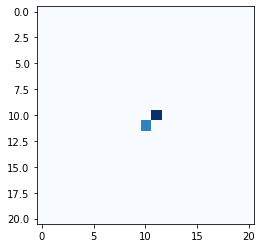

Act_State 1 : [1, 0, 0, 0] Action:  5 1005
Act_State 2 : [1, 0, 0, 0] Action:  5 1005
Act_State 3 : [1, 0, 0, 0] Action:  5 1005
Act_State 4 : [1, 0, 0, 0] Action:  5 1005


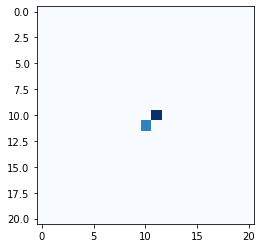

Act_State 1 : [1, 0, 0, 0] Action:  5 1005
Act_State 2 : [1, 0, 0, 0] Action:  5 1005
Act_State 3 : [1, 0, 0, 0] Action:  5 1005
Act_State 4 : [1, 0, 0, 0] Action:  5 1005


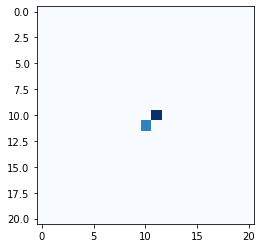

Act_State 1 : [1, 0, 0, 0] Action:  5 1005
Act_State 2 : [1, 0, 0, 0] Action:  5 1005
Act_State 3 : [1, 0, 0, 0] Action:  5 1005
Act_State 4 : [1, 0, 0, 0] Action:  5 1005


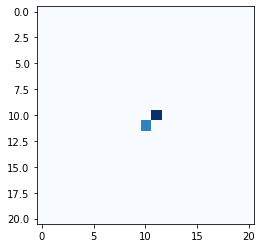

Act_State 1 : [1, 0, 0, 0] Action:  5 1005
Act_State 2 : [1, 0, 0, 0] Action:  5 1005
Act_State 3 : [1, 0, 0, 0] Action:  5 1005
Act_State 4 : [1, 0, 0, 0] Action:  5 1005


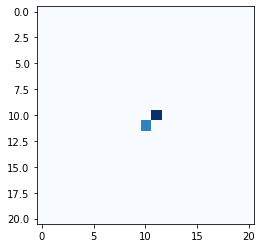

Act_State 1 : [1, 0, 0, 0] Action:  5 1005
Act_State 2 : [1, 0, 0, 0] Action:  5 1005
Act_State 3 : [1, 0, 0, 0] Action:  5 1005
Act_State 4 : [1, 0, 0, 0] Action:  5 1005


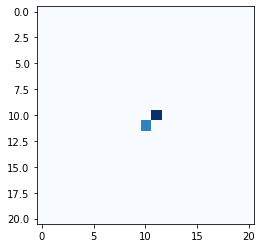

Act_State 1 : [1, 0, 0, 0] Action:  5 1005
Act_State 2 : [1, 0, 0, 0] Action:  5 1005
Act_State 3 : [1, 0, 0, 0] Action:  5 1005
Act_State 4 : [1, 0, 0, 0] Action:  5 1005


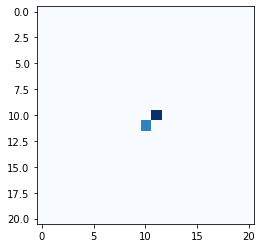

Act_State 1 : [1, 0, 0, 0] Action:  5 1005
Act_State 2 : [1, 0, 0, 0] Action:  5 1005
Act_State 3 : [1, 0, 0, 0] Action:  5 1005
Act_State 4 : [1, 0, 0, 0] Action:  5 1005


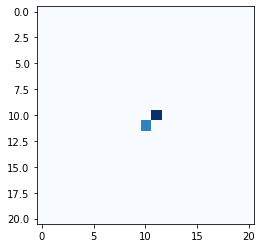

Act_State 1 : [1, 0, 0, 0] Action:  5 1005
Act_State 2 : [1, 0, 0, 0] Action:  5 1005
Act_State 3 : [1, 0, 0, 0] Action:  5 1005
Act_State 4 : [1, 0, 0, 0] Action:  5 1005


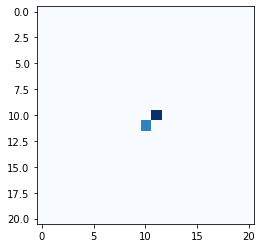

Act_State 1 : [1, 0, 0, 0] Action:  5 1005
Act_State 2 : [1, 0, 0, 0] Action:  5 1005
Act_State 3 : [1, 0, 0, 0] Action:  5 1005
Act_State 4 : [1, 0, 0, 0] Action:  5 1005


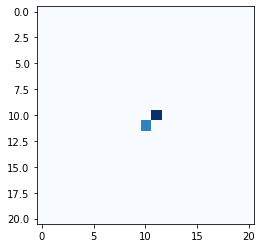

Act_State 1 : [1, 0, 0, 0] Action:  5 1005
Act_State 2 : [1, 0, 0, 0] Action:  5 1005
Act_State 3 : [1, 0, 0, 0] Action:  5 1005
Act_State 4 : [1, 0, 0, 0] Action:  5 1005


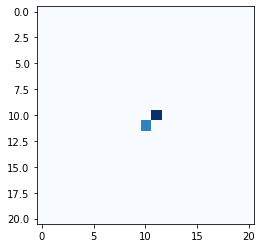

Act_State 1 : [1, 0, 0, 0] Action:  5 1005
Act_State 2 : [1, 0, 0, 0] Action:  5 1005
Act_State 3 : [1, 0, 0, 0] Action:  5 1005
Act_State 4 : [1, 0, 0, 0] Action:  5 1005


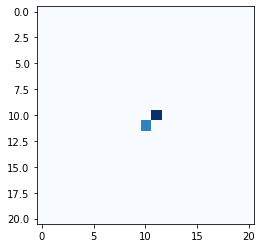

Act_State 1 : [1, 0, 0, 0] Action:  5 1005
Act_State 2 : [1, 0, 0, 0] Action:  5 1005
Act_State 3 : [1, 0, 0, 0] Action:  5 1005
Act_State 4 : [1, 0, 0, 0] Action:  5 1005


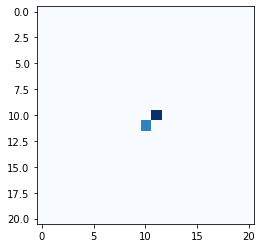

Act_State 1 : [1, 0, 0, 0] Action:  5 1005
Act_State 2 : [1, 0, 0, 0] Action:  5 1005
Act_State 3 : [1, 0, 0, 0] Action:  5 1005
Act_State 4 : [1, 0, 0, 0] Action:  5 1005


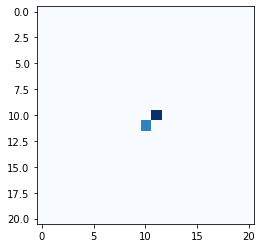

Act_State 1 : [1, 0, 0, 0] Action:  5 1005
Act_State 2 : [1, 0, 0, 0] Action:  5 1005
Act_State 3 : [1, 0, 0, 0] Action:  5 1005
Act_State 4 : [1, 0, 0, 0] Action:  5 1005


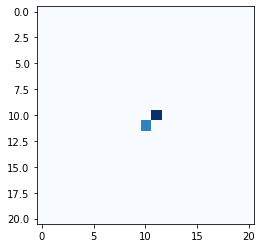

Act_State 1 : [1, 0, 0, 0] Action:  5 1005
Act_State 2 : [1, 0, 0, 0] Action:  5 1005
Act_State 3 : [1, 0, 0, 0] Action:  5 1005
Act_State 4 : [1, 0, 0, 0] Action:  5 1005


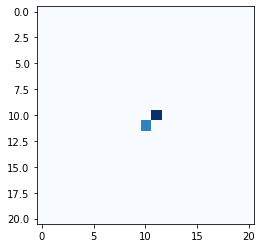

Act_State 1 : [1, 0, 0, 0] Action:  5 1005
Act_State 2 : [1, 0, 0, 0] Action:  5 1005
Act_State 3 : [1, 0, 0, 0] Action:  5 1005
Act_State 4 : [1, 0, 0, 0] Action:  5 1005


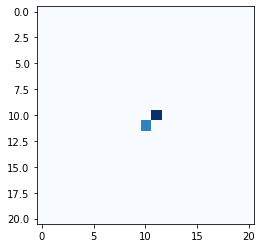

Act_State 1 : [1, 0, 0, 0] Action:  5 1005
Act_State 2 : [1, 0, 0, 0] Action:  5 1005
Act_State 3 : [1, 0, 0, 0] Action:  5 1005
Act_State 4 : [1, 0, 0, 0] Action:  5 1005


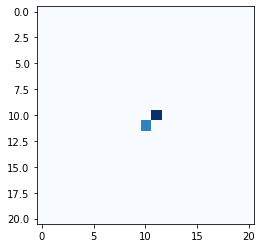

Act_State 1 : [1, 0, 0, 0] Action:  5 1005
Act_State 2 : [1, 0, 0, 0] Action:  5 1005
Act_State 3 : [1, 0, 0, 0] Action:  5 1005
Act_State 4 : [1, 0, 0, 0] Action:  5 1005


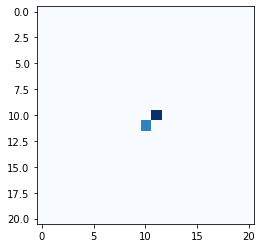

Act_State 1 : [1, 0, 0, 0] Action:  5 1005
Act_State 2 : [1, 0, 0, 0] Action:  5 1005
Act_State 3 : [1, 0, 0, 0] Action:  5 1005
Act_State 4 : [1, 0, 0, 0] Action:  5 1005


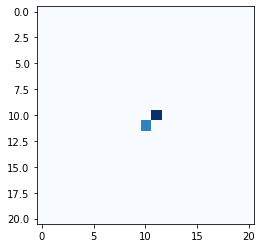

Act_State 1 : [1, 0, 0, 0] Action:  5 1005
Act_State 2 : [1, 0, 0, 0] Action:  5 1005
Act_State 3 : [1, 0, 0, 0] Action:  5 1005
Act_State 4 : [1, 0, 0, 0] Action:  5 1005


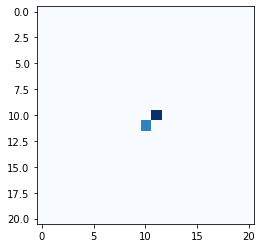

Act_State 1 : [1, 0, 0, 0] Action:  5 1005
Act_State 2 : [1, 0, 0, 0] Action:  5 1005
Act_State 3 : [1, 0, 0, 0] Action:  5 1005
Act_State 4 : [1, 0, 0, 0] Action:  5 1005


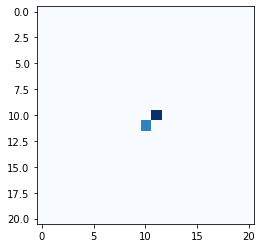

Act_State 1 : [1, 0, 0, 0] Action:  5 1005
Act_State 2 : [1, 0, 0, 0] Action:  5 1005
Act_State 3 : [1, 0, 0, 0] Action:  5 1005
Act_State 4 : [1, 0, 0, 0] Action:  5 1005


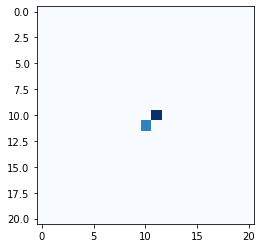

Act_State 1 : [1, 0, 0, 0] Action:  5 1005
Act_State 2 : [1, 0, 0, 0] Action:  5 1005
Act_State 3 : [1, 0, 0, 0] Action:  5 1005
Act_State 4 : [1, 0, 0, 0] Action:  5 1005


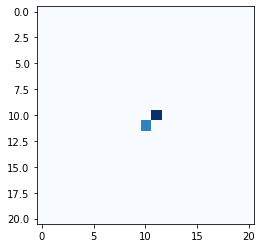

Act_State 1 : [1, 0, 0, 0] Action:  5 1005
Act_State 2 : [1, 0, 0, 0] Action:  5 1005
Act_State 3 : [1, 0, 0, 0] Action:  5 1005
Act_State 4 : [1, 0, 0, 0] Action:  5 1005


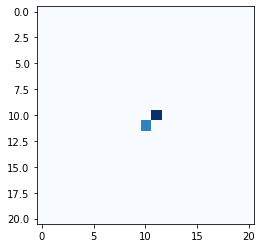

Act_State 1 : [1, 0, 0, 0] Action:  5 1005
Act_State 2 : [1, 0, 0, 0] Action:  5 1005
Act_State 3 : [1, 0, 0, 0] Action:  5 1005
Act_State 4 : [1, 0, 0, 0] Action:  5 1005


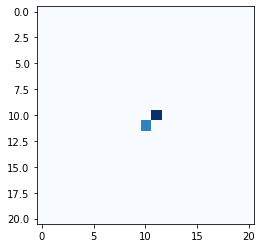

Act_State 1 : [1, 0, 0, 0] Action:  5 1005
Act_State 2 : [1, 0, 0, 0] Action:  5 1005
Act_State 3 : [1, 0, 0, 0] Action:  5 1005
Act_State 4 : [1, 0, 0, 0] Action:  5 1005


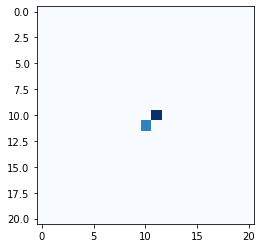

Act_State 1 : [1, 0, 0, 0] Action:  5 1005
Act_State 2 : [1, 0, 0, 0] Action:  5 1005
Act_State 3 : [1, 0, 0, 0] Action:  5 1005
Act_State 4 : [1, 0, 0, 0] Action:  5 1005


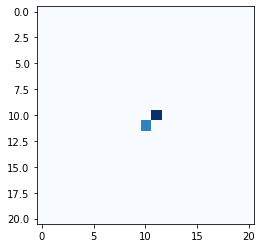

Act_State 1 : [1, 0, 0, 0] Action:  5 1005
Act_State 2 : [1, 0, 0, 0] Action:  5 1005
Act_State 3 : [1, 0, 0, 0] Action:  5 1005
Act_State 4 : [1, 0, 0, 0] Action:  5 1005


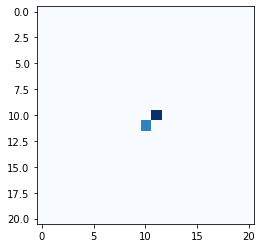

Act_State 1 : [1, 0, 0, 0] Action:  5 1005
Act_State 2 : [1, 1, 0, 0] Action:  4 1005
Act_State 3 : [1, 1, 0, 0] Action:  4 1005
Act_State 4 : [1, 1, 0, 0] Action:  4 1005


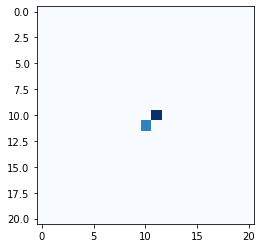

Act_State 1 : [1, 1, 0, 0] Action:  4 1005
Act_State 2 : [1, 1, 0, 0] Action:  4 1005
Act_State 3 : [1, 1, 0, 0] Action:  4 1005
Act_State 4 : [1, 1, 0, 0] Action:  4 1005


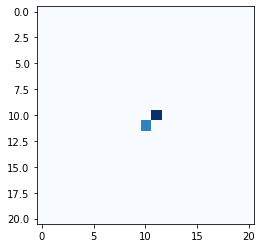

Act_State 1 : [1, 1, 0, 0] Action:  4 1005
Act_State 2 : [1, 1, 0, 0] Action:  4 1005
Act_State 3 : [1, 1, 0, 0] Action:  4 1005
Act_State 4 : [1, 1, 0, 0] Action:  4 1005


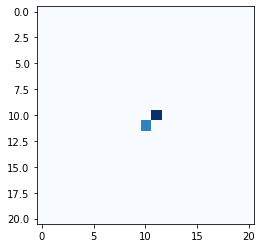

Act_State 1 : [1, 1, 0, 0] Action:  4 1005
Act_State 2 : [1, 1, 0, 0] Action:  4 1005
Act_State 3 : [1, 1, 0, 0] Action:  4 1005
Act_State 4 : [1, 1, 0, 0] Action:  4 1005


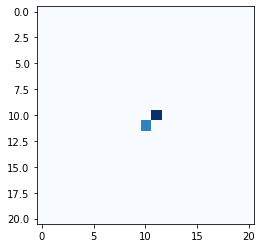

Act_State 1 : [1, 1, 0, 0] Action:  4 1005
Act_State 2 : [1, 1, 0, 0] Action:  4 1005
Act_State 3 : [1, 1, 0, 0] Action:  4 1005
Act_State 4 : [1, 1, 0, 0] Action:  4 1005
Fire ID: 1005 goes POP


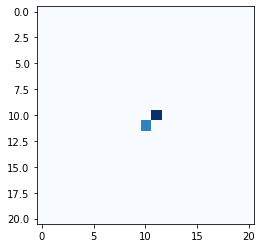

Act_State 1 : [0, 1, 0, 0] Action:  1 1005
Act_State 2 : [0, 1, 0, 0] Action:  1 1012
Act_State 3 : [0, 1, 0, 0] Action:  1 1012
Act_State 4 : [0, 1, 0, 0] Action:  1 1012


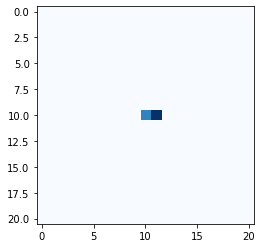

Act_State 1 : [0, 1, 0, 0] Action:  2 1012
Act_State 2 : [0, 1, 0, 0] Action:  2 1012
Act_State 3 : [0, 1, 0, 0] Action:  2 1012
Act_State 4 : [0, 1, 0, 0] Action:  2 1012


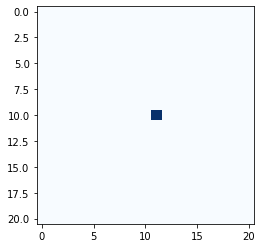

Act_State 1 : [1, 1, 0, 0] Action:  4 1012
Act_State 2 : [1, 1, 0, 0] Action:  4 1012
Act_State 3 : [1, 1, 0, 0] Action:  4 1012
Act_State 4 : [1, 1, 0, 0] Action:  4 1012


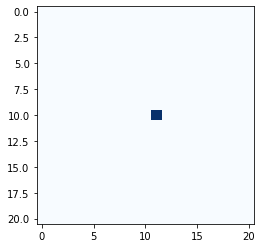

Act_State 1 : [1, 0, 0, 0] Action:  5 1012
Act_State 2 : [1, 0, 0, 0] Action:  5 1012
Act_State 3 : [1, 0, 0, 0] Action:  5 1012
Act_State 4 : [1, 0, 0, 0] Action:  5 1012


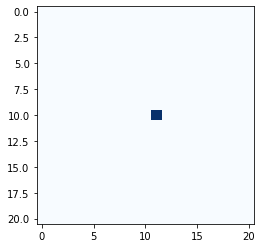

Act_State 1 : [1, 0, 0, 0] Action:  5 1012
Act_State 2 : [1, 0, 0, 0] Action:  5 1012
Act_State 3 : [1, 0, 0, 0] Action:  5 1012
Act_State 4 : [1, 0, 0, 0] Action:  5 1012


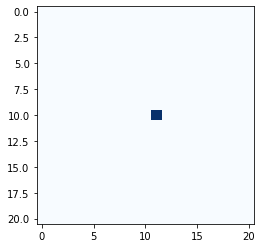

Act_State 1 : [1, 0, 0, 0] Action:  5 1012
Act_State 2 : [1, 0, 0, 0] Action:  5 1012
Act_State 3 : [1, 0, 0, 0] Action:  5 1012
Act_State 4 : [1, 0, 0, 0] Action:  5 1012


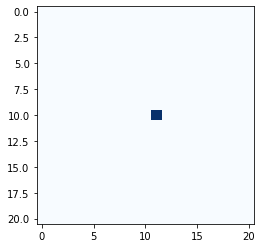

Act_State 1 : [1, 0, 0, 0] Action:  5 1012
Act_State 2 : [1, 0, 0, 0] Action:  5 1012
Act_State 3 : [1, 0, 0, 0] Action:  5 1012
Act_State 4 : [1, 0, 0, 0] Action:  5 1012


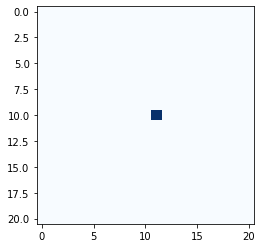

Act_State 1 : [1, 0, 0, 0] Action:  5 1012
Act_State 2 : [1, 0, 0, 0] Action:  5 1012
Act_State 3 : [1, 0, 0, 0] Action:  5 1012
Act_State 4 : [1, 0, 0, 0] Action:  5 1012


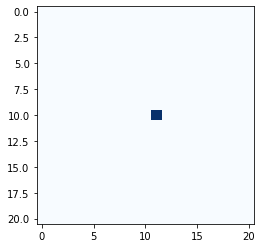

Act_State 1 : [1, 0, 0, 0] Action:  5 1012
Act_State 2 : [1, 0, 0, 0] Action:  5 1012
Act_State 3 : [1, 0, 0, 0] Action:  5 1012
Act_State 4 : [1, 0, 0, 0] Action:  5 1012


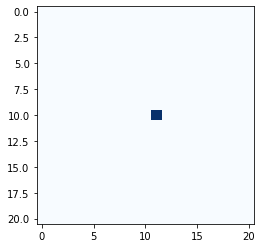

Act_State 1 : [1, 0, 0, 0] Action:  5 1012
Act_State 2 : [1, 0, 0, 0] Action:  5 1012
Act_State 3 : [1, 0, 0, 0] Action:  5 1012
Act_State 4 : [1, 0, 0, 0] Action:  5 1012


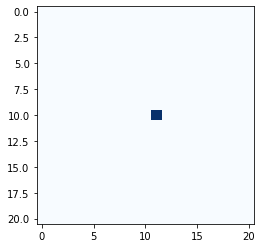

Act_State 1 : [1, 0, 0, 0] Action:  5 1012
Act_State 2 : [1, 0, 0, 0] Action:  5 1012
Act_State 3 : [1, 0, 0, 0] Action:  5 1012
Act_State 4 : [1, 0, 0, 0] Action:  5 1012


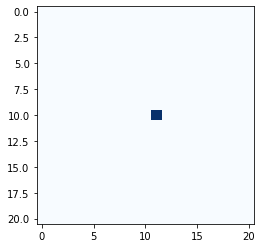

Act_State 1 : [1, 0, 0, 0] Action:  5 1012
Act_State 2 : [1, 0, 0, 0] Action:  5 1012
Act_State 3 : [1, 0, 0, 0] Action:  5 1012
Act_State 4 : [1, 0, 0, 0] Action:  5 1012


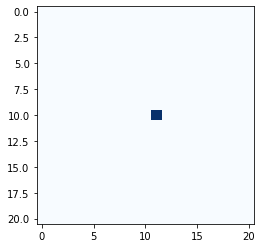

Act_State 1 : [1, 0, 0, 0] Action:  5 1012
Act_State 2 : [1, 0, 0, 0] Action:  5 1012
Act_State 3 : [1, 0, 0, 0] Action:  5 1012
Act_State 4 : [1, 0, 0, 0] Action:  5 1012


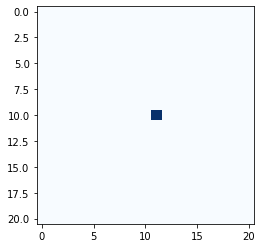

Act_State 1 : [1, 0, 0, 0] Action:  5 1012
Act_State 2 : [1, 0, 0, 0] Action:  5 1012
Act_State 3 : [1, 0, 0, 0] Action:  5 1012
Act_State 4 : [1, 0, 0, 0] Action:  5 1012


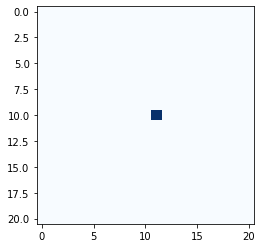

Act_State 1 : [1, 0, 0, 0] Action:  5 1012
Act_State 2 : [1, 0, 0, 0] Action:  5 1012
Act_State 3 : [1, 0, 0, 0] Action:  5 1012
Act_State 4 : [1, 0, 0, 0] Action:  5 1012


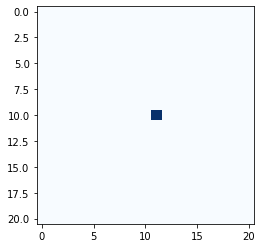

Act_State 1 : [1, 0, 0, 0] Action:  5 1012
Act_State 2 : [1, 0, 0, 0] Action:  5 1012
Act_State 3 : [1, 0, 0, 0] Action:  5 1012
Act_State 4 : [1, 0, 0, 0] Action:  5 1012


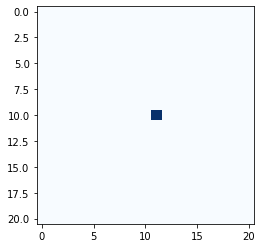

Act_State 1 : [1, 0, 0, 0] Action:  5 1012
Act_State 2 : [1, 0, 0, 0] Action:  5 1012
Act_State 3 : [1, 0, 0, 0] Action:  5 1012
Act_State 4 : [1, 0, 0, 0] Action:  5 1012


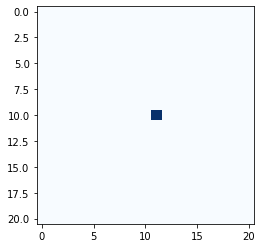

Act_State 1 : [1, 0, 0, 0] Action:  5 1012
Act_State 2 : [1, 0, 0, 0] Action:  5 1012
Act_State 3 : [1, 0, 0, 0] Action:  5 1012
Act_State 4 : [1, 0, 0, 0] Action:  5 1012


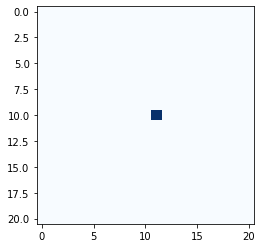

Act_State 1 : [1, 0, 0, 0] Action:  5 1012
Act_State 2 : [1, 0, 0, 0] Action:  5 1012
Act_State 3 : [1, 0, 0, 0] Action:  5 1012
Act_State 4 : [1, 0, 0, 0] Action:  5 1012


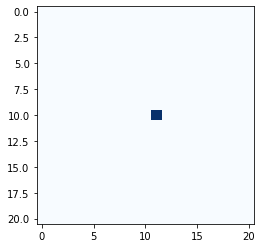

Act_State 1 : [1, 0, 0, 0] Action:  5 1012
Act_State 2 : [1, 0, 0, 0] Action:  5 1012
Act_State 3 : [1, 0, 0, 0] Action:  5 1012
Act_State 4 : [1, 0, 0, 0] Action:  5 1012


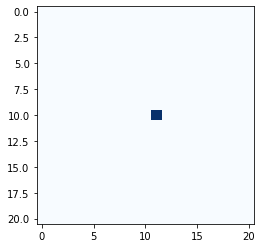

Act_State 1 : [1, 0, 0, 0] Action:  5 1012
Act_State 2 : [1, 0, 0, 0] Action:  5 1012
Act_State 3 : [1, 0, 0, 0] Action:  5 1012
Act_State 4 : [1, 0, 0, 0] Action:  5 1012


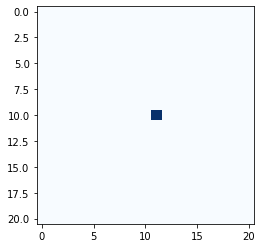

Act_State 1 : [1, 0, 0, 0] Action:  5 1012
Act_State 2 : [1, 0, 0, 0] Action:  5 1012
Act_State 3 : [1, 0, 0, 0] Action:  5 1012
Act_State 4 : [1, 0, 0, 0] Action:  5 1012


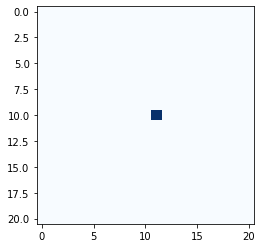

Act_State 1 : [1, 0, 0, 0] Action:  5 1012
Act_State 2 : [1, 0, 0, 0] Action:  5 1012
Act_State 3 : [1, 0, 0, 0] Action:  5 1012
Act_State 4 : [1, 0, 0, 0] Action:  5 1012


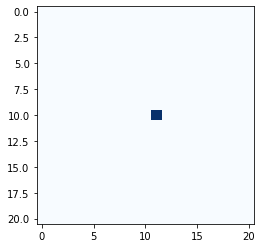

Act_State 1 : [1, 0, 0, 0] Action:  5 1012
Act_State 2 : [1, 0, 0, 0] Action:  5 1012
Act_State 3 : [1, 0, 0, 0] Action:  5 1012
Act_State 4 : [1, 0, 0, 0] Action:  5 1012


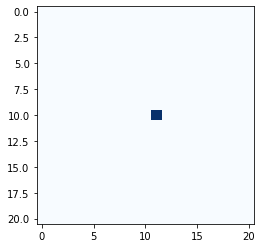

Act_State 1 : [1, 0, 0, 0] Action:  5 1012
Act_State 2 : [1, 0, 0, 0] Action:  5 1012
Act_State 3 : [1, 0, 0, 0] Action:  5 1012
Act_State 4 : [1, 0, 0, 0] Action:  5 1012


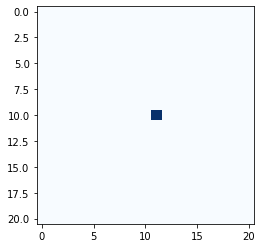

Act_State 1 : [1, 0, 0, 0] Action:  5 1012
Act_State 2 : [1, 0, 0, 0] Action:  5 1012
Act_State 3 : [1, 0, 0, 0] Action:  5 1012
Act_State 4 : [1, 0, 0, 0] Action:  5 1012


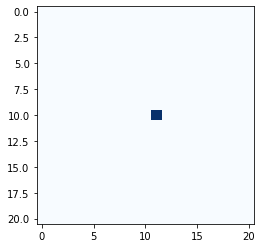

Act_State 1 : [1, 0, 0, 0] Action:  5 1012
Act_State 2 : [1, 0, 0, 0] Action:  5 1012
Act_State 3 : [1, 0, 0, 0] Action:  5 1012
Act_State 4 : [1, 0, 0, 0] Action:  5 1012


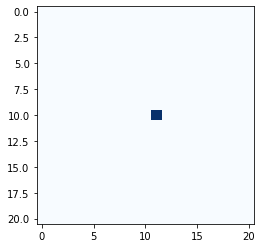

Act_State 1 : [1, 0, 0, 0] Action:  5 1012
Act_State 2 : [1, 0, 0, 0] Action:  5 1012
Act_State 3 : [1, 0, 0, 0] Action:  5 1012
Act_State 4 : [1, 0, 0, 0] Action:  5 1012


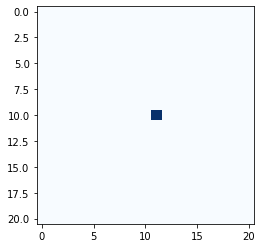

Act_State 1 : [1, 0, 0, 0] Action:  5 1012
Act_State 2 : [1, 0, 0, 0] Action:  5 1012
Act_State 3 : [1, 0, 0, 0] Action:  5 1012
Act_State 4 : [1, 0, 0, 0] Action:  5 1012


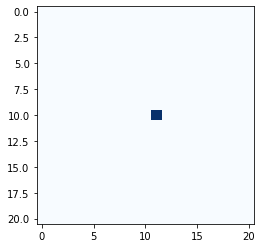

Act_State 1 : [1, 0, 0, 0] Action:  5 1012
Act_State 2 : [1, 0, 0, 0] Action:  5 1012
Act_State 3 : [1, 0, 0, 0] Action:  5 1012
Act_State 4 : [1, 0, 0, 0] Action:  5 1012


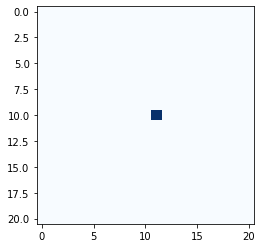

Act_State 1 : [1, 0, 0, 0] Action:  5 1012
Act_State 2 : [1, 0, 0, 0] Action:  5 1012
Act_State 3 : [1, 0, 0, 0] Action:  5 1012
Act_State 4 : [1, 0, 0, 0] Action:  5 1012


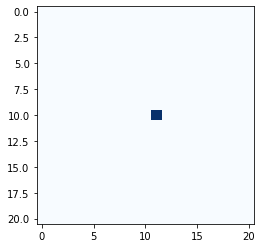

Act_State 1 : [1, 0, 0, 0] Action:  5 1012
Act_State 2 : [1, 0, 0, 0] Action:  5 1012
Act_State 3 : [1, 0, 0, 0] Action:  5 1012
Act_State 4 : [1, 0, 0, 0] Action:  5 1012


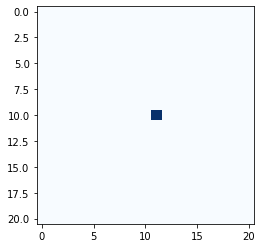

Act_State 1 : [1, 0, 0, 0] Action:  5 1012
Act_State 2 : [1, 0, 0, 0] Action:  5 1012
Act_State 3 : [1, 0, 0, 0] Action:  5 1012
Act_State 4 : [1, 0, 0, 0] Action:  5 1012


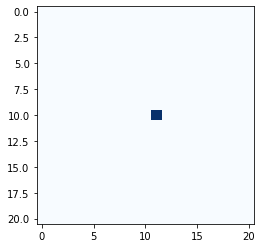

Act_State 1 : [1, 0, 0, 0] Action:  5 1012
Act_State 2 : [1, 0, 0, 0] Action:  5 1012
Act_State 3 : [1, 0, 0, 0] Action:  5 1012
Act_State 4 : [1, 0, 0, 0] Action:  5 1012


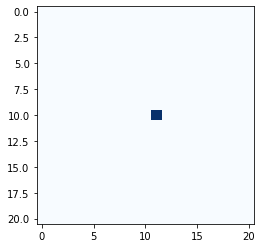

Act_State 1 : [1, 0, 0, 0] Action:  5 1012
Act_State 2 : [1, 0, 0, 0] Action:  5 1012
Act_State 3 : [1, 0, 0, 0] Action:  5 1012
Act_State 4 : [1, 0, 0, 0] Action:  5 1012


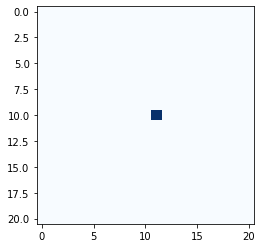

Act_State 1 : [1, 0, 0, 0] Action:  5 1012
Act_State 2 : [1, 0, 0, 0] Action:  5 1012
Act_State 3 : [1, 0, 0, 0] Action:  5 1012
Act_State 4 : [1, 0, 0, 0] Action:  5 1012


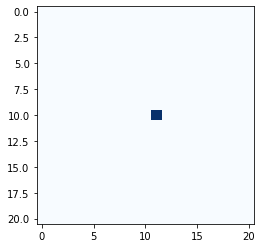

Act_State 1 : [1, 0, 0, 0] Action:  5 1012
Act_State 2 : [1, 0, 0, 0] Action:  5 1012
Act_State 3 : [1, 0, 0, 0] Action:  5 1012
Act_State 4 : [1, 0, 0, 0] Action:  5 1012


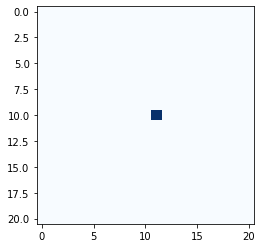

Act_State 1 : [1, 0, 0, 0] Action:  5 1012
Act_State 2 : [1, 0, 0, 0] Action:  5 1012
Act_State 3 : [1, 0, 0, 0] Action:  5 1012
Act_State 4 : [1, 0, 0, 0] Action:  5 1012


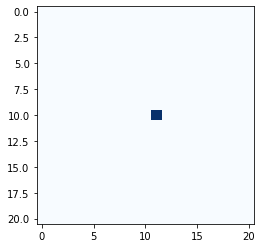

Act_State 1 : [1, 0, 0, 0] Action:  5 1012
Act_State 2 : [1, 0, 0, 0] Action:  5 1012
Act_State 3 : [1, 0, 0, 0] Action:  5 1012
Act_State 4 : [1, 0, 0, 0] Action:  5 1012


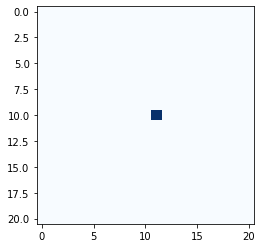

Act_State 1 : [1, 0, 0, 0] Action:  5 1012
Act_State 2 : [1, 0, 0, 0] Action:  5 1012
Act_State 3 : [1, 0, 0, 0] Action:  5 1012
Act_State 4 : [1, 0, 0, 0] Action:  5 1012


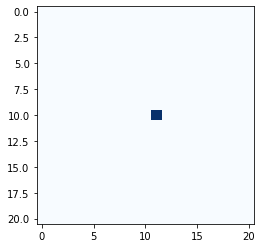

Act_State 1 : [1, 0, 0, 0] Action:  5 1012
Act_State 2 : [1, 0, 0, 0] Action:  5 1012
Act_State 3 : [1, 0, 0, 0] Action:  5 1012
Act_State 4 : [1, 0, 0, 0] Action:  5 1012


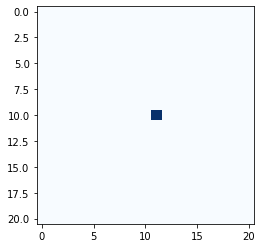

Act_State 1 : [1, 0, 0, 0] Action:  5 1012
Act_State 2 : [1, 0, 0, 0] Action:  5 1012
Act_State 3 : [1, 0, 0, 0] Action:  5 1012
Act_State 4 : [1, 0, 0, 0] Action:  5 1012


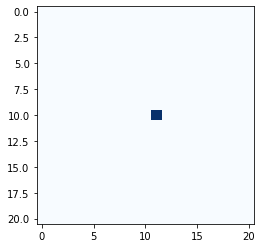

Act_State 1 : [1, 0, 0, 0] Action:  5 1012
Act_State 2 : [1, 0, 0, 0] Action:  5 1012
Act_State 3 : [1, 0, 0, 0] Action:  5 1012
Act_State 4 : [1, 0, 0, 0] Action:  5 1012


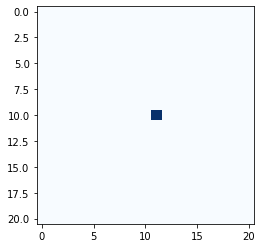

Act_State 1 : [1, 0, 0, 0] Action:  5 1012
Act_State 2 : [1, 0, 0, 0] Action:  5 1012
Act_State 3 : [1, 0, 0, 0] Action:  5 1012
Act_State 4 : [1, 0, 0, 0] Action:  5 1012


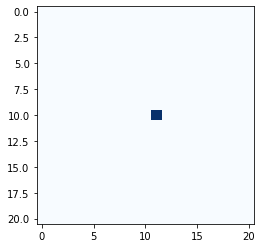

Act_State 1 : [1, 0, 0, 0] Action:  5 1012
Act_State 2 : [1, 0, 0, 0] Action:  5 1012
Act_State 3 : [1, 0, 0, 0] Action:  5 1012
Act_State 4 : [1, 0, 0, 0] Action:  5 1012


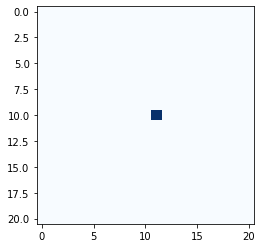

Act_State 1 : [1, 0, 0, 0] Action:  5 1012
Act_State 2 : [1, 0, 0, 0] Action:  5 1012
Act_State 3 : [1, 0, 0, 0] Action:  5 1012
Act_State 4 : [1, 0, 0, 0] Action:  5 1012


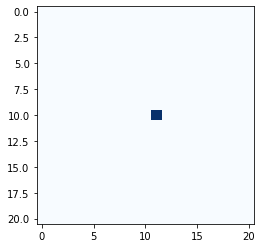

Act_State 1 : [1, 0, 0, 0] Action:  5 1012
Act_State 2 : [1, 0, 0, 0] Action:  5 1012
Act_State 3 : [1, 0, 0, 0] Action:  5 1012
Act_State 4 : [1, 0, 0, 0] Action:  5 1012


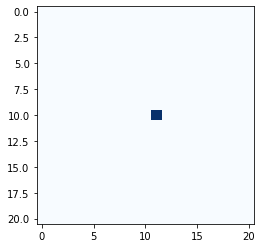

Act_State 1 : [1, 0, 0, 0] Action:  5 1012
Act_State 2 : [1, 0, 0, 0] Action:  5 1012
Act_State 3 : [1, 0, 0, 0] Action:  5 1012
Act_State 4 : [1, 0, 0, 0] Action:  5 1012


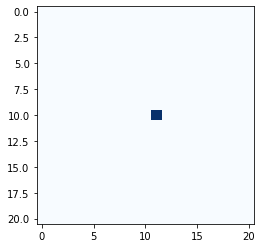

Act_State 1 : [1, 0, 0, 0] Action:  5 1012
Act_State 2 : [1, 0, 0, 0] Action:  5 1012
Act_State 3 : [1, 0, 0, 0] Action:  5 1012
Act_State 4 : [1, 0, 0, 0] Action:  5 1012


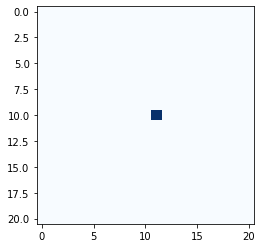

Act_State 1 : [1, 0, 0, 0] Action:  5 1012
Act_State 2 : [1, 0, 0, 0] Action:  5 1012
Act_State 3 : [1, 0, 0, 0] Action:  5 1012
Act_State 4 : [1, 0, 0, 0] Action:  5 1012


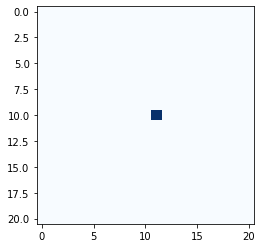

Act_State 1 : [1, 0, 0, 0] Action:  5 1012
Act_State 2 : [1, 0, 0, 0] Action:  5 1012
Act_State 3 : [1, 0, 0, 0] Action:  5 1012
Act_State 4 : [1, 0, 0, 0] Action:  5 1012


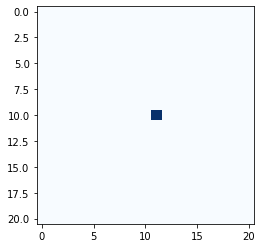

Act_State 1 : [1, 0, 0, 0] Action:  5 1012
Act_State 2 : [1, 0, 0, 0] Action:  5 1012
Act_State 3 : [1, 0, 0, 0] Action:  5 1012
Act_State 4 : [1, 0, 0, 0] Action:  5 1012


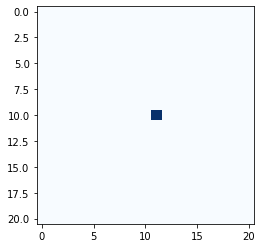

Act_State 1 : [1, 0, 0, 0] Action:  5 1012
Act_State 2 : [1, 0, 0, 0] Action:  5 1012
Act_State 3 : [1, 0, 0, 0] Action:  5 1012
Act_State 4 : [1, 0, 0, 0] Action:  5 1012


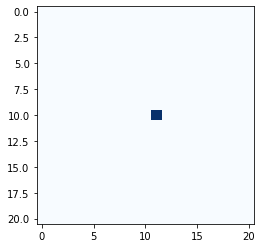

Act_State 1 : [1, 0, 0, 0] Action:  5 1012
Act_State 2 : [1, 0, 0, 0] Action:  5 1012
Act_State 3 : [1, 0, 0, 0] Action:  5 1012
Act_State 4 : [1, 0, 0, 0] Action:  5 1012


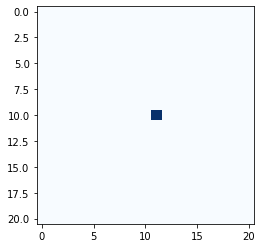

Act_State 1 : [1, 0, 0, 0] Action:  5 1012
Act_State 2 : [1, 0, 0, 0] Action:  5 1012
Act_State 3 : [1, 0, 0, 0] Action:  5 1012
Act_State 4 : [1, 0, 0, 0] Action:  5 1012


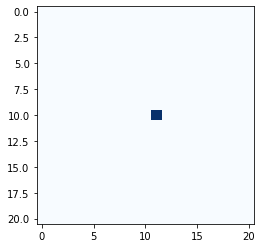

Act_State 1 : [1, 0, 0, 0] Action:  5 1012
Act_State 2 : [1, 0, 0, 0] Action:  5 1012
Act_State 3 : [1, 0, 0, 0] Action:  5 1012
Act_State 4 : [1, 0, 0, 0] Action:  5 1012


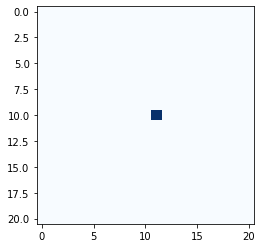

Act_State 1 : [1, 0, 0, 0] Action:  5 1012
Act_State 2 : [1, 0, 0, 0] Action:  5 1012
Act_State 3 : [1, 0, 0, 0] Action:  5 1012
Act_State 4 : [1, 0, 0, 0] Action:  5 1012


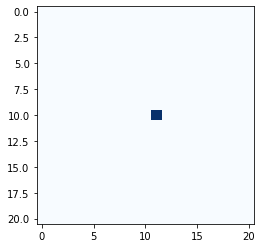

Act_State 1 : [1, 0, 0, 0] Action:  5 1012
Act_State 2 : [1, 0, 0, 0] Action:  5 1012
Act_State 3 : [1, 0, 0, 0] Action:  5 1012
Act_State 4 : [1, 0, 0, 0] Action:  5 1012


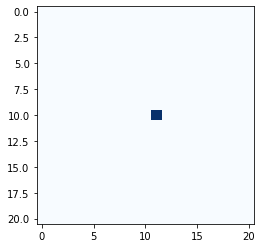

Act_State 1 : [1, 0, 0, 0] Action:  5 1012
Act_State 2 : [1, 0, 0, 0] Action:  5 1012
Act_State 3 : [1, 0, 0, 0] Action:  5 1012
Act_State 4 : [1, 0, 0, 0] Action:  5 1012


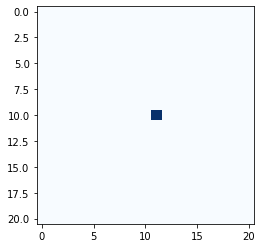

Act_State 1 : [1, 0, 0, 0] Action:  5 1012
Act_State 2 : [1, 0, 0, 0] Action:  5 1012
Act_State 3 : [1, 0, 0, 0] Action:  5 1012
Act_State 4 : [1, 0, 0, 0] Action:  5 1012


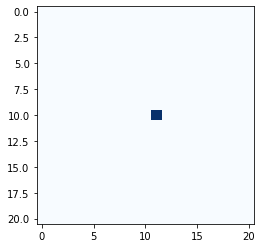

Act_State 1 : [1, 0, 0, 0] Action:  5 1012
Act_State 2 : [1, 0, 0, 0] Action:  5 1012
Act_State 3 : [1, 0, 0, 0] Action:  5 1012
Act_State 4 : [1, 0, 0, 0] Action:  5 1012


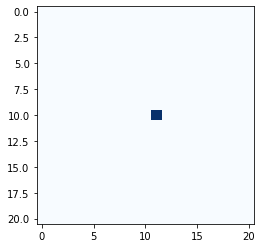

Act_State 1 : [1, 0, 0, 0] Action:  5 1012
Act_State 2 : [1, 1, 0, 0] Action:  4 1012
Act_State 3 : [1, 1, 0, 0] Action:  4 1012
Act_State 4 : [1, 1, 0, 0] Action:  4 1012


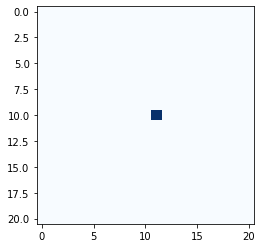

Act_State 1 : [1, 1, 0, 0] Action:  4 1012
Act_State 2 : [1, 1, 0, 0] Action:  4 1012
Act_State 3 : [1, 1, 0, 0] Action:  4 1012
Act_State 4 : [1, 1, 0, 0] Action:  4 1012


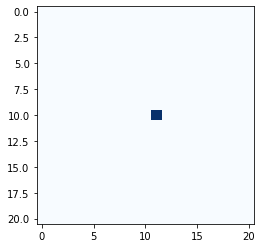

Act_State 1 : [1, 1, 0, 0] Action:  4 1012
Act_State 2 : [1, 1, 0, 0] Action:  4 1012
Act_State 3 : [1, 1, 0, 0] Action:  4 1012
Act_State 4 : [1, 1, 0, 0] Action:  4 1012


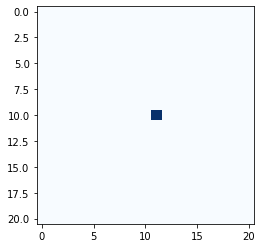

Act_State 1 : [1, 1, 0, 0] Action:  4 1012
Act_State 2 : [1, 1, 0, 0] Action:  4 1012
Act_State 3 : [1, 1, 0, 0] Action:  4 1012
Act_State 4 : [1, 1, 0, 0] Action:  4 1012


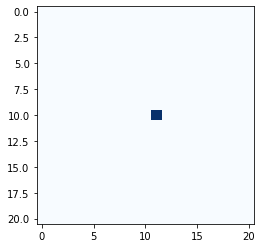

Act_State 1 : [1, 1, 0, 0] Action:  4 1012
Act_State 2 : [1, 1, 0, 0] Action:  4 1012
Act_State 3 : [1, 1, 0, 0] Action:  4 1012
Act_State 4 : [1, 1, 0, 0] Action:  4 1012
Fire ID: 1012 goes POP


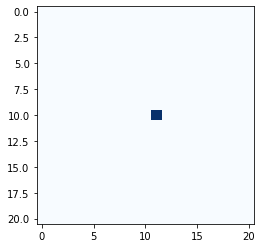

Score: 2240.5 Heat:  []


In [15]:
#Run
env = City(fires = 20)
Agents = spawn_agents(env)

episodes = 1
for episode in range(1, episodes + 1):
    env.reset()
    for I, a in enumerate(Agents):
        p = env.agent_pos[I]
        a.agent_reset(p)
        #a.eps = max(a.eps * a.eps_decay, 0.01)
        a.eps = 0
    
    print("Episode: " + str(episode), end = ' ')
    
    Agents = activate_agents(env, Agents)
    scores, steps = [0]*len(Agents), 0
    episode_done = False
    env.render()
    plt.show()

    while not episode_done:
        
        Active_List = []
        Actions = [0]*len(Agents)
        for B in Agents:
            Active_List.append(B.active)
        steps +=1
        OBS = [[]]*len(Active_List)
        for i,A in enumerate(Agents):
            A.act_net.load_weights('/content/drive/My Drive/Colab Notebooks/New_Act_Policy_V3.h5')
            A.act_target.load_weights('/content/drive/My Drive/Colab Notebooks/New_Act_Policy_V3.h5')
            #if Agent[i].active
            if(Active_List[i]):
                A.OBS, A.M_OBS = [], []
                if(not A.engaged):
                    A.choose_target(env)
                    A.act_state = [0,1,0,0]
                A.curr_state = np.append(A.pos, A.f_loc)
                Actions[i] = (A.policy_act())
                if(Actions[i]>3):
                    A.OBS.append(np.array(A.act_state).reshape(1,4))
                    A.OBS.append(Actions[i])
                else:
                    A.M_OBS.append(A.curr_state.reshape(1,4))
                    A.M_OBS.append(Actions[i])

                print('Act_State '+str(A.agent_no)+' :', A.act_state, 'Action: ', Actions[i], Agents[i].f_ID)
        
        next_state_dict = env.step(Agents, Actions)


        for i,A in enumerate(Agents):

            if(Active_List[i]):
                A.next_state = np.append(A.pos, A.f_loc)
                R = next_state_dict['R_vec'][i]
                scores[i]+=R
                
                if(Actions[i]>3):
                    A.OBS.append(R)
                    A.OBS.append(np.array(A.act_state).reshape(1,4))
                    A.OBS.append(A.f_done)
                    A.save_exp()
                elif(Actions[i] <= 3 and len(A.next_state)>=4):
                    A.M_OBS.append(R)
                    A.M_OBS.append(A.next_state.reshape(1,4))
                    A.M_OBS.append(A.reached)
                    A.save_move_exp()

                if(steps % 5 == 0 and Actions[i]>3):
                    A.fit_act_net(A.OBS)
                elif(steps % 5 == 0 and Actions[i]<=3):
                    A.fit_move_net(A.M_OBS)
                
                A.OBS, A.M_OBS = [], []
                
        episode_done = env.check_fires()
        
        env.render()
        plt.show()

    print("Score: " + str(scores[0])+" Heat: ", end = ' ')
    print([x.heat for x in env.fires])

Episode: 1 

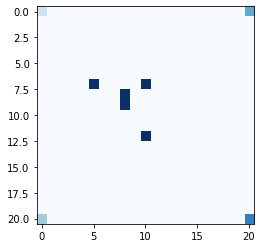

Act_State 1 : [0, 1, 0, 0] Action:  0 1000
Act_State 2 : [0, 1, 0, 0] Action:  1 1001
Act_State 3 : [0, 1, 0, 0] Action:  3 1002
Act_State 4 : [0, 1, 0, 0] Action:  3 1003


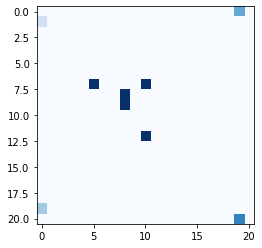

Act_State 1 : [0, 1, 0, 0] Action:  2 1000
Act_State 2 : [0, 1, 0, 0] Action:  1 1001
Act_State 3 : [0, 1, 0, 0] Action:  3 1002
Act_State 4 : [0, 1, 0, 0] Action:  3 1003


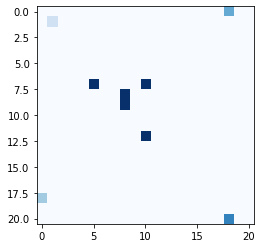

Act_State 1 : [0, 1, 0, 0] Action:  0 1000
Act_State 2 : [0, 1, 0, 0] Action:  1 1001
Act_State 3 : [0, 1, 0, 0] Action:  3 1002
Act_State 4 : [0, 1, 0, 0] Action:  1 1003


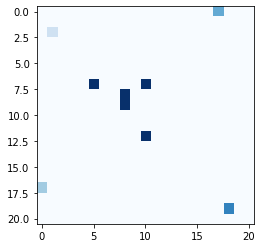

Act_State 1 : [0, 1, 0, 0] Action:  2 1000
Act_State 2 : [0, 1, 0, 0] Action:  1 1001
Act_State 3 : [0, 1, 0, 0] Action:  0 1002
Act_State 4 : [0, 1, 0, 0] Action:  3 1003


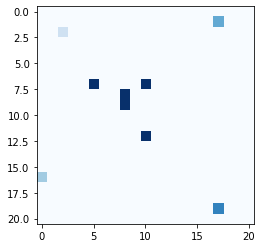

Act_State 1 : [0, 1, 0, 0] Action:  0 1000
Act_State 2 : [0, 1, 0, 0] Action:  1 1001
Act_State 3 : [0, 1, 0, 0] Action:  3 1002
Act_State 4 : [0, 1, 0, 0] Action:  1 1003


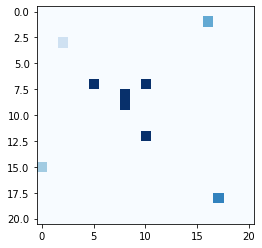

Act_State 1 : [0, 1, 0, 0] Action:  2 1000
Act_State 2 : [0, 1, 0, 0] Action:  1 1001
Act_State 3 : [0, 1, 0, 0] Action:  0 1002
Act_State 4 : [0, 1, 0, 0] Action:  3 1003


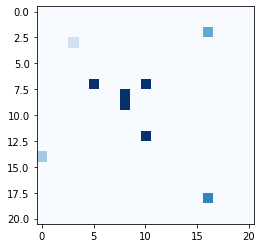

Act_State 1 : [0, 1, 0, 0] Action:  0 1000
Act_State 2 : [0, 1, 0, 0] Action:  1 1001
Act_State 3 : [0, 1, 0, 0] Action:  3 1002
Act_State 4 : [0, 1, 0, 0] Action:  1 1003


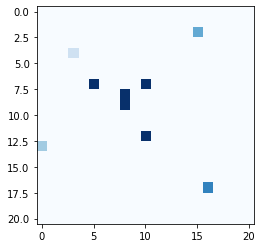

Act_State 1 : [0, 1, 0, 0] Action:  2 1000
Act_State 2 : [0, 1, 0, 0] Action:  1 1001
Act_State 3 : [0, 1, 0, 0] Action:  0 1002
Act_State 4 : [0, 1, 0, 0] Action:  3 1003


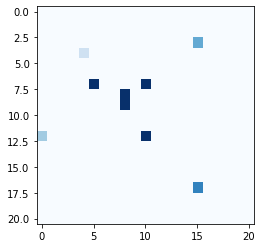

Act_State 1 : [0, 1, 0, 0] Action:  0 1000
Act_State 2 : [0, 1, 0, 0] Action:  1 1001
Act_State 3 : [0, 1, 0, 0] Action:  3 1002
Act_State 4 : [0, 1, 0, 0] Action:  1 1003


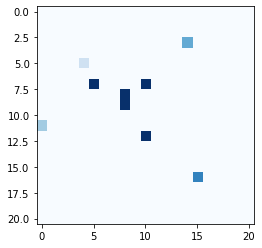

Act_State 1 : [0, 1, 0, 0] Action:  2 1000
Act_State 2 : [0, 1, 0, 0] Action:  2 1001
Act_State 3 : [0, 1, 0, 0] Action:  0 1002
Act_State 4 : [0, 1, 0, 0] Action:  3 1003


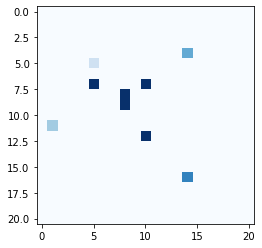

Act_State 1 : [0, 1, 0, 0] Action:  0 1000
Act_State 2 : [0, 1, 0, 0] Action:  1 1001
Act_State 3 : [0, 1, 0, 0] Action:  3 1002
Act_State 4 : [0, 1, 0, 0] Action:  1 1003


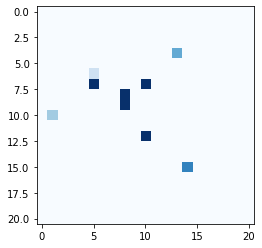

Act_State 1 : [0, 1, 0, 0] Action:  2 1000
Act_State 2 : [0, 1, 0, 0] Action:  2 1001
Act_State 3 : [0, 1, 0, 0] Action:  0 1002
Act_State 4 : [0, 1, 0, 0] Action:  3 1003


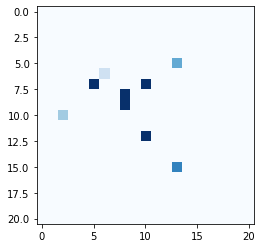

Act_State 1 : [0, 1, 0, 0] Action:  0 1000
Act_State 2 : [0, 1, 0, 0] Action:  1 1001
Act_State 3 : [0, 1, 0, 0] Action:  3 1002
Act_State 4 : [0, 1, 0, 0] Action:  1 1003


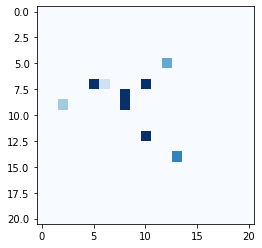

Act_State 1 : [0, 1, 0, 0] Action:  2 1000
Act_State 2 : [0, 1, 0, 0] Action:  2 1001
Act_State 3 : [0, 1, 0, 0] Action:  0 1002
Act_State 4 : [0, 1, 0, 0] Action:  3 1003


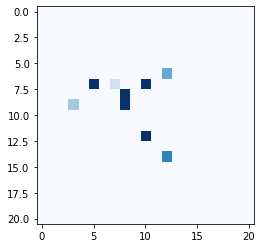

Act_State 1 : [0, 1, 0, 0] Action:  0 1000
Act_State 2 : [0, 1, 0, 0] Action:  1 1001
Act_State 3 : [0, 1, 0, 0] Action:  3 1002
Act_State 4 : [0, 1, 0, 0] Action:  1 1003


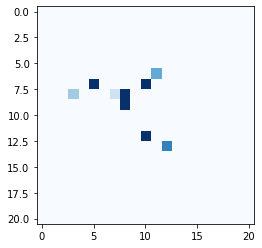

Act_State 1 : [0, 1, 0, 0] Action:  2 1000
Act_State 2 : [0, 1, 0, 0] Action:  2 1001
Act_State 3 : [0, 1, 0, 0] Action:  0 1002
Act_State 4 : [0, 1, 0, 0] Action:  3 1003


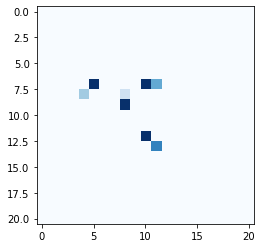

Act_State 1 : [1, 1, 0, 0] Action:  4 1000
Act_State 2 : [0, 1, 0, 0] Action:  1 1001
Act_State 3 : [0, 1, 0, 0] Action:  3 1002
Act_State 4 : [0, 1, 0, 0] Action:  1 1003


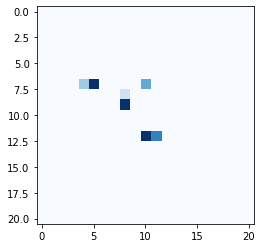

Act_State 1 : [1, 0, 0, 0] Action:  5 1000
Act_State 2 : [0, 1, 0, 0] Action:  2 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [0, 1, 0, 0] Action:  3 1003


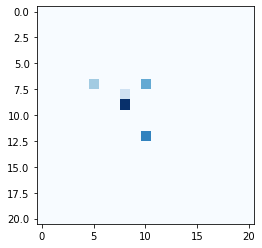

Act_State 1 : [1, 0, 0, 0] Action:  5 1000
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 0, 0, 0] Action:  5 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


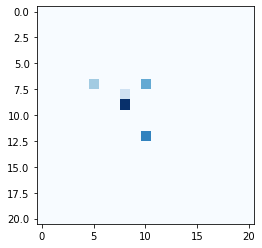

Act_State 1 : [1, 0, 0, 0] Action:  5 1000
Act_State 2 : [1, 0, 0, 0] Action:  5 1001
Act_State 3 : [1, 0, 0, 0] Action:  5 1002
Act_State 4 : [1, 0, 0, 0] Action:  5 1003


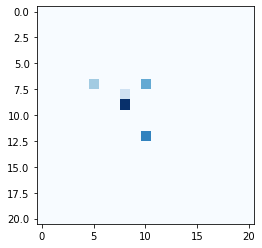

Act_State 1 : [1, 0, 0, 0] Action:  5 1000
Act_State 2 : [1, 0, 0, 0] Action:  5 1001
Act_State 3 : [1, 0, 0, 0] Action:  5 1002
Act_State 4 : [1, 0, 0, 0] Action:  5 1003


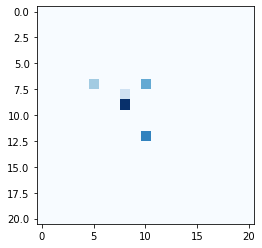

Act_State 1 : [1, 0, 0, 0] Action:  5 1000
Act_State 2 : [1, 0, 0, 0] Action:  5 1001
Act_State 3 : [1, 0, 0, 0] Action:  5 1002
Act_State 4 : [1, 0, 0, 0] Action:  5 1003


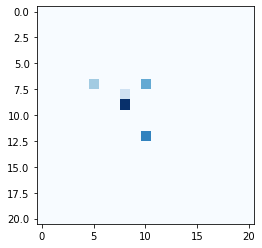

Act_State 1 : [1, 0, 0, 0] Action:  5 1000
Act_State 2 : [1, 0, 0, 0] Action:  5 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [1, 0, 0, 0] Action:  5 1003


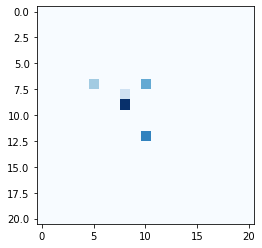

Act_State 1 : [1, 1, 0, 0] Action:  4 1000
Act_State 2 : [1, 0, 0, 0] Action:  5 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [1, 0, 0, 0] Action:  5 1003


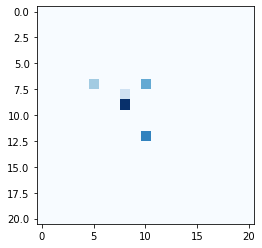

Act_State 1 : [1, 0, 0, 0] Action:  5 1000
Act_State 2 : [1, 0, 0, 0] Action:  5 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [1, 0, 0, 0] Action:  5 1003


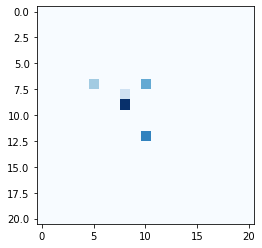

Act_State 1 : [1, 0, 0, 0] Action:  5 1000
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [1, 0, 0, 0] Action:  5 1003


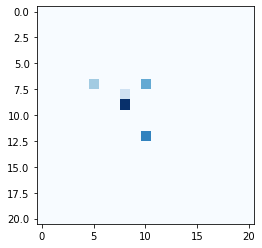

Act_State 1 : [1, 1, 0, 0] Action:  4 1000
Act_State 2 : [1, 0, 0, 0] Action:  5 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


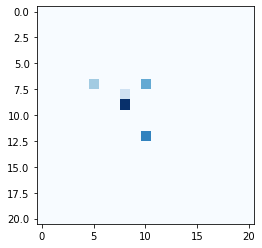

Act_State 1 : [1, 0, 0, 0] Action:  5 1000
Act_State 2 : [1, 0, 0, 0] Action:  5 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


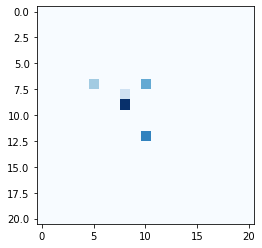

Act_State 1 : [1, 0, 0, 0] Action:  5 1000
Act_State 2 : [1, 0, 0, 0] Action:  5 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


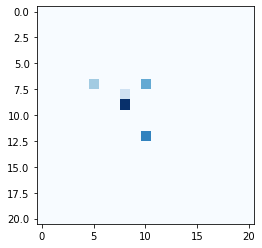

Act_State 1 : [1, 1, 0, 0] Action:  4 1000
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


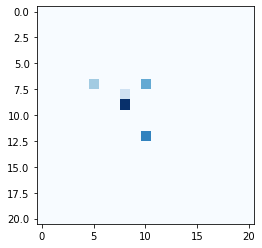

Act_State 1 : [1, 0, 0, 0] Action:  5 1000
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


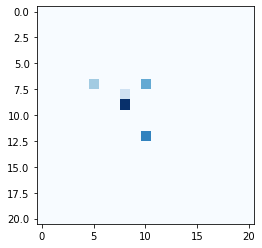

Act_State 1 : [1, 0, 0, 0] Action:  5 1000
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


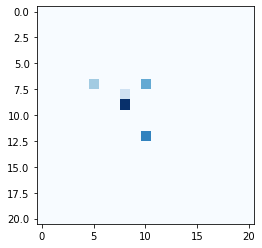

Act_State 1 : [1, 0, 0, 0] Action:  5 1000
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


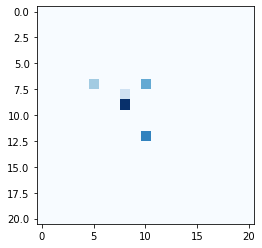

Act_State 1 : [1, 1, 0, 0] Action:  4 1000
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


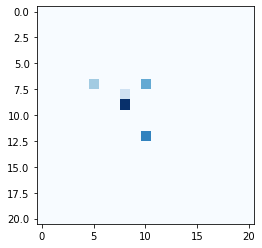

Act_State 1 : [1, 1, 0, 0] Action:  4 1000
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


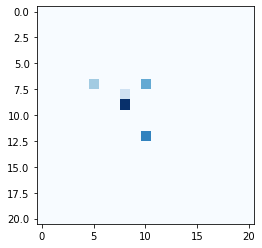

Act_State 1 : [1, 1, 0, 0] Action:  4 1000
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


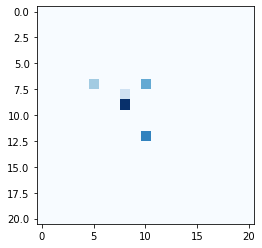

Act_State 1 : [1, 1, 0, 0] Action:  4 1000
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


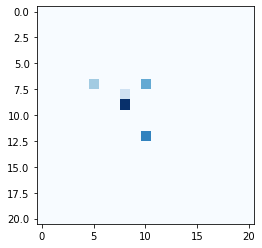

Act_State 1 : [1, 1, 0, 0] Action:  4 1000
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


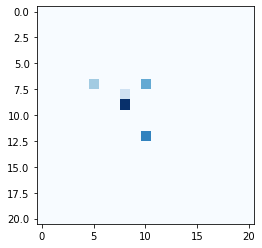

Act_State 1 : [1, 1, 0, 0] Action:  4 1000
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


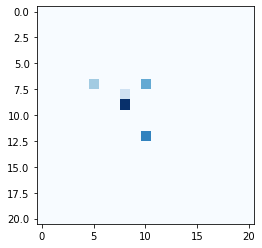

Act_State 1 : [1, 1, 0, 0] Action:  4 1000
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


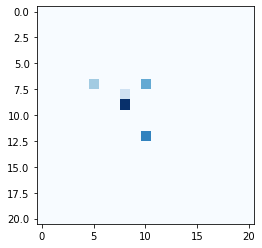

Act_State 1 : [1, 1, 0, 0] Action:  4 1000
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


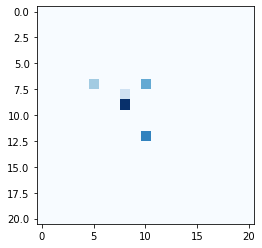

Act_State 1 : [1, 1, 0, 0] Action:  4 1000
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


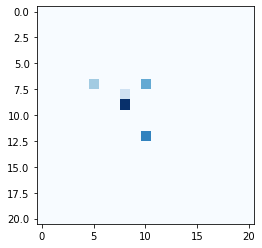

Act_State 1 : [1, 1, 0, 0] Action:  4 1000
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


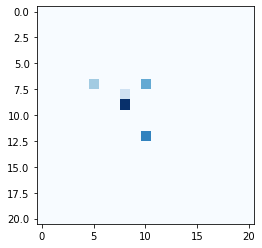

Act_State 1 : [1, 1, 0, 0] Action:  4 1000
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


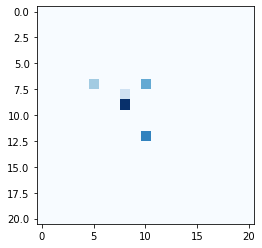

Act_State 1 : [1, 1, 0, 0] Action:  4 1000
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


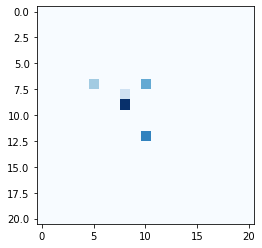

Act_State 1 : [1, 1, 0, 0] Action:  4 1000
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


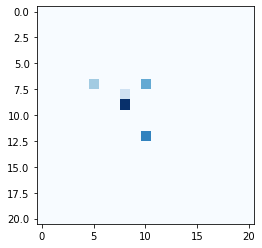

Act_State 1 : [1, 1, 0, 0] Action:  4 1000
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1003
Fire ID: 1002 goes POP


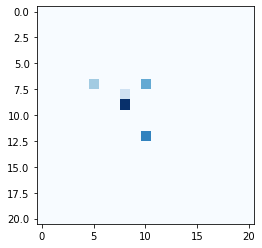

Act_State 1 : [1, 1, 0, 0] Action:  4 1000
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [0, 1, 0, 0] Action:  3 1000
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


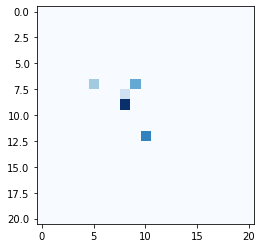

Act_State 1 : [1, 1, 0, 0] Action:  4 1000
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [0, 1, 0, 0] Action:  0 1000
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


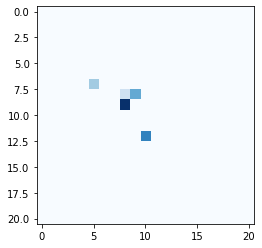

Act_State 1 : [1, 1, 0, 0] Action:  4 1000
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [0, 1, 0, 0] Action:  3 1000
Act_State 4 : [1, 1, 0, 0] Action:  4 1003
Fire ID: 1003 goes POP


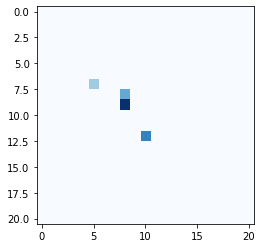

Act_State 1 : [1, 1, 0, 0] Action:  4 1000
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [0, 1, 0, 0] Action:  1 1001


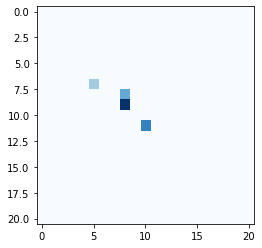

Act_State 1 : [1, 1, 0, 0] Action:  4 1000
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [0, 1, 0, 0] Action:  3 1001
Fire ID: 1001 goes POP


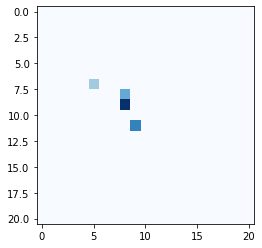

Act_State 1 : [1, 1, 0, 0] Action:  4 1000
Act_State 2 : [0, 1, 0, 0] Action:  2 1000
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [0, 1, 0, 0] Action:  1 1004
Fire ID: 1000 goes POP


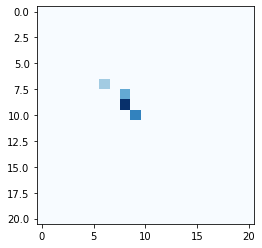

Act_State 1 : [0, 1, 0, 0] Action:  0 1004
Act_State 2 : [0, 1, 0, 0] Action:  0 1004
Act_State 3 : [0, 1, 0, 0] Action:  0 1004
Act_State 4 : [0, 1, 0, 0] Action:  1 1004


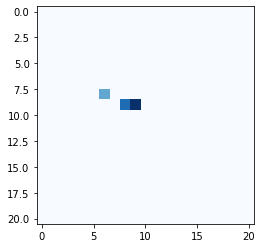

Act_State 1 : [1, 1, 0, 0] Action:  4 1004
Act_State 2 : [0, 1, 0, 0] Action:  2 1004
Act_State 3 : [1, 1, 0, 0] Action:  4 1004
Act_State 4 : [0, 1, 0, 0] Action:  3 1004


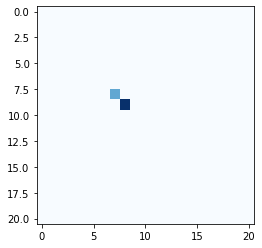

Act_State 1 : [1, 0, 0, 0] Action:  5 1004
Act_State 2 : [0, 1, 0, 0] Action:  0 1004
Act_State 3 : [1, 0, 0, 0] Action:  5 1004
Act_State 4 : [1, 1, 0, 0] Action:  4 1004


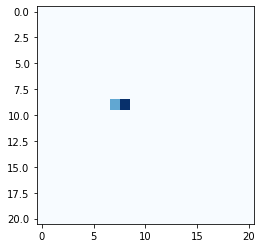

Act_State 1 : [1, 0, 0, 0] Action:  5 1004
Act_State 2 : [0, 1, 0, 0] Action:  2 1004
Act_State 3 : [1, 0, 0, 0] Action:  5 1004
Act_State 4 : [1, 0, 0, 0] Action:  5 1004


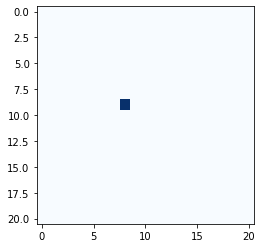

Act_State 1 : [1, 0, 0, 0] Action:  5 1004
Act_State 2 : [1, 1, 0, 0] Action:  4 1004
Act_State 3 : [1, 0, 0, 0] Action:  5 1004
Act_State 4 : [1, 0, 0, 0] Action:  5 1004


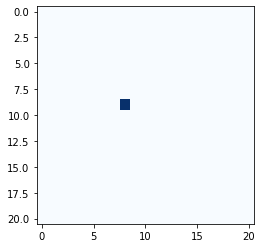

Act_State 1 : [1, 0, 0, 0] Action:  5 1004
Act_State 2 : [1, 0, 0, 0] Action:  5 1004
Act_State 3 : [1, 0, 0, 0] Action:  5 1004
Act_State 4 : [1, 0, 0, 0] Action:  5 1004


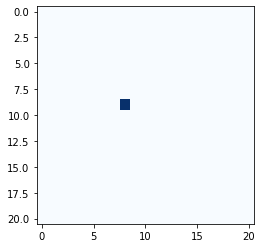

Act_State 1 : [1, 0, 0, 0] Action:  5 1004
Act_State 2 : [1, 0, 0, 0] Action:  5 1004
Act_State 3 : [1, 0, 0, 0] Action:  5 1004
Act_State 4 : [1, 0, 0, 0] Action:  5 1004


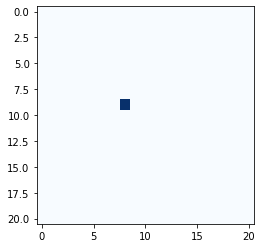

Act_State 1 : [1, 0, 0, 0] Action:  5 1004
Act_State 2 : [1, 0, 0, 0] Action:  5 1004
Act_State 3 : [1, 0, 0, 0] Action:  5 1004
Act_State 4 : [1, 0, 0, 0] Action:  5 1004


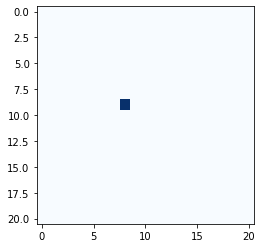

Act_State 1 : [1, 0, 0, 0] Action:  5 1004
Act_State 2 : [1, 0, 0, 0] Action:  5 1004
Act_State 3 : [1, 0, 0, 0] Action:  5 1004
Act_State 4 : [1, 1, 0, 0] Action:  4 1004


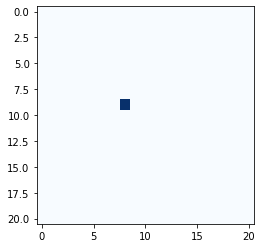

Act_State 1 : [1, 0, 0, 0] Action:  5 1004
Act_State 2 : [1, 1, 0, 0] Action:  4 1004
Act_State 3 : [1, 1, 0, 0] Action:  4 1004
Act_State 4 : [1, 1, 0, 0] Action:  4 1004


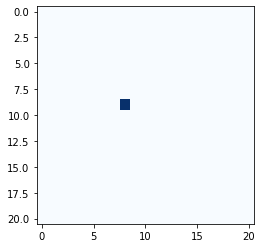

Act_State 1 : [1, 1, 0, 0] Action:  4 1004
Act_State 2 : [1, 1, 0, 0] Action:  4 1004
Act_State 3 : [1, 1, 0, 0] Action:  4 1004
Act_State 4 : [1, 1, 0, 0] Action:  4 1004


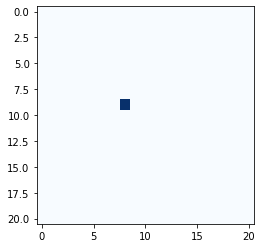

Act_State 1 : [1, 1, 0, 0] Action:  4 1004
Act_State 2 : [1, 1, 0, 0] Action:  4 1004
Act_State 3 : [1, 1, 0, 0] Action:  4 1004
Act_State 4 : [1, 1, 0, 0] Action:  4 1004


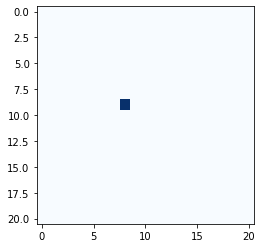

Act_State 1 : [1, 1, 0, 0] Action:  4 1004
Act_State 2 : [1, 1, 0, 0] Action:  4 1004
Act_State 3 : [1, 1, 0, 0] Action:  4 1004
Act_State 4 : [1, 1, 0, 0] Action:  4 1004
Fire ID: 1004 goes POP


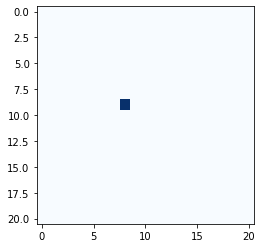

Score: 123.5 Heat:  []
Episode: 2 

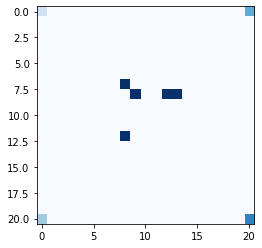

Act_State 1 : [0, 1, 0, 0] Action:  2 1001
Act_State 2 : [0, 1, 0, 0] Action:  1 1000
Act_State 3 : [0, 1, 0, 0] Action:  0 1002
Act_State 4 : [0, 1, 0, 0] Action:  1 1003


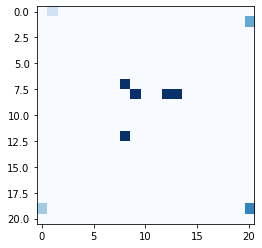

Act_State 1 : [0, 1, 0, 0] Action:  0 1001
Act_State 2 : [0, 1, 0, 0] Action:  2 1000
Act_State 3 : [0, 1, 0, 0] Action:  0 1002
Act_State 4 : [0, 1, 0, 0] Action:  1 1003


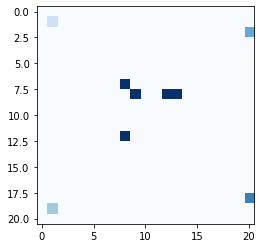

Act_State 1 : [0, 1, 0, 0] Action:  2 1001
Act_State 2 : [0, 1, 0, 0] Action:  1 1000
Act_State 3 : [0, 1, 0, 0] Action:  3 1002
Act_State 4 : [0, 1, 0, 0] Action:  1 1003


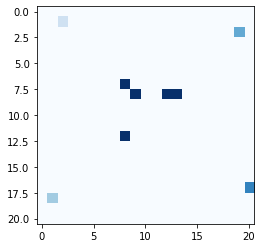

Act_State 1 : [0, 1, 0, 0] Action:  0 1001
Act_State 2 : [0, 1, 0, 0] Action:  2 1000
Act_State 3 : [0, 1, 0, 0] Action:  0 1002
Act_State 4 : [0, 1, 0, 0] Action:  1 1003


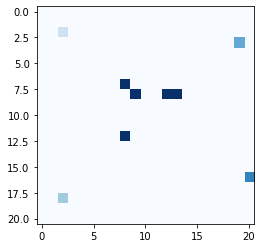

Act_State 1 : [0, 1, 0, 0] Action:  2 1001
Act_State 2 : [0, 1, 0, 0] Action:  1 1000
Act_State 3 : [0, 1, 0, 0] Action:  3 1002
Act_State 4 : [0, 1, 0, 0] Action:  1 1003


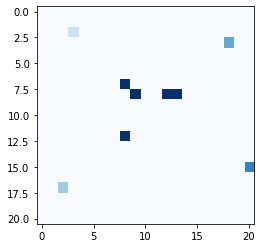

Act_State 1 : [0, 1, 0, 0] Action:  0 1001
Act_State 2 : [0, 1, 0, 0] Action:  2 1000
Act_State 3 : [0, 1, 0, 0] Action:  0 1002
Act_State 4 : [0, 1, 0, 0] Action:  3 1003


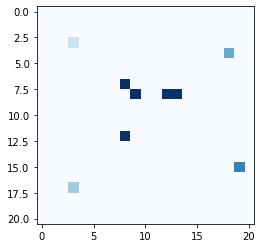

Act_State 1 : [0, 1, 0, 0] Action:  2 1001
Act_State 2 : [0, 1, 0, 0] Action:  1 1000
Act_State 3 : [0, 1, 0, 0] Action:  3 1002
Act_State 4 : [0, 1, 0, 0] Action:  1 1003


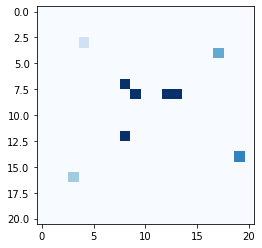

Act_State 1 : [0, 1, 0, 0] Action:  0 1001
Act_State 2 : [0, 1, 0, 0] Action:  2 1000
Act_State 3 : [0, 1, 0, 0] Action:  0 1002
Act_State 4 : [0, 1, 0, 0] Action:  3 1003


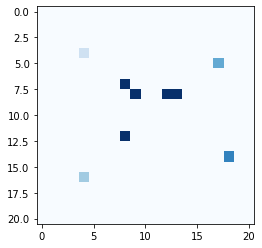

Act_State 1 : [0, 1, 0, 0] Action:  2 1001
Act_State 2 : [0, 1, 0, 0] Action:  1 1000
Act_State 3 : [0, 1, 0, 0] Action:  3 1002
Act_State 4 : [0, 1, 0, 0] Action:  1 1003


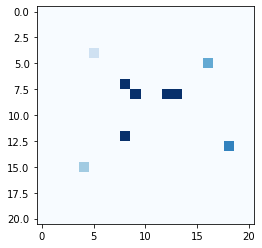

Act_State 1 : [0, 1, 0, 0] Action:  0 1001
Act_State 2 : [0, 1, 0, 0] Action:  2 1000
Act_State 3 : [0, 1, 0, 0] Action:  0 1002
Act_State 4 : [0, 1, 0, 0] Action:  3 1003


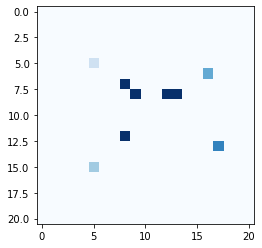

Act_State 1 : [0, 1, 0, 0] Action:  2 1001
Act_State 2 : [0, 1, 0, 0] Action:  1 1000
Act_State 3 : [0, 1, 0, 0] Action:  3 1002
Act_State 4 : [0, 1, 0, 0] Action:  1 1003


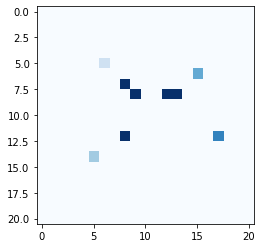

Act_State 1 : [0, 1, 0, 0] Action:  0 1001
Act_State 2 : [0, 1, 0, 0] Action:  2 1000
Act_State 3 : [0, 1, 0, 0] Action:  0 1002
Act_State 4 : [0, 1, 0, 0] Action:  3 1003


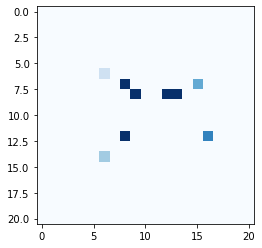

Act_State 1 : [0, 1, 0, 0] Action:  2 1001
Act_State 2 : [0, 1, 0, 0] Action:  1 1000
Act_State 3 : [0, 1, 0, 0] Action:  3 1002
Act_State 4 : [0, 1, 0, 0] Action:  1 1003


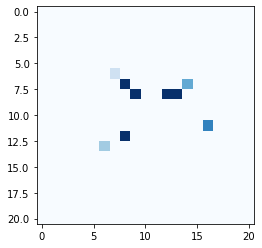

Act_State 1 : [0, 1, 0, 0] Action:  0 1001
Act_State 2 : [0, 1, 0, 0] Action:  2 1000
Act_State 3 : [0, 1, 0, 0] Action:  0 1002
Act_State 4 : [0, 1, 0, 0] Action:  3 1003


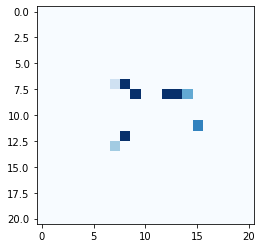

Act_State 1 : [0, 1, 0, 0] Action:  2 1001
Act_State 2 : [0, 1, 0, 0] Action:  1 1000
Act_State 3 : [0, 1, 0, 0] Action:  3 1002
Act_State 4 : [0, 1, 0, 0] Action:  1 1003


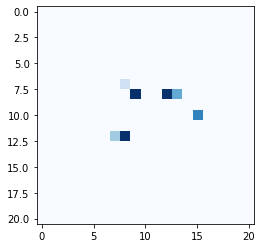

Act_State 1 : [0, 1, 0, 0] Action:  0 1001
Act_State 2 : [0, 1, 0, 0] Action:  2 1000
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [0, 1, 0, 0] Action:  3 1003


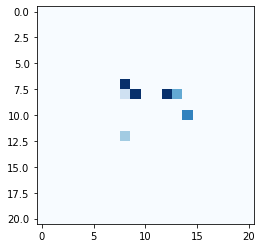

Act_State 1 : [0, 1, 0, 0] Action:  2 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1000
Act_State 3 : [1, 0, 0, 0] Action:  5 1002
Act_State 4 : [0, 1, 0, 0] Action:  1 1003


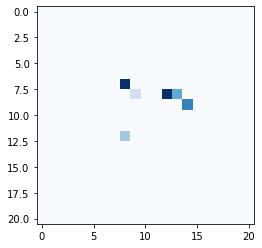

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [1, 0, 0, 0] Action:  5 1000
Act_State 3 : [1, 0, 0, 0] Action:  5 1002
Act_State 4 : [0, 1, 0, 0] Action:  3 1003


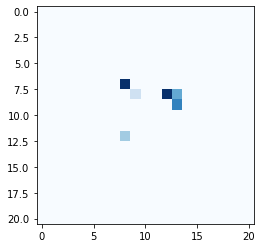

Act_State 1 : [1, 0, 0, 0] Action:  5 1001
Act_State 2 : [1, 0, 0, 0] Action:  5 1000
Act_State 3 : [1, 0, 0, 0] Action:  5 1002
Act_State 4 : [0, 1, 0, 0] Action:  1 1003


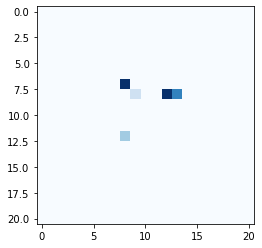

Act_State 1 : [1, 0, 0, 0] Action:  5 1001
Act_State 2 : [1, 0, 0, 0] Action:  5 1000
Act_State 3 : [1, 0, 0, 0] Action:  5 1002
Act_State 4 : [0, 1, 0, 0] Action:  3 1003


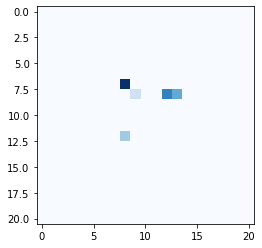

Act_State 1 : [1, 0, 0, 0] Action:  5 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1000
Act_State 3 : [1, 0, 0, 0] Action:  5 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


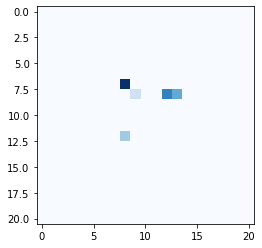

Act_State 1 : [1, 0, 0, 0] Action:  5 1001
Act_State 2 : [1, 0, 0, 0] Action:  5 1000
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [1, 0, 0, 0] Action:  5 1003


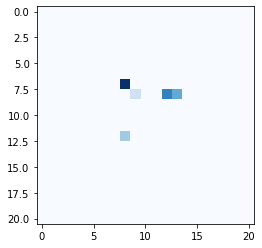

Act_State 1 : [1, 0, 0, 0] Action:  5 1001
Act_State 2 : [1, 0, 0, 0] Action:  5 1000
Act_State 3 : [1, 0, 0, 0] Action:  5 1002
Act_State 4 : [1, 0, 0, 0] Action:  5 1003


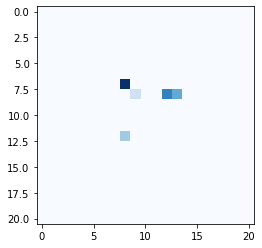

Act_State 1 : [1, 0, 0, 0] Action:  5 1001
Act_State 2 : [1, 0, 0, 0] Action:  5 1000
Act_State 3 : [1, 0, 0, 0] Action:  5 1002
Act_State 4 : [1, 0, 0, 0] Action:  5 1003


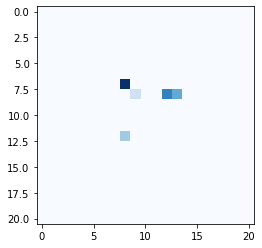

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1000
Act_State 3 : [1, 0, 0, 0] Action:  5 1002
Act_State 4 : [1, 0, 0, 0] Action:  5 1003


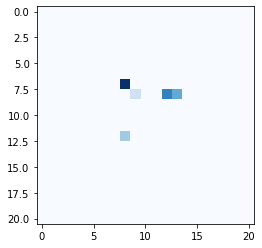

Act_State 1 : [1, 0, 0, 0] Action:  5 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1000
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [1, 0, 0, 0] Action:  5 1003


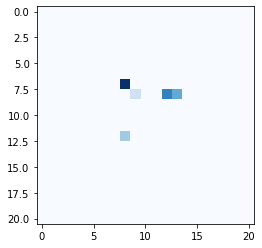

Act_State 1 : [1, 0, 0, 0] Action:  5 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1000
Act_State 3 : [1, 0, 0, 0] Action:  5 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


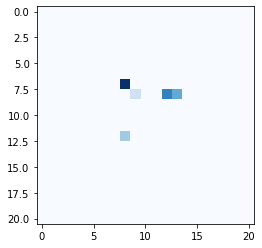

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1000
Act_State 3 : [1, 0, 0, 0] Action:  5 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


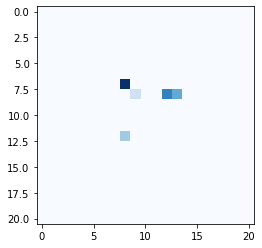

Act_State 1 : [1, 0, 0, 0] Action:  5 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1000
Act_State 3 : [1, 0, 0, 0] Action:  5 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


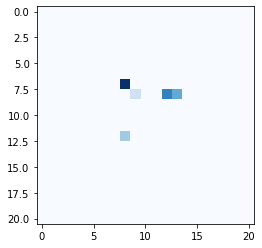

Act_State 1 : [1, 0, 0, 0] Action:  5 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1000
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


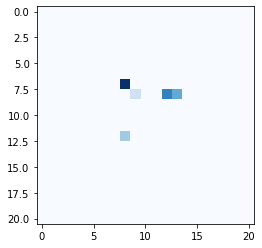

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1000
Act_State 3 : [1, 0, 0, 0] Action:  5 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


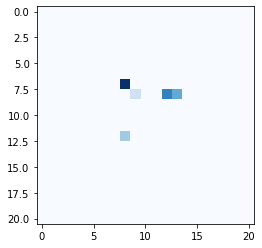

Act_State 1 : [1, 0, 0, 0] Action:  5 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1000
Act_State 3 : [1, 0, 0, 0] Action:  5 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


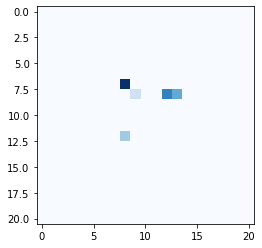

Act_State 1 : [1, 0, 0, 0] Action:  5 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1000
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


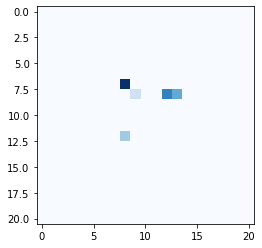

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1000
Act_State 3 : [1, 0, 0, 0] Action:  5 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


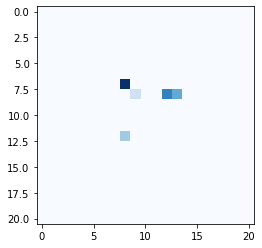

Act_State 1 : [1, 0, 0, 0] Action:  5 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1000
Act_State 3 : [1, 0, 0, 0] Action:  5 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


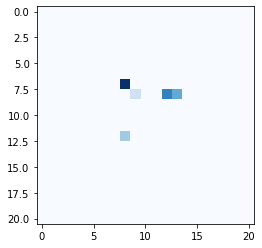

Act_State 1 : [1, 0, 0, 0] Action:  5 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1000
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


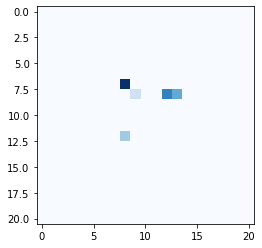

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1000
Act_State 3 : [1, 0, 0, 0] Action:  5 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


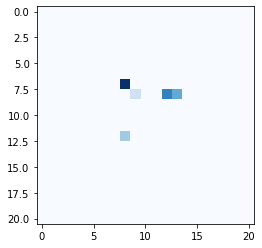

Act_State 1 : [1, 0, 0, 0] Action:  5 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1000
Act_State 3 : [1, 0, 0, 0] Action:  5 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


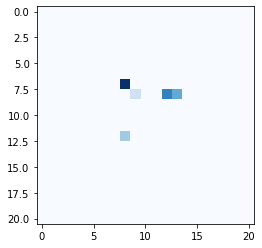

Act_State 1 : [1, 0, 0, 0] Action:  5 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1000
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


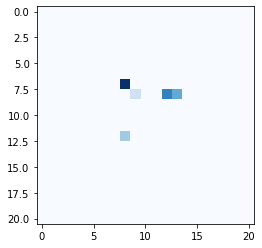

Act_State 1 : [1, 0, 0, 0] Action:  5 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1000
Act_State 3 : [1, 0, 0, 0] Action:  5 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


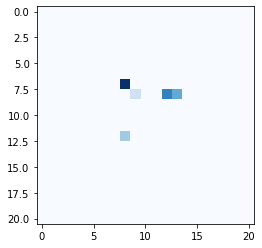

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1000
Act_State 3 : [1, 0, 0, 0] Action:  5 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


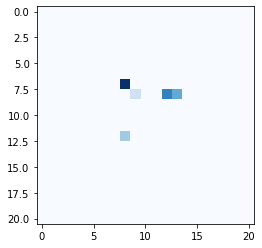

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1000
Act_State 3 : [1, 0, 0, 0] Action:  5 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


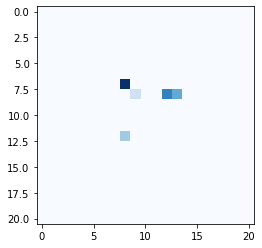

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1000
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


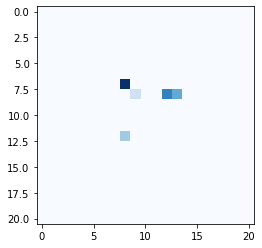

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1000
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


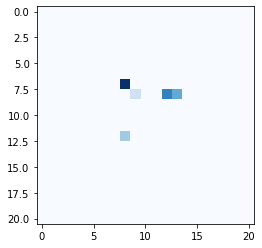

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1000
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


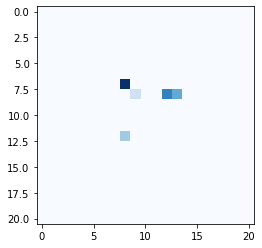

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1000
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


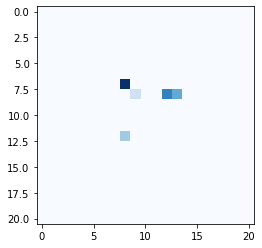

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1000
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


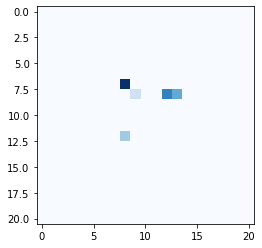

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1000
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1003
Fire ID: 1000 goes POP
Fire ID: 1003 goes POP


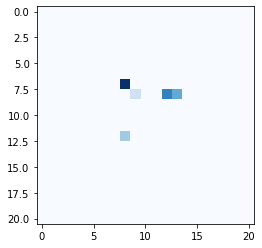

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [0, 1, 0, 0] Action:  1 1000
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [0, 1, 0, 0] Action:  2 1002


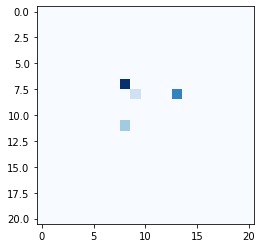

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [0, 1, 0, 0] Action:  1 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1002


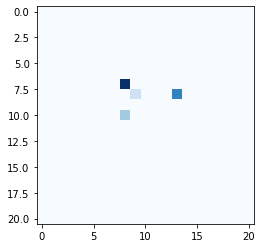

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [0, 1, 0, 0] Action:  1 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1002


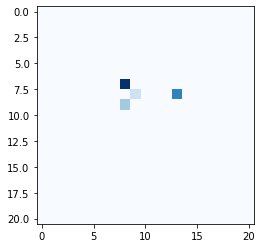

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [0, 1, 0, 0] Action:  1 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1002


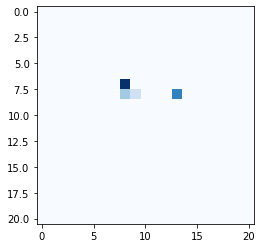

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [0, 1, 0, 0] Action:  2 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1002


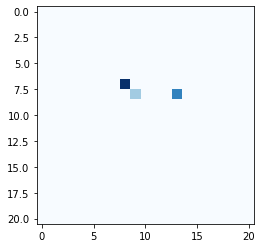

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1002


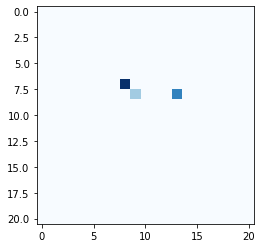

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1002
Fire ID: 1002 goes POP


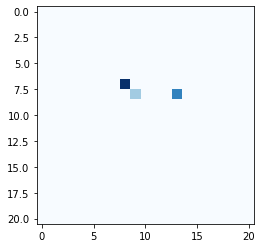

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [0, 1, 0, 0] Action:  3 1001
Act_State 4 : [0, 1, 0, 0] Action:  3 1001


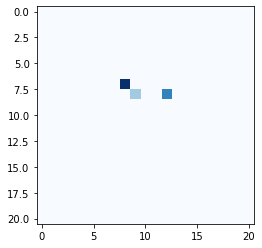

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [0, 1, 0, 0] Action:  3 1001
Act_State 4 : [0, 1, 0, 0] Action:  3 1001
Fire ID: 1001 goes POP


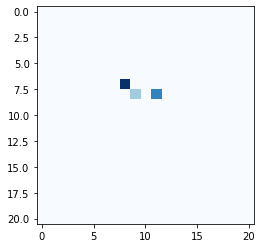

Act_State 1 : [0, 1, 0, 0] Action:  1 1004
Act_State 2 : [0, 1, 0, 0] Action:  1 1004
Act_State 3 : [0, 1, 0, 0] Action:  3 1004
Act_State 4 : [0, 1, 0, 0] Action:  3 1004


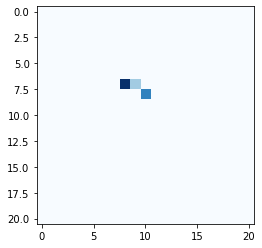

Act_State 1 : [0, 1, 0, 0] Action:  3 1004
Act_State 2 : [0, 1, 0, 0] Action:  3 1004
Act_State 3 : [0, 1, 0, 0] Action:  3 1004
Act_State 4 : [0, 1, 0, 0] Action:  3 1004


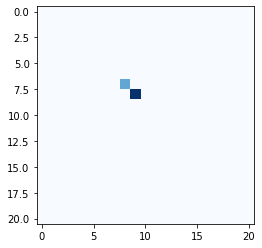

Act_State 1 : [1, 1, 0, 0] Action:  4 1004
Act_State 2 : [1, 1, 0, 0] Action:  4 1004
Act_State 3 : [0, 1, 0, 0] Action:  1 1004
Act_State 4 : [0, 1, 0, 0] Action:  1 1004


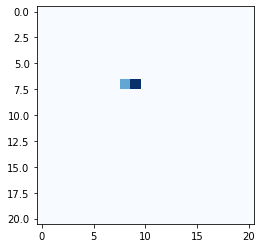

Act_State 1 : [1, 0, 0, 0] Action:  5 1004
Act_State 2 : [1, 0, 0, 0] Action:  5 1004
Act_State 3 : [0, 1, 0, 0] Action:  3 1004
Act_State 4 : [0, 1, 0, 0] Action:  3 1004


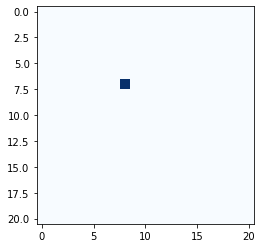

Act_State 1 : [1, 0, 0, 0] Action:  5 1004
Act_State 2 : [1, 0, 0, 0] Action:  5 1004
Act_State 3 : [1, 1, 0, 0] Action:  4 1004
Act_State 4 : [1, 1, 0, 0] Action:  4 1004


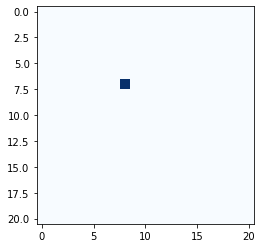

Act_State 1 : [1, 0, 0, 0] Action:  5 1004
Act_State 2 : [1, 0, 0, 0] Action:  5 1004
Act_State 3 : [1, 0, 0, 0] Action:  5 1004
Act_State 4 : [1, 0, 0, 0] Action:  5 1004


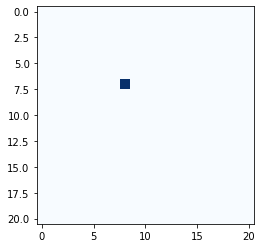

Act_State 1 : [1, 0, 0, 0] Action:  5 1004
Act_State 2 : [1, 0, 0, 0] Action:  5 1004
Act_State 3 : [1, 0, 0, 0] Action:  5 1004
Act_State 4 : [1, 0, 0, 0] Action:  5 1004


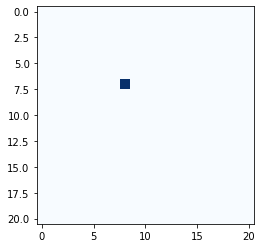

Act_State 1 : [1, 0, 0, 0] Action:  5 1004
Act_State 2 : [1, 0, 0, 0] Action:  5 1004
Act_State 3 : [1, 0, 0, 0] Action:  5 1004
Act_State 4 : [1, 0, 0, 0] Action:  5 1004


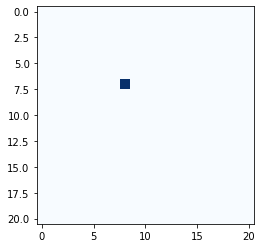

Act_State 1 : [1, 0, 0, 0] Action:  5 1004
Act_State 2 : [1, 0, 0, 0] Action:  5 1004
Act_State 3 : [1, 0, 0, 0] Action:  5 1004
Act_State 4 : [1, 0, 0, 0] Action:  5 1004


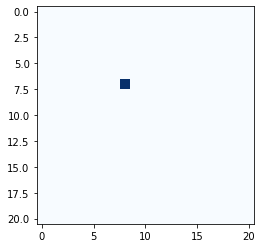

Act_State 1 : [1, 0, 0, 0] Action:  5 1004
Act_State 2 : [1, 0, 0, 0] Action:  5 1004
Act_State 3 : [1, 0, 0, 0] Action:  5 1004
Act_State 4 : [1, 1, 0, 0] Action:  4 1004


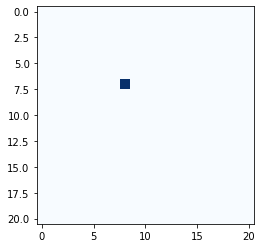

Act_State 1 : [1, 1, 0, 0] Action:  4 1004
Act_State 2 : [1, 1, 0, 0] Action:  4 1004
Act_State 3 : [1, 1, 0, 0] Action:  4 1004
Act_State 4 : [1, 1, 0, 0] Action:  4 1004


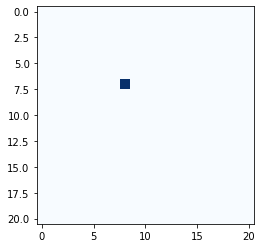

Act_State 1 : [1, 1, 0, 0] Action:  4 1004
Act_State 2 : [1, 1, 0, 0] Action:  4 1004
Act_State 3 : [1, 1, 0, 0] Action:  4 1004
Act_State 4 : [1, 1, 0, 0] Action:  4 1004


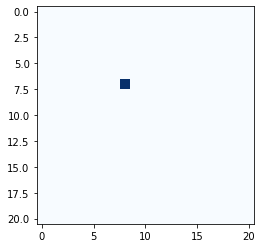

Act_State 1 : [1, 1, 0, 0] Action:  4 1004
Act_State 2 : [1, 1, 0, 0] Action:  4 1004
Act_State 3 : [1, 1, 0, 0] Action:  4 1004
Act_State 4 : [1, 1, 0, 0] Action:  4 1004


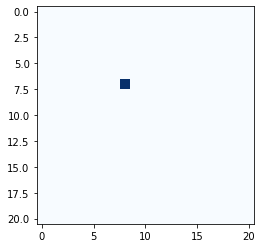

Act_State 1 : [1, 1, 0, 0] Action:  4 1004
Act_State 2 : [1, 1, 0, 0] Action:  4 1004
Act_State 3 : [1, 1, 0, 0] Action:  4 1004
Act_State 4 : [1, 1, 0, 0] Action:  4 1004
Fire ID: 1004 goes POP


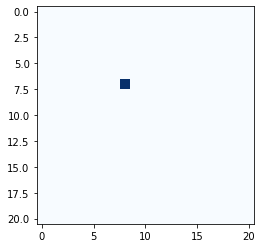

Score: 116.5 Heat:  []
Episode: 3 

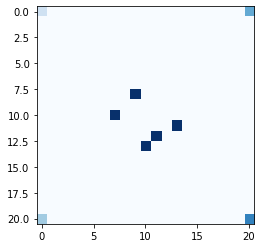

Act_State 1 : [0, 1, 0, 0] Action:  2 1001
Act_State 2 : [0, 1, 0, 0] Action:  2 1000
Act_State 3 : [0, 1, 0, 0] Action:  3 1003
Act_State 4 : [0, 1, 0, 0] Action:  3 1002


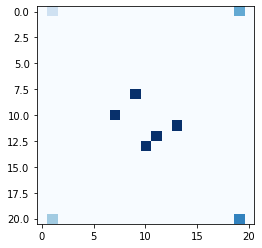

Act_State 1 : [0, 1, 0, 0] Action:  0 1001
Act_State 2 : [0, 1, 0, 0] Action:  2 1000
Act_State 3 : [0, 1, 0, 0] Action:  3 1003
Act_State 4 : [0, 1, 0, 0] Action:  1 1002


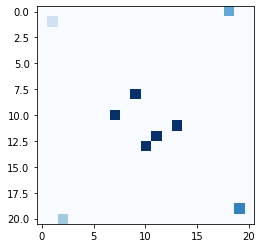

Act_State 1 : [0, 1, 0, 0] Action:  2 1001
Act_State 2 : [0, 1, 0, 0] Action:  2 1000
Act_State 3 : [0, 1, 0, 0] Action:  3 1003
Act_State 4 : [0, 1, 0, 0] Action:  3 1002


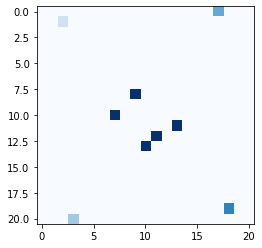

Act_State 1 : [0, 1, 0, 0] Action:  0 1001
Act_State 2 : [0, 1, 0, 0] Action:  1 1000
Act_State 3 : [0, 1, 0, 0] Action:  0 1003
Act_State 4 : [0, 1, 0, 0] Action:  1 1002


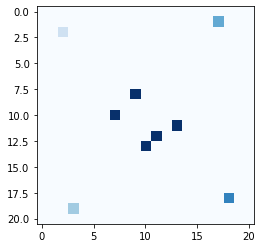

Act_State 1 : [0, 1, 0, 0] Action:  2 1001
Act_State 2 : [0, 1, 0, 0] Action:  2 1000
Act_State 3 : [0, 1, 0, 0] Action:  3 1003
Act_State 4 : [0, 1, 0, 0] Action:  3 1002


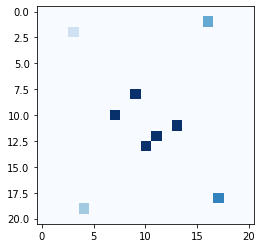

Act_State 1 : [0, 1, 0, 0] Action:  0 1001
Act_State 2 : [0, 1, 0, 0] Action:  1 1000
Act_State 3 : [0, 1, 0, 0] Action:  0 1003
Act_State 4 : [0, 1, 0, 0] Action:  1 1002


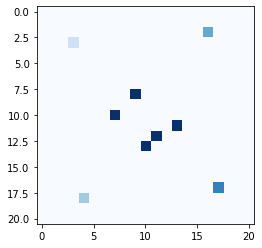

Act_State 1 : [0, 1, 0, 0] Action:  2 1001
Act_State 2 : [0, 1, 0, 0] Action:  2 1000
Act_State 3 : [0, 1, 0, 0] Action:  3 1003
Act_State 4 : [0, 1, 0, 0] Action:  3 1002


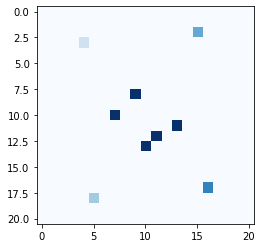

Act_State 1 : [0, 1, 0, 0] Action:  0 1001
Act_State 2 : [0, 1, 0, 0] Action:  1 1000
Act_State 3 : [0, 1, 0, 0] Action:  0 1003
Act_State 4 : [0, 1, 0, 0] Action:  1 1002


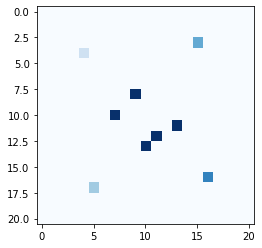

Act_State 1 : [0, 1, 0, 0] Action:  2 1001
Act_State 2 : [0, 1, 0, 0] Action:  2 1000
Act_State 3 : [0, 1, 0, 0] Action:  3 1003
Act_State 4 : [0, 1, 0, 0] Action:  3 1002


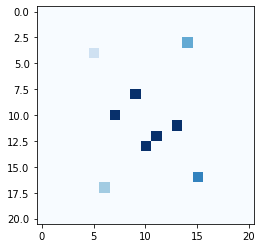

Act_State 1 : [0, 1, 0, 0] Action:  0 1001
Act_State 2 : [0, 1, 0, 0] Action:  1 1000
Act_State 3 : [0, 1, 0, 0] Action:  0 1003
Act_State 4 : [0, 1, 0, 0] Action:  1 1002


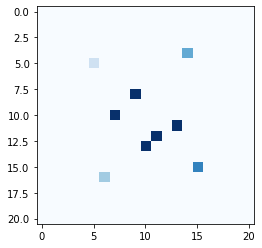

Act_State 1 : [0, 1, 0, 0] Action:  2 1001
Act_State 2 : [0, 1, 0, 0] Action:  2 1000
Act_State 3 : [0, 1, 0, 0] Action:  3 1003
Act_State 4 : [0, 1, 0, 0] Action:  3 1002


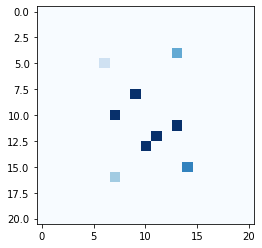

Act_State 1 : [0, 1, 0, 0] Action:  0 1001
Act_State 2 : [0, 1, 0, 0] Action:  1 1000
Act_State 3 : [0, 1, 0, 0] Action:  0 1003
Act_State 4 : [0, 1, 0, 0] Action:  1 1002


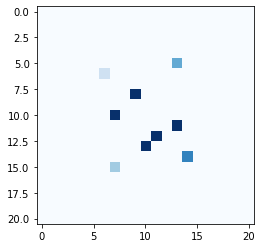

Act_State 1 : [0, 1, 0, 0] Action:  2 1001
Act_State 2 : [0, 1, 0, 0] Action:  2 1000
Act_State 3 : [0, 1, 0, 0] Action:  3 1003
Act_State 4 : [0, 1, 0, 0] Action:  3 1002


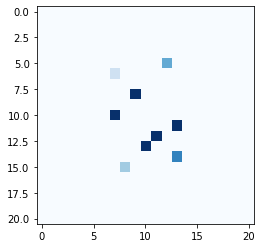

Act_State 1 : [0, 1, 0, 0] Action:  0 1001
Act_State 2 : [0, 1, 0, 0] Action:  1 1000
Act_State 3 : [0, 1, 0, 0] Action:  0 1003
Act_State 4 : [0, 1, 0, 0] Action:  1 1002


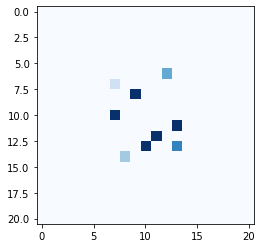

Act_State 1 : [0, 1, 0, 0] Action:  2 1001
Act_State 2 : [0, 1, 0, 0] Action:  2 1000
Act_State 3 : [0, 1, 0, 0] Action:  3 1003
Act_State 4 : [0, 1, 0, 0] Action:  3 1002


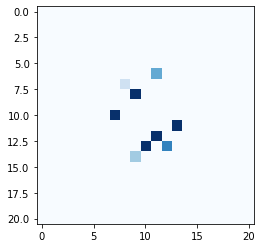

Act_State 1 : [0, 1, 0, 0] Action:  0 1001
Act_State 2 : [0, 1, 0, 0] Action:  1 1000
Act_State 3 : [0, 1, 0, 0] Action:  0 1003
Act_State 4 : [0, 1, 0, 0] Action:  1 1002


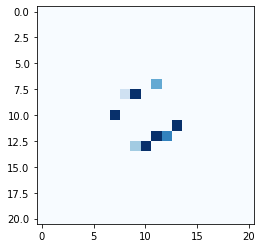

Act_State 1 : [0, 1, 0, 0] Action:  2 1001
Act_State 2 : [0, 1, 0, 0] Action:  2 1000
Act_State 3 : [0, 1, 0, 0] Action:  3 1003
Act_State 4 : [0, 1, 0, 0] Action:  3 1002


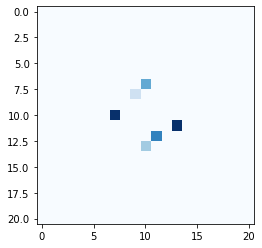

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1000
Act_State 3 : [0, 1, 0, 0] Action:  0 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1002


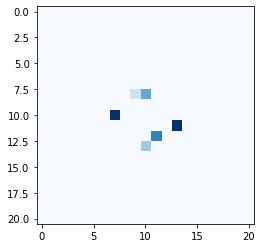

Act_State 1 : [1, 0, 0, 0] Action:  5 1001
Act_State 2 : [1, 0, 0, 0] Action:  5 1000
Act_State 3 : [0, 1, 0, 0] Action:  3 1003
Act_State 4 : [1, 0, 0, 0] Action:  5 1002


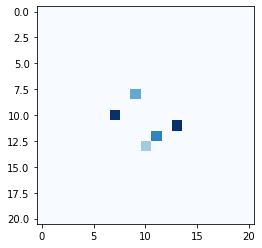

Act_State 1 : [1, 0, 0, 0] Action:  5 1001
Act_State 2 : [1, 0, 0, 0] Action:  5 1000
Act_State 3 : [0, 1, 0, 0] Action:  0 1003
Act_State 4 : [1, 0, 0, 0] Action:  5 1002


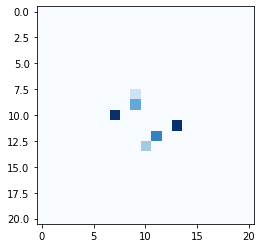

Act_State 1 : [1, 0, 0, 0] Action:  5 1001
Act_State 2 : [1, 0, 0, 0] Action:  5 1000
Act_State 3 : [0, 1, 0, 0] Action:  3 1003
Act_State 4 : [1, 0, 0, 0] Action:  5 1002


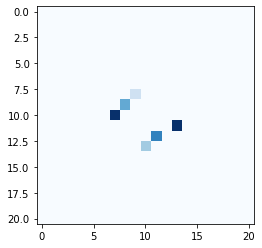

Act_State 1 : [1, 0, 0, 0] Action:  5 1001
Act_State 2 : [1, 0, 0, 0] Action:  5 1000
Act_State 3 : [0, 1, 0, 0] Action:  0 1003
Act_State 4 : [1, 0, 0, 0] Action:  5 1002


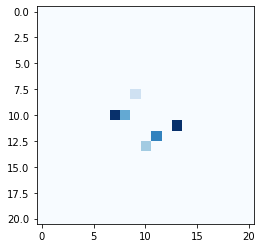

Act_State 1 : [1, 0, 0, 0] Action:  5 1001
Act_State 2 : [1, 0, 0, 0] Action:  5 1000
Act_State 3 : [0, 1, 0, 0] Action:  3 1003
Act_State 4 : [1, 0, 0, 0] Action:  5 1002


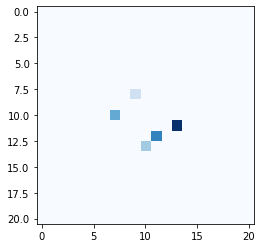

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [1, 0, 0, 0] Action:  5 1000
Act_State 3 : [1, 1, 0, 0] Action:  4 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1002


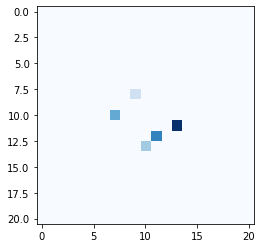

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [1, 0, 0, 0] Action:  5 1000
Act_State 3 : [1, 0, 0, 0] Action:  5 1003
Act_State 4 : [1, 0, 0, 0] Action:  5 1002


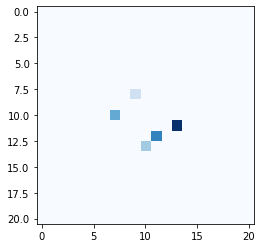

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1000
Act_State 3 : [1, 0, 0, 0] Action:  5 1003
Act_State 4 : [1, 0, 0, 0] Action:  5 1002


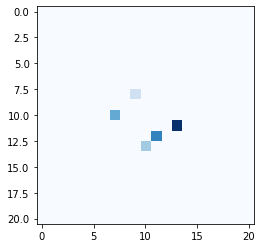

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1000
Act_State 3 : [1, 0, 0, 0] Action:  5 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1002


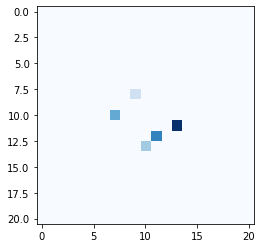

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1000
Act_State 3 : [1, 0, 0, 0] Action:  5 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1002


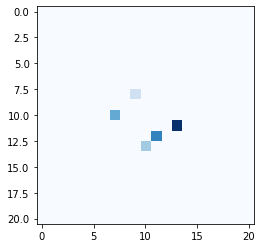

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1000
Act_State 3 : [1, 0, 0, 0] Action:  5 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1002


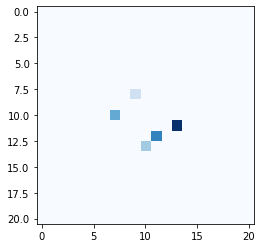

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1000
Act_State 3 : [1, 0, 0, 0] Action:  5 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1002


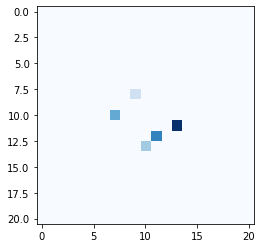

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1000
Act_State 3 : [1, 0, 0, 0] Action:  5 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1002


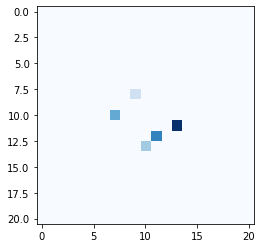

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1000
Act_State 3 : [1, 0, 0, 0] Action:  5 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1002


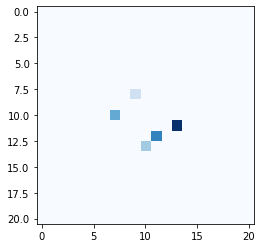

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1000
Act_State 3 : [1, 0, 0, 0] Action:  5 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1002


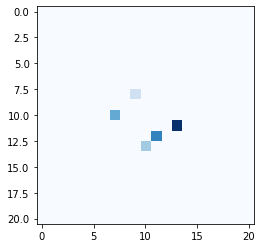

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1000
Act_State 3 : [1, 1, 0, 0] Action:  4 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1002


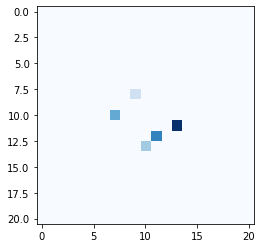

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1000
Act_State 3 : [1, 0, 0, 0] Action:  5 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1002


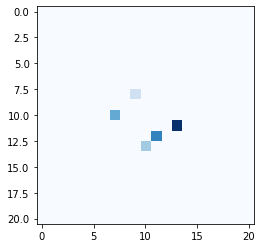

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1000
Act_State 3 : [1, 0, 0, 0] Action:  5 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1002


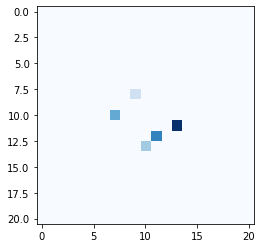

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1000
Act_State 3 : [1, 0, 0, 0] Action:  5 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1002


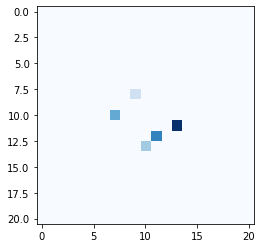

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1000
Act_State 3 : [1, 1, 0, 0] Action:  4 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1002


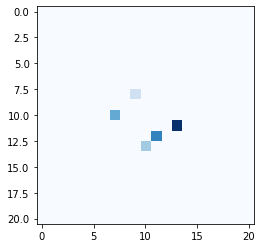

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1000
Act_State 3 : [1, 1, 0, 0] Action:  4 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1002


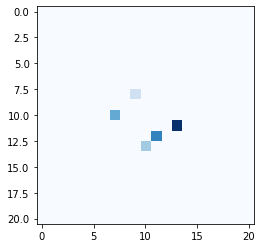

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1000
Act_State 3 : [1, 1, 0, 0] Action:  4 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1002


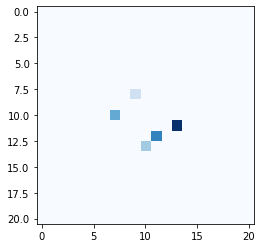

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1000
Act_State 3 : [1, 1, 0, 0] Action:  4 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1002


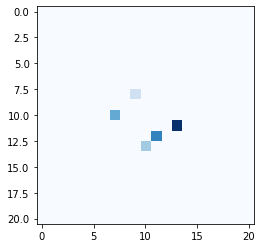

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1000
Act_State 3 : [1, 1, 0, 0] Action:  4 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1002


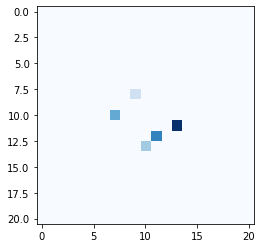

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1000
Act_State 3 : [1, 1, 0, 0] Action:  4 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1002


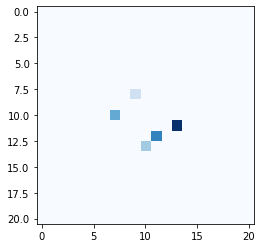

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1000
Act_State 3 : [1, 1, 0, 0] Action:  4 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1002
Fire ID: 1001 goes POP


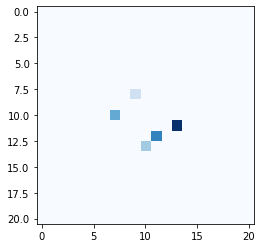

Act_State 1 : [0, 1, 0, 0] Action:  1 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1000
Act_State 3 : [1, 1, 0, 0] Action:  4 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1002


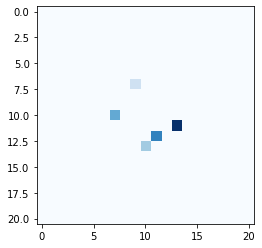

Act_State 1 : [0, 1, 0, 0] Action:  0 1003
Act_State 2 : [1, 1, 0, 0] Action:  4 1000
Act_State 3 : [1, 1, 0, 0] Action:  4 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1002


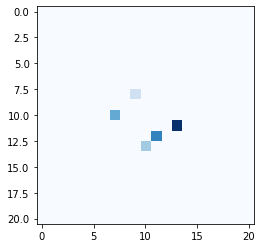

Act_State 1 : [0, 1, 0, 0] Action:  0 1003
Act_State 2 : [1, 1, 0, 0] Action:  4 1000
Act_State 3 : [1, 1, 0, 0] Action:  4 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1002


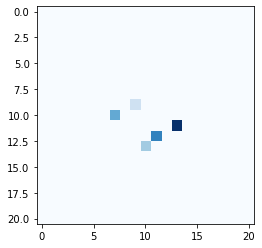

Act_State 1 : [0, 1, 0, 0] Action:  3 1003
Act_State 2 : [1, 1, 0, 0] Action:  4 1000
Act_State 3 : [1, 1, 0, 0] Action:  4 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1002
Fire ID: 1000 goes POP


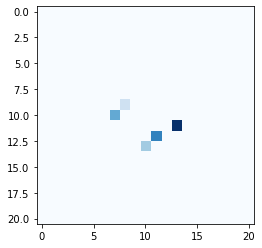

Act_State 1 : [0, 1, 0, 0] Action:  0 1003
Act_State 2 : [0, 1, 0, 0] Action:  1 1000
Act_State 3 : [1, 1, 0, 0] Action:  4 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1002
Fire ID: 1002 goes POP


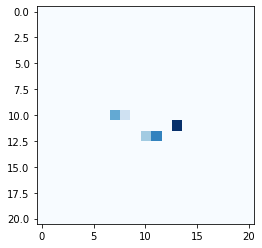

Act_State 1 : [0, 1, 0, 0] Action:  3 1003
Act_State 2 : [0, 1, 0, 0] Action:  3 1003
Act_State 3 : [1, 1, 0, 0] Action:  4 1003
Act_State 4 : [0, 1, 0, 0] Action:  1 1002


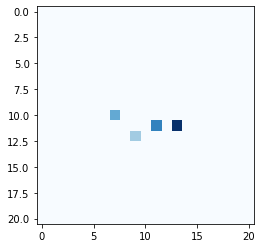

Act_State 1 : [1, 1, 0, 0] Action:  4 1003
Act_State 2 : [0, 1, 0, 0] Action:  1 1003
Act_State 3 : [1, 1, 0, 0] Action:  4 1003
Act_State 4 : [0, 1, 0, 0] Action:  2 1004


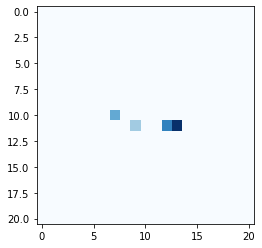

Act_State 1 : [1, 1, 0, 0] Action:  4 1003
Act_State 2 : [0, 1, 0, 0] Action:  3 1003
Act_State 3 : [1, 1, 0, 0] Action:  4 1003
Act_State 4 : [0, 1, 0, 0] Action:  2 1004


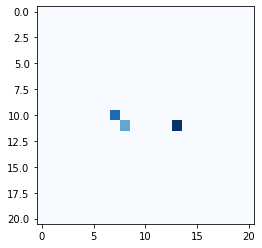

Act_State 1 : [1, 1, 0, 0] Action:  4 1003
Act_State 2 : [0, 1, 0, 0] Action:  1 1003
Act_State 3 : [1, 1, 0, 0] Action:  4 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1004


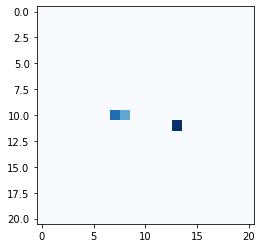

Act_State 1 : [1, 1, 0, 0] Action:  4 1003
Act_State 2 : [0, 1, 0, 0] Action:  3 1003
Act_State 3 : [1, 1, 0, 0] Action:  4 1003
Act_State 4 : [1, 0, 0, 0] Action:  5 1004


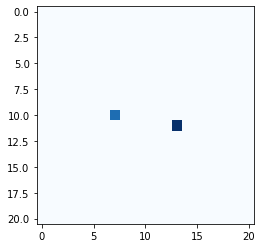

Act_State 1 : [1, 1, 0, 0] Action:  4 1003
Act_State 2 : [1, 1, 0, 0] Action:  4 1003
Act_State 3 : [1, 1, 0, 0] Action:  4 1003
Act_State 4 : [1, 0, 0, 0] Action:  5 1004
Fire ID: 1003 goes POP


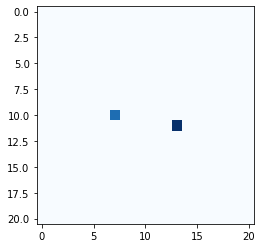

Act_State 1 : [0, 1, 0, 0] Action:  2 1004
Act_State 2 : [0, 1, 0, 0] Action:  2 1004
Act_State 3 : [0, 1, 0, 0] Action:  2 1004
Act_State 4 : [1, 0, 0, 0] Action:  5 1004


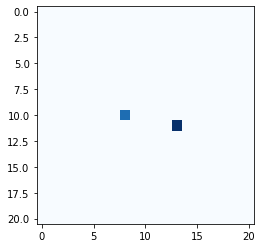

Act_State 1 : [0, 1, 0, 0] Action:  2 1004
Act_State 2 : [0, 1, 0, 0] Action:  2 1004
Act_State 3 : [0, 1, 0, 0] Action:  2 1004
Act_State 4 : [1, 0, 1, 0] Action:  4 1004


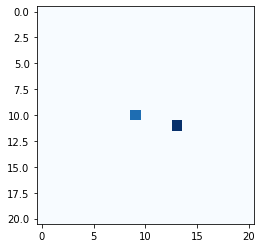

Act_State 1 : [0, 1, 0, 0] Action:  2 1004
Act_State 2 : [0, 1, 0, 0] Action:  2 1004
Act_State 3 : [0, 1, 0, 0] Action:  2 1004
Act_State 4 : [1, 0, 1, 0] Action:  4 1004


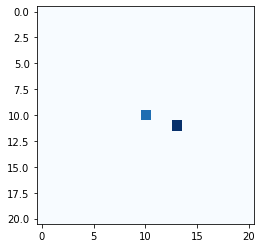

Act_State 1 : [0, 1, 0, 0] Action:  2 1004
Act_State 2 : [0, 1, 0, 0] Action:  2 1004
Act_State 3 : [0, 1, 0, 0] Action:  2 1004
Act_State 4 : [1, 0, 1, 0] Action:  4 1004


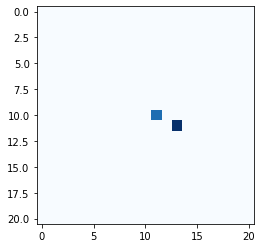

Act_State 1 : [0, 1, 0, 0] Action:  2 1004
Act_State 2 : [0, 1, 0, 0] Action:  2 1004
Act_State 3 : [0, 1, 0, 0] Action:  2 1004
Act_State 4 : [1, 0, 1, 0] Action:  4 1004


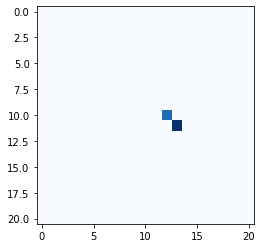

Act_State 1 : [0, 1, 0, 0] Action:  0 1004
Act_State 2 : [0, 1, 0, 0] Action:  0 1004
Act_State 3 : [0, 1, 0, 0] Action:  0 1004
Act_State 4 : [1, 0, 1, 0] Action:  4 1004


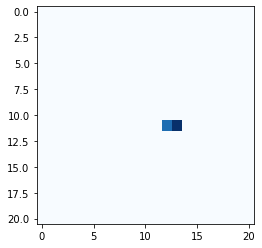

Act_State 1 : [0, 1, 0, 0] Action:  2 1004
Act_State 2 : [0, 1, 0, 0] Action:  2 1004
Act_State 3 : [0, 1, 0, 0] Action:  2 1004
Act_State 4 : [1, 0, 1, 0] Action:  4 1004


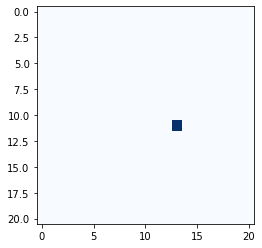

Act_State 1 : [1, 1, 0, 0] Action:  4 1004
Act_State 2 : [1, 1, 0, 0] Action:  4 1004
Act_State 3 : [1, 1, 0, 0] Action:  4 1004
Act_State 4 : [1, 0, 1, 0] Action:  4 1004


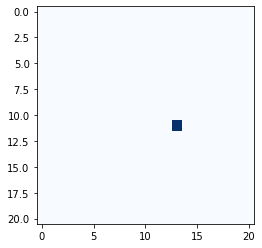

Act_State 1 : [1, 0, 0, 0] Action:  5 1004
Act_State 2 : [1, 0, 0, 0] Action:  5 1004
Act_State 3 : [1, 0, 0, 0] Action:  5 1004
Act_State 4 : [1, 0, 1, 0] Action:  4 1004


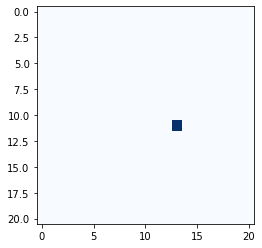

Act_State 1 : [1, 0, 0, 0] Action:  5 1004
Act_State 2 : [1, 0, 0, 0] Action:  5 1004
Act_State 3 : [1, 0, 0, 0] Action:  5 1004
Act_State 4 : [1, 0, 1, 0] Action:  4 1004


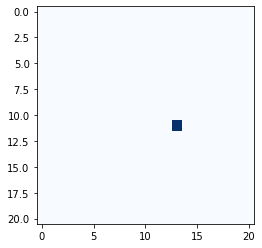

Act_State 1 : [1, 0, 0, 0] Action:  5 1004
Act_State 2 : [1, 0, 0, 0] Action:  5 1004
Act_State 3 : [1, 0, 0, 0] Action:  5 1004
Act_State 4 : [1, 0, 1, 0] Action:  4 1004


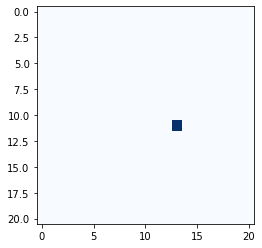

Act_State 1 : [1, 0, 0, 0] Action:  5 1004
Act_State 2 : [1, 0, 0, 0] Action:  5 1004
Act_State 3 : [1, 1, 0, 0] Action:  4 1004
Act_State 4 : [1, 1, 1, 0] Action:  4 1004


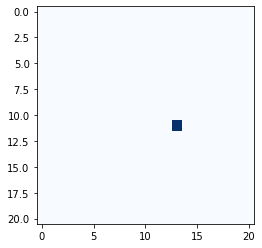

Act_State 1 : [1, 1, 0, 0] Action:  4 1004
Act_State 2 : [1, 1, 0, 0] Action:  4 1004
Act_State 3 : [1, 1, 0, 0] Action:  4 1004
Act_State 4 : [1, 1, 1, 0] Action:  4 1004


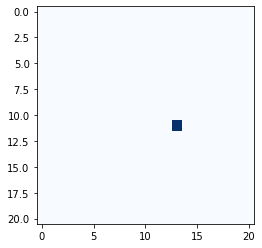

Act_State 1 : [1, 1, 0, 0] Action:  4 1004
Act_State 2 : [1, 1, 0, 0] Action:  4 1004
Act_State 3 : [1, 1, 0, 0] Action:  4 1004
Act_State 4 : [1, 1, 1, 0] Action:  4 1004


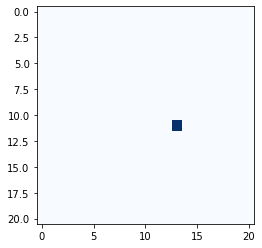

Act_State 1 : [1, 1, 0, 0] Action:  4 1004
Act_State 2 : [1, 1, 0, 0] Action:  4 1004
Act_State 3 : [1, 1, 0, 0] Action:  4 1004
Act_State 4 : [1, 1, 1, 0] Action:  4 1004


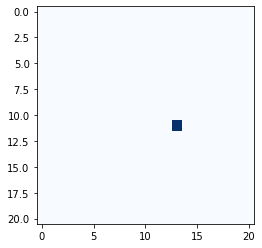

Act_State 1 : [1, 1, 0, 0] Action:  4 1004
Act_State 2 : [1, 1, 0, 0] Action:  4 1004
Act_State 3 : [1, 1, 0, 0] Action:  4 1004
Act_State 4 : [1, 1, 1, 0] Action:  4 1004
Fire ID: 1004 goes POP


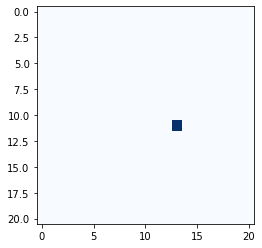

Score: 87.5 Heat:  []
Episode: 4 

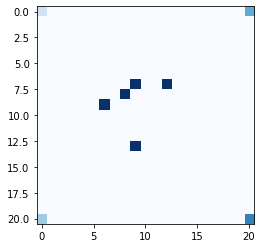

Act_State 1 : [0, 1, 0, 0] Action:  0 1001
Act_State 2 : [0, 1, 0, 0] Action:  1 1002
Act_State 3 : [0, 1, 0, 0] Action:  3 1000
Act_State 4 : [0, 1, 0, 0] Action:  1 1003


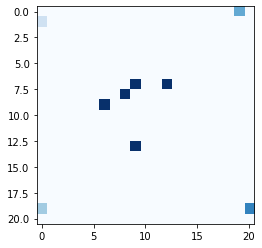

Act_State 1 : [0, 1, 0, 0] Action:  0 1001
Act_State 2 : [0, 1, 0, 0] Action:  1 1002
Act_State 3 : [0, 1, 0, 0] Action:  0 1000
Act_State 4 : [0, 1, 0, 0] Action:  3 1003


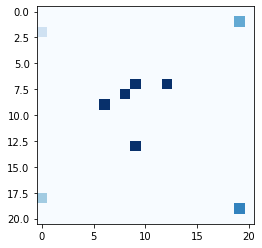

Act_State 1 : [0, 1, 0, 0] Action:  0 1001
Act_State 2 : [0, 1, 0, 0] Action:  1 1002
Act_State 3 : [0, 1, 0, 0] Action:  3 1000
Act_State 4 : [0, 1, 0, 0] Action:  1 1003


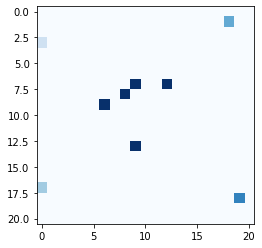

Act_State 1 : [0, 1, 0, 0] Action:  0 1001
Act_State 2 : [0, 1, 0, 0] Action:  1 1002
Act_State 3 : [0, 1, 0, 0] Action:  0 1000
Act_State 4 : [0, 1, 0, 0] Action:  3 1003


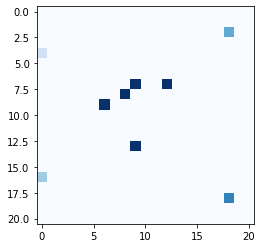

Act_State 1 : [0, 1, 0, 0] Action:  2 1001
Act_State 2 : [0, 1, 0, 0] Action:  1 1002
Act_State 3 : [0, 1, 0, 0] Action:  3 1000
Act_State 4 : [0, 1, 0, 0] Action:  1 1003


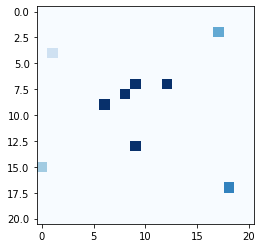

Act_State 1 : [0, 1, 0, 0] Action:  0 1001
Act_State 2 : [0, 1, 0, 0] Action:  2 1002
Act_State 3 : [0, 1, 0, 0] Action:  0 1000
Act_State 4 : [0, 1, 0, 0] Action:  3 1003


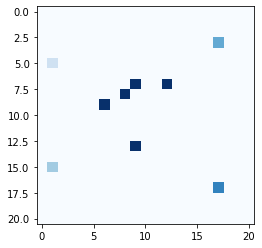

Act_State 1 : [0, 1, 0, 0] Action:  2 1001
Act_State 2 : [0, 1, 0, 0] Action:  1 1002
Act_State 3 : [0, 1, 0, 0] Action:  3 1000
Act_State 4 : [0, 1, 0, 0] Action:  1 1003


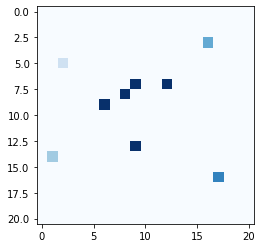

Act_State 1 : [0, 1, 0, 0] Action:  0 1001
Act_State 2 : [0, 1, 0, 0] Action:  2 1002
Act_State 3 : [0, 1, 0, 0] Action:  0 1000
Act_State 4 : [0, 1, 0, 0] Action:  3 1003


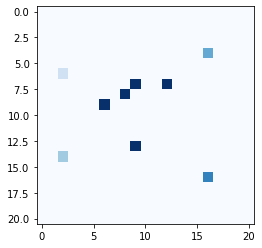

Act_State 1 : [0, 1, 0, 0] Action:  2 1001
Act_State 2 : [0, 1, 0, 0] Action:  1 1002
Act_State 3 : [0, 1, 0, 0] Action:  3 1000
Act_State 4 : [0, 1, 0, 0] Action:  1 1003


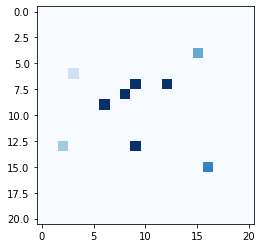

Act_State 1 : [0, 1, 0, 0] Action:  0 1001
Act_State 2 : [0, 1, 0, 0] Action:  2 1002
Act_State 3 : [0, 1, 0, 0] Action:  0 1000
Act_State 4 : [0, 1, 0, 0] Action:  3 1003


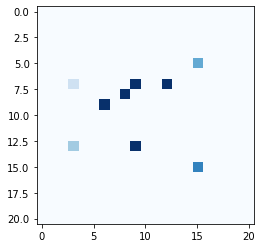

Act_State 1 : [0, 1, 0, 0] Action:  2 1001
Act_State 2 : [0, 1, 0, 0] Action:  1 1002
Act_State 3 : [0, 1, 0, 0] Action:  3 1000
Act_State 4 : [0, 1, 0, 0] Action:  1 1003


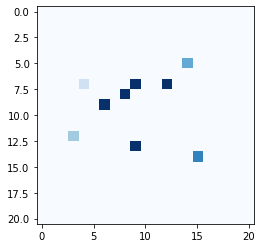

Act_State 1 : [0, 1, 0, 0] Action:  0 1001
Act_State 2 : [0, 1, 0, 0] Action:  2 1002
Act_State 3 : [0, 1, 0, 0] Action:  0 1000
Act_State 4 : [0, 1, 0, 0] Action:  3 1003


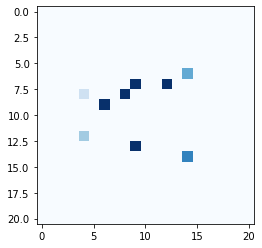

Act_State 1 : [0, 1, 0, 0] Action:  2 1001
Act_State 2 : [0, 1, 0, 0] Action:  1 1002
Act_State 3 : [0, 1, 0, 0] Action:  3 1000
Act_State 4 : [0, 1, 0, 0] Action:  1 1003


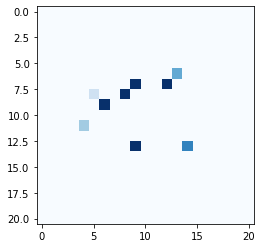

Act_State 1 : [0, 1, 0, 0] Action:  0 1001
Act_State 2 : [0, 1, 0, 0] Action:  2 1002
Act_State 3 : [0, 1, 0, 0] Action:  0 1000
Act_State 4 : [0, 1, 0, 0] Action:  3 1003


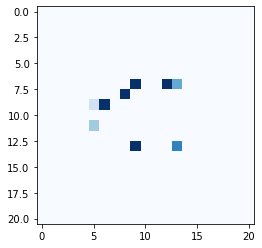

Act_State 1 : [0, 1, 0, 0] Action:  2 1001
Act_State 2 : [0, 1, 0, 0] Action:  1 1002
Act_State 3 : [0, 1, 0, 0] Action:  3 1000
Act_State 4 : [0, 1, 0, 0] Action:  1 1003


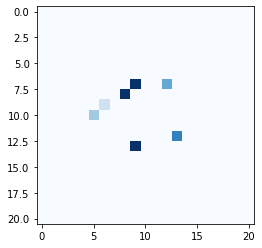

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [0, 1, 0, 0] Action:  2 1002
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [0, 1, 0, 0] Action:  3 1003


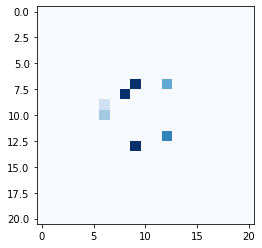

Act_State 1 : [1, 0, 0, 0] Action:  5 1001
Act_State 2 : [0, 1, 0, 0] Action:  1 1002
Act_State 3 : [1, 0, 0, 0] Action:  5 1000
Act_State 4 : [0, 1, 0, 0] Action:  1 1003


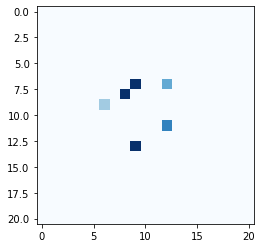

Act_State 1 : [1, 0, 0, 0] Action:  5 1001
Act_State 2 : [0, 1, 0, 0] Action:  2 1002
Act_State 3 : [1, 0, 0, 0] Action:  5 1000
Act_State 4 : [0, 1, 0, 0] Action:  3 1003


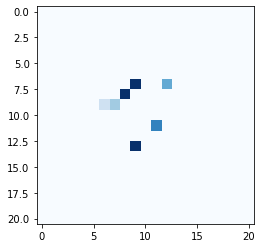

Act_State 1 : [1, 0, 0, 0] Action:  5 1001
Act_State 2 : [0, 1, 0, 0] Action:  1 1002
Act_State 3 : [1, 0, 0, 0] Action:  5 1000
Act_State 4 : [0, 1, 0, 0] Action:  1 1003


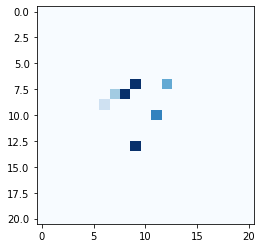

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [0, 1, 0, 0] Action:  2 1002
Act_State 3 : [1, 0, 0, 0] Action:  5 1000
Act_State 4 : [0, 1, 0, 0] Action:  3 1003


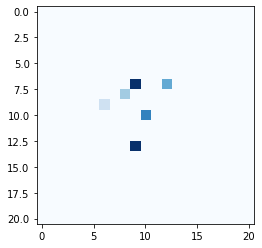

Act_State 1 : [1, 0, 0, 0] Action:  5 1001
Act_State 2 : [0, 1, 0, 0] Action:  1 1002
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [0, 1, 0, 0] Action:  1 1003


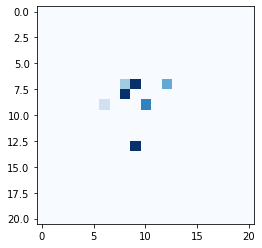

Act_State 1 : [1, 0, 0, 0] Action:  5 1001
Act_State 2 : [0, 1, 0, 0] Action:  2 1002
Act_State 3 : [1, 0, 0, 0] Action:  5 1000
Act_State 4 : [0, 1, 0, 0] Action:  3 1003


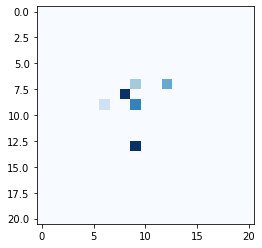

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1002
Act_State 3 : [1, 0, 0, 0] Action:  5 1000
Act_State 4 : [0, 1, 0, 0] Action:  1 1003


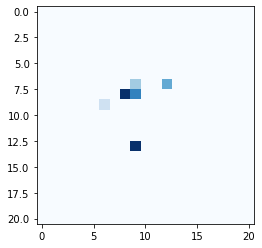

Act_State 1 : [1, 0, 0, 0] Action:  5 1001
Act_State 2 : [1, 0, 0, 0] Action:  5 1002
Act_State 3 : [1, 0, 0, 0] Action:  5 1000
Act_State 4 : [0, 1, 0, 0] Action:  3 1003


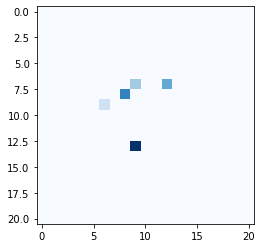

Act_State 1 : [1, 0, 0, 0] Action:  5 1001
Act_State 2 : [1, 0, 0, 0] Action:  5 1002
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


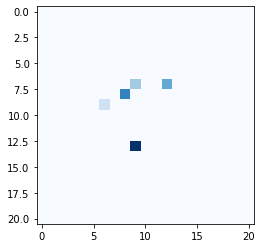

Act_State 1 : [1, 0, 0, 0] Action:  5 1001
Act_State 2 : [1, 0, 0, 0] Action:  5 1002
Act_State 3 : [1, 0, 0, 0] Action:  5 1000
Act_State 4 : [1, 0, 0, 0] Action:  5 1003


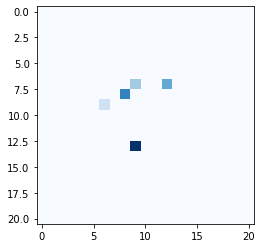

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [1, 0, 0, 0] Action:  5 1002
Act_State 3 : [1, 0, 0, 0] Action:  5 1000
Act_State 4 : [1, 0, 0, 0] Action:  5 1003


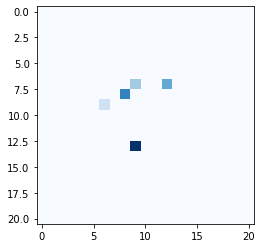

Act_State 1 : [1, 0, 0, 0] Action:  5 1001
Act_State 2 : [1, 0, 0, 0] Action:  5 1002
Act_State 3 : [1, 0, 0, 0] Action:  5 1000
Act_State 4 : [1, 0, 0, 0] Action:  5 1003


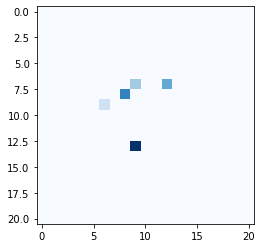

Act_State 1 : [1, 0, 0, 0] Action:  5 1001
Act_State 2 : [1, 0, 0, 0] Action:  5 1002
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [1, 0, 0, 0] Action:  5 1003


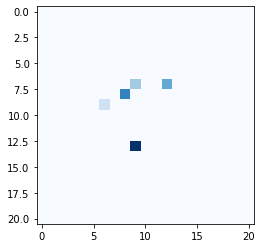

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1002
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [1, 0, 0, 0] Action:  5 1003


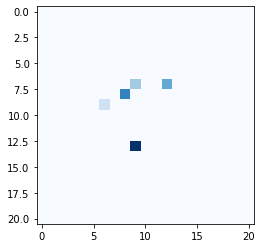

Act_State 1 : [1, 0, 0, 0] Action:  5 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1002
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [1, 0, 0, 0] Action:  5 1003


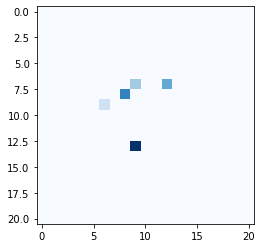

Act_State 1 : [1, 0, 0, 0] Action:  5 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1002
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [1, 0, 0, 0] Action:  5 1003


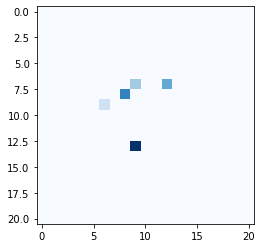

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1002
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [1, 0, 0, 0] Action:  5 1003


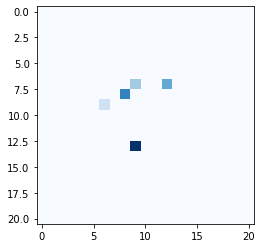

Act_State 1 : [1, 0, 0, 0] Action:  5 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1002
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [1, 0, 0, 0] Action:  5 1003


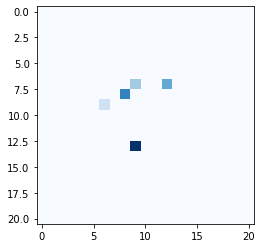

Act_State 1 : [1, 0, 0, 0] Action:  5 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1002
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


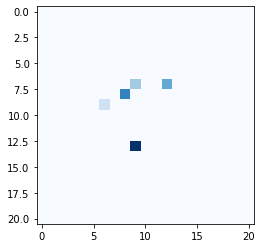

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1002
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [1, 0, 0, 0] Action:  5 1003


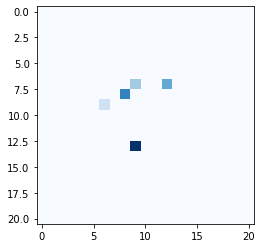

Act_State 1 : [1, 0, 0, 0] Action:  5 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1002
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [1, 0, 0, 0] Action:  5 1003


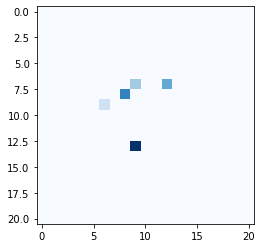

Act_State 1 : [1, 0, 0, 0] Action:  5 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1002
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


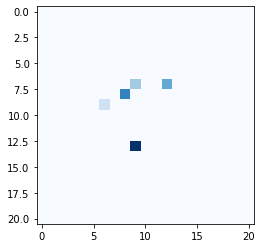

Act_State 1 : [1, 0, 0, 0] Action:  5 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1002
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


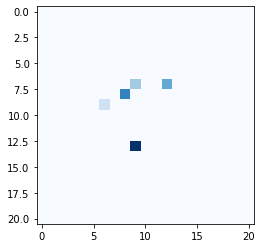

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1002
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


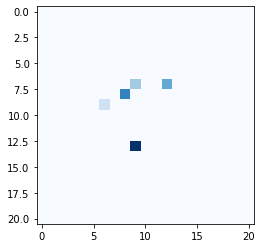

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1002
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


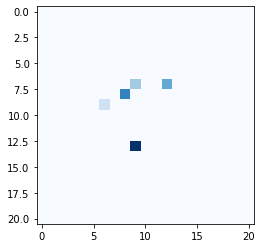

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1002
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


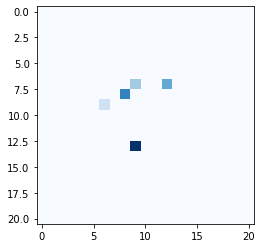

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1002
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


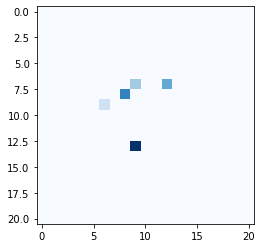

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1002
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


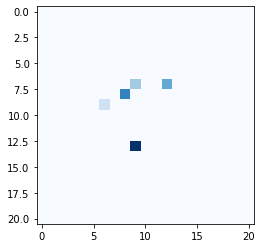

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1002
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


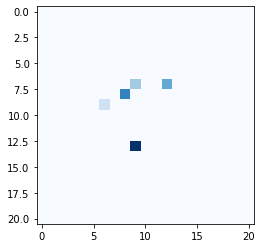

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1002
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


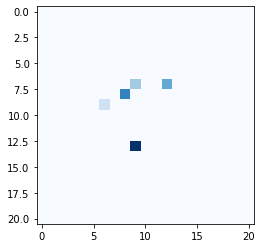

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1002
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


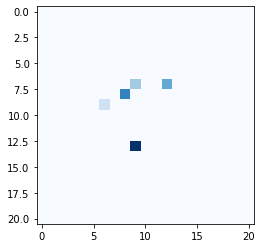

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1002
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


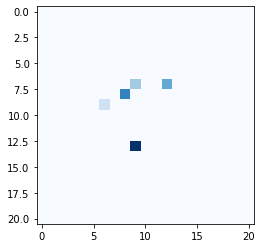

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1002
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


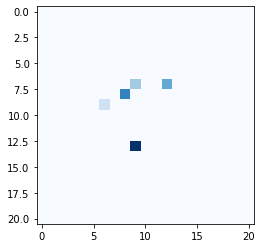

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1002
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


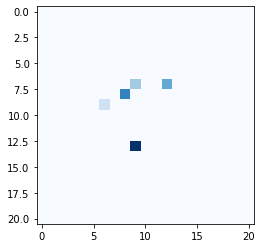

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1002
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


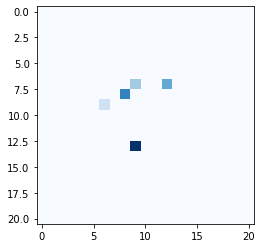

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1002
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [1, 1, 0, 0] Action:  4 1003
Fire ID: 1000 goes POP
Fire ID: 1002 goes POP


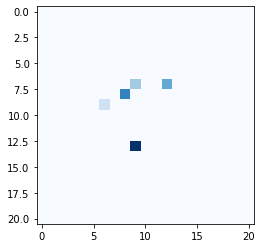

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [0, 1, 0, 0] Action:  3 1001
Act_State 3 : [0, 1, 0, 0] Action:  1 1000
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


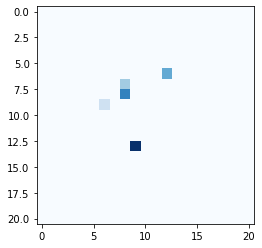

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [0, 1, 0, 0] Action:  0 1001
Act_State 3 : [0, 1, 0, 0] Action:  3 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


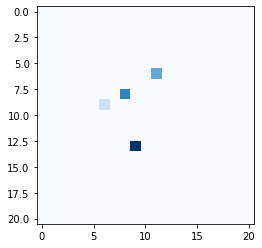

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [0, 1, 0, 0] Action:  3 1001
Act_State 3 : [0, 1, 0, 0] Action:  3 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


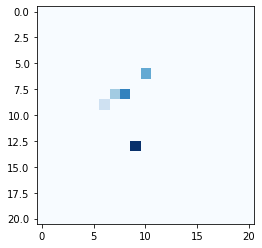

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [0, 1, 0, 0] Action:  0 1001
Act_State 3 : [0, 1, 0, 0] Action:  0 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


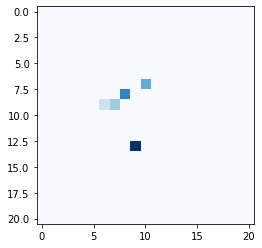

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [0, 1, 0, 0] Action:  3 1001
Act_State 3 : [0, 1, 0, 0] Action:  3 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


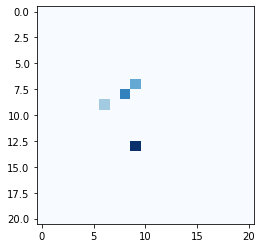

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [0, 1, 0, 0] Action:  0 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


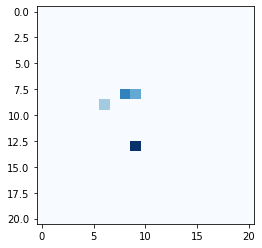

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [0, 1, 0, 0] Action:  3 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


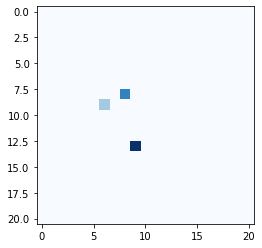

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1003
Fire ID: 1001 goes POP
Fire ID: 1003 goes POP


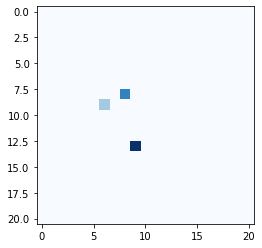

Act_State 1 : [0, 1, 0, 0] Action:  0 1004
Act_State 2 : [0, 1, 0, 0] Action:  0 1004
Act_State 3 : [0, 1, 0, 0] Action:  1 1003
Act_State 4 : [0, 1, 0, 0] Action:  0 1004


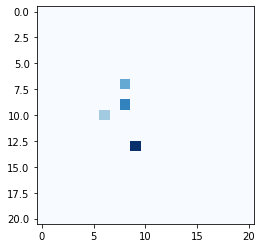

Act_State 1 : [0, 1, 0, 0] Action:  0 1004
Act_State 2 : [0, 1, 0, 0] Action:  0 1004
Act_State 3 : [0, 1, 0, 0] Action:  0 1004
Act_State 4 : [0, 1, 0, 0] Action:  0 1004


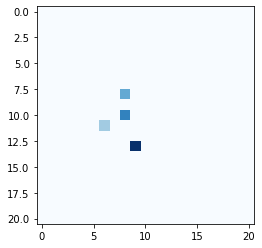

Act_State 1 : [0, 1, 0, 0] Action:  2 1004
Act_State 2 : [0, 1, 0, 0] Action:  2 1004
Act_State 3 : [0, 1, 0, 0] Action:  0 1004
Act_State 4 : [0, 1, 0, 0] Action:  0 1004


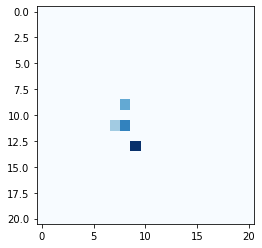

Act_State 1 : [0, 1, 0, 0] Action:  0 1004
Act_State 2 : [0, 1, 0, 0] Action:  0 1004
Act_State 3 : [0, 1, 0, 0] Action:  0 1004
Act_State 4 : [0, 1, 0, 0] Action:  0 1004


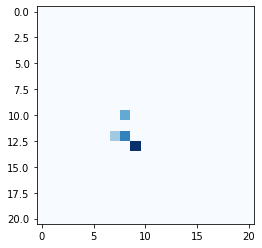

Act_State 1 : [0, 1, 0, 0] Action:  2 1004
Act_State 2 : [0, 1, 0, 0] Action:  2 1004
Act_State 3 : [0, 1, 0, 0] Action:  0 1004
Act_State 4 : [0, 1, 0, 0] Action:  0 1004


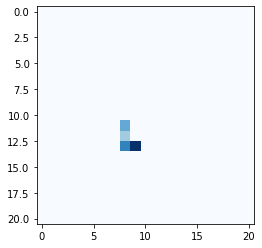

Act_State 1 : [0, 1, 0, 0] Action:  0 1004
Act_State 2 : [0, 1, 0, 0] Action:  0 1004
Act_State 3 : [0, 1, 0, 0] Action:  0 1004
Act_State 4 : [0, 1, 0, 0] Action:  2 1004


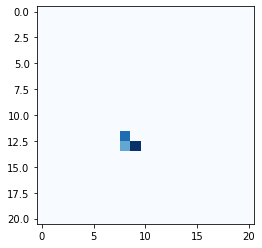

Act_State 1 : [0, 1, 0, 0] Action:  2 1004
Act_State 2 : [0, 1, 0, 0] Action:  2 1004
Act_State 3 : [0, 1, 0, 0] Action:  0 1004
Act_State 4 : [1, 1, 0, 0] Action:  4 1004


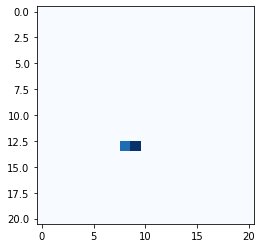

Act_State 1 : [1, 1, 0, 0] Action:  4 1004
Act_State 2 : [1, 1, 0, 0] Action:  4 1004
Act_State 3 : [0, 1, 0, 0] Action:  2 1004
Act_State 4 : [1, 0, 0, 0] Action:  5 1004


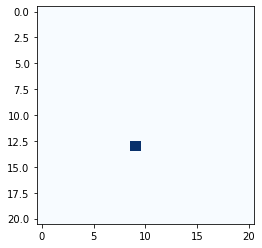

Act_State 1 : [1, 0, 0, 0] Action:  5 1004
Act_State 2 : [1, 0, 0, 0] Action:  5 1004
Act_State 3 : [1, 1, 0, 0] Action:  4 1004
Act_State 4 : [1, 0, 0, 0] Action:  5 1004


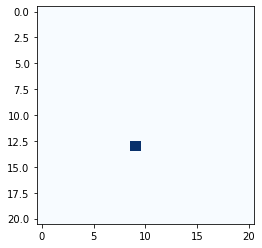

Act_State 1 : [1, 0, 0, 0] Action:  5 1004
Act_State 2 : [1, 0, 0, 0] Action:  5 1004
Act_State 3 : [1, 0, 0, 0] Action:  5 1004
Act_State 4 : [1, 0, 0, 0] Action:  5 1004


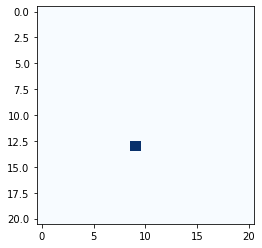

Act_State 1 : [1, 0, 0, 0] Action:  5 1004
Act_State 2 : [1, 0, 0, 0] Action:  5 1004
Act_State 3 : [1, 0, 0, 0] Action:  5 1004
Act_State 4 : [1, 0, 0, 0] Action:  5 1004


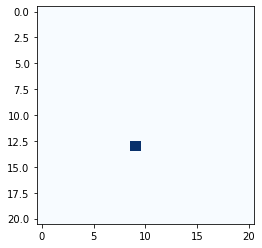

Act_State 1 : [1, 0, 0, 0] Action:  5 1004
Act_State 2 : [1, 0, 0, 0] Action:  5 1004
Act_State 3 : [1, 0, 0, 0] Action:  5 1004
Act_State 4 : [1, 0, 0, 0] Action:  5 1004


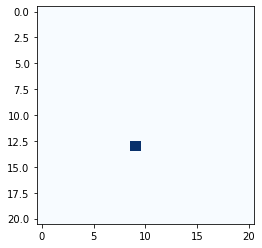

Act_State 1 : [1, 0, 0, 0] Action:  5 1004
Act_State 2 : [1, 0, 0, 0] Action:  5 1004
Act_State 3 : [1, 0, 0, 0] Action:  5 1004
Act_State 4 : [1, 0, 0, 0] Action:  5 1004


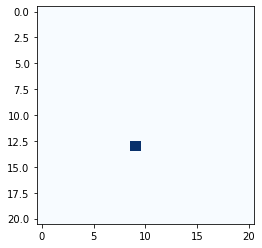

Act_State 1 : [1, 0, 0, 0] Action:  5 1004
Act_State 2 : [1, 0, 0, 0] Action:  5 1004
Act_State 3 : [1, 0, 0, 0] Action:  5 1004
Act_State 4 : [1, 0, 0, 0] Action:  5 1004


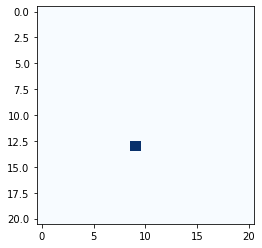

Act_State 1 : [1, 0, 0, 0] Action:  5 1004
Act_State 2 : [1, 0, 0, 0] Action:  5 1004
Act_State 3 : [1, 0, 0, 0] Action:  5 1004
Act_State 4 : [1, 1, 0, 0] Action:  4 1004


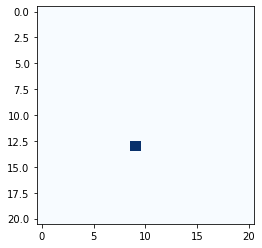

Act_State 1 : [1, 1, 0, 0] Action:  4 1004
Act_State 2 : [1, 1, 0, 0] Action:  4 1004
Act_State 3 : [1, 1, 0, 0] Action:  4 1004
Act_State 4 : [1, 1, 0, 0] Action:  4 1004


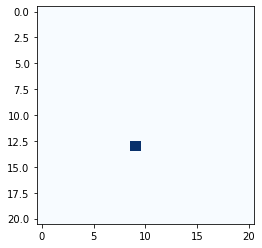

Act_State 1 : [1, 1, 0, 0] Action:  4 1004
Act_State 2 : [1, 1, 0, 0] Action:  4 1004
Act_State 3 : [1, 1, 0, 0] Action:  4 1004
Act_State 4 : [1, 1, 0, 0] Action:  4 1004


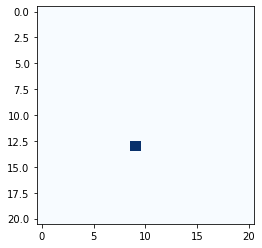

Act_State 1 : [1, 1, 0, 0] Action:  4 1004
Act_State 2 : [1, 1, 0, 0] Action:  4 1004
Act_State 3 : [1, 1, 0, 0] Action:  4 1004
Act_State 4 : [1, 1, 0, 0] Action:  4 1004


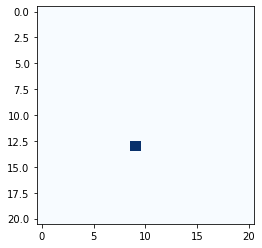

Act_State 1 : [1, 1, 0, 0] Action:  4 1004
Act_State 2 : [1, 1, 0, 0] Action:  4 1004
Act_State 3 : [1, 1, 0, 0] Action:  4 1004
Act_State 4 : [1, 1, 0, 0] Action:  4 1004
Fire ID: 1004 goes POP


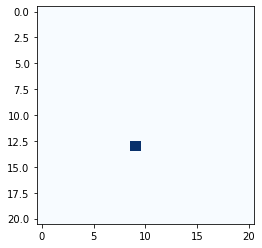

Score: 108.5 Heat:  []
Episode: 5 

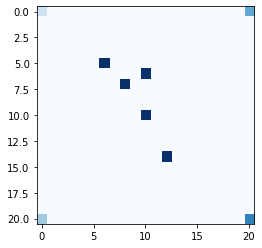

Act_State 1 : [0, 1, 0, 0] Action:  2 1000
Act_State 2 : [0, 1, 0, 0] Action:  1 1003
Act_State 3 : [0, 1, 0, 0] Action:  3 1002
Act_State 4 : [0, 1, 0, 0] Action:  3 1001


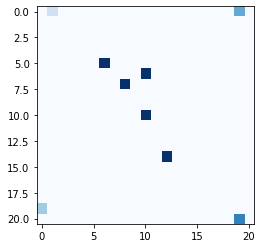

Act_State 1 : [0, 1, 0, 0] Action:  2 1000
Act_State 2 : [0, 1, 0, 0] Action:  1 1003
Act_State 3 : [0, 1, 0, 0] Action:  3 1002
Act_State 4 : [0, 1, 0, 0] Action:  3 1001


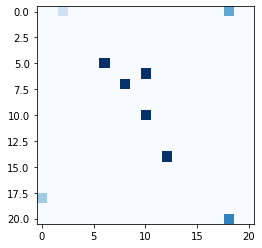

Act_State 1 : [0, 1, 0, 0] Action:  2 1000
Act_State 2 : [0, 1, 0, 0] Action:  1 1003
Act_State 3 : [0, 1, 0, 0] Action:  3 1002
Act_State 4 : [0, 1, 0, 0] Action:  1 1001


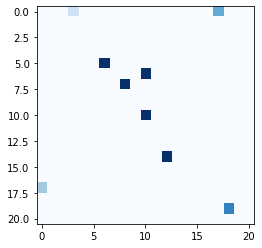

Act_State 1 : [0, 1, 0, 0] Action:  2 1000
Act_State 2 : [0, 1, 0, 0] Action:  1 1003
Act_State 3 : [0, 1, 0, 0] Action:  3 1002
Act_State 4 : [0, 1, 0, 0] Action:  3 1001


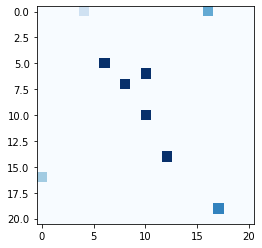

Act_State 1 : [0, 1, 0, 0] Action:  0 1000
Act_State 2 : [0, 1, 0, 0] Action:  1 1003
Act_State 3 : [0, 1, 0, 0] Action:  3 1002
Act_State 4 : [0, 1, 0, 0] Action:  1 1001


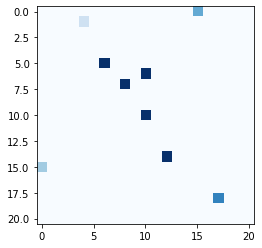

Act_State 1 : [0, 1, 0, 0] Action:  2 1000
Act_State 2 : [0, 1, 0, 0] Action:  1 1003
Act_State 3 : [0, 1, 0, 0] Action:  3 1002
Act_State 4 : [0, 1, 0, 0] Action:  3 1001


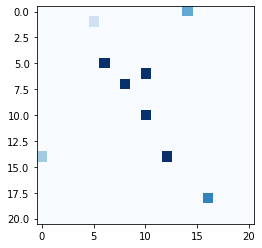

Act_State 1 : [0, 1, 0, 0] Action:  0 1000
Act_State 2 : [0, 1, 0, 0] Action:  2 1003
Act_State 3 : [0, 1, 0, 0] Action:  3 1002
Act_State 4 : [0, 1, 0, 0] Action:  1 1001


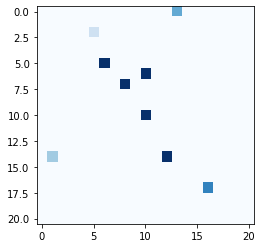

Act_State 1 : [0, 1, 0, 0] Action:  2 1000
Act_State 2 : [0, 1, 0, 0] Action:  1 1003
Act_State 3 : [0, 1, 0, 0] Action:  3 1002
Act_State 4 : [0, 1, 0, 0] Action:  3 1001


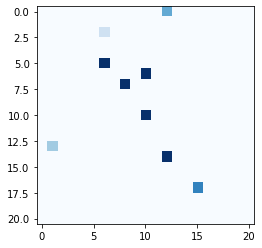

Act_State 1 : [0, 1, 0, 0] Action:  0 1000
Act_State 2 : [0, 1, 0, 0] Action:  2 1003
Act_State 3 : [0, 1, 0, 0] Action:  3 1002
Act_State 4 : [0, 1, 0, 0] Action:  1 1001


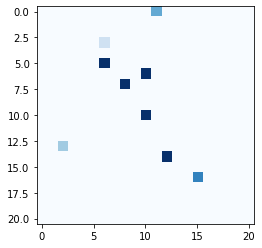

Act_State 1 : [0, 1, 0, 0] Action:  2 1000
Act_State 2 : [0, 1, 0, 0] Action:  1 1003
Act_State 3 : [0, 1, 0, 0] Action:  0 1002
Act_State 4 : [0, 1, 0, 0] Action:  3 1001


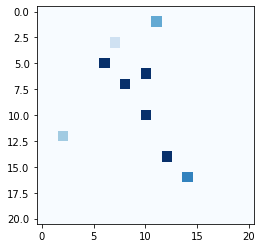

Act_State 1 : [0, 1, 0, 0] Action:  0 1000
Act_State 2 : [0, 1, 0, 0] Action:  2 1003
Act_State 3 : [0, 1, 0, 0] Action:  3 1002
Act_State 4 : [0, 1, 0, 0] Action:  1 1001


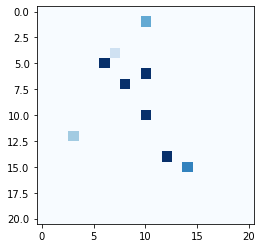

Act_State 1 : [0, 1, 0, 0] Action:  2 1000
Act_State 2 : [0, 1, 0, 0] Action:  1 1003
Act_State 3 : [0, 1, 0, 0] Action:  0 1002
Act_State 4 : [0, 1, 0, 0] Action:  3 1001


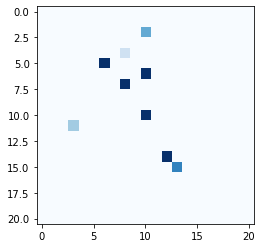

Act_State 1 : [0, 1, 0, 0] Action:  0 1000
Act_State 2 : [0, 1, 0, 0] Action:  2 1003
Act_State 3 : [0, 1, 0, 0] Action:  3 1002
Act_State 4 : [0, 1, 0, 0] Action:  1 1001


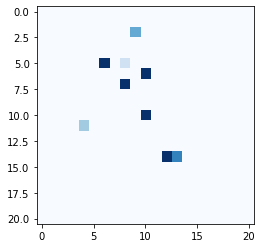

Act_State 1 : [0, 1, 0, 0] Action:  2 1000
Act_State 2 : [0, 1, 0, 0] Action:  1 1003
Act_State 3 : [0, 1, 0, 0] Action:  0 1002
Act_State 4 : [0, 1, 0, 0] Action:  3 1001


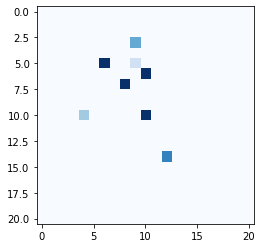

Act_State 1 : [0, 1, 0, 0] Action:  0 1000
Act_State 2 : [0, 1, 0, 0] Action:  2 1003
Act_State 3 : [0, 1, 0, 0] Action:  3 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1001


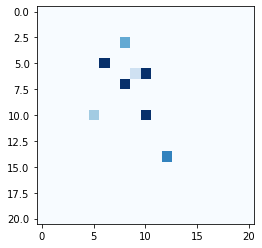

Act_State 1 : [0, 1, 0, 0] Action:  2 1000
Act_State 2 : [0, 1, 0, 0] Action:  1 1003
Act_State 3 : [0, 1, 0, 0] Action:  0 1002
Act_State 4 : [1, 0, 0, 0] Action:  5 1001


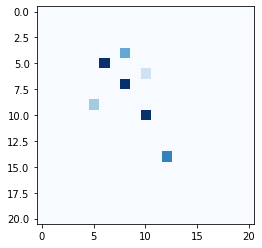

Act_State 1 : [1, 1, 0, 0] Action:  4 1000
Act_State 2 : [0, 1, 0, 0] Action:  2 1003
Act_State 3 : [0, 1, 0, 0] Action:  3 1002
Act_State 4 : [1, 0, 0, 0] Action:  5 1001


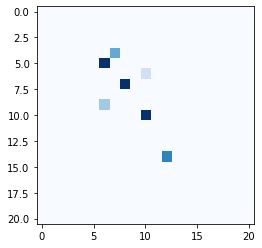

Act_State 1 : [1, 0, 0, 0] Action:  5 1000
Act_State 2 : [0, 1, 0, 0] Action:  1 1003
Act_State 3 : [0, 1, 0, 0] Action:  0 1002
Act_State 4 : [1, 0, 0, 0] Action:  5 1001


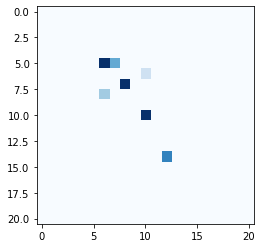

Act_State 1 : [1, 0, 0, 0] Action:  5 1000
Act_State 2 : [0, 1, 0, 0] Action:  2 1003
Act_State 3 : [0, 1, 0, 0] Action:  3 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1001


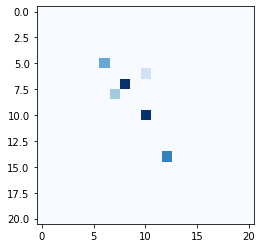

Act_State 1 : [1, 0, 0, 0] Action:  5 1000
Act_State 2 : [0, 1, 0, 0] Action:  1 1003
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1001


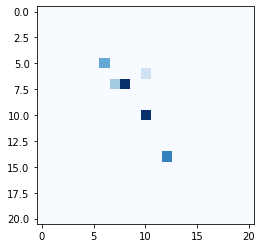

Act_State 1 : [1, 0, 0, 0] Action:  5 1000
Act_State 2 : [0, 1, 0, 0] Action:  2 1003
Act_State 3 : [1, 0, 0, 0] Action:  5 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1001


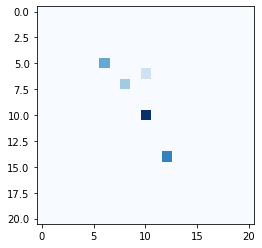

Act_State 1 : [1, 1, 0, 0] Action:  4 1000
Act_State 2 : [1, 1, 0, 0] Action:  4 1003
Act_State 3 : [1, 0, 0, 0] Action:  5 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1001


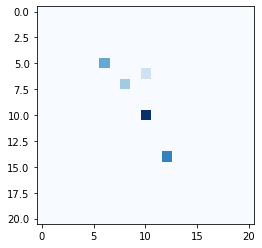

Act_State 1 : [1, 1, 0, 0] Action:  4 1000
Act_State 2 : [1, 0, 0, 0] Action:  5 1003
Act_State 3 : [1, 0, 0, 0] Action:  5 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1001


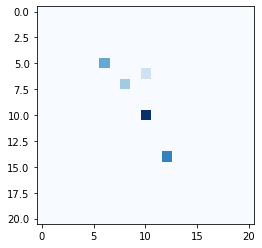

Act_State 1 : [1, 1, 0, 0] Action:  4 1000
Act_State 2 : [1, 0, 0, 0] Action:  5 1003
Act_State 3 : [1, 0, 0, 0] Action:  5 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1001


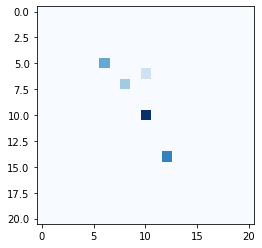

Act_State 1 : [1, 1, 0, 0] Action:  4 1000
Act_State 2 : [1, 0, 0, 0] Action:  5 1003
Act_State 3 : [1, 0, 0, 0] Action:  5 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1001


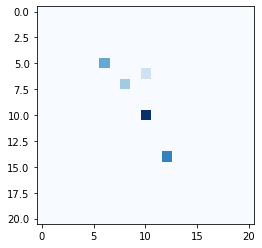

Act_State 1 : [1, 1, 0, 0] Action:  4 1000
Act_State 2 : [1, 0, 0, 0] Action:  5 1003
Act_State 3 : [1, 0, 0, 0] Action:  5 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1001


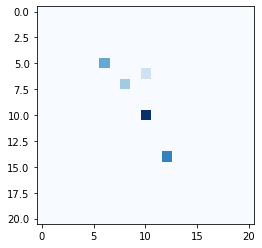

Act_State 1 : [1, 1, 0, 0] Action:  4 1000
Act_State 2 : [1, 0, 0, 0] Action:  5 1003
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1001


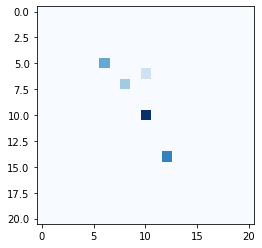

Act_State 1 : [1, 1, 0, 0] Action:  4 1000
Act_State 2 : [1, 0, 0, 0] Action:  5 1003
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1001


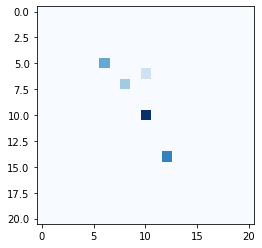

Act_State 1 : [1, 1, 0, 0] Action:  4 1000
Act_State 2 : [1, 0, 0, 0] Action:  5 1003
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1001


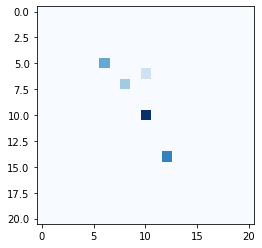

Act_State 1 : [1, 1, 0, 0] Action:  4 1000
Act_State 2 : [1, 1, 0, 0] Action:  4 1003
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1001


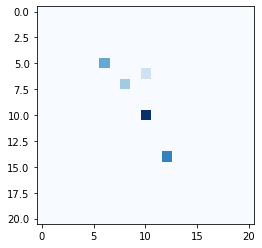

Act_State 1 : [1, 1, 0, 0] Action:  4 1000
Act_State 2 : [1, 1, 0, 0] Action:  4 1003
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1001


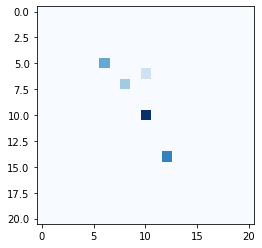

Act_State 1 : [1, 1, 0, 0] Action:  4 1000
Act_State 2 : [1, 1, 0, 0] Action:  4 1003
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1001


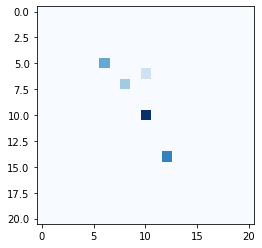

Act_State 1 : [1, 1, 0, 0] Action:  4 1000
Act_State 2 : [1, 1, 0, 0] Action:  4 1003
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1001


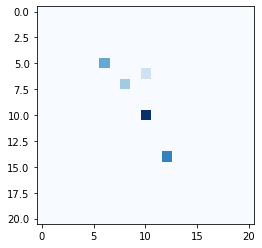

Act_State 1 : [1, 1, 0, 0] Action:  4 1000
Act_State 2 : [1, 1, 0, 0] Action:  4 1003
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1001


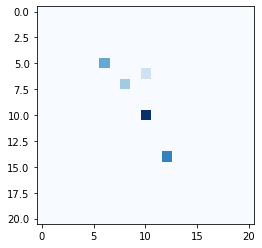

Act_State 1 : [1, 1, 0, 0] Action:  4 1000
Act_State 2 : [1, 1, 0, 0] Action:  4 1003
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1001


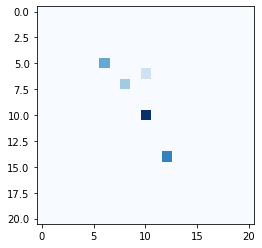

Act_State 1 : [1, 1, 0, 0] Action:  4 1000
Act_State 2 : [1, 1, 0, 0] Action:  4 1003
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1001


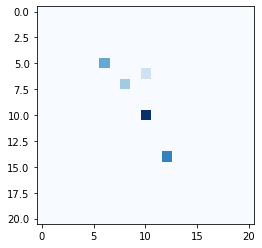

Act_State 1 : [1, 1, 0, 0] Action:  4 1000
Act_State 2 : [1, 1, 0, 0] Action:  4 1003
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1001


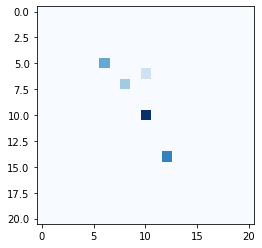

Act_State 1 : [1, 1, 0, 0] Action:  4 1000
Act_State 2 : [1, 1, 0, 0] Action:  4 1003
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1001


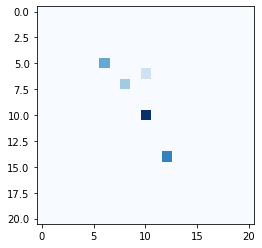

Act_State 1 : [1, 1, 0, 0] Action:  4 1000
Act_State 2 : [1, 1, 0, 0] Action:  4 1003
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1001


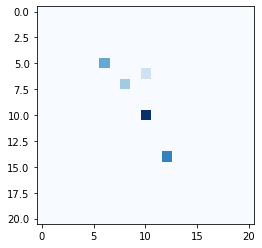

Act_State 1 : [1, 1, 0, 0] Action:  4 1000
Act_State 2 : [1, 1, 0, 0] Action:  4 1003
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1001


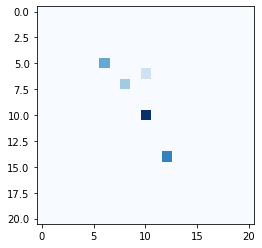

Act_State 1 : [1, 1, 0, 0] Action:  4 1000
Act_State 2 : [1, 1, 0, 0] Action:  4 1003
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1001
Fire ID: 1001 goes POP


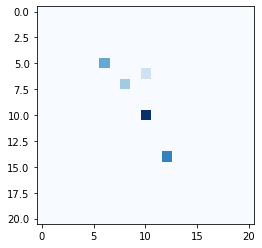

Act_State 1 : [1, 1, 0, 0] Action:  4 1000
Act_State 2 : [1, 1, 0, 0] Action:  4 1003
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [0, 1, 0, 0] Action:  1 1001


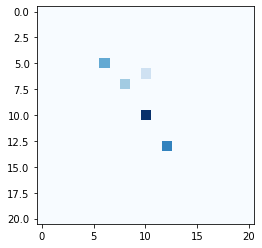

Act_State 1 : [1, 1, 0, 0] Action:  4 1000
Act_State 2 : [1, 1, 0, 0] Action:  4 1003
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [0, 1, 0, 0] Action:  1 1004


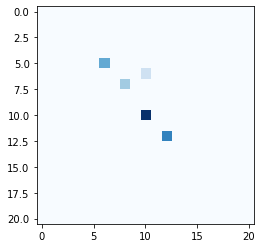

Act_State 1 : [1, 1, 0, 0] Action:  4 1000
Act_State 2 : [1, 1, 0, 0] Action:  4 1003
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [0, 1, 0, 0] Action:  1 1004
Fire ID: 1000 goes POP


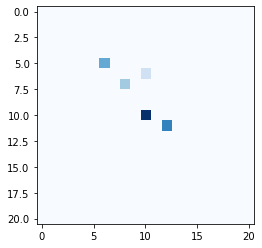

Act_State 1 : [0, 1, 0, 0] Action:  1 1000
Act_State 2 : [1, 1, 0, 0] Action:  4 1003
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [0, 1, 0, 0] Action:  3 1004


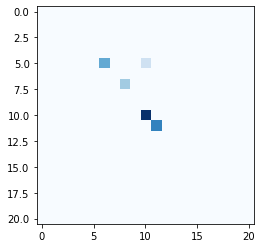

Act_State 1 : [0, 1, 0, 0] Action:  0 1003
Act_State 2 : [1, 1, 0, 0] Action:  4 1003
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [0, 1, 0, 0] Action:  1 1004


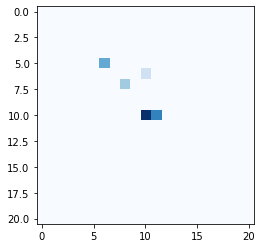

Act_State 1 : [0, 1, 0, 0] Action:  3 1003
Act_State 2 : [1, 1, 0, 0] Action:  4 1003
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [0, 1, 0, 0] Action:  3 1004


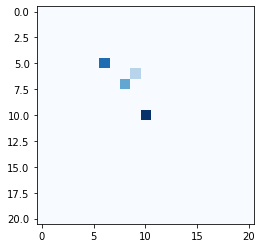

Act_State 1 : [0, 1, 0, 0] Action:  0 1003
Act_State 2 : [1, 1, 0, 0] Action:  4 1003
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1004


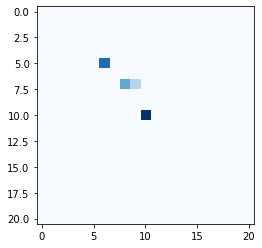

Act_State 1 : [0, 1, 0, 0] Action:  3 1003
Act_State 2 : [1, 1, 0, 0] Action:  4 1003
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [1, 0, 0, 0] Action:  5 1004


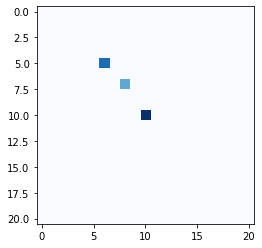

Act_State 1 : [1, 1, 0, 0] Action:  4 1003
Act_State 2 : [1, 1, 0, 0] Action:  4 1003
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [1, 0, 0, 0] Action:  5 1004
Fire ID: 1002 goes POP
Fire ID: 1003 goes POP


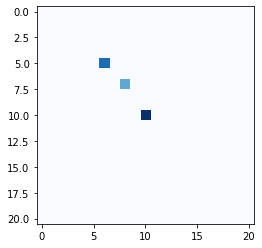

Act_State 1 : [0, 1, 0, 0] Action:  1 1003
Act_State 2 : [0, 1, 0, 0] Action:  0 1004
Act_State 3 : [0, 1, 0, 0] Action:  1 1002
Act_State 4 : [1, 0, 0, 0] Action:  5 1004


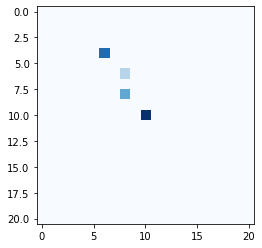

Act_State 1 : [0, 1, 0, 0] Action:  0 1004
Act_State 2 : [0, 1, 0, 0] Action:  0 1004
Act_State 3 : [0, 1, 0, 0] Action:  0 1004
Act_State 4 : [1, 0, 1, 0] Action:  4 1004


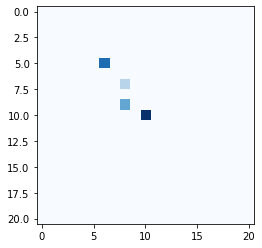

Act_State 1 : [0, 1, 0, 0] Action:  0 1004
Act_State 2 : [0, 1, 0, 0] Action:  2 1004
Act_State 3 : [0, 1, 0, 0] Action:  0 1004
Act_State 4 : [1, 0, 1, 0] Action:  4 1004


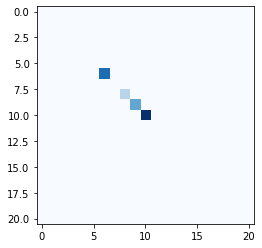

Act_State 1 : [0, 1, 0, 0] Action:  0 1004
Act_State 2 : [0, 1, 0, 0] Action:  0 1004
Act_State 3 : [0, 1, 0, 0] Action:  0 1004
Act_State 4 : [1, 0, 1, 0] Action:  4 1004


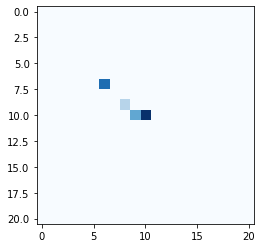

Act_State 1 : [0, 1, 0, 0] Action:  2 1004
Act_State 2 : [0, 1, 0, 0] Action:  2 1004
Act_State 3 : [0, 1, 0, 0] Action:  2 1004
Act_State 4 : [1, 0, 1, 0] Action:  4 1004


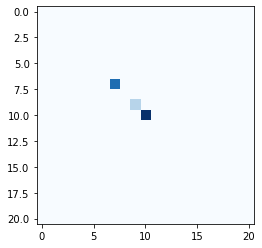

Act_State 1 : [0, 1, 0, 0] Action:  0 1004
Act_State 2 : [1, 1, 0, 0] Action:  4 1004
Act_State 3 : [0, 1, 0, 0] Action:  0 1004
Act_State 4 : [1, 0, 1, 0] Action:  4 1004


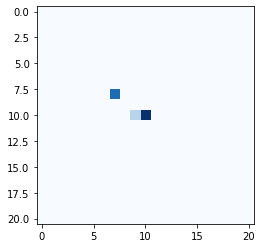

Act_State 1 : [0, 1, 0, 0] Action:  2 1004
Act_State 2 : [1, 0, 0, 0] Action:  5 1004
Act_State 3 : [0, 1, 0, 0] Action:  2 1004
Act_State 4 : [1, 0, 1, 0] Action:  4 1004


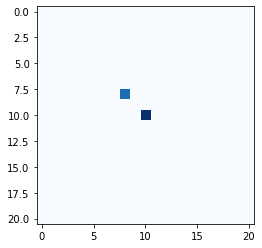

Act_State 1 : [1, 1, 0, 0] Action:  4 1004
Act_State 2 : [1, 0, 0, 0] Action:  5 1004
Act_State 3 : [0, 1, 0, 0] Action:  0 1004
Act_State 4 : [1, 0, 1, 0] Action:  4 1004


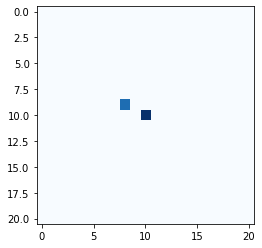

Act_State 1 : [1, 0, 0, 0] Action:  5 1004
Act_State 2 : [1, 0, 0, 0] Action:  5 1004
Act_State 3 : [0, 1, 0, 0] Action:  2 1004
Act_State 4 : [1, 0, 1, 0] Action:  4 1004


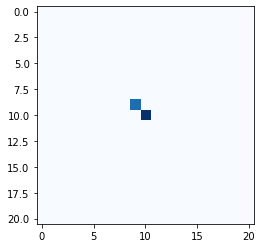

Act_State 1 : [1, 0, 0, 0] Action:  5 1004
Act_State 2 : [1, 0, 0, 0] Action:  5 1004
Act_State 3 : [0, 1, 0, 0] Action:  0 1004
Act_State 4 : [1, 0, 1, 0] Action:  4 1004


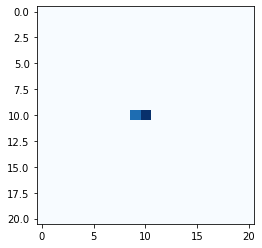

Act_State 1 : [1, 0, 0, 0] Action:  5 1004
Act_State 2 : [1, 0, 0, 0] Action:  5 1004
Act_State 3 : [0, 1, 0, 0] Action:  2 1004
Act_State 4 : [1, 0, 1, 0] Action:  4 1004


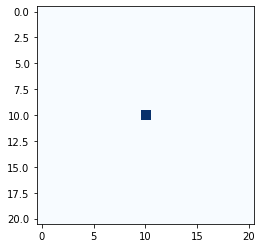

Act_State 1 : [1, 0, 0, 0] Action:  5 1004
Act_State 2 : [1, 1, 0, 0] Action:  4 1004
Act_State 3 : [1, 1, 0, 0] Action:  4 1004
Act_State 4 : [1, 1, 1, 0] Action:  4 1004


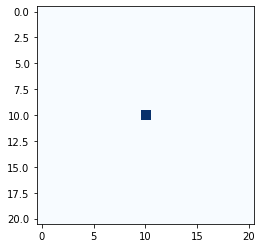

Act_State 1 : [1, 1, 0, 0] Action:  4 1004
Act_State 2 : [1, 1, 0, 0] Action:  4 1004
Act_State 3 : [1, 1, 0, 0] Action:  4 1004
Act_State 4 : [1, 1, 1, 0] Action:  4 1004


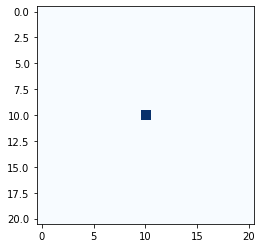

Act_State 1 : [1, 1, 0, 0] Action:  4 1004
Act_State 2 : [1, 1, 0, 0] Action:  4 1004
Act_State 3 : [1, 1, 0, 0] Action:  4 1004
Act_State 4 : [1, 1, 1, 0] Action:  4 1004


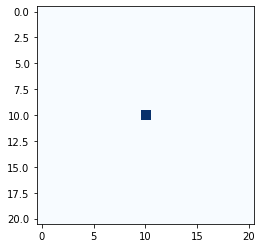

Act_State 1 : [1, 1, 0, 0] Action:  4 1004
Act_State 2 : [1, 1, 0, 0] Action:  4 1004
Act_State 3 : [1, 1, 0, 0] Action:  4 1004
Act_State 4 : [1, 1, 1, 0] Action:  4 1004


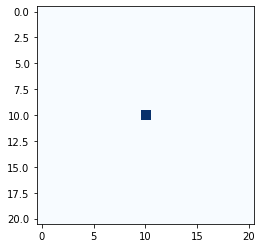

Act_State 1 : [1, 1, 0, 0] Action:  4 1004
Act_State 2 : [1, 1, 0, 0] Action:  4 1004
Act_State 3 : [1, 1, 0, 0] Action:  4 1004
Act_State 4 : [1, 1, 1, 0] Action:  4 1004
Fire ID: 1004 goes POP


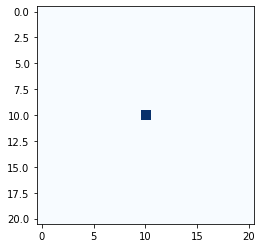

Score: 82.5 Heat:  []
Episode: 6 

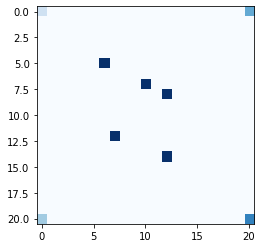

Act_State 1 : [0, 1, 0, 0] Action:  2 1000
Act_State 2 : [0, 1, 0, 0] Action:  1 1002
Act_State 3 : [0, 1, 0, 0] Action:  3 1003
Act_State 4 : [0, 1, 0, 0] Action:  3 1001


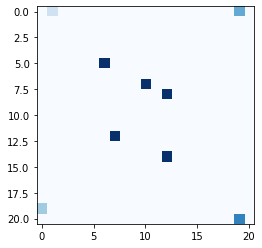

Act_State 1 : [0, 1, 0, 0] Action:  0 1000
Act_State 2 : [0, 1, 0, 0] Action:  1 1002
Act_State 3 : [0, 1, 0, 0] Action:  3 1003
Act_State 4 : [0, 1, 0, 0] Action:  3 1001


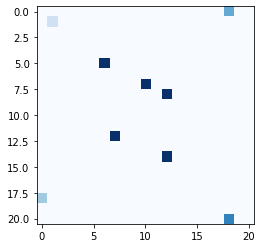

Act_State 1 : [0, 1, 0, 0] Action:  2 1000
Act_State 2 : [0, 1, 0, 0] Action:  2 1002
Act_State 3 : [0, 1, 0, 0] Action:  3 1003
Act_State 4 : [0, 1, 0, 0] Action:  1 1001


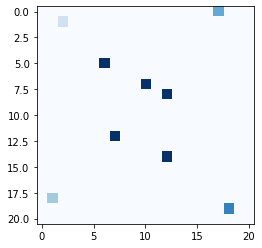

Act_State 1 : [0, 1, 0, 0] Action:  0 1000
Act_State 2 : [0, 1, 0, 0] Action:  1 1002
Act_State 3 : [0, 1, 0, 0] Action:  0 1003
Act_State 4 : [0, 1, 0, 0] Action:  3 1001


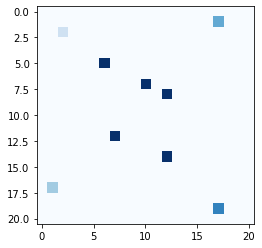

Act_State 1 : [0, 1, 0, 0] Action:  2 1000
Act_State 2 : [0, 1, 0, 0] Action:  2 1002
Act_State 3 : [0, 1, 0, 0] Action:  3 1003
Act_State 4 : [0, 1, 0, 0] Action:  1 1001


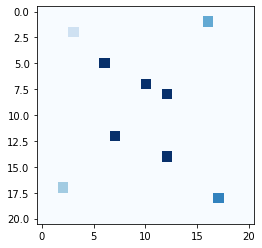

Act_State 1 : [0, 1, 0, 0] Action:  0 1000
Act_State 2 : [0, 1, 0, 0] Action:  1 1002
Act_State 3 : [0, 1, 0, 0] Action:  0 1003
Act_State 4 : [0, 1, 0, 0] Action:  3 1001


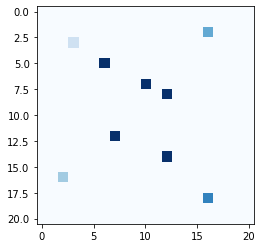

Act_State 1 : [0, 1, 0, 0] Action:  2 1000
Act_State 2 : [0, 1, 0, 0] Action:  2 1002
Act_State 3 : [0, 1, 0, 0] Action:  3 1003
Act_State 4 : [0, 1, 0, 0] Action:  1 1001


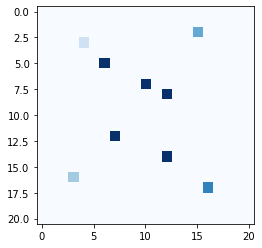

Act_State 1 : [0, 1, 0, 0] Action:  0 1000
Act_State 2 : [0, 1, 0, 0] Action:  1 1002
Act_State 3 : [0, 1, 0, 0] Action:  0 1003
Act_State 4 : [0, 1, 0, 0] Action:  3 1001


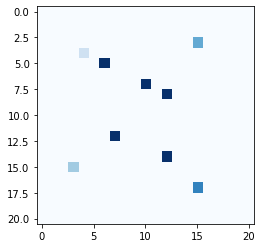

Act_State 1 : [0, 1, 0, 0] Action:  2 1000
Act_State 2 : [0, 1, 0, 0] Action:  2 1002
Act_State 3 : [0, 1, 0, 0] Action:  3 1003
Act_State 4 : [0, 1, 0, 0] Action:  1 1001


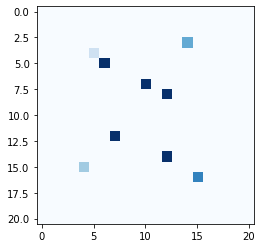

Act_State 1 : [0, 1, 0, 0] Action:  0 1000
Act_State 2 : [0, 1, 0, 0] Action:  1 1002
Act_State 3 : [0, 1, 0, 0] Action:  0 1003
Act_State 4 : [0, 1, 0, 0] Action:  3 1001


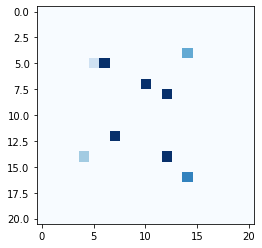

Act_State 1 : [0, 1, 0, 0] Action:  2 1000
Act_State 2 : [0, 1, 0, 0] Action:  2 1002
Act_State 3 : [0, 1, 0, 0] Action:  3 1003
Act_State 4 : [0, 1, 0, 0] Action:  1 1001


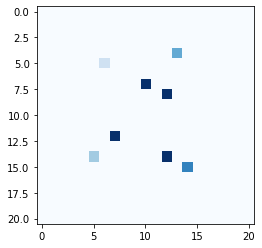

Act_State 1 : [1, 1, 0, 0] Action:  4 1000
Act_State 2 : [0, 1, 0, 0] Action:  1 1002
Act_State 3 : [0, 1, 0, 0] Action:  0 1003
Act_State 4 : [0, 1, 0, 0] Action:  3 1001


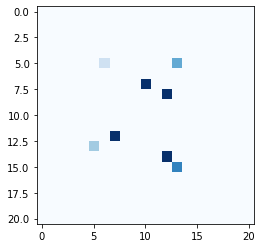

Act_State 1 : [1, 0, 0, 0] Action:  5 1000
Act_State 2 : [0, 1, 0, 0] Action:  2 1002
Act_State 3 : [0, 1, 0, 0] Action:  3 1003
Act_State 4 : [0, 1, 0, 0] Action:  1 1001


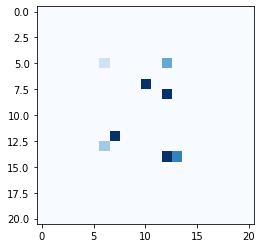

Act_State 1 : [1, 0, 0, 0] Action:  5 1000
Act_State 2 : [0, 1, 0, 0] Action:  1 1002
Act_State 3 : [0, 1, 0, 0] Action:  0 1003
Act_State 4 : [0, 1, 0, 0] Action:  3 1001


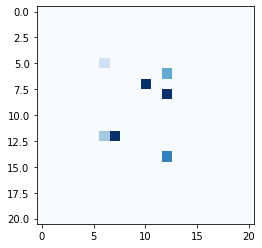

Act_State 1 : [1, 0, 0, 0] Action:  5 1000
Act_State 2 : [0, 1, 0, 0] Action:  2 1002
Act_State 3 : [0, 1, 0, 0] Action:  3 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1001


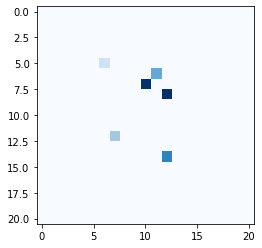

Act_State 1 : [1, 1, 0, 0] Action:  4 1000
Act_State 2 : [1, 1, 0, 0] Action:  4 1002
Act_State 3 : [0, 1, 0, 0] Action:  0 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1001


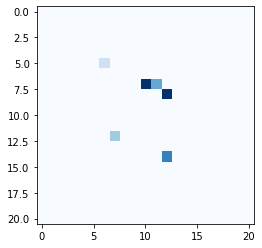

Act_State 1 : [1, 0, 0, 0] Action:  5 1000
Act_State 2 : [1, 0, 0, 0] Action:  5 1002
Act_State 3 : [0, 1, 0, 0] Action:  3 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1001


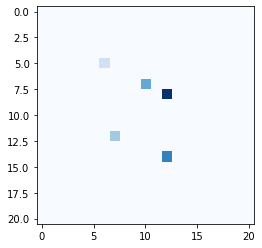

Act_State 1 : [1, 0, 0, 0] Action:  5 1000
Act_State 2 : [1, 0, 0, 0] Action:  5 1002
Act_State 3 : [1, 1, 0, 0] Action:  4 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1001


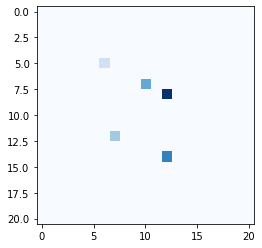

Act_State 1 : [1, 0, 0, 0] Action:  5 1000
Act_State 2 : [1, 0, 0, 0] Action:  5 1002
Act_State 3 : [1, 0, 0, 0] Action:  5 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1001


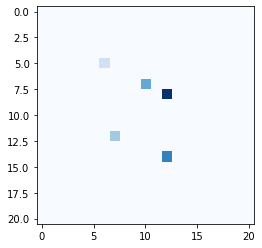

Act_State 1 : [1, 1, 0, 0] Action:  4 1000
Act_State 2 : [1, 0, 0, 0] Action:  5 1002
Act_State 3 : [1, 0, 0, 0] Action:  5 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1001


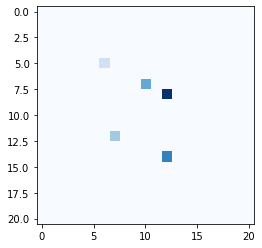

Act_State 1 : [1, 1, 0, 0] Action:  4 1000
Act_State 2 : [1, 1, 0, 0] Action:  4 1002
Act_State 3 : [1, 0, 0, 0] Action:  5 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1001


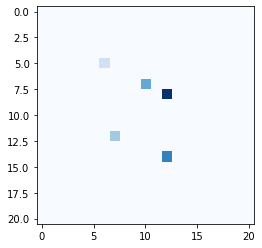

Act_State 1 : [1, 1, 0, 0] Action:  4 1000
Act_State 2 : [1, 0, 0, 0] Action:  5 1002
Act_State 3 : [1, 0, 0, 0] Action:  5 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1001


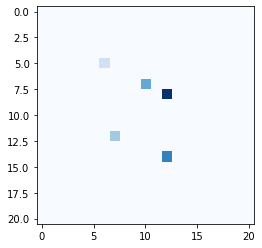

Act_State 1 : [1, 1, 0, 0] Action:  4 1000
Act_State 2 : [1, 0, 0, 0] Action:  5 1002
Act_State 3 : [1, 0, 0, 0] Action:  5 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1001


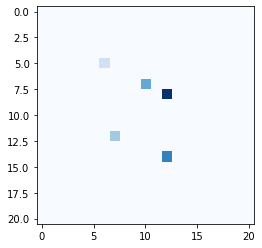

Act_State 1 : [1, 1, 0, 0] Action:  4 1000
Act_State 2 : [1, 0, 0, 0] Action:  5 1002
Act_State 3 : [1, 1, 0, 0] Action:  4 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1001


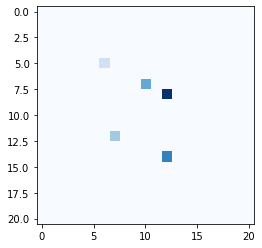

Act_State 1 : [1, 1, 0, 0] Action:  4 1000
Act_State 2 : [1, 1, 0, 0] Action:  4 1002
Act_State 3 : [1, 0, 0, 0] Action:  5 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1001


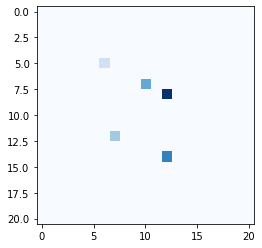

Act_State 1 : [1, 1, 0, 0] Action:  4 1000
Act_State 2 : [1, 0, 0, 0] Action:  5 1002
Act_State 3 : [1, 0, 0, 0] Action:  5 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1001


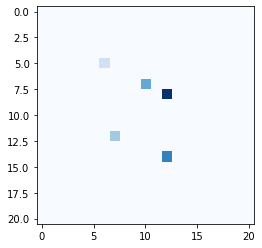

Act_State 1 : [1, 1, 0, 0] Action:  4 1000
Act_State 2 : [1, 0, 0, 0] Action:  5 1002
Act_State 3 : [1, 1, 0, 0] Action:  4 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1001


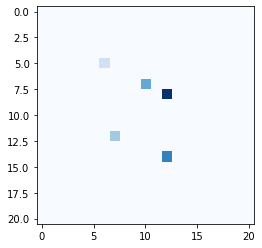

Act_State 1 : [1, 1, 0, 0] Action:  4 1000
Act_State 2 : [1, 1, 0, 0] Action:  4 1002
Act_State 3 : [1, 0, 0, 0] Action:  5 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1001


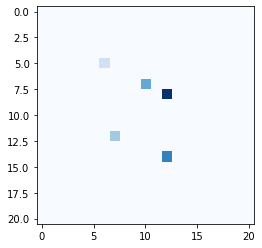

Act_State 1 : [1, 1, 0, 0] Action:  4 1000
Act_State 2 : [1, 0, 0, 0] Action:  5 1002
Act_State 3 : [1, 0, 0, 0] Action:  5 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1001


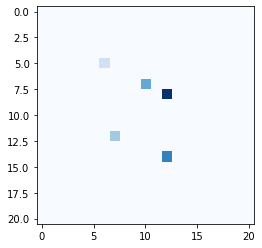

Act_State 1 : [1, 1, 0, 0] Action:  4 1000
Act_State 2 : [1, 0, 0, 0] Action:  5 1002
Act_State 3 : [1, 1, 0, 0] Action:  4 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1001


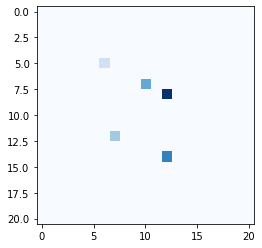

Act_State 1 : [1, 1, 0, 0] Action:  4 1000
Act_State 2 : [1, 0, 0, 0] Action:  5 1002
Act_State 3 : [1, 0, 0, 0] Action:  5 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1001


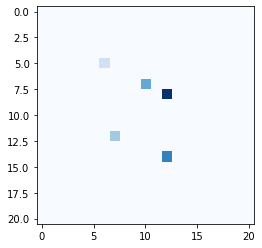

Act_State 1 : [1, 1, 0, 0] Action:  4 1000
Act_State 2 : [1, 1, 0, 0] Action:  4 1002
Act_State 3 : [1, 0, 0, 0] Action:  5 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1001


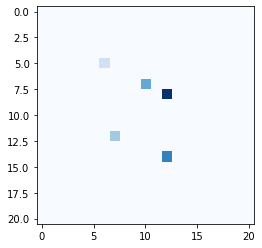

Act_State 1 : [1, 1, 0, 0] Action:  4 1000
Act_State 2 : [1, 1, 0, 0] Action:  4 1002
Act_State 3 : [1, 0, 0, 0] Action:  5 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1001


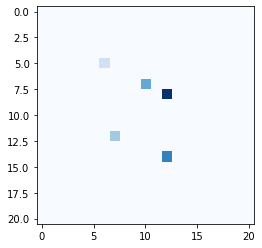

Act_State 1 : [1, 1, 0, 0] Action:  4 1000
Act_State 2 : [1, 1, 0, 0] Action:  4 1002
Act_State 3 : [1, 1, 0, 0] Action:  4 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1001


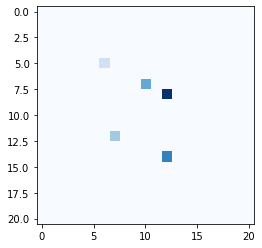

Act_State 1 : [1, 1, 0, 0] Action:  4 1000
Act_State 2 : [1, 1, 0, 0] Action:  4 1002
Act_State 3 : [1, 1, 0, 0] Action:  4 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1001


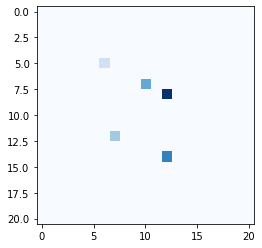

Act_State 1 : [1, 1, 0, 0] Action:  4 1000
Act_State 2 : [1, 1, 0, 0] Action:  4 1002
Act_State 3 : [1, 1, 0, 0] Action:  4 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1001


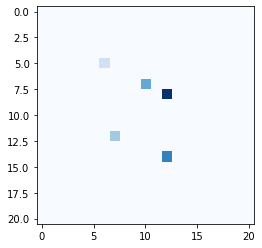

Act_State 1 : [1, 1, 0, 0] Action:  4 1000
Act_State 2 : [1, 1, 0, 0] Action:  4 1002
Act_State 3 : [1, 1, 0, 0] Action:  4 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1001


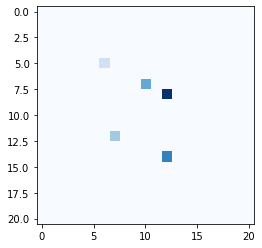

Act_State 1 : [1, 1, 0, 0] Action:  4 1000
Act_State 2 : [1, 1, 0, 0] Action:  4 1002
Act_State 3 : [1, 1, 0, 0] Action:  4 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1001
Fire ID: 1001 goes POP


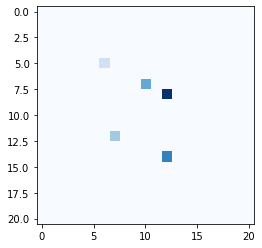

Act_State 1 : [1, 1, 0, 0] Action:  4 1000
Act_State 2 : [1, 1, 0, 0] Action:  4 1002
Act_State 3 : [1, 1, 0, 0] Action:  4 1003
Act_State 4 : [0, 1, 0, 0] Action:  1 1000


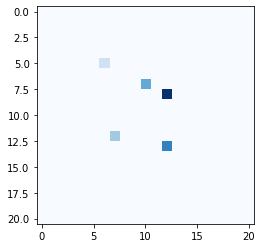

Act_State 1 : [1, 1, 0, 0] Action:  4 1000
Act_State 2 : [1, 1, 0, 0] Action:  4 1002
Act_State 3 : [1, 1, 0, 0] Action:  4 1003
Act_State 4 : [0, 1, 0, 0] Action:  1 1000


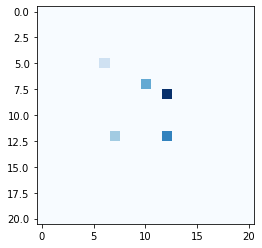

Act_State 1 : [1, 1, 0, 0] Action:  4 1000
Act_State 2 : [1, 1, 0, 0] Action:  4 1002
Act_State 3 : [1, 1, 0, 0] Action:  4 1003
Act_State 4 : [0, 1, 0, 0] Action:  1 1000


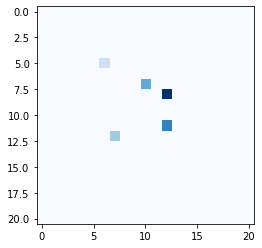

Act_State 1 : [1, 1, 0, 0] Action:  4 1000
Act_State 2 : [1, 1, 0, 0] Action:  4 1002
Act_State 3 : [1, 1, 0, 0] Action:  4 1003
Act_State 4 : [0, 1, 0, 0] Action:  1 1000
Fire ID: 1000 goes POP


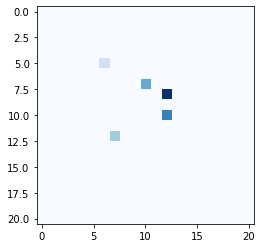

Act_State 1 : [0, 1, 0, 0] Action:  2 1003
Act_State 2 : [1, 1, 0, 0] Action:  4 1002
Act_State 3 : [1, 1, 0, 0] Action:  4 1003
Act_State 4 : [0, 1, 0, 0] Action:  3 1002


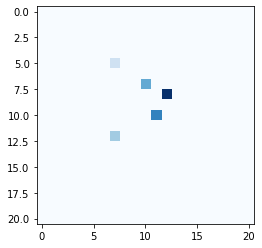

Act_State 1 : [0, 1, 0, 0] Action:  2 1003
Act_State 2 : [1, 1, 0, 0] Action:  4 1002
Act_State 3 : [1, 1, 0, 0] Action:  4 1003
Act_State 4 : [0, 1, 0, 0] Action:  3 1002


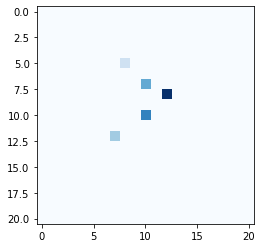

Act_State 1 : [0, 1, 0, 0] Action:  0 1003
Act_State 2 : [1, 1, 0, 0] Action:  4 1002
Act_State 3 : [1, 1, 0, 0] Action:  4 1003
Act_State 4 : [0, 1, 0, 0] Action:  3 1002


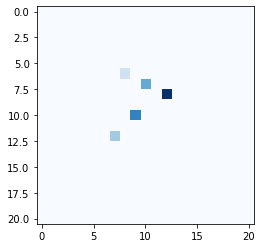

Act_State 1 : [0, 1, 0, 0] Action:  2 1003
Act_State 2 : [1, 1, 0, 0] Action:  4 1002
Act_State 3 : [1, 1, 0, 0] Action:  4 1003
Act_State 4 : [0, 1, 0, 0] Action:  0 1002


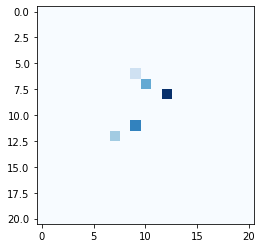

Act_State 1 : [0, 1, 0, 0] Action:  0 1003
Act_State 2 : [1, 1, 0, 0] Action:  4 1002
Act_State 3 : [1, 1, 0, 0] Action:  4 1003
Act_State 4 : [0, 1, 0, 0] Action:  3 1002


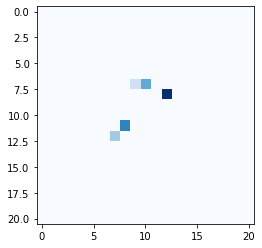

Act_State 1 : [0, 1, 0, 0] Action:  2 1003
Act_State 2 : [1, 1, 0, 0] Action:  4 1002
Act_State 3 : [1, 1, 0, 0] Action:  4 1003
Act_State 4 : [0, 1, 0, 0] Action:  0 1002


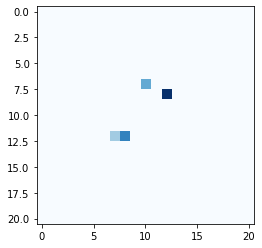

Act_State 1 : [1, 1, 0, 0] Action:  4 1003
Act_State 2 : [1, 1, 0, 0] Action:  4 1002
Act_State 3 : [1, 1, 0, 0] Action:  4 1003
Act_State 4 : [0, 1, 0, 0] Action:  3 1002


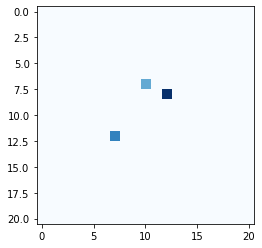

Act_State 1 : [1, 1, 0, 0] Action:  4 1003
Act_State 2 : [1, 1, 0, 0] Action:  4 1002
Act_State 3 : [1, 1, 0, 0] Action:  4 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1002


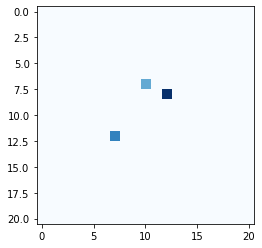

Act_State 1 : [1, 1, 0, 0] Action:  4 1003
Act_State 2 : [1, 1, 0, 0] Action:  4 1002
Act_State 3 : [1, 1, 0, 0] Action:  4 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1002
Fire ID: 1002 goes POP


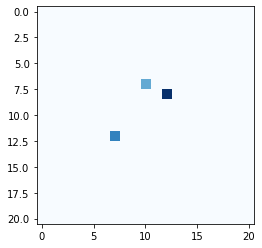

Act_State 1 : [1, 1, 0, 0] Action:  4 1003
Act_State 2 : [0, 1, 0, 0] Action:  1 1003
Act_State 3 : [1, 1, 0, 0] Action:  4 1003
Act_State 4 : [0, 1, 0, 0] Action:  1 1003
Fire ID: 1003 goes POP


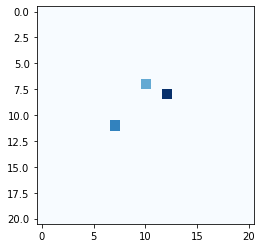

Act_State 1 : [0, 1, 0, 0] Action:  2 1004
Act_State 2 : [0, 1, 0, 0] Action:  2 1004
Act_State 3 : [0, 1, 0, 0] Action:  2 1004
Act_State 4 : [0, 1, 0, 0] Action:  2 1004


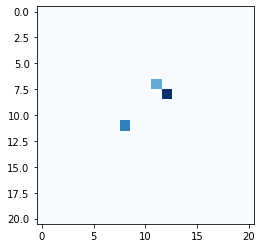

Act_State 1 : [0, 1, 0, 0] Action:  0 1004
Act_State 2 : [0, 1, 0, 0] Action:  2 1004
Act_State 3 : [0, 1, 0, 0] Action:  0 1004
Act_State 4 : [0, 1, 0, 0] Action:  2 1004


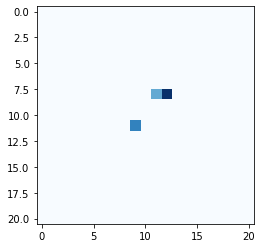

Act_State 1 : [0, 1, 0, 0] Action:  2 1004
Act_State 2 : [0, 1, 0, 0] Action:  1 1004
Act_State 3 : [0, 1, 0, 0] Action:  2 1004
Act_State 4 : [0, 1, 0, 0] Action:  1 1004


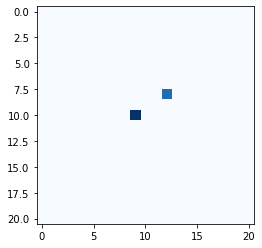

Act_State 1 : [1, 1, 0, 0] Action:  4 1004
Act_State 2 : [0, 1, 0, 0] Action:  2 1004
Act_State 3 : [1, 1, 0, 0] Action:  4 1004
Act_State 4 : [0, 1, 0, 0] Action:  2 1004


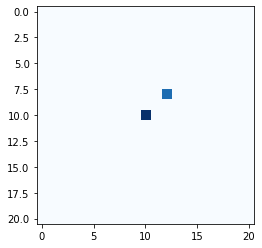

Act_State 1 : [1, 0, 0, 0] Action:  5 1004
Act_State 2 : [0, 1, 0, 0] Action:  1 1004
Act_State 3 : [1, 0, 0, 0] Action:  5 1004
Act_State 4 : [0, 1, 0, 0] Action:  1 1004


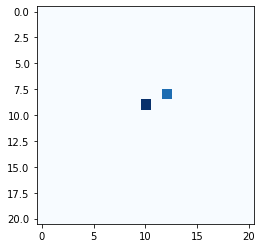

Act_State 1 : [1, 0, 0, 0] Action:  5 1004
Act_State 2 : [0, 1, 0, 0] Action:  2 1004
Act_State 3 : [1, 0, 0, 0] Action:  5 1004
Act_State 4 : [0, 1, 0, 0] Action:  2 1004


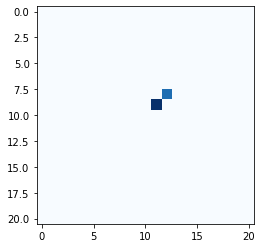

Act_State 1 : [1, 0, 0, 0] Action:  5 1004
Act_State 2 : [0, 1, 0, 0] Action:  1 1004
Act_State 3 : [1, 0, 0, 0] Action:  5 1004
Act_State 4 : [0, 1, 0, 0] Action:  1 1004


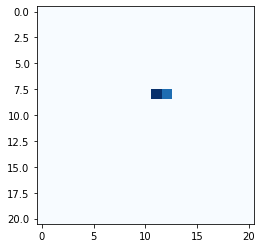

Act_State 1 : [1, 0, 0, 0] Action:  5 1004
Act_State 2 : [0, 1, 0, 0] Action:  2 1004
Act_State 3 : [1, 0, 0, 0] Action:  5 1004
Act_State 4 : [0, 1, 0, 0] Action:  2 1004


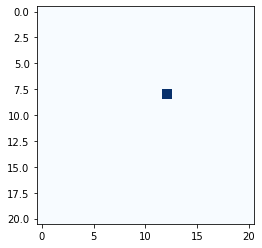

Act_State 1 : [1, 0, 0, 0] Action:  5 1004
Act_State 2 : [1, 1, 0, 0] Action:  4 1004
Act_State 3 : [1, 0, 0, 0] Action:  5 1004
Act_State 4 : [1, 1, 0, 0] Action:  4 1004


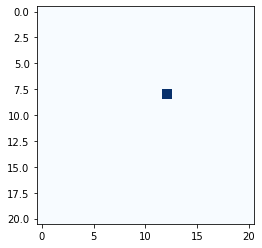

Act_State 1 : [1, 0, 0, 0] Action:  5 1004
Act_State 2 : [1, 0, 0, 0] Action:  5 1004
Act_State 3 : [1, 0, 0, 0] Action:  5 1004
Act_State 4 : [1, 0, 0, 0] Action:  5 1004


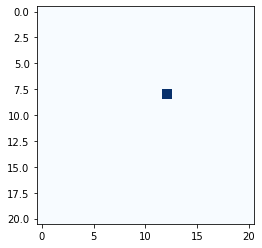

Act_State 1 : [1, 0, 0, 0] Action:  5 1004
Act_State 2 : [1, 0, 0, 0] Action:  5 1004
Act_State 3 : [1, 0, 0, 0] Action:  5 1004
Act_State 4 : [1, 0, 0, 0] Action:  5 1004


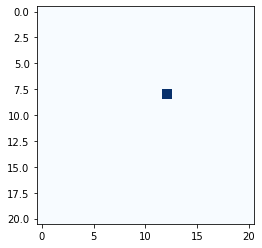

Act_State 1 : [1, 0, 0, 0] Action:  5 1004
Act_State 2 : [1, 0, 0, 0] Action:  5 1004
Act_State 3 : [1, 0, 0, 0] Action:  5 1004
Act_State 4 : [1, 0, 0, 0] Action:  5 1004


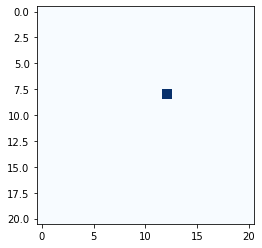

Act_State 1 : [1, 0, 0, 0] Action:  5 1004
Act_State 2 : [1, 1, 0, 0] Action:  4 1004
Act_State 3 : [1, 1, 0, 0] Action:  4 1004
Act_State 4 : [1, 1, 0, 0] Action:  4 1004


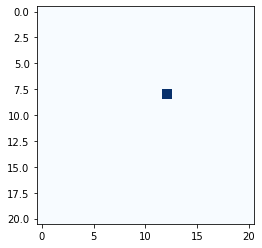

Act_State 1 : [1, 1, 0, 0] Action:  4 1004
Act_State 2 : [1, 1, 0, 0] Action:  4 1004
Act_State 3 : [1, 1, 0, 0] Action:  4 1004
Act_State 4 : [1, 1, 0, 0] Action:  4 1004


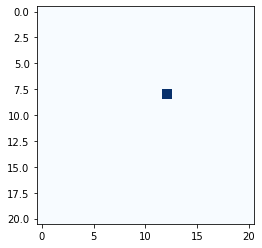

Act_State 1 : [1, 1, 0, 0] Action:  4 1004
Act_State 2 : [1, 1, 0, 0] Action:  4 1004
Act_State 3 : [1, 1, 0, 0] Action:  4 1004
Act_State 4 : [1, 1, 0, 0] Action:  4 1004


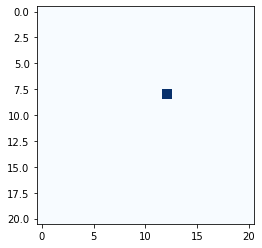

Act_State 1 : [1, 1, 0, 0] Action:  4 1004
Act_State 2 : [1, 1, 0, 0] Action:  4 1004
Act_State 3 : [1, 1, 0, 0] Action:  4 1004
Act_State 4 : [1, 1, 0, 0] Action:  4 1004


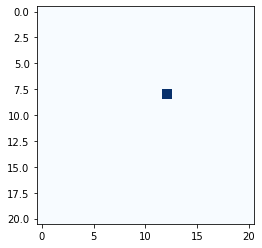

Act_State 1 : [1, 1, 0, 0] Action:  4 1004
Act_State 2 : [1, 1, 0, 0] Action:  4 1004
Act_State 3 : [1, 1, 0, 0] Action:  4 1004
Act_State 4 : [1, 1, 0, 0] Action:  4 1004
Fire ID: 1004 goes POP


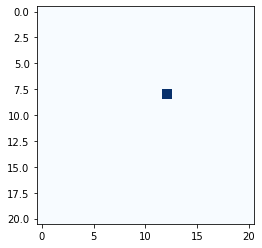

Score: 119.5 Heat:  []
Episode: 7 

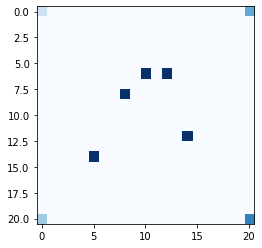

Act_State 1 : [0, 1, 0, 0] Action:  0 1002
Act_State 2 : [0, 1, 0, 0] Action:  1 1001
Act_State 3 : [0, 1, 0, 0] Action:  3 1000
Act_State 4 : [0, 1, 0, 0] Action:  1 1003


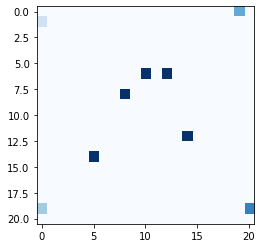

Act_State 1 : [0, 1, 0, 0] Action:  2 1002
Act_State 2 : [0, 1, 0, 0] Action:  1 1001
Act_State 3 : [0, 1, 0, 0] Action:  3 1000
Act_State 4 : [0, 1, 0, 0] Action:  1 1003


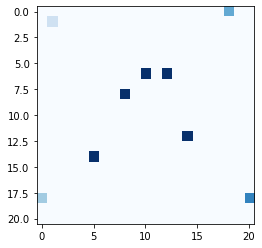

Act_State 1 : [0, 1, 0, 0] Action:  0 1002
Act_State 2 : [0, 1, 0, 0] Action:  2 1001
Act_State 3 : [0, 1, 0, 0] Action:  0 1000
Act_State 4 : [0, 1, 0, 0] Action:  1 1003


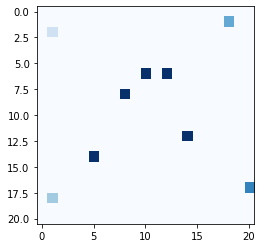

Act_State 1 : [0, 1, 0, 0] Action:  2 1002
Act_State 2 : [0, 1, 0, 0] Action:  1 1001
Act_State 3 : [0, 1, 0, 0] Action:  3 1000
Act_State 4 : [0, 1, 0, 0] Action:  1 1003


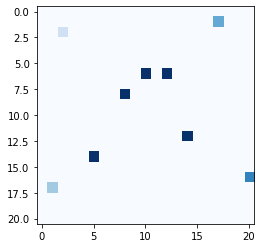

Act_State 1 : [0, 1, 0, 0] Action:  0 1002
Act_State 2 : [0, 1, 0, 0] Action:  2 1001
Act_State 3 : [0, 1, 0, 0] Action:  0 1000
Act_State 4 : [0, 1, 0, 0] Action:  1 1003


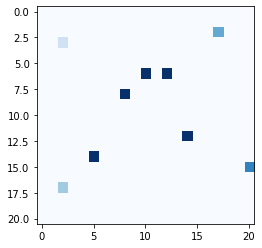

Act_State 1 : [0, 1, 0, 0] Action:  2 1002
Act_State 2 : [0, 1, 0, 0] Action:  1 1001
Act_State 3 : [0, 1, 0, 0] Action:  3 1000
Act_State 4 : [0, 1, 0, 0] Action:  3 1003


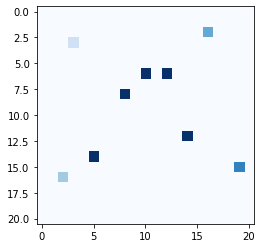

Act_State 1 : [0, 1, 0, 0] Action:  0 1002
Act_State 2 : [0, 1, 0, 0] Action:  2 1001
Act_State 3 : [0, 1, 0, 0] Action:  0 1000
Act_State 4 : [0, 1, 0, 0] Action:  1 1003


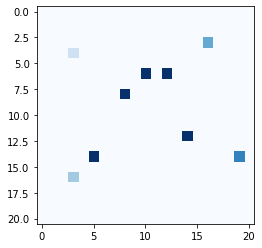

Act_State 1 : [0, 1, 0, 0] Action:  2 1002
Act_State 2 : [0, 1, 0, 0] Action:  1 1001
Act_State 3 : [0, 1, 0, 0] Action:  3 1000
Act_State 4 : [0, 1, 0, 0] Action:  3 1003


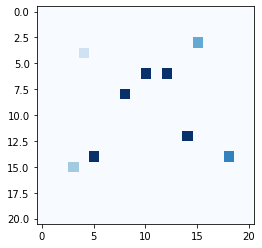

Act_State 1 : [0, 1, 0, 0] Action:  0 1002
Act_State 2 : [0, 1, 0, 0] Action:  2 1001
Act_State 3 : [0, 1, 0, 0] Action:  0 1000
Act_State 4 : [0, 1, 0, 0] Action:  1 1003


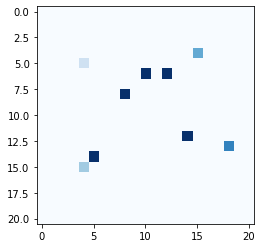

Act_State 1 : [0, 1, 0, 0] Action:  2 1002
Act_State 2 : [0, 1, 0, 0] Action:  1 1001
Act_State 3 : [0, 1, 0, 0] Action:  3 1000
Act_State 4 : [0, 1, 0, 0] Action:  3 1003


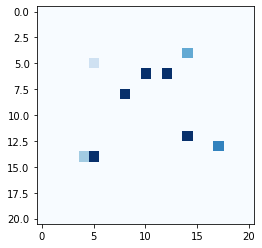

Act_State 1 : [0, 1, 0, 0] Action:  0 1002
Act_State 2 : [0, 1, 0, 0] Action:  2 1001
Act_State 3 : [0, 1, 0, 0] Action:  0 1000
Act_State 4 : [0, 1, 0, 0] Action:  1 1003


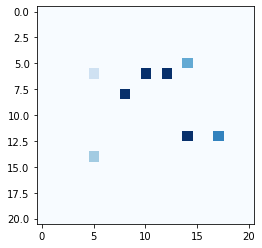

Act_State 1 : [0, 1, 0, 0] Action:  2 1002
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [0, 1, 0, 0] Action:  3 1000
Act_State 4 : [0, 1, 0, 0] Action:  3 1003


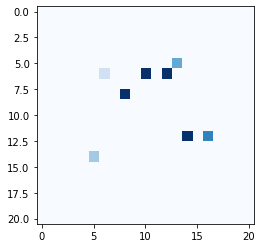

Act_State 1 : [0, 1, 0, 0] Action:  0 1002
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [0, 1, 0, 0] Action:  0 1000
Act_State 4 : [0, 1, 0, 0] Action:  1 1003


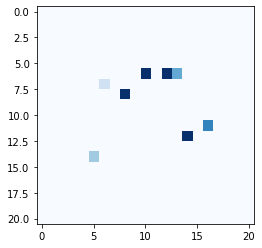

Act_State 1 : [0, 1, 0, 0] Action:  2 1002
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [0, 1, 0, 0] Action:  3 1000
Act_State 4 : [0, 1, 0, 0] Action:  3 1003


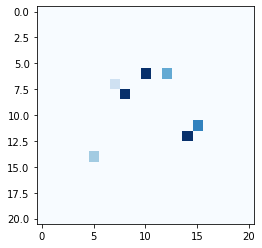

Act_State 1 : [0, 1, 0, 0] Action:  0 1002
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [0, 1, 0, 0] Action:  1 1003


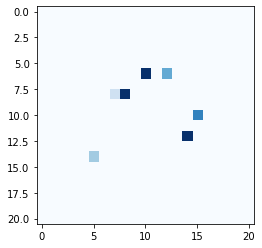

Act_State 1 : [0, 1, 0, 0] Action:  2 1002
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [0, 1, 0, 0] Action:  3 1003


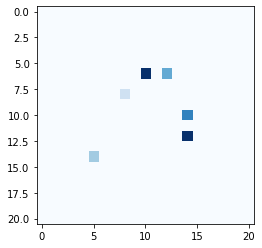

Act_State 1 : [1, 1, 0, 0] Action:  4 1002
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [0, 1, 0, 0] Action:  1 1003


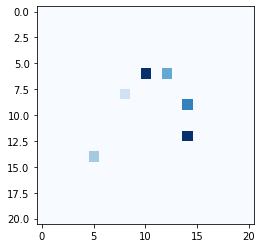

Act_State 1 : [1, 0, 0, 0] Action:  5 1002
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [0, 1, 0, 0] Action:  3 1003


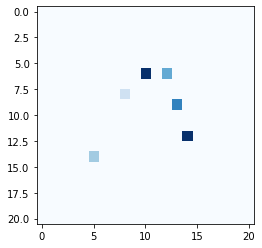

Act_State 1 : [1, 0, 0, 0] Action:  5 1002
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [0, 1, 0, 0] Action:  1 1003


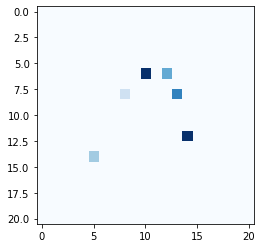

Act_State 1 : [1, 0, 0, 0] Action:  5 1002
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [0, 1, 0, 0] Action:  3 1003


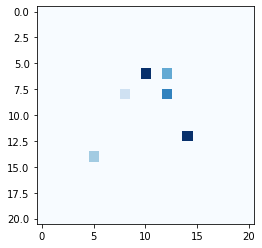

Act_State 1 : [1, 1, 0, 0] Action:  4 1002
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [0, 1, 0, 0] Action:  1 1003


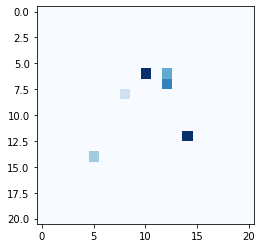

Act_State 1 : [1, 0, 0, 0] Action:  5 1002
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [0, 1, 0, 0] Action:  3 1003


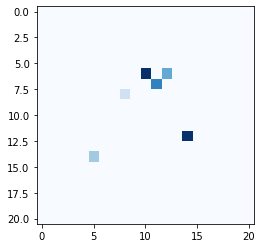

Act_State 1 : [1, 0, 0, 0] Action:  5 1002
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [0, 1, 0, 0] Action:  1 1003


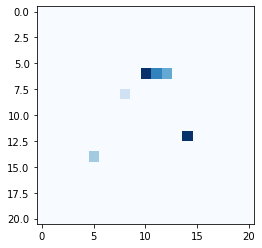

Act_State 1 : [1, 1, 0, 0] Action:  4 1002
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [0, 1, 0, 0] Action:  3 1003


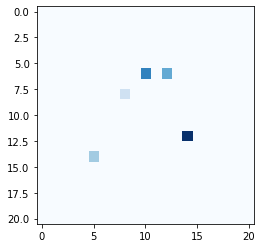

Act_State 1 : [1, 1, 0, 0] Action:  4 1002
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


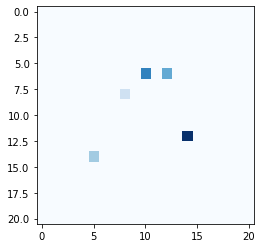

Act_State 1 : [1, 1, 0, 0] Action:  4 1002
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [1, 0, 0, 0] Action:  5 1003


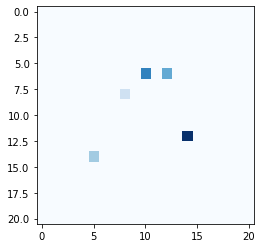

Act_State 1 : [1, 1, 0, 0] Action:  4 1002
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [1, 0, 0, 0] Action:  5 1003


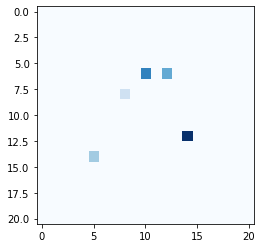

Act_State 1 : [1, 1, 0, 0] Action:  4 1002
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [1, 0, 0, 0] Action:  5 1003


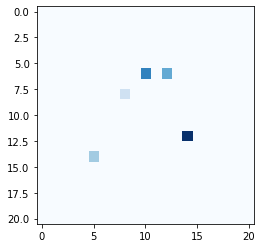

Act_State 1 : [1, 1, 0, 0] Action:  4 1002
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [1, 0, 0, 0] Action:  5 1003


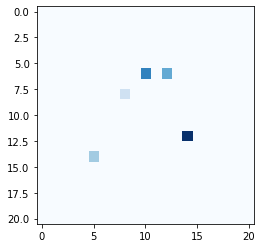

Act_State 1 : [1, 1, 0, 0] Action:  4 1002
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [1, 0, 0, 0] Action:  5 1003


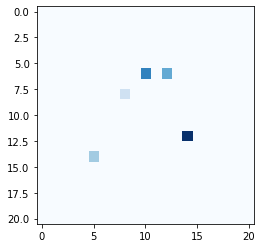

Act_State 1 : [1, 1, 0, 0] Action:  4 1002
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [1, 0, 0, 0] Action:  5 1003


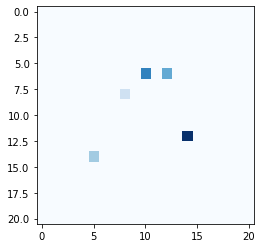

Act_State 1 : [1, 1, 0, 0] Action:  4 1002
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [1, 0, 0, 0] Action:  5 1003


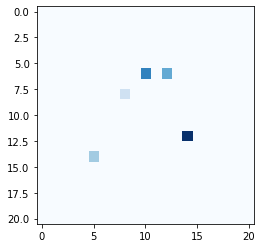

Act_State 1 : [1, 1, 0, 0] Action:  4 1002
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [1, 0, 0, 0] Action:  5 1003


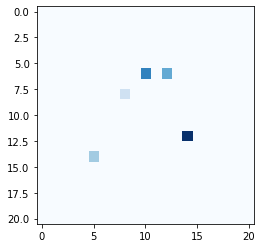

Act_State 1 : [1, 1, 0, 0] Action:  4 1002
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [1, 0, 0, 0] Action:  5 1003
Fire ID: 1001 goes POP


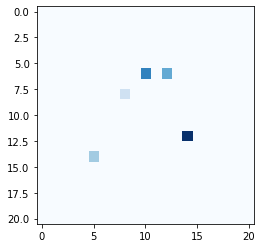

Act_State 1 : [1, 1, 0, 0] Action:  4 1002
Act_State 2 : [0, 1, 0, 0] Action:  1 1002
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [1, 0, 0, 0] Action:  5 1003


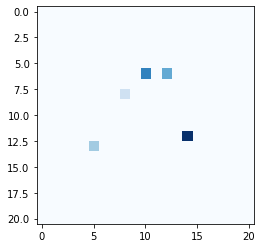

Act_State 1 : [1, 1, 0, 0] Action:  4 1002
Act_State 2 : [0, 1, 0, 0] Action:  1 1002
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [1, 0, 0, 0] Action:  5 1003


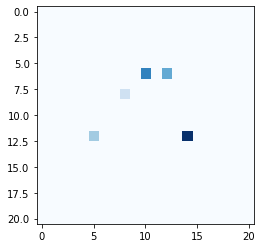

Act_State 1 : [1, 1, 0, 0] Action:  4 1002
Act_State 2 : [0, 1, 0, 0] Action:  1 1002
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [1, 0, 0, 0] Action:  5 1003
Fire ID: 1000 goes POP


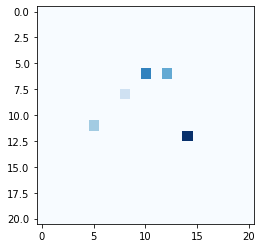

Act_State 1 : [1, 1, 0, 0] Action:  4 1002
Act_State 2 : [0, 1, 0, 0] Action:  1 1002
Act_State 3 : [0, 1, 0, 0] Action:  3 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


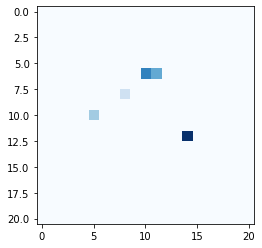

Act_State 1 : [1, 1, 0, 0] Action:  4 1002
Act_State 2 : [0, 1, 0, 0] Action:  2 1002
Act_State 3 : [0, 1, 0, 0] Action:  3 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


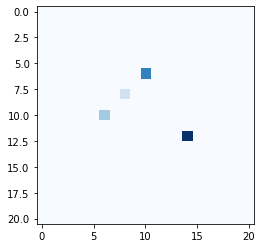

Act_State 1 : [1, 1, 0, 0] Action:  4 1002
Act_State 2 : [0, 1, 0, 0] Action:  1 1002
Act_State 3 : [1, 1, 0, 0] Action:  4 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


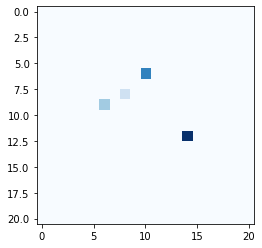

Act_State 1 : [1, 1, 0, 0] Action:  4 1002
Act_State 2 : [0, 1, 0, 0] Action:  2 1002
Act_State 3 : [1, 1, 0, 0] Action:  4 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


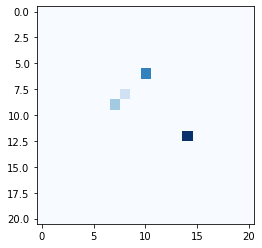

Act_State 1 : [1, 1, 0, 0] Action:  4 1002
Act_State 2 : [0, 1, 0, 0] Action:  1 1002
Act_State 3 : [1, 1, 0, 0] Action:  4 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


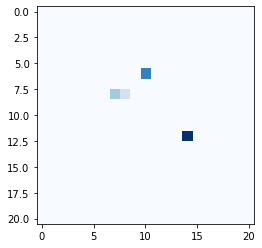

Act_State 1 : [1, 1, 0, 0] Action:  4 1002
Act_State 2 : [0, 1, 0, 0] Action:  2 1002
Act_State 3 : [1, 1, 0, 0] Action:  4 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


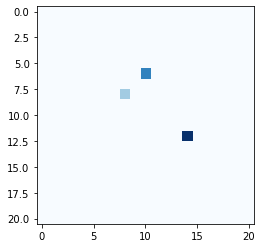

Act_State 1 : [1, 1, 0, 0] Action:  4 1002
Act_State 2 : [1, 1, 0, 0] Action:  4 1002
Act_State 3 : [1, 1, 0, 0] Action:  4 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


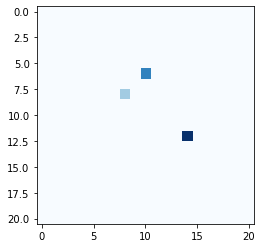

Act_State 1 : [1, 1, 0, 0] Action:  4 1002
Act_State 2 : [1, 1, 0, 0] Action:  4 1002
Act_State 3 : [1, 1, 0, 0] Action:  4 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1003
Fire ID: 1002 goes POP


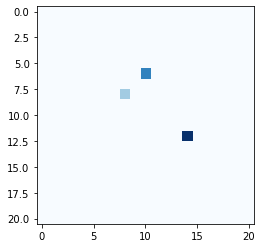

Act_State 1 : [0, 1, 0, 0] Action:  1 1003
Act_State 2 : [0, 1, 0, 0] Action:  1 1003
Act_State 3 : [1, 1, 0, 0] Action:  4 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


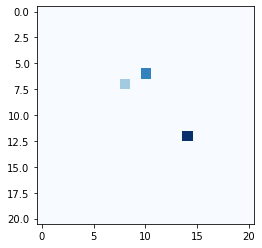

Act_State 1 : [0, 1, 0, 0] Action:  2 1003
Act_State 2 : [0, 1, 0, 0] Action:  2 1003
Act_State 3 : [1, 1, 0, 0] Action:  4 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


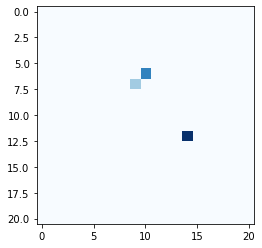

Act_State 1 : [0, 1, 0, 0] Action:  1 1003
Act_State 2 : [0, 1, 0, 0] Action:  1 1003
Act_State 3 : [1, 1, 0, 0] Action:  4 1003
Act_State 4 : [1, 1, 0, 0] Action:  4 1003
Fire ID: 1003 goes POP


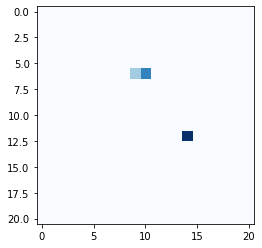

Act_State 1 : [0, 1, 0, 0] Action:  0 1004
Act_State 2 : [0, 1, 0, 0] Action:  0 1004
Act_State 3 : [0, 1, 0, 0] Action:  0 1004
Act_State 4 : [0, 1, 0, 0] Action:  0 1004


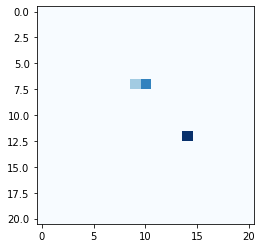

Act_State 1 : [0, 1, 0, 0] Action:  0 1004
Act_State 2 : [0, 1, 0, 0] Action:  0 1004
Act_State 3 : [0, 1, 0, 0] Action:  0 1004
Act_State 4 : [0, 1, 0, 0] Action:  0 1004


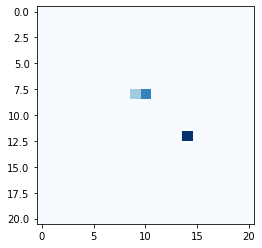

Act_State 1 : [0, 1, 0, 0] Action:  2 1004
Act_State 2 : [0, 1, 0, 0] Action:  2 1004
Act_State 3 : [0, 1, 0, 0] Action:  0 1004
Act_State 4 : [0, 1, 0, 0] Action:  0 1004


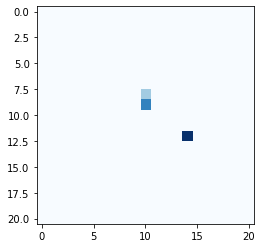

Act_State 1 : [0, 1, 0, 0] Action:  0 1004
Act_State 2 : [0, 1, 0, 0] Action:  0 1004
Act_State 3 : [0, 1, 0, 0] Action:  2 1004
Act_State 4 : [0, 1, 0, 0] Action:  2 1004


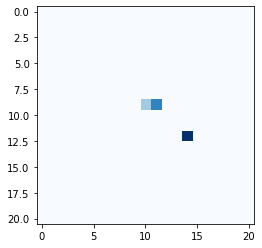

Act_State 1 : [0, 1, 0, 0] Action:  2 1004
Act_State 2 : [0, 1, 0, 0] Action:  2 1004
Act_State 3 : [0, 1, 0, 0] Action:  0 1004
Act_State 4 : [0, 1, 0, 0] Action:  0 1004


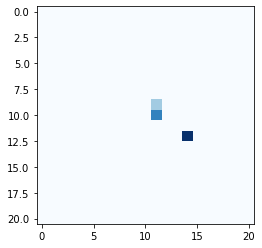

Act_State 1 : [0, 1, 0, 0] Action:  0 1004
Act_State 2 : [0, 1, 0, 0] Action:  0 1004
Act_State 3 : [0, 1, 0, 0] Action:  2 1004
Act_State 4 : [0, 1, 0, 0] Action:  2 1004


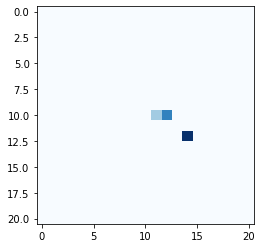

Act_State 1 : [0, 1, 0, 0] Action:  2 1004
Act_State 2 : [0, 1, 0, 0] Action:  2 1004
Act_State 3 : [0, 1, 0, 0] Action:  0 1004
Act_State 4 : [0, 1, 0, 0] Action:  0 1004


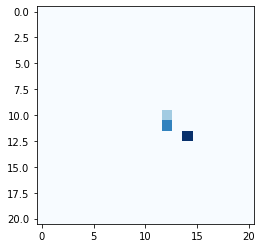

Act_State 1 : [0, 1, 0, 0] Action:  0 1004
Act_State 2 : [0, 1, 0, 0] Action:  0 1004
Act_State 3 : [0, 1, 0, 0] Action:  2 1004
Act_State 4 : [0, 1, 0, 0] Action:  2 1004


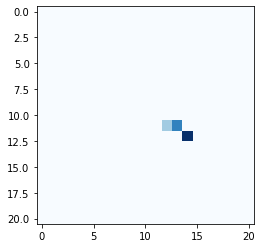

Act_State 1 : [0, 1, 0, 0] Action:  2 1004
Act_State 2 : [0, 1, 0, 0] Action:  2 1004
Act_State 3 : [0, 1, 0, 0] Action:  0 1004
Act_State 4 : [0, 1, 0, 0] Action:  0 1004


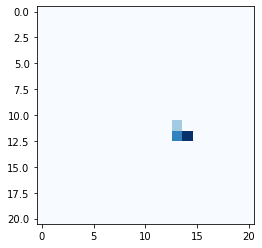

Act_State 1 : [0, 1, 0, 0] Action:  0 1004
Act_State 2 : [0, 1, 0, 0] Action:  0 1004
Act_State 3 : [0, 1, 0, 0] Action:  2 1004
Act_State 4 : [0, 1, 0, 0] Action:  2 1004


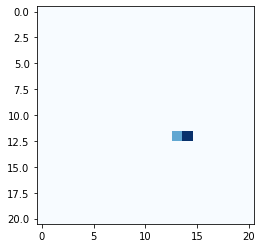

Act_State 1 : [0, 1, 0, 0] Action:  2 1004
Act_State 2 : [0, 1, 0, 0] Action:  2 1004
Act_State 3 : [1, 1, 0, 0] Action:  4 1004
Act_State 4 : [1, 1, 0, 0] Action:  4 1004


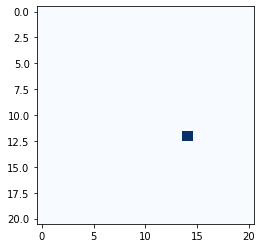

Act_State 1 : [1, 1, 0, 0] Action:  4 1004
Act_State 2 : [1, 1, 0, 0] Action:  4 1004
Act_State 3 : [1, 0, 0, 0] Action:  5 1004
Act_State 4 : [1, 0, 0, 0] Action:  5 1004


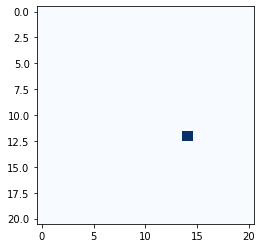

Act_State 1 : [1, 0, 0, 0] Action:  5 1004
Act_State 2 : [1, 0, 0, 0] Action:  5 1004
Act_State 3 : [1, 0, 0, 0] Action:  5 1004
Act_State 4 : [1, 0, 0, 0] Action:  5 1004


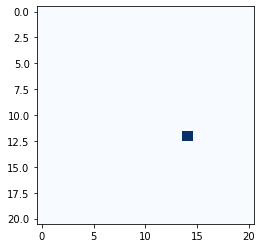

Act_State 1 : [1, 0, 0, 0] Action:  5 1004
Act_State 2 : [1, 0, 0, 0] Action:  5 1004
Act_State 3 : [1, 0, 0, 0] Action:  5 1004
Act_State 4 : [1, 0, 0, 0] Action:  5 1004


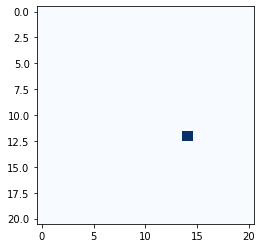

Act_State 1 : [1, 0, 0, 0] Action:  5 1004
Act_State 2 : [1, 0, 0, 0] Action:  5 1004
Act_State 3 : [1, 0, 0, 0] Action:  5 1004
Act_State 4 : [1, 0, 0, 0] Action:  5 1004


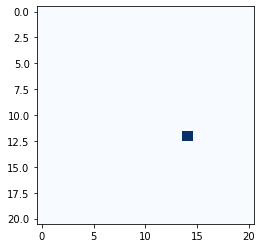

Act_State 1 : [1, 0, 0, 0] Action:  5 1004
Act_State 2 : [1, 0, 0, 0] Action:  5 1004
Act_State 3 : [1, 0, 0, 0] Action:  5 1004
Act_State 4 : [1, 0, 0, 0] Action:  5 1004


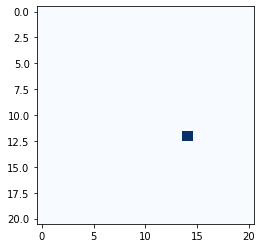

Act_State 1 : [1, 0, 0, 0] Action:  5 1004
Act_State 2 : [1, 0, 0, 0] Action:  5 1004
Act_State 3 : [1, 0, 0, 0] Action:  5 1004
Act_State 4 : [1, 0, 0, 0] Action:  5 1004


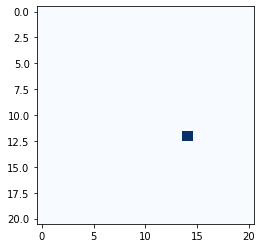

Act_State 1 : [1, 0, 0, 0] Action:  5 1004
Act_State 2 : [1, 0, 0, 0] Action:  5 1004
Act_State 3 : [1, 1, 0, 0] Action:  4 1004
Act_State 4 : [1, 1, 0, 0] Action:  4 1004


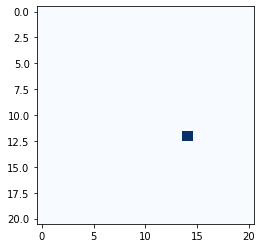

Act_State 1 : [1, 1, 0, 0] Action:  4 1004
Act_State 2 : [1, 1, 0, 0] Action:  4 1004
Act_State 3 : [1, 1, 0, 0] Action:  4 1004
Act_State 4 : [1, 1, 0, 0] Action:  4 1004


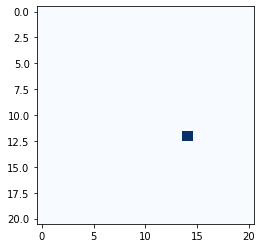

Act_State 1 : [1, 1, 0, 0] Action:  4 1004
Act_State 2 : [1, 1, 0, 0] Action:  4 1004
Act_State 3 : [1, 1, 0, 0] Action:  4 1004
Act_State 4 : [1, 1, 0, 0] Action:  4 1004


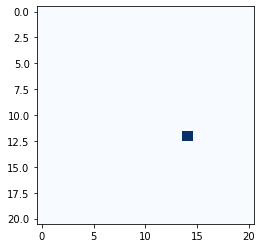

Act_State 1 : [1, 1, 0, 0] Action:  4 1004
Act_State 2 : [1, 1, 0, 0] Action:  4 1004
Act_State 3 : [1, 1, 0, 0] Action:  4 1004
Act_State 4 : [1, 1, 0, 0] Action:  4 1004


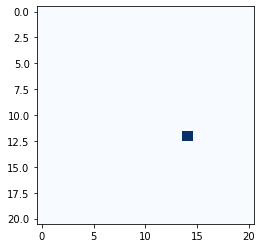

Act_State 1 : [1, 1, 0, 0] Action:  4 1004
Act_State 2 : [1, 1, 0, 0] Action:  4 1004
Act_State 3 : [1, 1, 0, 0] Action:  4 1004
Act_State 4 : [1, 1, 0, 0] Action:  4 1004
Fire ID: 1004 goes POP


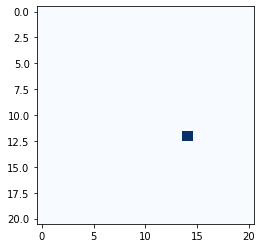

Score: 81.5 Heat:  []
Episode: 8 

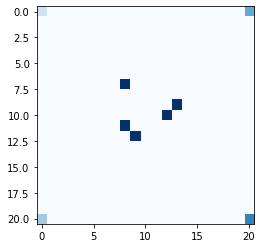

Act_State 1 : [0, 1, 0, 0] Action:  2 1003
Act_State 2 : [0, 1, 0, 0] Action:  1 1001
Act_State 3 : [0, 1, 0, 0] Action:  0 1000
Act_State 4 : [0, 1, 0, 0] Action:  3 1002


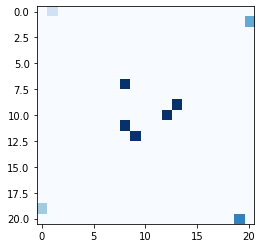

Act_State 1 : [0, 1, 0, 0] Action:  0 1003
Act_State 2 : [0, 1, 0, 0] Action:  1 1001
Act_State 3 : [0, 1, 0, 0] Action:  0 1000
Act_State 4 : [0, 1, 0, 0] Action:  3 1002


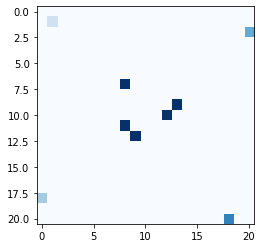

Act_State 1 : [0, 1, 0, 0] Action:  2 1003
Act_State 2 : [0, 1, 0, 0] Action:  2 1001
Act_State 3 : [0, 1, 0, 0] Action:  0 1000
Act_State 4 : [0, 1, 0, 0] Action:  3 1002


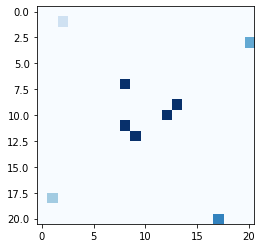

Act_State 1 : [0, 1, 0, 0] Action:  0 1003
Act_State 2 : [0, 1, 0, 0] Action:  1 1001
Act_State 3 : [0, 1, 0, 0] Action:  3 1000
Act_State 4 : [0, 1, 0, 0] Action:  1 1002


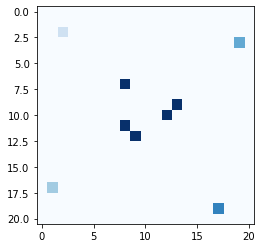

Act_State 1 : [0, 1, 0, 0] Action:  2 1003
Act_State 2 : [0, 1, 0, 0] Action:  2 1001
Act_State 3 : [0, 1, 0, 0] Action:  0 1000
Act_State 4 : [0, 1, 0, 0] Action:  3 1002


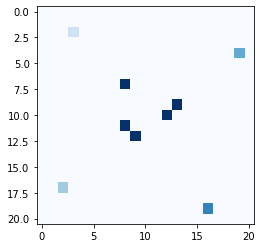

Act_State 1 : [0, 1, 0, 0] Action:  0 1003
Act_State 2 : [0, 1, 0, 0] Action:  1 1001
Act_State 3 : [0, 1, 0, 0] Action:  3 1000
Act_State 4 : [0, 1, 0, 0] Action:  1 1002


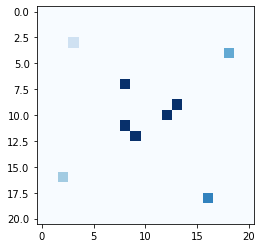

Act_State 1 : [0, 1, 0, 0] Action:  2 1003
Act_State 2 : [0, 1, 0, 0] Action:  2 1001
Act_State 3 : [0, 1, 0, 0] Action:  0 1000
Act_State 4 : [0, 1, 0, 0] Action:  3 1002


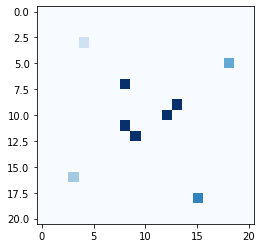

Act_State 1 : [0, 1, 0, 0] Action:  0 1003
Act_State 2 : [0, 1, 0, 0] Action:  1 1001
Act_State 3 : [0, 1, 0, 0] Action:  3 1000
Act_State 4 : [0, 1, 0, 0] Action:  1 1002


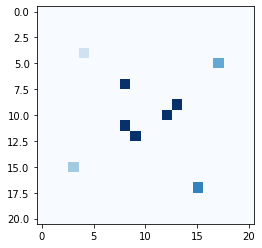

Act_State 1 : [0, 1, 0, 0] Action:  2 1003
Act_State 2 : [0, 1, 0, 0] Action:  2 1001
Act_State 3 : [0, 1, 0, 0] Action:  0 1000
Act_State 4 : [0, 1, 0, 0] Action:  3 1002


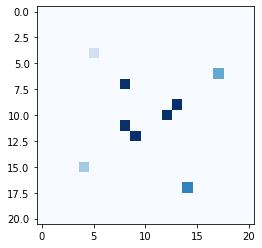

Act_State 1 : [0, 1, 0, 0] Action:  0 1003
Act_State 2 : [0, 1, 0, 0] Action:  1 1001
Act_State 3 : [0, 1, 0, 0] Action:  3 1000
Act_State 4 : [0, 1, 0, 0] Action:  1 1002


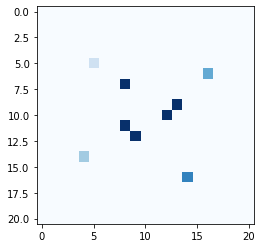

Act_State 1 : [0, 1, 0, 0] Action:  2 1003
Act_State 2 : [0, 1, 0, 0] Action:  2 1001
Act_State 3 : [0, 1, 0, 0] Action:  0 1000
Act_State 4 : [0, 1, 0, 0] Action:  3 1002


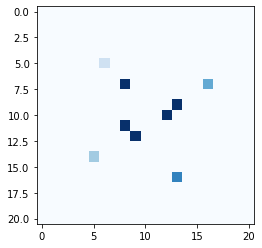

Act_State 1 : [0, 1, 0, 0] Action:  0 1003
Act_State 2 : [0, 1, 0, 0] Action:  1 1001
Act_State 3 : [0, 1, 0, 0] Action:  3 1000
Act_State 4 : [0, 1, 0, 0] Action:  1 1002


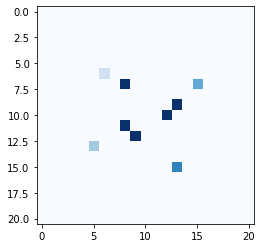

Act_State 1 : [0, 1, 0, 0] Action:  2 1003
Act_State 2 : [0, 1, 0, 0] Action:  2 1001
Act_State 3 : [0, 1, 0, 0] Action:  0 1000
Act_State 4 : [0, 1, 0, 0] Action:  3 1002


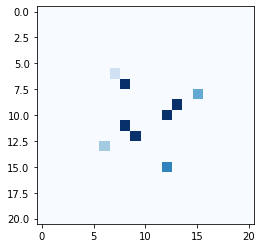

Act_State 1 : [0, 1, 0, 0] Action:  0 1003
Act_State 2 : [0, 1, 0, 0] Action:  1 1001
Act_State 3 : [0, 1, 0, 0] Action:  3 1000
Act_State 4 : [0, 1, 0, 0] Action:  1 1002


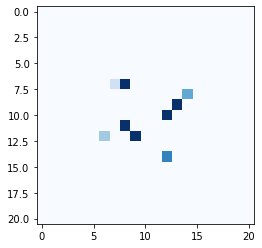

Act_State 1 : [0, 1, 0, 0] Action:  2 1003
Act_State 2 : [0, 1, 0, 0] Action:  2 1001
Act_State 3 : [0, 1, 0, 0] Action:  0 1000
Act_State 4 : [0, 1, 0, 0] Action:  3 1002


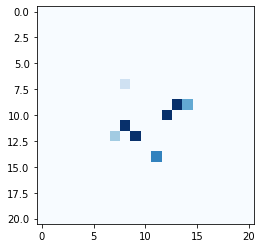

Act_State 1 : [1, 1, 0, 0] Action:  4 1003
Act_State 2 : [0, 1, 0, 0] Action:  1 1001
Act_State 3 : [0, 1, 0, 0] Action:  3 1000
Act_State 4 : [0, 1, 0, 0] Action:  1 1002


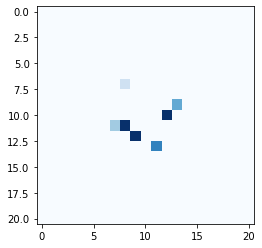

Act_State 1 : [1, 0, 0, 0] Action:  5 1003
Act_State 2 : [0, 1, 0, 0] Action:  2 1001
Act_State 3 : [0, 1, 0, 0] Action:  0 1000
Act_State 4 : [0, 1, 0, 0] Action:  3 1002


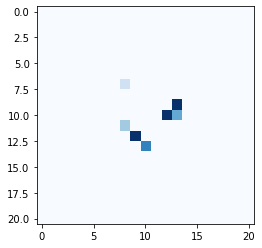

Act_State 1 : [1, 0, 0, 0] Action:  5 1003
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [0, 1, 0, 0] Action:  3 1000
Act_State 4 : [0, 1, 0, 0] Action:  1 1002


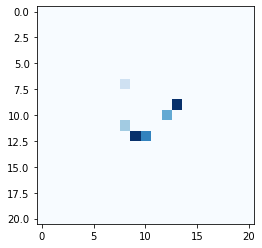

Act_State 1 : [1, 0, 0, 0] Action:  5 1003
Act_State 2 : [1, 0, 0, 0] Action:  5 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [0, 1, 0, 0] Action:  3 1002


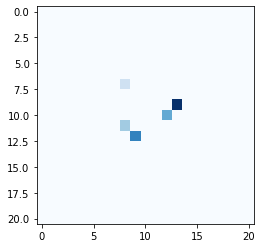

Act_State 1 : [1, 0, 0, 0] Action:  5 1003
Act_State 2 : [1, 0, 0, 0] Action:  5 1001
Act_State 3 : [1, 0, 0, 0] Action:  5 1000
Act_State 4 : [1, 1, 0, 0] Action:  4 1002


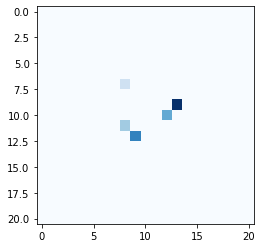

Act_State 1 : [1, 1, 0, 0] Action:  4 1003
Act_State 2 : [1, 0, 0, 0] Action:  5 1001
Act_State 3 : [1, 0, 0, 0] Action:  5 1000
Act_State 4 : [1, 0, 0, 0] Action:  5 1002


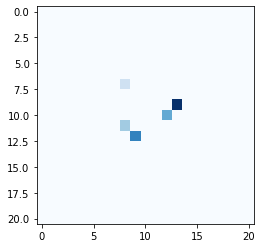

Act_State 1 : [1, 0, 0, 0] Action:  5 1003
Act_State 2 : [1, 0, 0, 0] Action:  5 1001
Act_State 3 : [1, 0, 0, 0] Action:  5 1000
Act_State 4 : [1, 0, 0, 0] Action:  5 1002


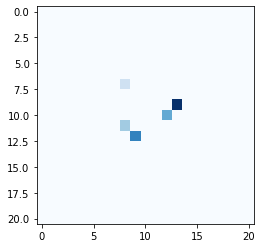

Act_State 1 : [1, 0, 0, 0] Action:  5 1003
Act_State 2 : [1, 0, 0, 0] Action:  5 1001
Act_State 3 : [1, 0, 0, 0] Action:  5 1000
Act_State 4 : [1, 0, 0, 0] Action:  5 1002


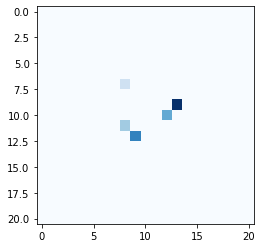

Act_State 1 : [1, 1, 0, 0] Action:  4 1003
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 0, 0, 0] Action:  5 1000
Act_State 4 : [1, 0, 0, 0] Action:  5 1002


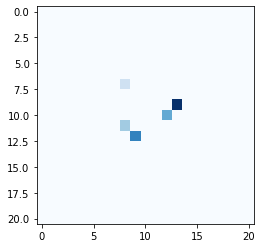

Act_State 1 : [1, 0, 0, 0] Action:  5 1003
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [1, 1, 0, 0] Action:  4 1002


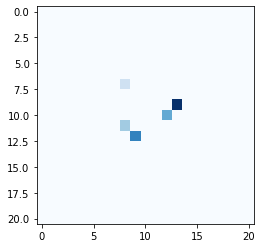

Act_State 1 : [1, 0, 0, 0] Action:  5 1003
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [1, 1, 0, 0] Action:  4 1002


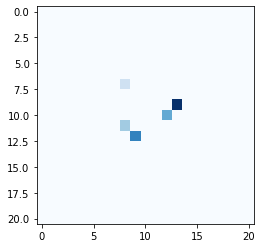

Act_State 1 : [1, 0, 0, 0] Action:  5 1003
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [1, 1, 0, 0] Action:  4 1002


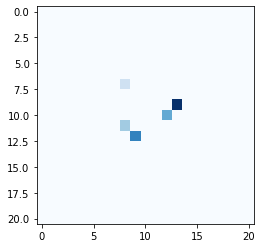

Act_State 1 : [1, 1, 0, 0] Action:  4 1003
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [1, 1, 0, 0] Action:  4 1002


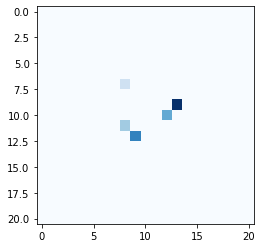

Act_State 1 : [1, 1, 0, 0] Action:  4 1003
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [1, 1, 0, 0] Action:  4 1002


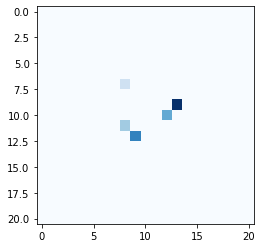

Act_State 1 : [1, 1, 0, 0] Action:  4 1003
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [1, 1, 0, 0] Action:  4 1002


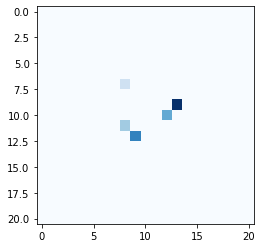

Act_State 1 : [1, 1, 0, 0] Action:  4 1003
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [1, 1, 0, 0] Action:  4 1002


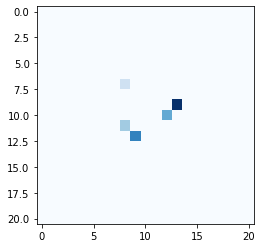

Act_State 1 : [1, 1, 0, 0] Action:  4 1003
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [1, 1, 0, 0] Action:  4 1002


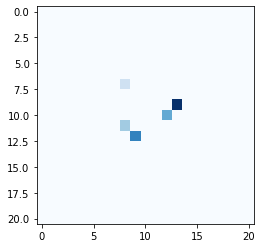

Act_State 1 : [1, 1, 0, 0] Action:  4 1003
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [1, 1, 0, 0] Action:  4 1002


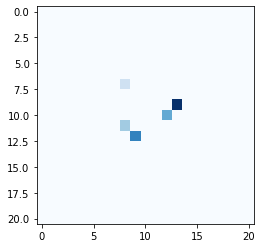

Act_State 1 : [1, 1, 0, 0] Action:  4 1003
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [1, 1, 0, 0] Action:  4 1002


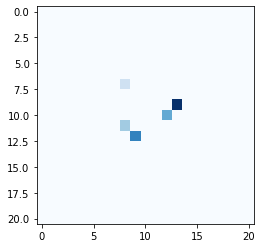

Act_State 1 : [1, 1, 0, 0] Action:  4 1003
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [1, 1, 0, 0] Action:  4 1002


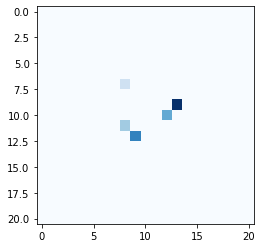

Act_State 1 : [1, 1, 0, 0] Action:  4 1003
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [1, 1, 0, 0] Action:  4 1002


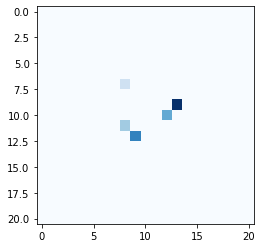

Act_State 1 : [1, 1, 0, 0] Action:  4 1003
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [1, 1, 0, 0] Action:  4 1002


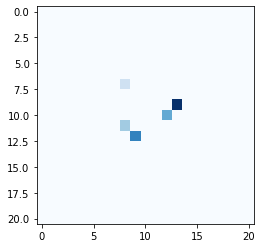

Act_State 1 : [1, 1, 0, 0] Action:  4 1003
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [1, 1, 0, 0] Action:  4 1002


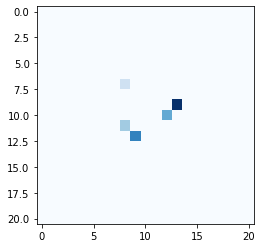

Act_State 1 : [1, 1, 0, 0] Action:  4 1003
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [1, 1, 0, 0] Action:  4 1002


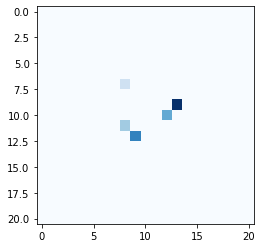

Act_State 1 : [1, 1, 0, 0] Action:  4 1003
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [1, 1, 0, 0] Action:  4 1002


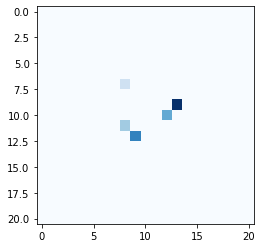

Act_State 1 : [1, 1, 0, 0] Action:  4 1003
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [1, 1, 0, 0] Action:  4 1002


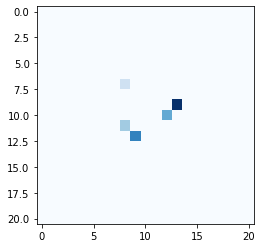

Act_State 1 : [1, 1, 0, 0] Action:  4 1003
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [1, 1, 0, 0] Action:  4 1002


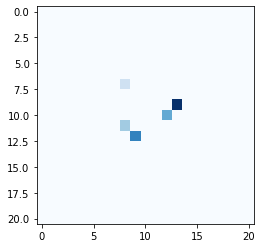

Act_State 1 : [1, 1, 0, 0] Action:  4 1003
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [1, 1, 0, 0] Action:  4 1002


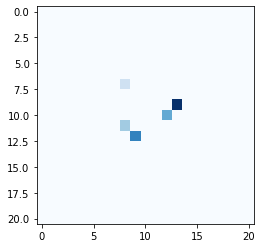

Act_State 1 : [1, 1, 0, 0] Action:  4 1003
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [1, 1, 0, 0] Action:  4 1002


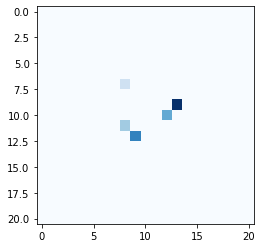

Act_State 1 : [1, 1, 0, 0] Action:  4 1003
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [1, 1, 0, 0] Action:  4 1002


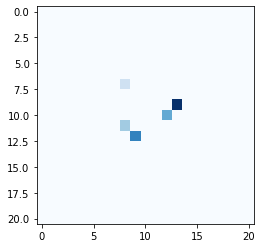

Act_State 1 : [1, 1, 0, 0] Action:  4 1003
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [1, 1, 0, 0] Action:  4 1002
Fire ID: 1001 goes POP
Fire ID: 1002 goes POP


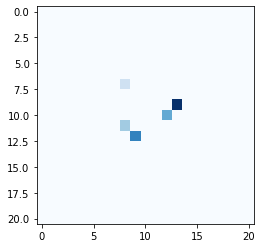

Act_State 1 : [1, 1, 0, 0] Action:  4 1003
Act_State 2 : [0, 1, 0, 0] Action:  1 1003
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [0, 1, 0, 0] Action:  1 1001
Fire ID: 1000 goes POP


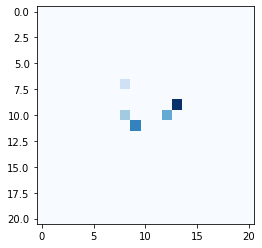

Act_State 1 : [1, 1, 0, 0] Action:  4 1003
Act_State 2 : [0, 1, 0, 0] Action:  1 1003
Act_State 3 : [0, 1, 0, 0] Action:  1 1000
Act_State 4 : [0, 1, 0, 0] Action:  1 1003


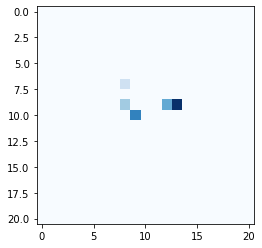

Act_State 1 : [1, 1, 0, 0] Action:  4 1003
Act_State 2 : [0, 1, 0, 0] Action:  1 1003
Act_State 3 : [0, 1, 0, 0] Action:  2 1004
Act_State 4 : [0, 1, 0, 0] Action:  1 1003


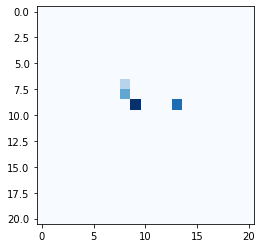

Act_State 1 : [1, 1, 0, 0] Action:  4 1003
Act_State 2 : [0, 1, 0, 0] Action:  1 1003
Act_State 3 : [1, 1, 0, 0] Action:  4 1004
Act_State 4 : [0, 1, 0, 0] Action:  1 1003
Fire ID: 1003 goes POP


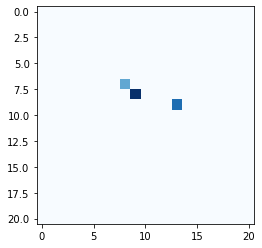

Act_State 1 : [0, 1, 0, 0] Action:  2 1004
Act_State 2 : [0, 1, 0, 0] Action:  2 1004
Act_State 3 : [1, 0, 0, 0] Action:  5 1004
Act_State 4 : [0, 1, 0, 0] Action:  2 1004


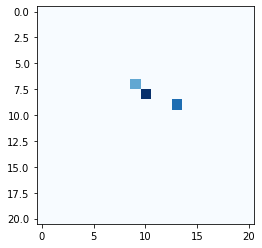

Act_State 1 : [0, 1, 0, 0] Action:  2 1004
Act_State 2 : [0, 1, 0, 0] Action:  2 1004
Act_State 3 : [1, 0, 0, 0] Action:  5 1004
Act_State 4 : [0, 1, 0, 0] Action:  2 1004


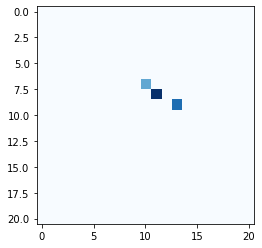

Act_State 1 : [0, 1, 0, 0] Action:  2 1004
Act_State 2 : [0, 1, 0, 0] Action:  2 1004
Act_State 3 : [1, 0, 0, 0] Action:  5 1004
Act_State 4 : [0, 1, 0, 0] Action:  2 1004


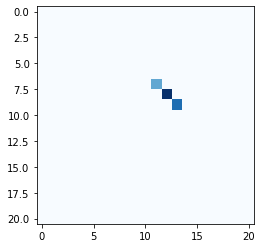

Act_State 1 : [0, 1, 0, 0] Action:  0 1004
Act_State 2 : [0, 1, 0, 0] Action:  0 1004
Act_State 3 : [1, 0, 0, 0] Action:  5 1004
Act_State 4 : [0, 1, 0, 0] Action:  0 1004


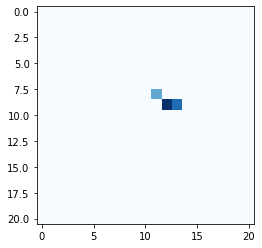

Act_State 1 : [0, 1, 0, 0] Action:  2 1004
Act_State 2 : [0, 1, 0, 0] Action:  2 1004
Act_State 3 : [1, 0, 0, 0] Action:  5 1004
Act_State 4 : [0, 1, 0, 0] Action:  2 1004


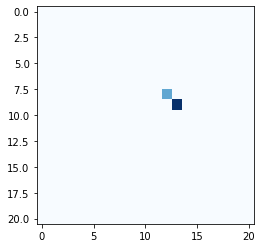

Act_State 1 : [0, 1, 0, 0] Action:  0 1004
Act_State 2 : [0, 1, 0, 0] Action:  0 1004
Act_State 3 : [1, 0, 0, 0] Action:  5 1004
Act_State 4 : [1, 1, 0, 0] Action:  4 1004


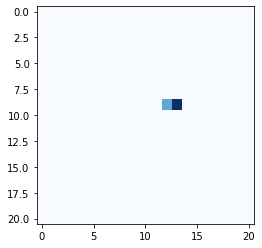

Act_State 1 : [0, 1, 0, 0] Action:  2 1004
Act_State 2 : [0, 1, 0, 0] Action:  2 1004
Act_State 3 : [1, 0, 0, 0] Action:  5 1004
Act_State 4 : [1, 0, 0, 0] Action:  5 1004


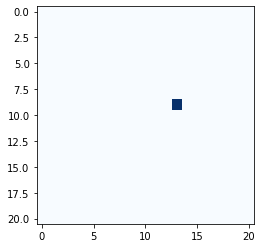

Act_State 1 : [1, 1, 0, 0] Action:  4 1004
Act_State 2 : [1, 1, 0, 0] Action:  4 1004
Act_State 3 : [1, 0, 0, 0] Action:  5 1004
Act_State 4 : [1, 0, 0, 0] Action:  5 1004


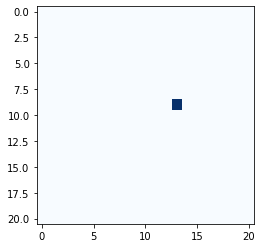

Act_State 1 : [1, 0, 0, 0] Action:  5 1004
Act_State 2 : [1, 0, 0, 0] Action:  5 1004
Act_State 3 : [1, 0, 0, 0] Action:  5 1004
Act_State 4 : [1, 0, 0, 0] Action:  5 1004


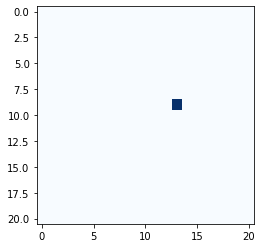

Act_State 1 : [1, 0, 0, 0] Action:  5 1004
Act_State 2 : [1, 0, 0, 0] Action:  5 1004
Act_State 3 : [1, 0, 0, 0] Action:  5 1004
Act_State 4 : [1, 0, 0, 0] Action:  5 1004


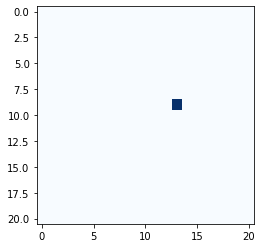

Act_State 1 : [1, 0, 0, 0] Action:  5 1004
Act_State 2 : [1, 0, 0, 0] Action:  5 1004
Act_State 3 : [1, 0, 0, 0] Action:  5 1004
Act_State 4 : [1, 1, 0, 0] Action:  4 1004


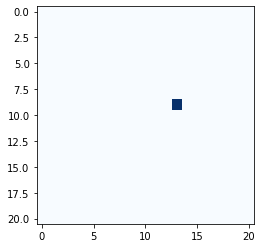

Act_State 1 : [1, 0, 0, 0] Action:  5 1004
Act_State 2 : [1, 1, 0, 0] Action:  4 1004
Act_State 3 : [1, 1, 0, 0] Action:  4 1004
Act_State 4 : [1, 1, 0, 0] Action:  4 1004


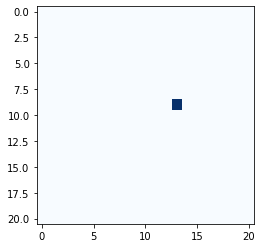

Act_State 1 : [1, 1, 0, 0] Action:  4 1004
Act_State 2 : [1, 1, 0, 0] Action:  4 1004
Act_State 3 : [1, 1, 0, 0] Action:  4 1004
Act_State 4 : [1, 1, 0, 0] Action:  4 1004


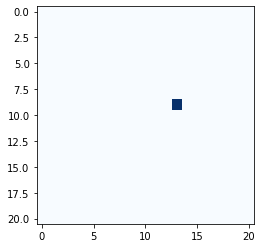

Act_State 1 : [1, 1, 0, 0] Action:  4 1004
Act_State 2 : [1, 1, 0, 0] Action:  4 1004
Act_State 3 : [1, 1, 0, 0] Action:  4 1004
Act_State 4 : [1, 1, 0, 0] Action:  4 1004


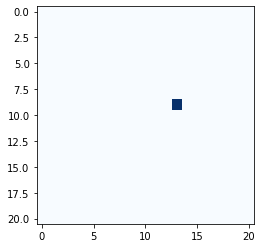

Act_State 1 : [1, 1, 0, 0] Action:  4 1004
Act_State 2 : [1, 1, 0, 0] Action:  4 1004
Act_State 3 : [1, 1, 0, 0] Action:  4 1004
Act_State 4 : [1, 1, 0, 0] Action:  4 1004
Fire ID: 1004 goes POP


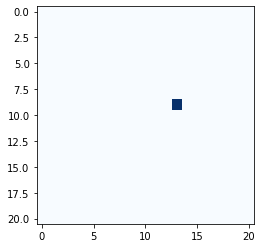

Score: 90.5 Heat:  []
Episode: 9 

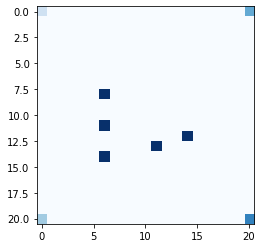

Act_State 1 : [0, 1, 0, 0] Action:  0 1001
Act_State 2 : [0, 1, 0, 0] Action:  1 1003
Act_State 3 : [0, 1, 0, 0] Action:  0 1002
Act_State 4 : [0, 1, 0, 0] Action:  3 1000


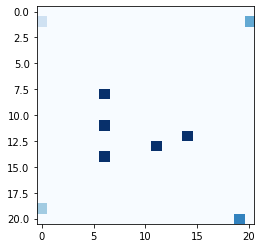

Act_State 1 : [0, 1, 0, 0] Action:  0 1001
Act_State 2 : [0, 1, 0, 0] Action:  2 1003
Act_State 3 : [0, 1, 0, 0] Action:  0 1002
Act_State 4 : [0, 1, 0, 0] Action:  3 1000


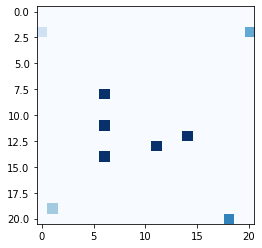

Act_State 1 : [0, 1, 0, 0] Action:  0 1001
Act_State 2 : [0, 1, 0, 0] Action:  1 1003
Act_State 3 : [0, 1, 0, 0] Action:  0 1002
Act_State 4 : [0, 1, 0, 0] Action:  1 1000


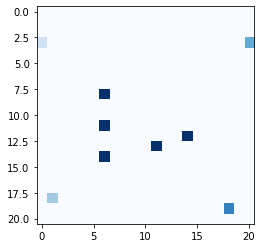

Act_State 1 : [0, 1, 0, 0] Action:  2 1001
Act_State 2 : [0, 1, 0, 0] Action:  2 1003
Act_State 3 : [0, 1, 0, 0] Action:  0 1002
Act_State 4 : [0, 1, 0, 0] Action:  3 1000


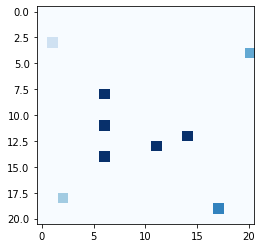

Act_State 1 : [0, 1, 0, 0] Action:  0 1001
Act_State 2 : [0, 1, 0, 0] Action:  1 1003
Act_State 3 : [0, 1, 0, 0] Action:  0 1002
Act_State 4 : [0, 1, 0, 0] Action:  1 1000


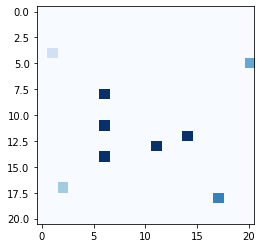

Act_State 1 : [0, 1, 0, 0] Action:  2 1001
Act_State 2 : [0, 1, 0, 0] Action:  2 1003
Act_State 3 : [0, 1, 0, 0] Action:  0 1002
Act_State 4 : [0, 1, 0, 0] Action:  3 1000


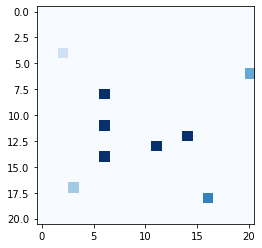

Act_State 1 : [0, 1, 0, 0] Action:  0 1001
Act_State 2 : [0, 1, 0, 0] Action:  1 1003
Act_State 3 : [0, 1, 0, 0] Action:  0 1002
Act_State 4 : [0, 1, 0, 0] Action:  1 1000


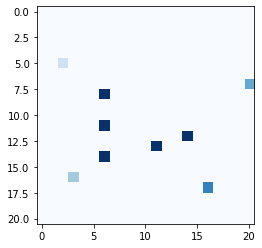

Act_State 1 : [0, 1, 0, 0] Action:  2 1001
Act_State 2 : [0, 1, 0, 0] Action:  2 1003
Act_State 3 : [0, 1, 0, 0] Action:  3 1002
Act_State 4 : [0, 1, 0, 0] Action:  3 1000


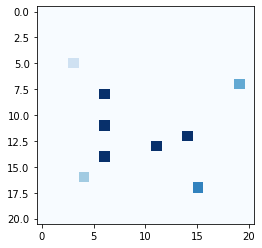

Act_State 1 : [0, 1, 0, 0] Action:  0 1001
Act_State 2 : [0, 1, 0, 0] Action:  1 1003
Act_State 3 : [0, 1, 0, 0] Action:  0 1002
Act_State 4 : [0, 1, 0, 0] Action:  1 1000


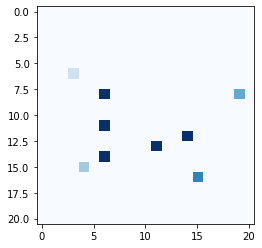

Act_State 1 : [0, 1, 0, 0] Action:  2 1001
Act_State 2 : [0, 1, 0, 0] Action:  2 1003
Act_State 3 : [0, 1, 0, 0] Action:  3 1002
Act_State 4 : [0, 1, 0, 0] Action:  3 1000


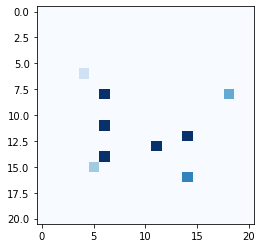

Act_State 1 : [0, 1, 0, 0] Action:  0 1001
Act_State 2 : [0, 1, 0, 0] Action:  1 1003
Act_State 3 : [0, 1, 0, 0] Action:  0 1002
Act_State 4 : [0, 1, 0, 0] Action:  1 1000


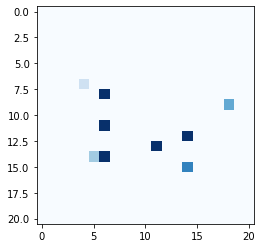

Act_State 1 : [0, 1, 0, 0] Action:  2 1001
Act_State 2 : [0, 1, 0, 0] Action:  2 1003
Act_State 3 : [0, 1, 0, 0] Action:  3 1002
Act_State 4 : [0, 1, 0, 0] Action:  3 1000


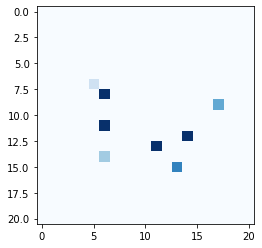

Act_State 1 : [0, 1, 0, 0] Action:  0 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1003
Act_State 3 : [0, 1, 0, 0] Action:  0 1002
Act_State 4 : [0, 1, 0, 0] Action:  1 1000


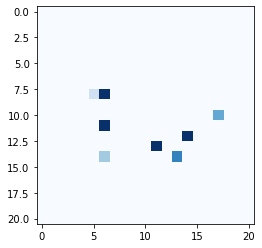

Act_State 1 : [0, 1, 0, 0] Action:  2 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1003
Act_State 3 : [0, 1, 0, 0] Action:  3 1002
Act_State 4 : [0, 1, 0, 0] Action:  3 1000


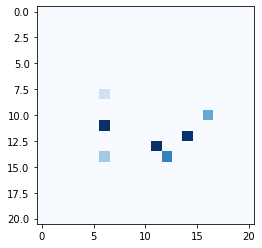

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1003
Act_State 3 : [0, 1, 0, 0] Action:  0 1002
Act_State 4 : [0, 1, 0, 0] Action:  1 1000


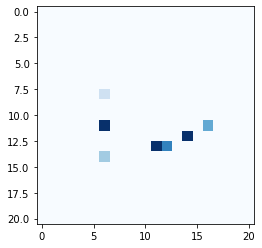

Act_State 1 : [1, 0, 0, 0] Action:  5 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1003
Act_State 3 : [0, 1, 0, 0] Action:  3 1002
Act_State 4 : [0, 1, 0, 0] Action:  3 1000


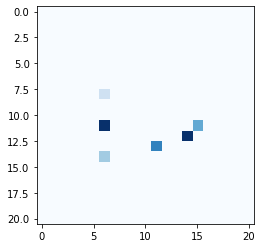

Act_State 1 : [1, 0, 0, 0] Action:  5 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1003
Act_State 3 : [0, 1, 0, 0] Action:  0 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1000


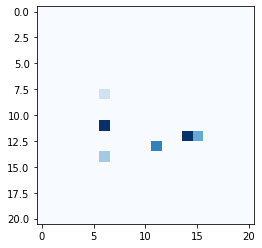

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1003
Act_State 3 : [0, 1, 0, 0] Action:  3 1002
Act_State 4 : [1, 0, 0, 0] Action:  5 1000


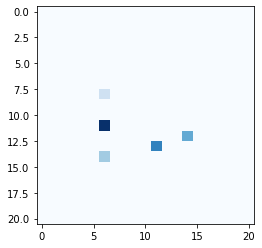

Act_State 1 : [1, 0, 0, 0] Action:  5 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1003
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [1, 0, 0, 0] Action:  5 1000


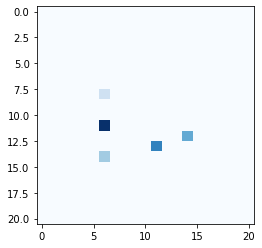

Act_State 1 : [1, 0, 0, 0] Action:  5 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1003
Act_State 3 : [1, 0, 0, 0] Action:  5 1002
Act_State 4 : [1, 0, 0, 0] Action:  5 1000


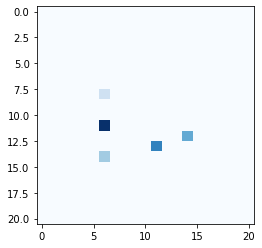

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1003
Act_State 3 : [1, 0, 0, 0] Action:  5 1002
Act_State 4 : [1, 0, 0, 0] Action:  5 1000


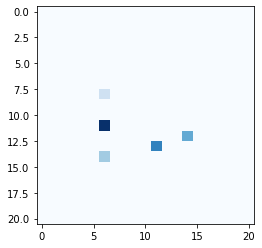

Act_State 1 : [1, 0, 0, 0] Action:  5 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1003
Act_State 3 : [1, 0, 0, 0] Action:  5 1002
Act_State 4 : [1, 0, 0, 0] Action:  5 1000


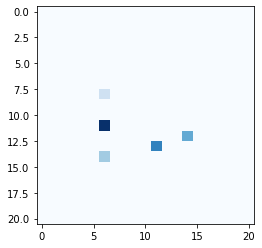

Act_State 1 : [1, 0, 0, 0] Action:  5 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1003
Act_State 3 : [1, 0, 0, 0] Action:  5 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1000


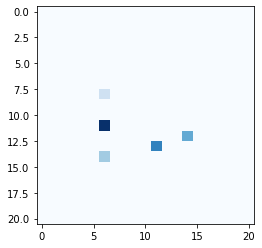

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1003
Act_State 3 : [1, 0, 0, 0] Action:  5 1002
Act_State 4 : [1, 0, 0, 0] Action:  5 1000


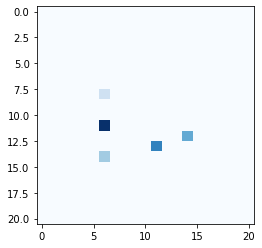

Act_State 1 : [1, 0, 0, 0] Action:  5 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1003
Act_State 3 : [1, 0, 0, 0] Action:  5 1002
Act_State 4 : [1, 0, 0, 0] Action:  5 1000


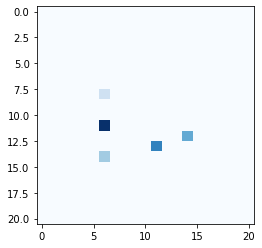

Act_State 1 : [1, 0, 0, 0] Action:  5 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1003
Act_State 3 : [1, 0, 0, 0] Action:  5 1002
Act_State 4 : [1, 0, 0, 0] Action:  5 1000


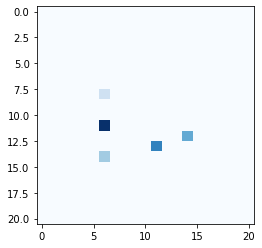

Act_State 1 : [1, 0, 0, 0] Action:  5 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1003
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1000


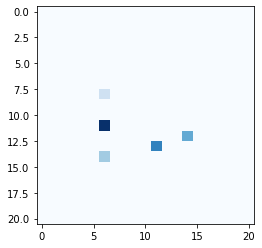

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1003
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1000


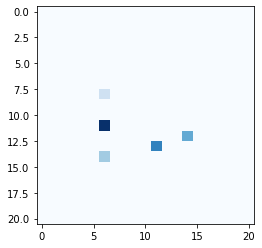

Act_State 1 : [1, 0, 0, 0] Action:  5 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1003
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1000


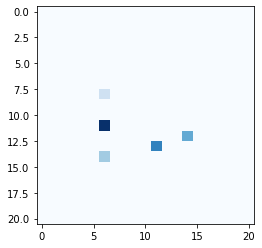

Act_State 1 : [1, 0, 0, 0] Action:  5 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1003
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1000


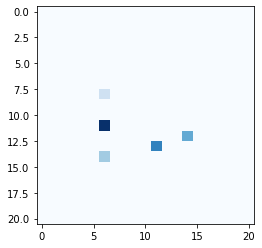

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1003
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1000


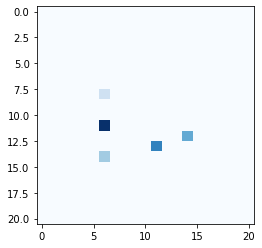

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1003
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1000


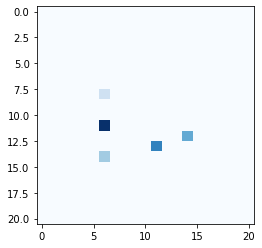

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1003
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1000


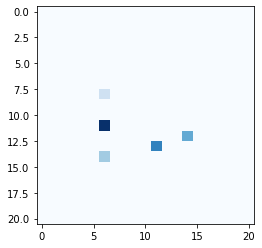

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1003
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1000


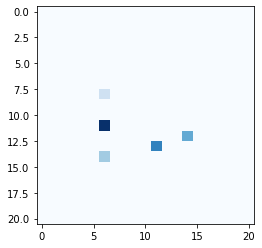

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1003
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1000
Fire ID: 1003 goes POP


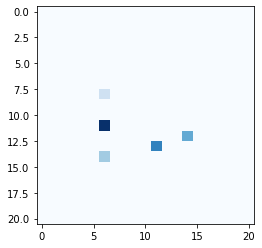

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [0, 1, 0, 0] Action:  1 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1000


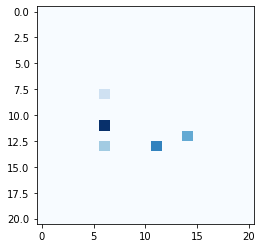

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [0, 1, 0, 0] Action:  1 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1000


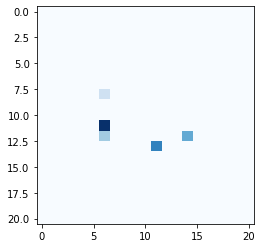

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [0, 1, 0, 0] Action:  1 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1000


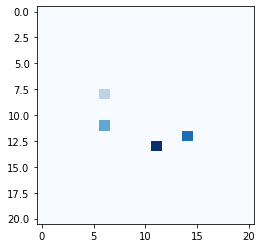

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [0, 1, 0, 0] Action:  1 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1000


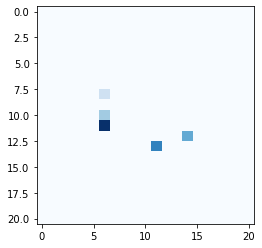

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [0, 1, 0, 0] Action:  1 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1000


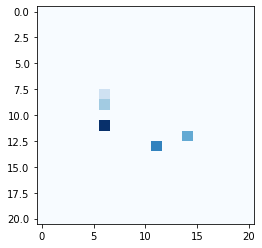

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [0, 1, 0, 0] Action:  1 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1000


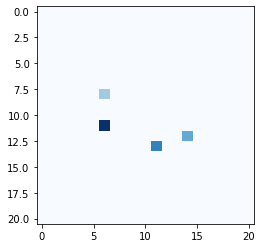

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1000


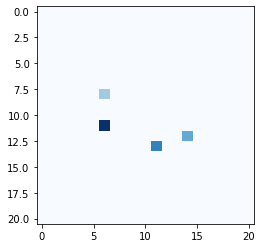

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1000


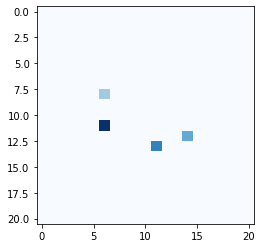

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1000


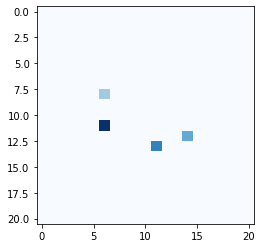

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1000


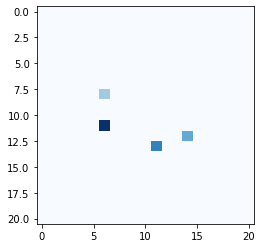

Act_State 1 : [1, 1, 0, 0] Action:  4 1001
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1000
Fire ID: 1001 goes POP


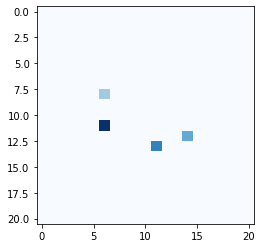

Act_State 1 : [0, 1, 0, 0] Action:  0 1000
Act_State 2 : [0, 1, 0, 0] Action:  2 1002
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1000


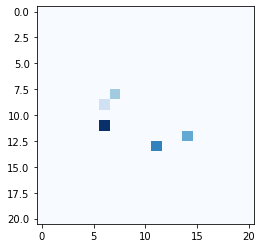

Act_State 1 : [0, 1, 0, 0] Action:  2 1000
Act_State 2 : [0, 1, 0, 0] Action:  2 1002
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1000


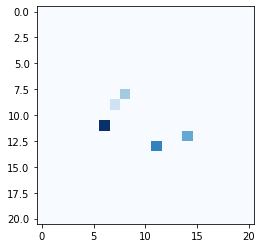

Act_State 1 : [0, 1, 0, 0] Action:  0 1000
Act_State 2 : [0, 1, 0, 0] Action:  2 1002
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [1, 1, 0, 0] Action:  4 1000
Fire ID: 1000 goes POP


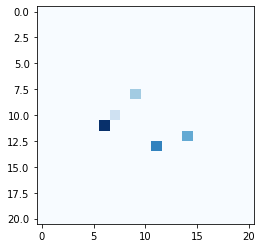

Act_State 1 : [0, 1, 0, 0] Action:  0 1004
Act_State 2 : [0, 1, 0, 0] Action:  2 1002
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [0, 1, 0, 0] Action:  2 1002


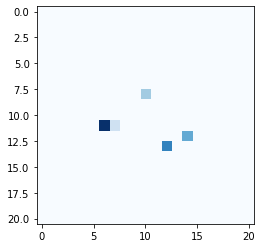

Act_State 1 : [0, 1, 0, 0] Action:  3 1004
Act_State 2 : [0, 1, 0, 0] Action:  0 1002
Act_State 3 : [1, 1, 0, 0] Action:  4 1002
Act_State 4 : [0, 1, 0, 0] Action:  2 1002
Fire ID: 1002 goes POP


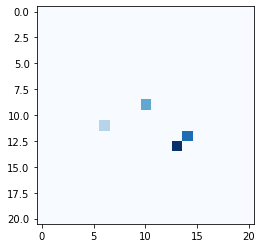

Act_State 1 : [1, 1, 0, 0] Action:  4 1004
Act_State 2 : [0, 1, 0, 0] Action:  3 1004
Act_State 3 : [0, 1, 0, 0] Action:  3 1004
Act_State 4 : [0, 1, 0, 0] Action:  3 1004


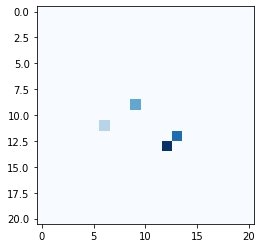

Act_State 1 : [1, 0, 0, 0] Action:  5 1004
Act_State 2 : [0, 1, 0, 0] Action:  3 1004
Act_State 3 : [0, 1, 0, 0] Action:  3 1004
Act_State 4 : [0, 1, 0, 0] Action:  3 1004


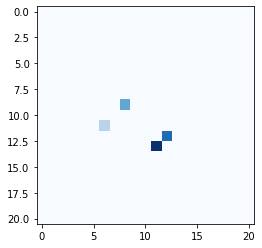

Act_State 1 : [1, 0, 0, 0] Action:  5 1004
Act_State 2 : [0, 1, 0, 0] Action:  0 1004
Act_State 3 : [0, 1, 0, 0] Action:  3 1004
Act_State 4 : [0, 1, 0, 0] Action:  3 1004


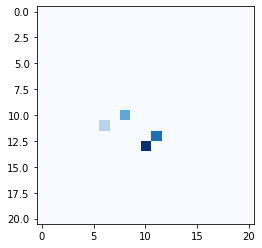

Act_State 1 : [1, 0, 0, 0] Action:  5 1004
Act_State 2 : [0, 1, 0, 0] Action:  3 1004
Act_State 3 : [0, 1, 0, 0] Action:  3 1004
Act_State 4 : [0, 1, 0, 0] Action:  3 1004


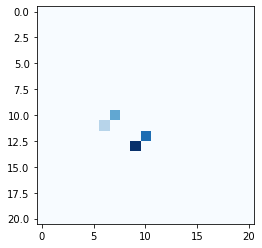

Act_State 1 : [1, 0, 0, 0] Action:  5 1004
Act_State 2 : [0, 1, 0, 0] Action:  0 1004
Act_State 3 : [0, 1, 0, 0] Action:  3 1004
Act_State 4 : [0, 1, 0, 0] Action:  3 1004


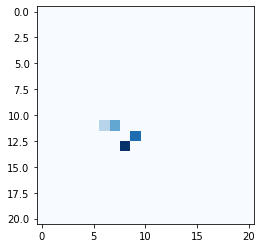

Act_State 1 : [1, 0, 0, 0] Action:  5 1004
Act_State 2 : [0, 1, 0, 0] Action:  3 1004
Act_State 3 : [0, 1, 0, 0] Action:  3 1004
Act_State 4 : [0, 1, 0, 0] Action:  1 1004


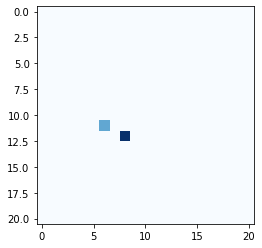

Act_State 1 : [1, 0, 0, 0] Action:  5 1004
Act_State 2 : [1, 1, 0, 0] Action:  4 1004
Act_State 3 : [0, 1, 0, 0] Action:  3 1004
Act_State 4 : [0, 1, 0, 0] Action:  3 1004


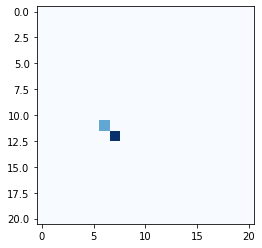

Act_State 1 : [1, 0, 0, 0] Action:  5 1004
Act_State 2 : [1, 0, 0, 0] Action:  5 1004
Act_State 3 : [0, 1, 0, 0] Action:  1 1004
Act_State 4 : [0, 1, 0, 0] Action:  1 1004


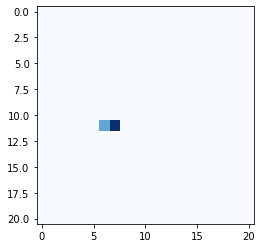

Act_State 1 : [1, 0, 0, 0] Action:  5 1004
Act_State 2 : [1, 0, 0, 0] Action:  5 1004
Act_State 3 : [0, 1, 0, 0] Action:  3 1004
Act_State 4 : [0, 1, 0, 0] Action:  3 1004


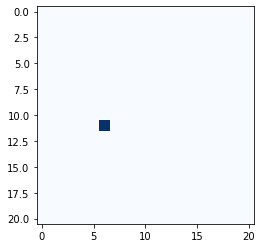

Act_State 1 : [1, 0, 0, 0] Action:  5 1004
Act_State 2 : [1, 0, 0, 0] Action:  5 1004
Act_State 3 : [1, 1, 0, 0] Action:  4 1004
Act_State 4 : [1, 1, 0, 0] Action:  4 1004


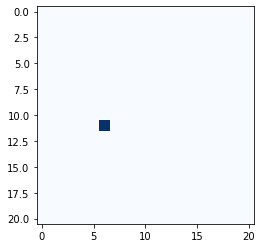

Act_State 1 : [1, 0, 0, 0] Action:  5 1004
Act_State 2 : [1, 0, 0, 0] Action:  5 1004
Act_State 3 : [1, 0, 0, 0] Action:  5 1004
Act_State 4 : [1, 0, 0, 0] Action:  5 1004


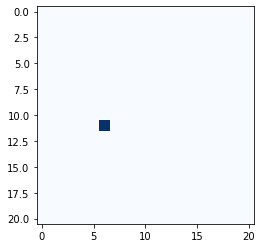

Act_State 1 : [1, 0, 0, 0] Action:  5 1004
Act_State 2 : [1, 0, 0, 0] Action:  5 1004
Act_State 3 : [1, 0, 0, 0] Action:  5 1004
Act_State 4 : [1, 0, 0, 0] Action:  5 1004


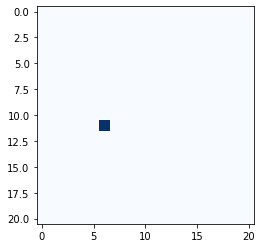

Act_State 1 : [1, 0, 0, 0] Action:  5 1004
Act_State 2 : [1, 0, 0, 0] Action:  5 1004
Act_State 3 : [1, 0, 0, 0] Action:  5 1004
Act_State 4 : [1, 1, 0, 0] Action:  4 1004


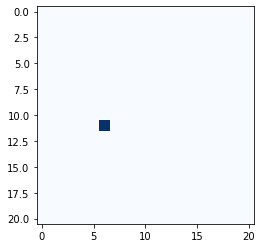

Act_State 1 : [1, 0, 0, 0] Action:  5 1004
Act_State 2 : [1, 1, 0, 0] Action:  4 1004
Act_State 3 : [1, 1, 0, 0] Action:  4 1004
Act_State 4 : [1, 1, 0, 0] Action:  4 1004


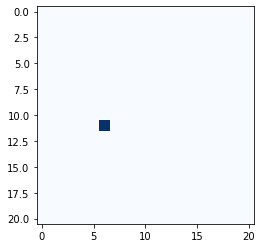

Act_State 1 : [1, 1, 0, 0] Action:  4 1004
Act_State 2 : [1, 1, 0, 0] Action:  4 1004
Act_State 3 : [1, 1, 0, 0] Action:  4 1004
Act_State 4 : [1, 1, 0, 0] Action:  4 1004


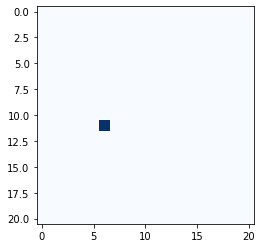

Act_State 1 : [1, 1, 0, 0] Action:  4 1004
Act_State 2 : [1, 1, 0, 0] Action:  4 1004
Act_State 3 : [1, 1, 0, 0] Action:  4 1004
Act_State 4 : [1, 1, 0, 0] Action:  4 1004


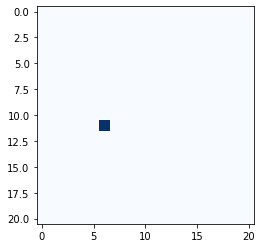

Act_State 1 : [1, 1, 0, 0] Action:  4 1004
Act_State 2 : [1, 1, 0, 0] Action:  4 1004
Act_State 3 : [1, 1, 0, 0] Action:  4 1004
Act_State 4 : [1, 1, 0, 0] Action:  4 1004
Fire ID: 1004 goes POP


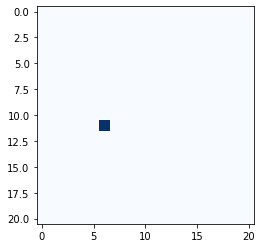

Score: 123.5 Heat:  []
Episode: 10 

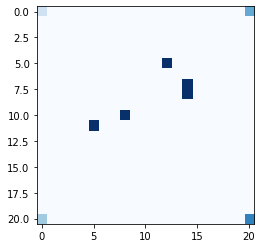

Act_State 1 : [0, 1, 0, 0] Action:  0 1002
Act_State 2 : [0, 1, 0, 0] Action:  1 1001
Act_State 3 : [0, 1, 0, 0] Action:  0 1000
Act_State 4 : [0, 1, 0, 0] Action:  1 1003


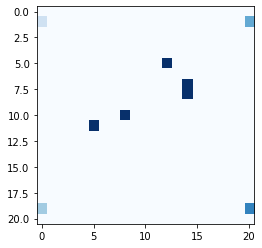

Act_State 1 : [0, 1, 0, 0] Action:  0 1002
Act_State 2 : [0, 1, 0, 0] Action:  1 1001
Act_State 3 : [0, 1, 0, 0] Action:  0 1000
Act_State 4 : [0, 1, 0, 0] Action:  1 1003


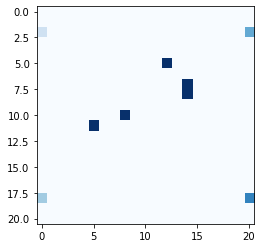

Act_State 1 : [0, 1, 0, 0] Action:  0 1002
Act_State 2 : [0, 1, 0, 0] Action:  1 1001
Act_State 3 : [0, 1, 0, 0] Action:  0 1000
Act_State 4 : [0, 1, 0, 0] Action:  1 1003


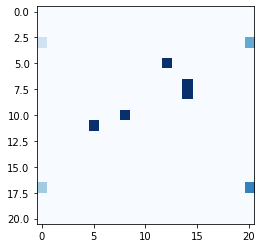

Act_State 1 : [0, 1, 0, 0] Action:  2 1002
Act_State 2 : [0, 1, 0, 0] Action:  1 1001
Act_State 3 : [0, 1, 0, 0] Action:  3 1000
Act_State 4 : [0, 1, 0, 0] Action:  1 1003


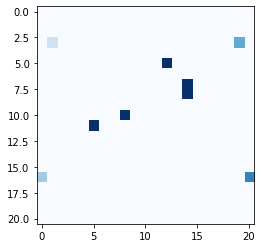

Act_State 1 : [0, 1, 0, 0] Action:  0 1002
Act_State 2 : [0, 1, 0, 0] Action:  1 1001
Act_State 3 : [0, 1, 0, 0] Action:  0 1000
Act_State 4 : [0, 1, 0, 0] Action:  1 1003


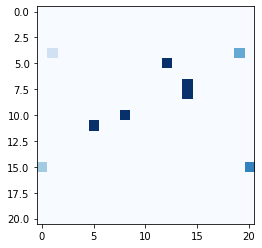

Act_State 1 : [0, 1, 0, 0] Action:  2 1002
Act_State 2 : [0, 1, 0, 0] Action:  2 1001
Act_State 3 : [0, 1, 0, 0] Action:  3 1000
Act_State 4 : [0, 1, 0, 0] Action:  1 1003


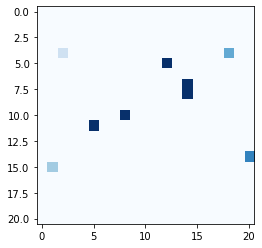

Act_State 1 : [0, 1, 0, 0] Action:  0 1002
Act_State 2 : [0, 1, 0, 0] Action:  1 1001
Act_State 3 : [0, 1, 0, 0] Action:  0 1000
Act_State 4 : [0, 1, 0, 0] Action:  1 1003


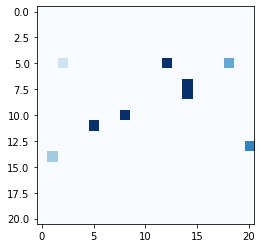

Act_State 1 : [0, 1, 0, 0] Action:  2 1002
Act_State 2 : [0, 1, 0, 0] Action:  2 1001
Act_State 3 : [0, 1, 0, 0] Action:  3 1000
Act_State 4 : [0, 1, 0, 0] Action:  1 1003


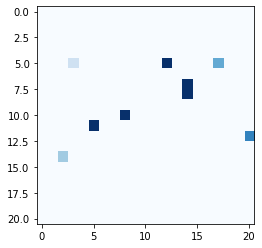

Act_State 1 : [0, 1, 0, 0] Action:  0 1002
Act_State 2 : [0, 1, 0, 0] Action:  1 1001
Act_State 3 : [0, 1, 0, 0] Action:  0 1000
Act_State 4 : [0, 1, 0, 0] Action:  3 1003


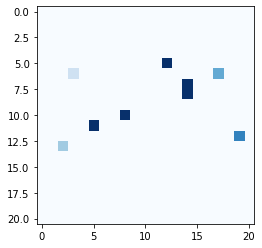

Act_State 1 : [0, 1, 0, 0] Action:  2 1002
Act_State 2 : [0, 1, 0, 0] Action:  2 1001
Act_State 3 : [0, 1, 0, 0] Action:  3 1000
Act_State 4 : [0, 1, 0, 0] Action:  1 1003


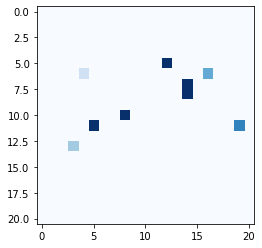

Act_State 1 : [0, 1, 0, 0] Action:  0 1002
Act_State 2 : [0, 1, 0, 0] Action:  1 1001
Act_State 3 : [0, 1, 0, 0] Action:  0 1000
Act_State 4 : [0, 1, 0, 0] Action:  3 1003


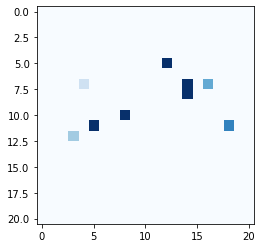

Act_State 1 : [0, 1, 0, 0] Action:  2 1002
Act_State 2 : [0, 1, 0, 0] Action:  2 1001
Act_State 3 : [0, 1, 0, 0] Action:  3 1000
Act_State 4 : [0, 1, 0, 0] Action:  1 1003


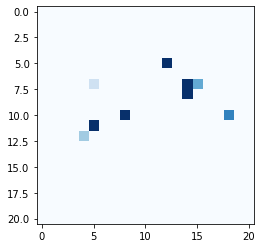

Act_State 1 : [0, 1, 0, 0] Action:  0 1002
Act_State 2 : [0, 1, 0, 0] Action:  1 1001
Act_State 3 : [0, 1, 0, 0] Action:  0 1000
Act_State 4 : [0, 1, 0, 0] Action:  3 1003


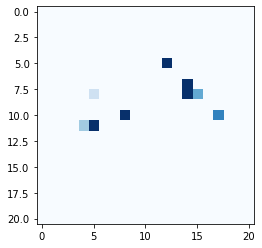

Act_State 1 : [0, 1, 0, 0] Action:  2 1002
Act_State 2 : [0, 1, 0, 0] Action:  2 1001
Act_State 3 : [0, 1, 0, 0] Action:  3 1000
Act_State 4 : [0, 1, 0, 0] Action:  1 1003


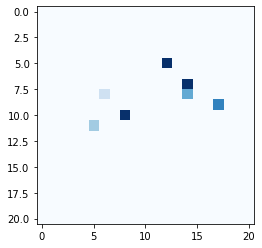

Act_State 1 : [0, 1, 0, 0] Action:  0 1002
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [0, 1, 0, 0] Action:  3 1003


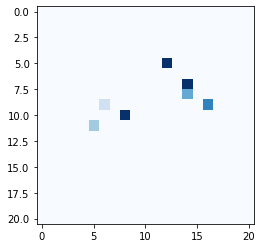

Act_State 1 : [0, 1, 0, 0] Action:  2 1002
Act_State 2 : [1, 0, 0, 0] Action:  5 1001
Act_State 3 : [1, 0, 0, 0] Action:  5 1000
Act_State 4 : [0, 1, 0, 0] Action:  1 1003


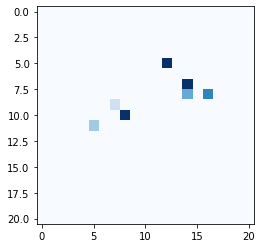

Act_State 1 : [0, 1, 0, 0] Action:  0 1002
Act_State 2 : [1, 0, 0, 0] Action:  5 1001
Act_State 3 : [1, 0, 0, 0] Action:  5 1000
Act_State 4 : [0, 1, 0, 0] Action:  3 1003


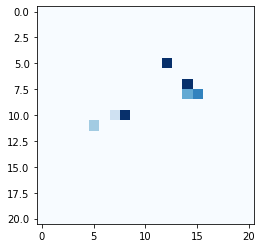

Act_State 1 : [0, 1, 0, 0] Action:  2 1002
Act_State 2 : [1, 0, 0, 0] Action:  5 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [0, 1, 0, 0] Action:  1 1003


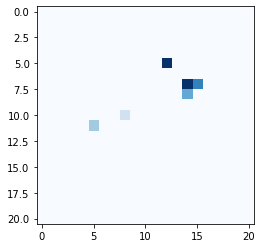

Act_State 1 : [1, 1, 0, 0] Action:  4 1002
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 0, 0, 0] Action:  5 1000
Act_State 4 : [0, 1, 0, 0] Action:  3 1003


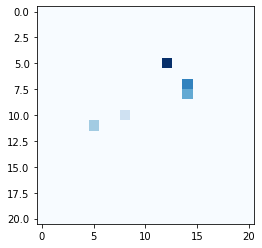

Act_State 1 : [1, 0, 0, 0] Action:  5 1002
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 0, 0, 0] Action:  5 1000
Act_State 4 : [0, 1, 0, 0] Action:  1 1003


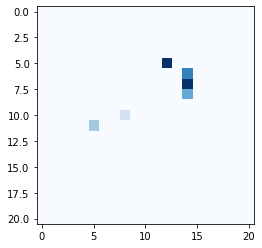

Act_State 1 : [1, 0, 0, 0] Action:  5 1002
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 0, 0, 0] Action:  5 1000
Act_State 4 : [0, 1, 0, 0] Action:  3 1003


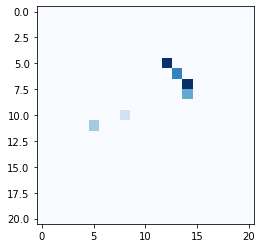

Act_State 1 : [1, 0, 0, 0] Action:  5 1002
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [0, 1, 0, 0] Action:  1 1003


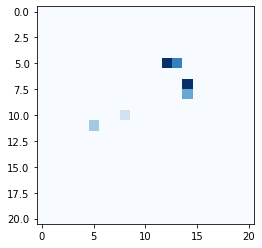

Act_State 1 : [1, 0, 0, 0] Action:  5 1002
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [0, 1, 0, 0] Action:  3 1003


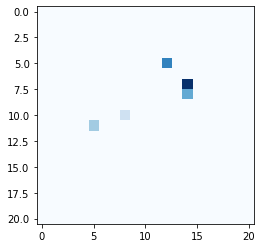

Act_State 1 : [1, 0, 0, 0] Action:  5 1002
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


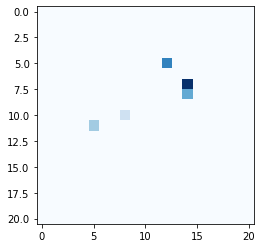

Act_State 1 : [1, 1, 0, 0] Action:  4 1002
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [1, 0, 0, 0] Action:  5 1003


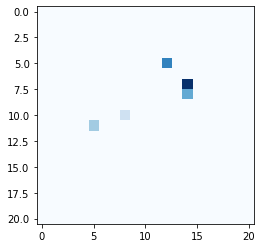

Act_State 1 : [1, 0, 0, 0] Action:  5 1002
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [1, 0, 0, 0] Action:  5 1003


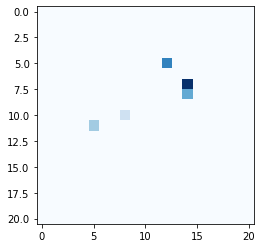

Act_State 1 : [1, 0, 0, 0] Action:  5 1002
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [1, 0, 0, 0] Action:  5 1003


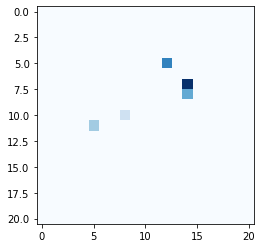

Act_State 1 : [1, 0, 0, 0] Action:  5 1002
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [1, 0, 0, 0] Action:  5 1003


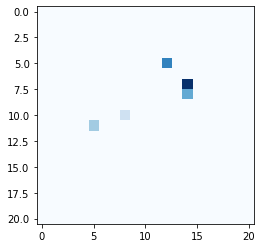

Act_State 1 : [1, 1, 0, 0] Action:  4 1002
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [1, 0, 0, 0] Action:  5 1003


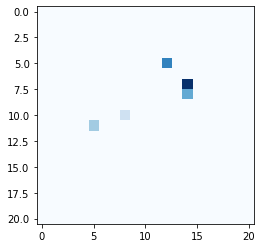

Act_State 1 : [1, 1, 0, 0] Action:  4 1002
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [1, 0, 0, 0] Action:  5 1003


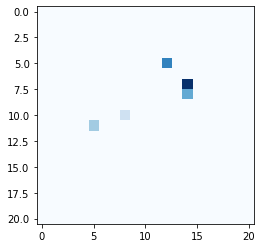

Act_State 1 : [1, 1, 0, 0] Action:  4 1002
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [1, 0, 0, 0] Action:  5 1003


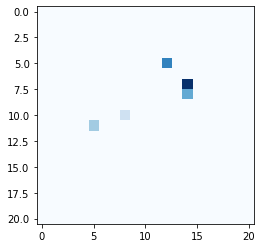

Act_State 1 : [1, 1, 0, 0] Action:  4 1002
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


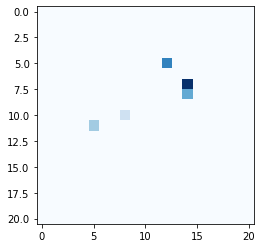

Act_State 1 : [1, 1, 0, 0] Action:  4 1002
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [1, 0, 0, 0] Action:  5 1003


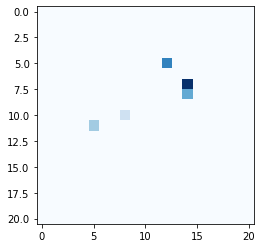

Act_State 1 : [1, 1, 0, 0] Action:  4 1002
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [1, 0, 0, 0] Action:  5 1003


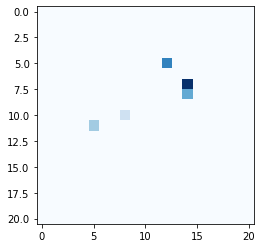

Act_State 1 : [1, 1, 0, 0] Action:  4 1002
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [1, 0, 0, 0] Action:  5 1003


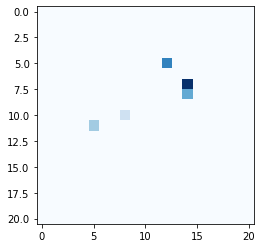

Act_State 1 : [1, 1, 0, 0] Action:  4 1002
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


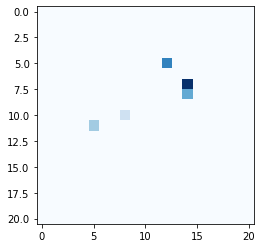

Act_State 1 : [1, 1, 0, 0] Action:  4 1002
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


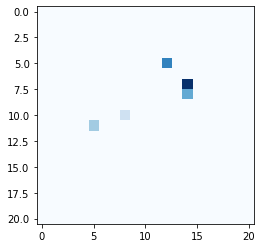

Act_State 1 : [1, 1, 0, 0] Action:  4 1002
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


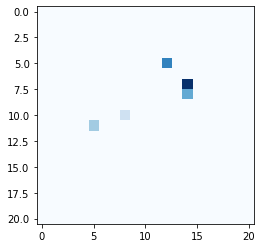

Act_State 1 : [1, 1, 0, 0] Action:  4 1002
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


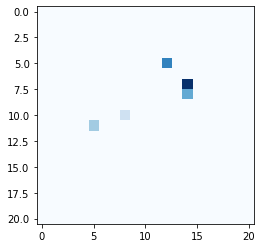

Act_State 1 : [1, 1, 0, 0] Action:  4 1002
Act_State 2 : [1, 1, 0, 0] Action:  4 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [1, 1, 0, 0] Action:  4 1003
Fire ID: 1001 goes POP


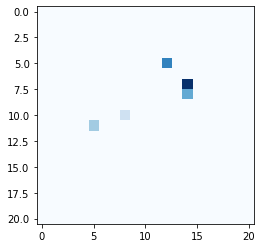

Act_State 1 : [1, 1, 0, 0] Action:  4 1002
Act_State 2 : [0, 1, 0, 0] Action:  1 1001
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


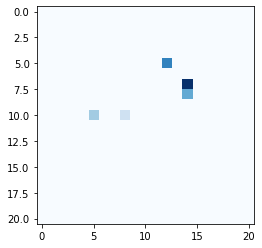

Act_State 1 : [1, 1, 0, 0] Action:  4 1002
Act_State 2 : [0, 1, 0, 0] Action:  2 1002
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


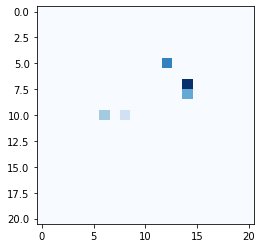

Act_State 1 : [1, 1, 0, 0] Action:  4 1002
Act_State 2 : [0, 1, 0, 0] Action:  2 1002
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


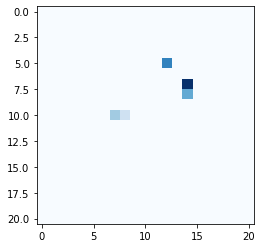

Act_State 1 : [1, 1, 0, 0] Action:  4 1002
Act_State 2 : [0, 1, 0, 0] Action:  2 1002
Act_State 3 : [1, 1, 0, 0] Action:  4 1000
Act_State 4 : [1, 1, 0, 0] Action:  4 1003
Fire ID: 1000 goes POP


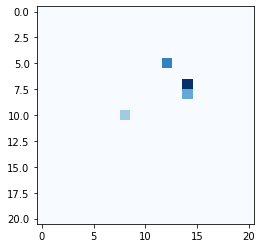

Act_State 1 : [1, 1, 0, 0] Action:  4 1002
Act_State 2 : [1, 1, 0, 0] Action:  4 1002
Act_State 3 : [0, 1, 0, 0] Action:  1 1000
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


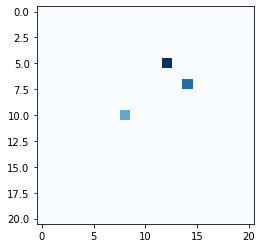

Act_State 1 : [1, 1, 0, 0] Action:  4 1002
Act_State 2 : [1, 1, 0, 0] Action:  4 1002
Act_State 3 : [1, 1, 0, 0] Action:  4 1004
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


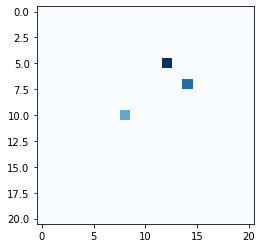

Act_State 1 : [1, 1, 0, 0] Action:  4 1002
Act_State 2 : [1, 1, 0, 0] Action:  4 1002
Act_State 3 : [1, 0, 0, 0] Action:  5 1004
Act_State 4 : [1, 1, 0, 0] Action:  4 1003
Fire ID: 1002 goes POP


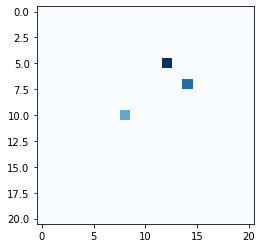

Act_State 1 : [0, 1, 0, 0] Action:  1 1002
Act_State 2 : [0, 1, 0, 0] Action:  1 1003
Act_State 3 : [1, 0, 0, 0] Action:  5 1004
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


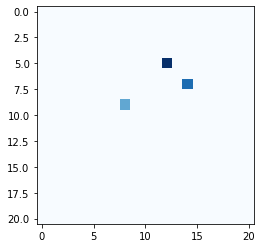

Act_State 1 : [0, 1, 0, 0] Action:  1 1003
Act_State 2 : [0, 1, 0, 0] Action:  1 1003
Act_State 3 : [1, 0, 0, 0] Action:  5 1004
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


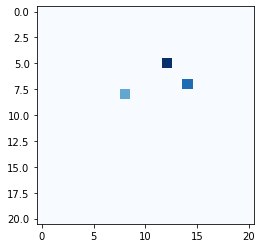

Act_State 1 : [0, 1, 0, 0] Action:  2 1003
Act_State 2 : [0, 1, 0, 0] Action:  2 1003
Act_State 3 : [1, 0, 0, 0] Action:  5 1004
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


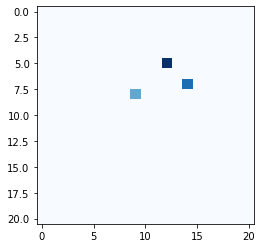

Act_State 1 : [0, 1, 0, 0] Action:  1 1003
Act_State 2 : [0, 1, 0, 0] Action:  1 1003
Act_State 3 : [1, 0, 0, 0] Action:  5 1004
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


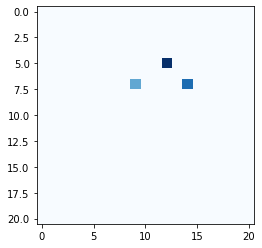

Act_State 1 : [0, 1, 0, 0] Action:  2 1003
Act_State 2 : [0, 1, 0, 0] Action:  2 1003
Act_State 3 : [1, 0, 0, 0] Action:  5 1004
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


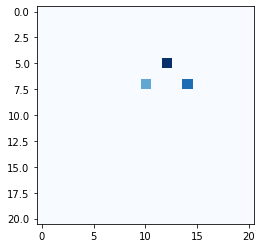

Act_State 1 : [0, 1, 0, 0] Action:  1 1003
Act_State 2 : [0, 1, 0, 0] Action:  1 1003
Act_State 3 : [1, 0, 0, 0] Action:  5 1004
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


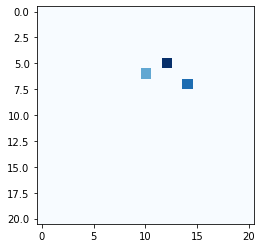

Act_State 1 : [0, 1, 0, 0] Action:  2 1003
Act_State 2 : [0, 1, 0, 0] Action:  2 1003
Act_State 3 : [1, 0, 0, 0] Action:  5 1004
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


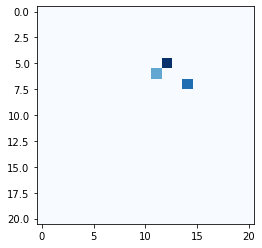

Act_State 1 : [0, 1, 0, 0] Action:  1 1003
Act_State 2 : [0, 1, 0, 0] Action:  1 1003
Act_State 3 : [1, 0, 0, 0] Action:  5 1004
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


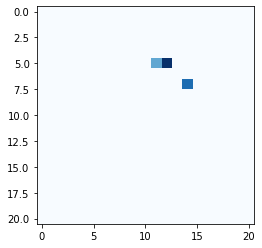

Act_State 1 : [0, 1, 0, 0] Action:  2 1003
Act_State 2 : [0, 1, 0, 0] Action:  2 1003
Act_State 3 : [1, 0, 0, 0] Action:  5 1004
Act_State 4 : [1, 1, 0, 0] Action:  4 1003


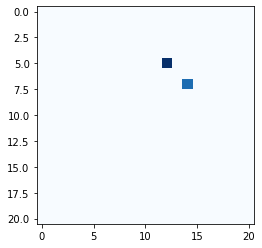

Act_State 1 : [1, 1, 0, 0] Action:  4 1003
Act_State 2 : [1, 1, 0, 0] Action:  4 1003
Act_State 3 : [1, 0, 0, 0] Action:  5 1004
Act_State 4 : [1, 1, 0, 0] Action:  4 1003
Fire ID: 1003 goes POP


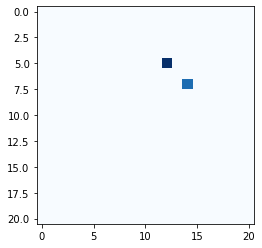

Act_State 1 : [0, 1, 0, 0] Action:  0 1004
Act_State 2 : [0, 1, 0, 0] Action:  0 1004
Act_State 3 : [1, 0, 0, 0] Action:  5 1004
Act_State 4 : [0, 1, 0, 0] Action:  0 1004


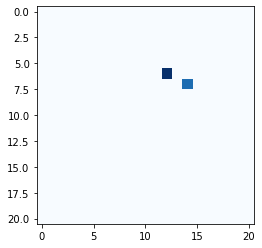

Act_State 1 : [0, 1, 0, 0] Action:  2 1004
Act_State 2 : [0, 1, 0, 0] Action:  2 1004
Act_State 3 : [1, 0, 1, 0] Action:  4 1004
Act_State 4 : [0, 1, 0, 0] Action:  2 1004


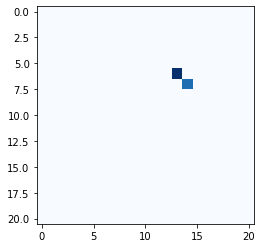

Act_State 1 : [0, 1, 0, 0] Action:  0 1004
Act_State 2 : [0, 1, 0, 0] Action:  0 1004
Act_State 3 : [1, 0, 1, 0] Action:  4 1004
Act_State 4 : [0, 1, 0, 0] Action:  0 1004


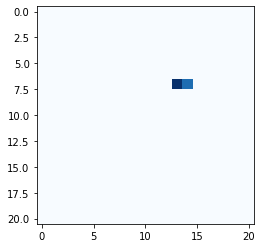

Act_State 1 : [0, 1, 0, 0] Action:  2 1004
Act_State 2 : [0, 1, 0, 0] Action:  2 1004
Act_State 3 : [1, 0, 1, 0] Action:  4 1004
Act_State 4 : [0, 1, 0, 0] Action:  2 1004


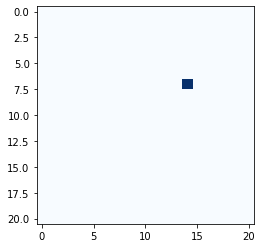

Act_State 1 : [1, 1, 0, 0] Action:  4 1004
Act_State 2 : [1, 1, 0, 0] Action:  4 1004
Act_State 3 : [1, 0, 1, 0] Action:  4 1004
Act_State 4 : [1, 1, 0, 0] Action:  4 1004


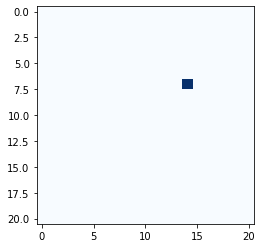

Act_State 1 : [1, 0, 0, 0] Action:  5 1004
Act_State 2 : [1, 0, 0, 0] Action:  5 1004
Act_State 3 : [1, 0, 1, 0] Action:  4 1004
Act_State 4 : [1, 0, 0, 0] Action:  5 1004


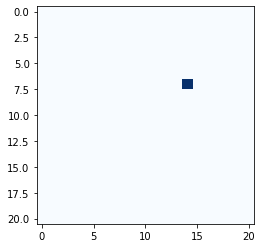

Act_State 1 : [1, 0, 0, 0] Action:  5 1004
Act_State 2 : [1, 0, 0, 0] Action:  5 1004
Act_State 3 : [1, 0, 1, 0] Action:  4 1004
Act_State 4 : [1, 1, 0, 0] Action:  4 1004


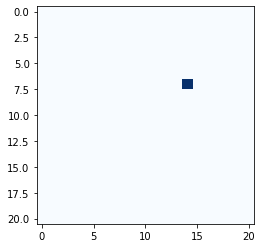

Act_State 1 : [1, 0, 0, 0] Action:  5 1004
Act_State 2 : [1, 1, 0, 0] Action:  4 1004
Act_State 3 : [1, 1, 1, 0] Action:  4 1004
Act_State 4 : [1, 1, 0, 0] Action:  4 1004


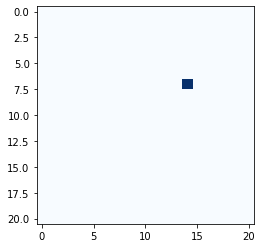

Act_State 1 : [1, 1, 0, 0] Action:  4 1004
Act_State 2 : [1, 1, 0, 0] Action:  4 1004
Act_State 3 : [1, 1, 1, 0] Action:  4 1004
Act_State 4 : [1, 1, 0, 0] Action:  4 1004


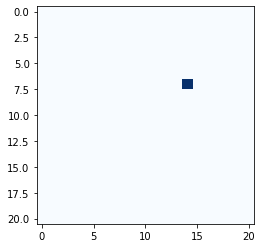

Act_State 1 : [1, 1, 0, 0] Action:  4 1004
Act_State 2 : [1, 1, 0, 0] Action:  4 1004
Act_State 3 : [1, 1, 1, 0] Action:  4 1004
Act_State 4 : [1, 1, 0, 0] Action:  4 1004


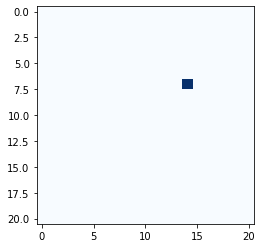

Act_State 1 : [1, 1, 0, 0] Action:  4 1004
Act_State 2 : [1, 1, 0, 0] Action:  4 1004
Act_State 3 : [1, 1, 1, 0] Action:  4 1004
Act_State 4 : [1, 1, 0, 0] Action:  4 1004
Fire ID: 1004 goes POP


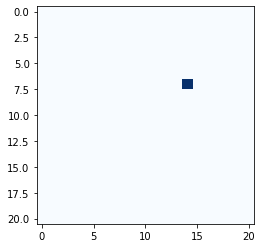

Score: 80.5 Heat:  []


In [0]:
"""
env = City(fires = 5)


total_score = 0

episodes = 10
for episode in range(1, episodes + 1):
    env.reset()
    Agents = spawn_agents(env)
    
    for I, a in enumerate(Agents):
        p = env.agent_pos[I]
        a.agent_reset(p)
        a.eps = 0
    
    print("Episode: " + str(episode), end = ' ')
    
    Agents = activate_agents(env, Agents)
    scores, steps = [0]*len(Agents), 0
    episode_done = False
    env.render()
    plt.show()

    while not episode_done:
        
        Active_List = []
        Actions = [0]*len(Agents)
        for B in Agents:
            Active_List.append(B.active)
        steps +=1
        for i,A in enumerate(Agents):
            A.act_net.load_weights('/content/drive/My Drive/Colab Notebooks/New_Act_Policy_V3.h5')
            if(Active_List[i]):
                if(not A.engaged):
                    A.choose_target(env)
                    A.act_state = [0,1,0,0]
                A.curr_state = np.append(A.pos, A.f_loc)
                Actions[i] = (A.policy_act())
                print('Act_State '+str(A.agent_no)+' :', A.act_state, 'Action: ', Actions[i], Agents[i].f_ID)
        
        next_state_dict = env.step(Agents, Actions)


        for i,A in enumerate(Agents):

            if(Active_List[i]):
                A.next_state = np.append(A.pos, A.f_loc)
                R = next_state_dict['R_vec'][i]
                scores[i]+=R
                
        episode_done = env.check_fires()
        
        env.render()
        plt.show()

    total_score += sum(scores)
    print("Score: " + str(scores[0])+" Heat: ", end = ' ')
    print([x.heat for x in env.fires])
"""